In [1]:
import numpy as np
import os
import re
import pandas as pd

In [3]:
station='EDEN_6'
os.chdir('C:\\Data\\'+station)
getWL1='dWL[EDEN_6][2010-01-01 to 2012-01-02]082602.071372.csv'
station=re.findall('^dWL\[(.*?)]',getWL1)
station=station[0]
dataset=re.findall('\]\[(.*?)]',getWL1)
### Water level input
getWL2='dWL[EDEN_6][2016-01-01 to 2018-01-02]082616.771372.csv'
getWL3='dWL[EDEN_6][2010-01-02 to 2012-01-03]134858.027278.csv'
getWL4='dWL[EDEN_6][2016-01-02 to 2018-01-03]132943.596387.csv'
### Rainfall input
getR1='dR[EDEN_6][2010-01-01 to 2012-01-01]085412.292778.csv'
getR2='dR[EDEN_6][2016-01-01 to 2018-01-01]085422.807778.csv'
###load data
getWL1=pd.read_csv(getWL1,skiprows=1,names=['Date','DailyWL(ft)','DailyWL(m)'],parse_dates=['Date'])
getWL2=pd.read_csv(getWL2,skiprows=1,names=['Date','DailyWL(ft)','DailyWL(m)'],parse_dates=['Date'])
getWL3=pd.read_csv(getWL3,skiprows=1,names=['Date','DailyWL(ft)','DailyWL(m)'],parse_dates=['Date'])
getWL4=pd.read_csv(getWL4,skiprows=1,names=['Date','DailyWL(ft)','DailyWL(m)'],parse_dates=['Date'])
getR1=pd.read_csv(getR1,skiprows=1,names=['Date','DailyRainfall(in)','DailyRainfall(mm)'],parse_dates=['Date'])
getR2=pd.read_csv(getR2,skiprows=1,names=['Date','DailyRainfall(in)','DailyRainfall(mm)'],parse_dates=['Date'])
###water level output
os.chdir('C:\\Data')
setWL1='dWLd1['+station+']DataforTraining.csv'
setWL2='dWLd1['+station+']DataforValidation.csv'

### prepare dataset ===================================================================================

In [4]:
## training dataset
getR1tr=getR1['DailyRainfall(mm)']
getWL1tr=getWL1['DailyWL(m)']
## validation dataset
getR2val=getR2['DailyRainfall(mm)']
getWL2val=getWL2['DailyWL(m)']
## desired output dataset
getWL3tr=(getWL3['DailyWL(m)']).values
getWL4val=(getWL4['DailyWL(m)']).values

### Data Preprocessing ===================================================================================

In [5]:
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
#from sklearn.preprocessing import PowerTransformer
all_inp_train=pd.concat([getR1tr,getWL1tr],axis=1)
all_inp_valid=pd.concat([getR2val,getWL2val],axis=1)
all_out_train=np.reshape(getWL3tr,[-1,1])
all_out_valid=np.reshape(getWL4val,[-1,1])

### preprocessing the dataset Standardization or mean removal and variance scaling gaussian with zero mean and unit variance

In [6]:
inp_prepro=preprocessing.scale(all_inp_train)
inp_trans=preprocessing.StandardScaler().fit(all_inp_train)
inp_tr_pp=inp_trans.transform(all_inp_train)
out_prepro=preprocessing.scale(all_out_train)
out_trans=preprocessing.StandardScaler().fit(all_out_train)
out_tr_pp=out_trans.transform(all_out_train)

### Training ANN Model =======================================================================================

In [7]:
RMSE1_list=[]
RMSE2_list=[]
for i in range(101):
    ann_mod=MLPRegressor()
    ann_mod.hidden_layer_sizes=(4,)
    ann_mod.activation='logistic'
    ann_mod.solver='sgd'
    #alpha=0.0001                    ###default
    #batch_size='auto'               ###default
    #ann_mod.learning_rate='constant'###default
    #learning_rate_init=0.001        ###default
    #power_t=0.5                     ###default
    ann_mod.max_iter=1500
    #shuffle=True                    ###default
    #random_state=None               ###default
    #tol=0.0001                      ###default
    ann_mod.verbose=True
    #ann_mod.warm_start=False        ###default
    #ann_mod.momentum=0.9            ###default
    #ann_mod.nesterovs_momentum=True ###default
    ann_mod.early_stopping=True
    ann_mod.validation_fraction=0.2
    #beta_1=0.9                      ###default
    #beta_2=0.999                    ###default
    #epsilon=1e-08                   ###default
    ann_mod.n_iter_no_change=10
    ###------------------------------------------------------
    ann_mod.fit(inp_tr_pp, out_tr_pp)
    ann_mod.score(inp_tr_pp, out_tr_pp)
    pred=ann_mod.predict(inp_tr_pp)
    pred=np.reshape(pred, [-1,1])
    observed1=out_trans.inverse_transform(out_tr_pp)
    predicted1=out_trans.inverse_transform(pred.round(2))
    ###----------------------------------------------------------------------------
    ### Training model evaluation
    ###----------------------------------------------------------------------------
    ###----------------------------------------------------------------------------
    tr_min=np.min(predicted1).round(2)#minimum of output
    tr_max=np.max(predicted1).round(2)#maximum of output
    tr_range=(tr_max-tr_min).round(2)#range of output
    #tr_avg=np.average(predicted1)#average of output
    autoMSE1=mean_squared_error(observed1,predicted1)#auto mean squared error
    COD1=r2_score(observed1,predicted1).round(4)#coefficient of determination
    sumofError1=0
    sumofsqError1=0
    datalength1=len(predicted1)
    for i in range(len(observed1+1)):
        sumofError1+=(observed1[i]-predicted1[i])
        sumofsqError1+=((observed1[i] - predicted1[i])**2)
    
    ME1=(sumofError1/datalength1)#mean error
    SSE1=sumofsqError1#sum of squared error
    MSE1=(sumofsqError1/datalength1)#mean squared error
    RMSE1=np.sqrt(MSE1)#root mean squared error
    PME1=(RMSE1/tr_range)#Percent modeled error
    
    
    autoMSE1=('%.4f'% float(autoMSE1))
    MSE1=('%.4f'% float(MSE1))      
    SSE1=('%.4f'% float(SSE1))
    ME1=('%.4f'% float(ME1))
    PME1=('%.2f'% float(PME1))
    RMSE1=('%.4f'% float(RMSE1)) 
    mod_loss1=ann_mod.loss_
    num_of_layers1=ann_mod.hidden_layer_sizes
    n_outputs1=ann_mod.n_outputs_
    active_fun1=ann_mod.out_activation_
    num_iter1=ann_mod.n_iter_
    score1=ann_mod.score
    ###----------------------------------------------------------------------------
    ### ANN Model Validation
    ###----------------------------------------------------------------------------
    inp_prepro=preprocessing.scale(all_inp_valid)##
    inp_trans=preprocessing.StandardScaler().fit(all_inp_valid)
    inp_val_pp=inp_trans.transform(all_inp_valid)##
    out_prepro=preprocessing.scale(all_out_valid)##
    out_trans=preprocessing.StandardScaler().fit(all_out_valid)
    out_val_pp=out_trans.transform(all_out_valid)##
    ann_mod.fit(inp_val_pp, out_val_pp)
    pred1=ann_mod.predict(inp_val_pp)
    pred1=np.reshape(pred1, [-1,1])
    observed2=out_trans.inverse_transform(out_val_pp)
    predicted2=out_trans.inverse_transform(pred1.round(2))
    ###----------------------------------------------------------------------------
    ### Validation model evaluation
    ###----------------------------------------------------------------------------
    val_min=np.min(predicted2).round(2)
    val_max=np.max(predicted2).round(2)
    val_range=(val_max-val_min).round(2)
    val_avg=np.average(predicted2)
    ## calculate MSE using Sci-kit learn lib
    autoMSE2=(mean_squared_error(observed2,predicted2))
    ## calculate Coefficient of determination using Sci-kit learn library
    COD2=(r2_score(observed2,predicted2)).round(4)
    sumofError2=0
    sumofsqError2=0
    datalength2=len(predicted2)
    for i in range(len(observed2+1)):
        sumofError2+=(observed2[i]-predicted2[i])
        sumofsqError2+=((observed2[i]-predicted2[i])**2)
    SSE2=(sumofsqError2)#sum of squared error
    ME2=(sumofError2/datalength2)### mean error
    MSE2=(sumofsqError2/datalength2)## mean squared error
    RMSE2=np.sqrt(MSE2)## root mean squared error 
    PME2=(RMSE2/val_range)## percent model error
    
    
    autoMSE2=('%.4f'% float(autoMSE2))
    MSE2=('%.4f'% float(MSE2))      
    SSE2=('%.4f'% float(SSE2))
    ME2=('%.4f'% float(ME2))
    PME2=('%.2f'% float(PME2))
    RMSE2=('%.4f'% float(RMSE2)) 
    score2=ann_mod.score
    mod_loss2=ann_mod.loss_
    num_of_layers2=ann_mod.hidden_layer_sizes
    n_outputs2=ann_mod.n_outputs_
    active_fun2=ann_mod.out_activation_
    num_iter2=ann_mod.n_iter_
    
    RMSE1_list.append(RMSE1)
    RMSE2_list.append(RMSE2)
    ###----------------------------------------------------------------------------
DF41_RMSE=pd.DataFrame(RMSE1_list,columns=['RMSE'])
DF42_RMSE=pd.DataFrame(RMSE2_list,columns=['RMSE'])
DF41_RMSE.to_csv('RMSE1_HLN4.csv',columns=['RMSE'])
DF42_RMSE.to_csv('RMSE2_HLN4.csv',columns=['RMSE'])

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.81394557
Validation score: -0.701647
Iteration 2, loss = 0.80266637
Validation score: -0.665393
Iteration 3, loss = 0.78505823
Validation score: -0.621050
Iteration 4, loss = 0.76582793
Validation score: -0.571446
Iteration 5, loss = 0.74356151
Validation score: -0.521337
Iteration 6, loss = 0.72128773
Validation score: -0.472588
Iteration 7, loss = 0.70109831
Validation score: -0.425600
Iteration 8, loss = 0.68093501
Validation score: -0.382014
Iteration 9, loss = 0.66219399
Validation score: -0.342205
Iteration 10, loss = 0.64625210
Validation score: -0.305621
Iteration 11, loss = 0.63123025
Validation score: -0.272660
Iteration 12, loss = 0.61718557
Validation score: -0.243411
Iteration 13, loss = 0.60526322
Validation score: -0.217217
Iteration 14, loss = 0.59424249
Validation score: -0.194030
Iteration 15, loss = 0.58513189
Validation score: -0.173171
Iteration 16, loss = 0.57621504
Validation score: -0.154825
Iteration 17, loss = 0.56955756
Validation score:

Iteration 195, loss = 0.22833606
Validation score: 0.563370
Iteration 196, loss = 0.22659753
Validation score: 0.566758
Iteration 197, loss = 0.22491058
Validation score: 0.570131
Iteration 198, loss = 0.22323827
Validation score: 0.573505
Iteration 199, loss = 0.22155085
Validation score: 0.576848
Iteration 200, loss = 0.21987159
Validation score: 0.580201
Iteration 201, loss = 0.21818433
Validation score: 0.583539
Iteration 202, loss = 0.21648563
Validation score: 0.586845
Iteration 203, loss = 0.21486382
Validation score: 0.590171
Iteration 204, loss = 0.21318623
Validation score: 0.593476
Iteration 205, loss = 0.21155000
Validation score: 0.596767
Iteration 206, loss = 0.20989283
Validation score: 0.600035
Iteration 207, loss = 0.20825052
Validation score: 0.603305
Iteration 208, loss = 0.20663732
Validation score: 0.606563
Iteration 209, loss = 0.20494360
Validation score: 0.609784
Iteration 210, loss = 0.20335823
Validation score: 0.613007
Iteration 211, loss = 0.20173466
Validat

Iteration 403, loss = 0.03110006
Validation score: 0.948102
Iteration 404, loss = 0.03079728
Validation score: 0.948664
Iteration 405, loss = 0.03050573
Validation score: 0.949220
Iteration 406, loss = 0.03020989
Validation score: 0.949766
Iteration 407, loss = 0.02992909
Validation score: 0.950309
Iteration 408, loss = 0.02964099
Validation score: 0.950843
Iteration 409, loss = 0.02935679
Validation score: 0.951368
Iteration 410, loss = 0.02907596
Validation score: 0.951885
Iteration 411, loss = 0.02880831
Validation score: 0.952400
Iteration 412, loss = 0.02853822
Validation score: 0.952908
Iteration 413, loss = 0.02827440
Validation score: 0.953412
Iteration 414, loss = 0.02801309
Validation score: 0.953910
Iteration 415, loss = 0.02774886
Validation score: 0.954400
Iteration 416, loss = 0.02748888
Validation score: 0.954882
Iteration 417, loss = 0.02723184
Validation score: 0.955356
Iteration 418, loss = 0.02698363
Validation score: 0.955828
Iteration 419, loss = 0.02673416
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation score: 0.180622
Iteration 54, loss = 0.41511294
Validation score: 0.183036
Iteration 55, loss = 0.41394887
Validation score: 0.185358
Iteration 56, loss = 0.41275421
Validation score: 0.187694
Iteration 57, loss = 0.41159535
Validation score: 0.190081
Iteration 58, loss = 0.41043938
Validation score: 0.192438
Iteration 59, loss = 0.40921402
Validation score: 0.194744
Iteration 60, loss = 0.40805735
Validation score: 0.197157
Iteration 61, loss = 0.40685598
Validation score: 0.199572
Iteration 62, loss = 0.40568146
Validation score: 0.201987
Iteration 63, loss = 0.40448008
Validation score: 0.204378
Iteration 64, loss = 0.40328480
Validation score: 0.206799
Iteration 65, loss = 0.40207573
Validation score: 0.209253
Iteration 66, loss = 0.40083052
Validation score: 0.211658
Iteration 67, loss = 0.39965857
Validation score: 0.214097
Iteration 68, loss = 0.39845958
Validation score: 0.216487
Iteration 69, loss = 0.39721836
Validation score: 0.218956
Iteration 70, loss = 0.395971

Iteration 243, loss = 0.15956522
Validation score: 0.698598
Iteration 244, loss = 0.15836846
Validation score: 0.701001
Iteration 245, loss = 0.15718448
Validation score: 0.703371
Iteration 246, loss = 0.15597837
Validation score: 0.705737
Iteration 247, loss = 0.15480913
Validation score: 0.708078
Iteration 248, loss = 0.15362946
Validation score: 0.710403
Iteration 249, loss = 0.15249454
Validation score: 0.712719
Iteration 250, loss = 0.15129724
Validation score: 0.715028
Iteration 251, loss = 0.15018370
Validation score: 0.717336
Iteration 252, loss = 0.14902003
Validation score: 0.719649
Iteration 253, loss = 0.14788812
Validation score: 0.721934
Iteration 254, loss = 0.14673168
Validation score: 0.724216
Iteration 255, loss = 0.14560385
Validation score: 0.726472
Iteration 256, loss = 0.14446882
Validation score: 0.728733
Iteration 257, loss = 0.14334940
Validation score: 0.730967
Iteration 258, loss = 0.14223271
Validation score: 0.733201
Iteration 259, loss = 0.14112930
Validat

Validation score: 0.955591
Iteration 463, loss = 0.02715327
Validation score: 0.955890
Iteration 464, loss = 0.02697560
Validation score: 0.956188
Iteration 465, loss = 0.02680821
Validation score: 0.956479
Iteration 466, loss = 0.02665033
Validation score: 0.956766
Iteration 467, loss = 0.02648550
Validation score: 0.957052
Iteration 468, loss = 0.02632129
Validation score: 0.957329
Iteration 469, loss = 0.02616599
Validation score: 0.957609
Iteration 470, loss = 0.02600632
Validation score: 0.957879
Iteration 471, loss = 0.02585136
Validation score: 0.958145
Iteration 472, loss = 0.02570054
Validation score: 0.958410
Iteration 473, loss = 0.02554587
Validation score: 0.958671
Iteration 474, loss = 0.02539758
Validation score: 0.958931
Iteration 475, loss = 0.02525361
Validation score: 0.959186
Iteration 476, loss = 0.02510380
Validation score: 0.959440
Iteration 477, loss = 0.02496453
Validation score: 0.959686
Iteration 478, loss = 0.02481085
Validation score: 0.959927
Iteration 479

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 12, loss = 0.65380295
Validation score: -0.134314
Iteration 13, loss = 0.63049886
Validation score: -0.105119
Iteration 14, loss = 0.60945798
Validation score: -0.080213
Iteration 15, loss = 0.59228810
Validation score: -0.058740
Iteration 16, loss = 0.57512703
Validation score: -0.040855
Iteration 17, loss = 0.56187225
Validation score: -0.025600
Iteration 18, loss = 0.54980363
Validation score: -0.012784
Iteration 19, loss = 0.53932963
Validation score: -0.002077
Iteration 20, loss = 0.52928786
Validation score: 0.006659
Iteration 21, loss = 0.52164050
Validation score: 0.013978
Iteration 22, loss = 0.51448456
Validation score: 0.019983
Iteration 23, loss = 0.50838406
Validation score: 0.024891
Iteration 24, loss = 0.50245979
Validation score: 0.028817
Iteration 25, loss = 0.49832405
Validation score: 0.032057
Iteration 26, loss = 0.49351131
Validation score: 0.034596
Iteration 27, loss = 0.49000527
Validation score: 0.036654
Iteration 28, loss = 0.48661693
Validation scor

Iteration 220, loss = 0.25437657
Validation score: 0.465778
Iteration 221, loss = 0.25277715
Validation score: 0.469184
Iteration 222, loss = 0.25110355
Validation score: 0.472617
Iteration 223, loss = 0.24946647
Validation score: 0.476080
Iteration 224, loss = 0.24783780
Validation score: 0.479528
Iteration 225, loss = 0.24619583
Validation score: 0.482969
Iteration 226, loss = 0.24456343
Validation score: 0.486424
Iteration 227, loss = 0.24290916
Validation score: 0.489825
Iteration 228, loss = 0.24123744
Validation score: 0.493256
Iteration 229, loss = 0.23965023
Validation score: 0.496718
Iteration 230, loss = 0.23801582
Validation score: 0.500169
Iteration 231, loss = 0.23639400
Validation score: 0.503655
Iteration 232, loss = 0.23476269
Validation score: 0.507093
Iteration 233, loss = 0.23310182
Validation score: 0.510550
Iteration 234, loss = 0.23147173
Validation score: 0.513954
Iteration 235, loss = 0.22983033
Validation score: 0.517388
Iteration 236, loss = 0.22819310
Validat

Iteration 432, loss = 0.03227288
Validation score: 0.934579
Iteration 433, loss = 0.03193416
Validation score: 0.935319
Iteration 434, loss = 0.03158897
Validation score: 0.936045
Iteration 435, loss = 0.03125748
Validation score: 0.936765
Iteration 436, loss = 0.03092103
Validation score: 0.937467
Iteration 437, loss = 0.03059753
Validation score: 0.938161
Iteration 438, loss = 0.03026922
Validation score: 0.938842
Iteration 439, loss = 0.02996034
Validation score: 0.939527
Iteration 440, loss = 0.02964256
Validation score: 0.940201
Iteration 441, loss = 0.02932941
Validation score: 0.940864
Iteration 442, loss = 0.02901937
Validation score: 0.941521
Iteration 443, loss = 0.02872216
Validation score: 0.942164
Iteration 444, loss = 0.02842274
Validation score: 0.942803
Iteration 445, loss = 0.02812686
Validation score: 0.943438
Iteration 446, loss = 0.02783501
Validation score: 0.944061
Iteration 447, loss = 0.02754362
Validation score: 0.944671
Iteration 448, loss = 0.02726213
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 43, loss = 0.42328753
Validation score: 0.163204
Iteration 44, loss = 0.42229439
Validation score: 0.165279
Iteration 45, loss = 0.42130116
Validation score: 0.167389
Iteration 46, loss = 0.42027338
Validation score: 0.169471
Iteration 47, loss = 0.41926686
Validation score: 0.171605
Iteration 48, loss = 0.41824061
Validation score: 0.173715
Iteration 49, loss = 0.41722161
Validation score: 0.175833
Iteration 50, loss = 0.41618232
Validation score: 0.177951
Iteration 51, loss = 0.41514958
Validation score: 0.180060
Iteration 52, loss = 0.41413085
Validation score: 0.182192
Iteration 53, loss = 0.41306432
Validation score: 0.184314
Iteration 54, loss = 0.41202538
Validation score: 0.186472
Iteration 55, loss = 0.41097083
Validation score: 0.188614
Iteration 56, loss = 0.40988525
Validation score: 0.190767
Iteration 57, loss = 0.40884265
Validation score: 0.192938
Iteration 58, loss = 0.40772857
Validation score: 0.195108
Iteration 59, loss = 0.40669867
Validation score: 0.197

Iteration 238, loss = 0.15620793
Validation score: 0.697446
Iteration 239, loss = 0.15490369
Validation score: 0.699964
Iteration 240, loss = 0.15365993
Validation score: 0.702478
Iteration 241, loss = 0.15241427
Validation score: 0.704978
Iteration 242, loss = 0.15117172
Validation score: 0.707474
Iteration 243, loss = 0.14991563
Validation score: 0.709953
Iteration 244, loss = 0.14867932
Validation score: 0.712418
Iteration 245, loss = 0.14745904
Validation score: 0.714864
Iteration 246, loss = 0.14623242
Validation score: 0.717305
Iteration 247, loss = 0.14502353
Validation score: 0.719733
Iteration 248, loss = 0.14380227
Validation score: 0.722142
Iteration 249, loss = 0.14260601
Validation score: 0.724538
Iteration 250, loss = 0.14138732
Validation score: 0.726903
Iteration 251, loss = 0.14024560
Validation score: 0.729280
Iteration 252, loss = 0.13905184
Validation score: 0.731640
Iteration 253, loss = 0.13783516
Validation score: 0.733961
Iteration 254, loss = 0.13668746
Validat

Iteration 446, loss = 0.02612323
Validation score: 0.954924
Iteration 447, loss = 0.02596059
Validation score: 0.955257
Iteration 448, loss = 0.02578321
Validation score: 0.955583
Iteration 449, loss = 0.02561569
Validation score: 0.955906
Iteration 450, loss = 0.02544919
Validation score: 0.956225
Iteration 451, loss = 0.02528873
Validation score: 0.956542
Iteration 452, loss = 0.02512143
Validation score: 0.956853
Iteration 453, loss = 0.02495751
Validation score: 0.957161
Iteration 454, loss = 0.02479957
Validation score: 0.957465
Iteration 455, loss = 0.02464600
Validation score: 0.957767
Iteration 456, loss = 0.02448081
Validation score: 0.958061
Iteration 457, loss = 0.02432971
Validation score: 0.958353
Iteration 458, loss = 0.02418177
Validation score: 0.958644
Iteration 459, loss = 0.02402983
Validation score: 0.958929
Iteration 460, loss = 0.02387961
Validation score: 0.959211
Iteration 461, loss = 0.02373346
Validation score: 0.959490
Iteration 462, loss = 0.02358900
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.44237108
Validation score: 0.135730
Iteration 2, loss = 0.44168851
Validation score: 0.138026
Iteration 3, loss = 0.44061242
Validation score: 0.140916
Iteration 4, loss = 0.43923820
Validation score: 0.144115
Iteration 5, loss = 0.43794662
Validation score: 0.147708
Iteration 6, loss = 0.43628425
Validation score: 0.151305
Iteration 7, loss = 0.43477113
Validation score: 0.154986
Iteration 8, loss = 0.43334314
Validation score: 0.158718
Iteration 9, loss = 0.43160120
Validation score: 0.162274
Iteration 10, loss = 0.43018026
Validation score: 0.165832
Iteration 11, loss = 0.42862405
Validation score: 0.169268
Iteration 12, loss = 0.42712069
Validation score: 0.172596
Iteration 13, loss = 0.42567596
Validation score: 0.175834
Iteration 14, loss = 0.42432936
Validation score: 0.179032
Iteration 15, loss = 0.42294461
Validation score: 0.182150
Iteration 16, loss = 0.42154596
Validation score: 0.185165
Iteration 17, loss = 0.42024675
Validation score: 0.188140
Iterat

Validation score: 0.768296
Iteration 205, loss = 0.12954271
Validation score: 0.770811
Iteration 206, loss = 0.12822729
Validation score: 0.773324
Iteration 207, loss = 0.12687857
Validation score: 0.775801
Iteration 208, loss = 0.12558769
Validation score: 0.778272
Iteration 209, loss = 0.12425515
Validation score: 0.780715
Iteration 210, loss = 0.12297165
Validation score: 0.783144
Iteration 211, loss = 0.12166416
Validation score: 0.785541
Iteration 212, loss = 0.12040037
Validation score: 0.787933
Iteration 213, loss = 0.11911461
Validation score: 0.790294
Iteration 214, loss = 0.11788475
Validation score: 0.792654
Iteration 215, loss = 0.11659576
Validation score: 0.794982
Iteration 216, loss = 0.11534904
Validation score: 0.797286
Iteration 217, loss = 0.11412844
Validation score: 0.799580
Iteration 218, loss = 0.11292999
Validation score: 0.801870
Iteration 219, loss = 0.11166586
Validation score: 0.804111
Iteration 220, loss = 0.11045854
Validation score: 0.806345
Iteration 221

Iteration 412, loss = 0.01220547
Validation score: 0.980277
Iteration 413, loss = 0.01209163
Validation score: 0.980450
Iteration 414, loss = 0.01198314
Validation score: 0.980622
Iteration 415, loss = 0.01187568
Validation score: 0.980791
Iteration 416, loss = 0.01177133
Validation score: 0.980958
Iteration 417, loss = 0.01166615
Validation score: 0.981121
Iteration 418, loss = 0.01155745
Validation score: 0.981281
Iteration 419, loss = 0.01145578
Validation score: 0.981437
Iteration 420, loss = 0.01135738
Validation score: 0.981593
Iteration 421, loss = 0.01125324
Validation score: 0.981743
Iteration 422, loss = 0.01116372
Validation score: 0.981894
Iteration 423, loss = 0.01106550
Validation score: 0.982042
Iteration 424, loss = 0.01096515
Validation score: 0.982186
Iteration 425, loss = 0.01087460
Validation score: 0.982329
Iteration 426, loss = 0.01078239
Validation score: 0.982469
Iteration 427, loss = 0.01069334
Validation score: 0.982608
Iteration 428, loss = 0.01060456
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.173453
Iteration 50, loss = 0.42337833
Validation score: 0.176433
Iteration 51, loss = 0.42186114
Validation score: 0.179422
Iteration 52, loss = 0.42030542
Validation score: 0.182419
Iteration 53, loss = 0.41874984
Validation score: 0.185429
Iteration 54, loss = 0.41716479
Validation score: 0.188432
Iteration 55, loss = 0.41564624
Validation score: 0.191465
Iteration 56, loss = 0.41404847
Validation score: 0.194487
Iteration 57, loss = 0.41248518
Validation score: 0.197525
Iteration 58, loss = 0.41093113
Validation score: 0.200584
Iteration 59, loss = 0.40935160
Validation score: 0.203650
Iteration 60, loss = 0.40778844
Validation score: 0.206738
Iteration 61, loss = 0.40619903
Validation score: 0.209830
Iteration 62, loss = 0.40458065
Validation score: 0.212916
Iteration 63, loss = 0.40298841
Validation score: 0.216020
Iteration 64, loss = 0.40138162
Validation score: 0.219119
Iteration 65, loss = 0.39976569
Validation score: 0.222242
Iteration 66, loss = 0.39815

Iteration 250, loss = 0.09477513
Validation score: 0.816852
Iteration 251, loss = 0.09369735
Validation score: 0.818949
Iteration 252, loss = 0.09265578
Validation score: 0.821039
Iteration 253, loss = 0.09156027
Validation score: 0.823087
Iteration 254, loss = 0.09051652
Validation score: 0.825119
Iteration 255, loss = 0.08948509
Validation score: 0.827136
Iteration 256, loss = 0.08848150
Validation score: 0.829146
Iteration 257, loss = 0.08743016
Validation score: 0.831119
Iteration 258, loss = 0.08643236
Validation score: 0.833078
Iteration 259, loss = 0.08543649
Validation score: 0.835020
Iteration 260, loss = 0.08446693
Validation score: 0.836954
Iteration 261, loss = 0.08347577
Validation score: 0.838860
Iteration 262, loss = 0.08250806
Validation score: 0.840746
Iteration 263, loss = 0.08154471
Validation score: 0.842613
Iteration 264, loss = 0.08058926
Validation score: 0.844459
Iteration 265, loss = 0.07966073
Validation score: 0.846292
Iteration 266, loss = 0.07874671
Validat

Validation score: 0.977407
Iteration 461, loss = 0.01196797
Validation score: 0.977516
Iteration 462, loss = 0.01191258
Validation score: 0.977623
Iteration 463, loss = 0.01185643
Validation score: 0.977728
Iteration 464, loss = 0.01180469
Validation score: 0.977833
Iteration 465, loss = 0.01174777
Validation score: 0.977935
Iteration 466, loss = 0.01169574
Validation score: 0.978035
Iteration 467, loss = 0.01164140
Validation score: 0.978133
Iteration 468, loss = 0.01159071
Validation score: 0.978229
Iteration 469, loss = 0.01154010
Validation score: 0.978323
Iteration 470, loss = 0.01149573
Validation score: 0.978419
Iteration 471, loss = 0.01144405
Validation score: 0.978512
Iteration 472, loss = 0.01139460
Validation score: 0.978601
Iteration 473, loss = 0.01134583
Validation score: 0.978689
Iteration 474, loss = 0.01130198
Validation score: 0.978778
Iteration 475, loss = 0.01125440
Validation score: 0.978862
Iteration 476, loss = 0.01121522
Validation score: 0.978950
Validation sc

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.213332
Iteration 83, loss = 0.37563653
Validation score: 0.215524
Iteration 84, loss = 0.37460088
Validation score: 0.217708
Iteration 85, loss = 0.37354149
Validation score: 0.219884
Iteration 86, loss = 0.37248915
Validation score: 0.222085
Iteration 87, loss = 0.37143474
Validation score: 0.224270
Iteration 88, loss = 0.37037295
Validation score: 0.226461
Iteration 89, loss = 0.36932890
Validation score: 0.228639
Iteration 90, loss = 0.36824605
Validation score: 0.230821
Iteration 91, loss = 0.36717064
Validation score: 0.232995
Iteration 92, loss = 0.36612239
Validation score: 0.235196
Iteration 93, loss = 0.36503600
Validation score: 0.237421
Iteration 94, loss = 0.36398117
Validation score: 0.239640
Iteration 95, loss = 0.36285886
Validation score: 0.241852
Iteration 96, loss = 0.36182363
Validation score: 0.244044
Iteration 97, loss = 0.36071591
Validation score: 0.246272
Iteration 98, loss = 0.35963239
Validation score: 0.248537
Iteration 99, loss = 0.35854

Iteration 293, loss = 0.14401915
Validation score: 0.692882
Iteration 294, loss = 0.14311103
Validation score: 0.694707
Iteration 295, loss = 0.14224041
Validation score: 0.696536
Iteration 296, loss = 0.14137029
Validation score: 0.698360
Iteration 297, loss = 0.14049337
Validation score: 0.700170
Iteration 298, loss = 0.13962283
Validation score: 0.701969
Iteration 299, loss = 0.13875850
Validation score: 0.703761
Iteration 300, loss = 0.13790467
Validation score: 0.705545
Iteration 301, loss = 0.13705245
Validation score: 0.707331
Iteration 302, loss = 0.13618110
Validation score: 0.709092
Iteration 303, loss = 0.13534085
Validation score: 0.710854
Iteration 304, loss = 0.13451704
Validation score: 0.712628
Iteration 305, loss = 0.13366313
Validation score: 0.714380
Iteration 306, loss = 0.13282070
Validation score: 0.716115
Iteration 307, loss = 0.13198328
Validation score: 0.717846
Iteration 308, loss = 0.13115431
Validation score: 0.719559
Iteration 309, loss = 0.13033515
Validat

Validation score: 0.917711
Iteration 500, loss = 0.03629792
Validation score: 0.918208
Iteration 501, loss = 0.03607057
Validation score: 0.918703
Iteration 502, loss = 0.03583675
Validation score: 0.919192
Iteration 503, loss = 0.03560505
Validation score: 0.919674
Iteration 504, loss = 0.03538101
Validation score: 0.920155
Iteration 505, loss = 0.03515475
Validation score: 0.920631
Iteration 506, loss = 0.03493939
Validation score: 0.921109
Iteration 507, loss = 0.03471802
Validation score: 0.921582
Iteration 508, loss = 0.03448962
Validation score: 0.922049
Iteration 509, loss = 0.03427487
Validation score: 0.922512
Iteration 510, loss = 0.03406078
Validation score: 0.922970
Iteration 511, loss = 0.03384842
Validation score: 0.923427
Iteration 512, loss = 0.03363917
Validation score: 0.923887
Iteration 513, loss = 0.03342410
Validation score: 0.924340
Iteration 514, loss = 0.03321373
Validation score: 0.924786
Iteration 515, loss = 0.03300623
Validation score: 0.925230
Iteration 516

Iteration 696, loss = 0.01402611
Validation score: 0.966577
Iteration 697, loss = 0.01398425
Validation score: 0.966672
Iteration 698, loss = 0.01394235
Validation score: 0.966767
Iteration 699, loss = 0.01390135
Validation score: 0.966863
Iteration 700, loss = 0.01385776
Validation score: 0.966955
Iteration 701, loss = 0.01381669
Validation score: 0.967046
Iteration 702, loss = 0.01377794
Validation score: 0.967139
Iteration 703, loss = 0.01373721
Validation score: 0.967231
Iteration 704, loss = 0.01369688
Validation score: 0.967322
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.62395214
Validation score: -0.252842
Iteration 2, loss = 0.62253555
Validation score: -0.247787
Iteration 3, loss = 0.62014288
Validation score: -0.241639
Iteration 4, loss = 0.61748151
Validation score: -0.234653
Iteration 5, loss = 0.61436833
Validation score: -0.227392
Iteration 6, loss = 0.61136689
Validation score: -0.219872
Iteration 7, 

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.052283
Iteration 104, loss = 0.47961224
Validation score: 0.054188
Iteration 105, loss = 0.47867475
Validation score: 0.056131
Iteration 106, loss = 0.47770588
Validation score: 0.058003
Iteration 107, loss = 0.47668464
Validation score: 0.059912
Iteration 108, loss = 0.47569822
Validation score: 0.061821
Iteration 109, loss = 0.47472252
Validation score: 0.063744
Iteration 110, loss = 0.47373403
Validation score: 0.065661
Iteration 111, loss = 0.47275261
Validation score: 0.067602
Iteration 112, loss = 0.47176720
Validation score: 0.069539
Iteration 113, loss = 0.47080748
Validation score: 0.071490
Iteration 114, loss = 0.46981186
Validation score: 0.073439
Iteration 115, loss = 0.46880185
Validation score: 0.075380
Iteration 116, loss = 0.46779399
Validation score: 0.077312
Iteration 117, loss = 0.46682921
Validation score: 0.079266
Iteration 118, loss = 0.46580668
Validation score: 0.081208
Iteration 119, loss = 0.46481665
Validation score: 0.083185
Iteration 12

Validation score: 0.557167
Iteration 296, loss = 0.22381678
Validation score: 0.560133
Iteration 297, loss = 0.22234908
Validation score: 0.563108
Iteration 298, loss = 0.22086698
Validation score: 0.566080
Iteration 299, loss = 0.21933937
Validation score: 0.569019
Iteration 300, loss = 0.21784753
Validation score: 0.571952
Iteration 301, loss = 0.21638653
Validation score: 0.574886
Iteration 302, loss = 0.21491059
Validation score: 0.577811
Iteration 303, loss = 0.21342752
Validation score: 0.580725
Iteration 304, loss = 0.21194704
Validation score: 0.583635
Iteration 305, loss = 0.21052084
Validation score: 0.586550
Iteration 306, loss = 0.20907316
Validation score: 0.589470
Iteration 307, loss = 0.20759263
Validation score: 0.592356
Iteration 308, loss = 0.20613039
Validation score: 0.595242
Iteration 309, loss = 0.20467854
Validation score: 0.598107
Iteration 310, loss = 0.20320344
Validation score: 0.600951
Iteration 311, loss = 0.20179854
Validation score: 0.603799
Iteration 312

Validation score: 0.919143
Iteration 498, loss = 0.04189769
Validation score: 0.919804
Iteration 499, loss = 0.04156440
Validation score: 0.920455
Iteration 500, loss = 0.04122899
Validation score: 0.921097
Iteration 501, loss = 0.04090915
Validation score: 0.921735
Iteration 502, loss = 0.04058706
Validation score: 0.922364
Iteration 503, loss = 0.04026818
Validation score: 0.922986
Iteration 504, loss = 0.03995600
Validation score: 0.923605
Iteration 505, loss = 0.03965174
Validation score: 0.924219
Iteration 506, loss = 0.03933524
Validation score: 0.924821
Iteration 507, loss = 0.03903277
Validation score: 0.925415
Iteration 508, loss = 0.03873775
Validation score: 0.926008
Iteration 509, loss = 0.03843232
Validation score: 0.926585
Iteration 510, loss = 0.03814420
Validation score: 0.927165
Iteration 511, loss = 0.03785717
Validation score: 0.927736
Iteration 512, loss = 0.03755722
Validation score: 0.928296
Iteration 513, loss = 0.03727714
Validation score: 0.928851
Iteration 514

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 46, loss = 0.44246141
Validation score: 0.168722
Iteration 47, loss = 0.44053697
Validation score: 0.172538
Iteration 48, loss = 0.43847000
Validation score: 0.176331
Iteration 49, loss = 0.43647639
Validation score: 0.180124
Iteration 50, loss = 0.43447018
Validation score: 0.183899
Iteration 51, loss = 0.43243995
Validation score: 0.187666
Iteration 52, loss = 0.43043746
Validation score: 0.191426
Iteration 53, loss = 0.42845397
Validation score: 0.195200
Iteration 54, loss = 0.42648364
Validation score: 0.198982
Iteration 55, loss = 0.42444416
Validation score: 0.202748
Iteration 56, loss = 0.42248376
Validation score: 0.206533
Iteration 57, loss = 0.42045927
Validation score: 0.210310
Iteration 58, loss = 0.41847899
Validation score: 0.214094
Iteration 59, loss = 0.41646376
Validation score: 0.217876
Iteration 60, loss = 0.41446261
Validation score: 0.221667
Iteration 61, loss = 0.41246765
Validation score: 0.225463
Iteration 62, loss = 0.41044860
Validation score: 0.229

Iteration 244, loss = 0.08487724
Validation score: 0.845975
Iteration 245, loss = 0.08387062
Validation score: 0.847874
Iteration 246, loss = 0.08286141
Validation score: 0.849750
Iteration 247, loss = 0.08187482
Validation score: 0.851608
Iteration 248, loss = 0.08090506
Validation score: 0.853453
Iteration 249, loss = 0.07993119
Validation score: 0.855276
Iteration 250, loss = 0.07899072
Validation score: 0.857086
Iteration 251, loss = 0.07800006
Validation score: 0.858856
Iteration 252, loss = 0.07708916
Validation score: 0.860618
Iteration 253, loss = 0.07615033
Validation score: 0.862357
Iteration 254, loss = 0.07523301
Validation score: 0.864079
Iteration 255, loss = 0.07431685
Validation score: 0.865776
Iteration 256, loss = 0.07343734
Validation score: 0.867463
Iteration 257, loss = 0.07254519
Validation score: 0.869129
Iteration 258, loss = 0.07165365
Validation score: 0.870767
Iteration 259, loss = 0.07079058
Validation score: 0.872391
Iteration 260, loss = 0.06991810
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.61734809
Validation score: -0.189860
Iteration 2, loss = 0.61430344
Validation score: -0.181677
Iteration 3, loss = 0.60989892
Validation score: -0.171250
Iteration 4, loss = 0.60424243
Validation score: -0.159900
Iteration 5, loss = 0.59835495
Validation score: -0.148095
Iteration 6, loss = 0.59264056
Validation score: -0.136159
Iteration 7, loss = 0.58622968
Validation score: -0.124878
Iteration 8, loss = 0.58092755
Validation score: -0.113912
Iteration 9, loss = 0.57520922
Validation score: -0.103738
Iteration 10, loss = 0.56958367
Validation score: -0.094458
Iteration 11, loss = 0.56512479
Validation score: -0.085644
Iteration 12, loss = 0.56052259
Validation score: -0.077532
Iteration 13, loss = 0.55624153
Validation score: -0.070049
Iteration 14, loss = 0.55226401
Validation score: -0.063131
Iteration 15, loss = 0.54852714
Validation score: -0.056718
Iteration 16, loss = 0.54528525
Validation score: -0.050662
Iteration 17, loss = 0.54202799
Validation score:

Validation score: 0.584182
Iteration 200, loss = 0.21772902
Validation score: 0.587258
Iteration 201, loss = 0.21617447
Validation score: 0.590317
Iteration 202, loss = 0.21461394
Validation score: 0.593341
Iteration 203, loss = 0.21307335
Validation score: 0.596356
Iteration 204, loss = 0.21156098
Validation score: 0.599371
Iteration 205, loss = 0.21004526
Validation score: 0.602372
Iteration 206, loss = 0.20851390
Validation score: 0.605342
Iteration 207, loss = 0.20700200
Validation score: 0.608312
Iteration 208, loss = 0.20551426
Validation score: 0.611274
Iteration 209, loss = 0.20402312
Validation score: 0.614217
Iteration 210, loss = 0.20252425
Validation score: 0.617150
Iteration 211, loss = 0.20103555
Validation score: 0.620069
Iteration 212, loss = 0.19954640
Validation score: 0.622966
Iteration 213, loss = 0.19810783
Validation score: 0.625866
Iteration 214, loss = 0.19664119
Validation score: 0.628742
Iteration 215, loss = 0.19519294
Validation score: 0.631621
Iteration 216

Iteration 422, loss = 0.03826519
Validation score: 0.936109
Iteration 423, loss = 0.03802133
Validation score: 0.936553
Iteration 424, loss = 0.03779241
Validation score: 0.937001
Iteration 425, loss = 0.03755043
Validation score: 0.937437
Iteration 426, loss = 0.03732154
Validation score: 0.937872
Iteration 427, loss = 0.03709606
Validation score: 0.938302
Iteration 428, loss = 0.03686136
Validation score: 0.938723
Iteration 429, loss = 0.03664497
Validation score: 0.939144
Iteration 430, loss = 0.03641463
Validation score: 0.939552
Iteration 431, loss = 0.03619735
Validation score: 0.939960
Iteration 432, loss = 0.03598506
Validation score: 0.940363
Iteration 433, loss = 0.03576973
Validation score: 0.940761
Iteration 434, loss = 0.03555166
Validation score: 0.941154
Iteration 435, loss = 0.03534539
Validation score: 0.941543
Iteration 436, loss = 0.03514507
Validation score: 0.941931
Iteration 437, loss = 0.03493734
Validation score: 0.942313
Iteration 438, loss = 0.03473535
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.430114
Iteration 75, loss = 0.28244709
Validation score: 0.433936
Iteration 76, loss = 0.28061775
Validation score: 0.437833
Iteration 77, loss = 0.27870655
Validation score: 0.441610
Iteration 78, loss = 0.27688781
Validation score: 0.445419
Iteration 79, loss = 0.27498846
Validation score: 0.449279
Iteration 80, loss = 0.27315681
Validation score: 0.453100
Iteration 81, loss = 0.27125202
Validation score: 0.456914
Iteration 82, loss = 0.26941265
Validation score: 0.460744
Iteration 83, loss = 0.26754581
Validation score: 0.464608
Iteration 84, loss = 0.26566713
Validation score: 0.468438
Iteration 85, loss = 0.26378000
Validation score: 0.472235
Iteration 86, loss = 0.26192802
Validation score: 0.476066
Iteration 87, loss = 0.26009535
Validation score: 0.479930
Iteration 88, loss = 0.25823525
Validation score: 0.483760
Iteration 89, loss = 0.25631869
Validation score: 0.487560
Iteration 90, loss = 0.25445044
Validation score: 0.491351
Iteration 91, loss = 0.25262

Iteration 276, loss = 0.03291293
Validation score: 0.934345
Iteration 277, loss = 0.03249460
Validation score: 0.935131
Iteration 278, loss = 0.03208799
Validation score: 0.935909
Iteration 279, loss = 0.03169763
Validation score: 0.936679
Iteration 280, loss = 0.03131036
Validation score: 0.937435
Iteration 281, loss = 0.03091655
Validation score: 0.938178
Iteration 282, loss = 0.03054069
Validation score: 0.938905
Iteration 283, loss = 0.03016863
Validation score: 0.939627
Iteration 284, loss = 0.02979800
Validation score: 0.940338
Iteration 285, loss = 0.02942382
Validation score: 0.941040
Iteration 286, loss = 0.02907603
Validation score: 0.941741
Iteration 287, loss = 0.02871403
Validation score: 0.942418
Iteration 288, loss = 0.02836914
Validation score: 0.943087
Iteration 289, loss = 0.02802289
Validation score: 0.943753
Iteration 290, loss = 0.02768057
Validation score: 0.944407
Iteration 291, loss = 0.02735089
Validation score: 0.945054
Iteration 292, loss = 0.02701995
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation score: 0.102657
Iteration 49, loss = 0.45880686
Validation score: 0.105153
Iteration 50, loss = 0.45750806
Validation score: 0.107641
Iteration 51, loss = 0.45624646
Validation score: 0.110158
Iteration 52, loss = 0.45498963
Validation score: 0.112680
Iteration 53, loss = 0.45370935
Validation score: 0.115149
Iteration 54, loss = 0.45241487
Validation score: 0.117724
Iteration 55, loss = 0.45113850
Validation score: 0.120225
Iteration 56, loss = 0.44986458
Validation score: 0.122806
Iteration 57, loss = 0.44855578
Validation score: 0.125355
Iteration 58, loss = 0.44729455
Validation score: 0.127930
Iteration 59, loss = 0.44600100
Validation score: 0.130518
Iteration 60, loss = 0.44468865
Validation score: 0.133061
Iteration 61, loss = 0.44342496
Validation score: 0.135637
Iteration 62, loss = 0.44212828
Validation score: 0.138214
Iteration 63, loss = 0.44083074
Validation score: 0.140830
Iteration 64, loss = 0.43953871
Validation score: 0.143456
Iteration 65, loss = 0.438239

Iteration 257, loss = 0.15047211
Validation score: 0.717550
Iteration 258, loss = 0.14918448
Validation score: 0.720046
Iteration 259, loss = 0.14793360
Validation score: 0.722536
Iteration 260, loss = 0.14662371
Validation score: 0.724984
Iteration 261, loss = 0.14535586
Validation score: 0.727433
Iteration 262, loss = 0.14411560
Validation score: 0.729861
Iteration 263, loss = 0.14287868
Validation score: 0.732305
Iteration 264, loss = 0.14159694
Validation score: 0.734700
Iteration 265, loss = 0.14036890
Validation score: 0.737078
Iteration 266, loss = 0.13915760
Validation score: 0.739476
Iteration 267, loss = 0.13791912
Validation score: 0.741840
Iteration 268, loss = 0.13669696
Validation score: 0.744170
Iteration 269, loss = 0.13551445
Validation score: 0.746508
Iteration 270, loss = 0.13428289
Validation score: 0.748818
Iteration 271, loss = 0.13309431
Validation score: 0.751129
Iteration 272, loss = 0.13192401
Validation score: 0.753430
Iteration 273, loss = 0.13073537
Validat

Iteration 462, loss = 0.02258019
Validation score: 0.957526
Iteration 463, loss = 0.02241753
Validation score: 0.957800
Iteration 464, loss = 0.02225788
Validation score: 0.958070
Iteration 465, loss = 0.02210098
Validation score: 0.958338
Iteration 466, loss = 0.02194765
Validation score: 0.958601
Iteration 467, loss = 0.02179425
Validation score: 0.958861
Iteration 468, loss = 0.02163856
Validation score: 0.959115
Iteration 469, loss = 0.02149358
Validation score: 0.959366
Iteration 470, loss = 0.02133834
Validation score: 0.959613
Iteration 471, loss = 0.02119422
Validation score: 0.959855
Iteration 472, loss = 0.02105362
Validation score: 0.960096
Iteration 473, loss = 0.02091364
Validation score: 0.960334
Iteration 474, loss = 0.02077318
Validation score: 0.960568
Iteration 475, loss = 0.02063439
Validation score: 0.960798
Iteration 476, loss = 0.02049660
Validation score: 0.961023
Iteration 477, loss = 0.02036578
Validation score: 0.961247
Iteration 478, loss = 0.02023263
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 26, loss = 0.52600986
Validation score: -0.066188
Iteration 27, loss = 0.52447903
Validation score: -0.062684
Iteration 28, loss = 0.52289389
Validation score: -0.059307
Iteration 29, loss = 0.52133804
Validation score: -0.056058
Iteration 30, loss = 0.51986159
Validation score: -0.052894
Iteration 31, loss = 0.51842063
Validation score: -0.049815
Iteration 32, loss = 0.51701349
Validation score: -0.046815
Iteration 33, loss = 0.51566383
Validation score: -0.043860
Iteration 34, loss = 0.51435365
Validation score: -0.040957
Iteration 35, loss = 0.51295820
Validation score: -0.038156
Iteration 36, loss = 0.51173223
Validation score: -0.035366
Iteration 37, loss = 0.51038749
Validation score: -0.032656
Iteration 38, loss = 0.50910581
Validation score: -0.029997
Iteration 39, loss = 0.50782240
Validation score: -0.027388
Iteration 40, loss = 0.50663216
Validation score: -0.024781
Iteration 41, loss = 0.50540225
Validation score: -0.022214
Iteration 42, loss = 0.50418298
Validat

Iteration 237, loss = 0.27556684
Validation score: 0.446135
Iteration 238, loss = 0.27420343
Validation score: 0.448908
Iteration 239, loss = 0.27283740
Validation score: 0.451684
Iteration 240, loss = 0.27144513
Validation score: 0.454440
Iteration 241, loss = 0.27008517
Validation score: 0.457205
Iteration 242, loss = 0.26873607
Validation score: 0.459980
Iteration 243, loss = 0.26736885
Validation score: 0.462752
Iteration 244, loss = 0.26597968
Validation score: 0.465509
Iteration 245, loss = 0.26462315
Validation score: 0.468272
Iteration 246, loss = 0.26327835
Validation score: 0.471048
Iteration 247, loss = 0.26187702
Validation score: 0.473800
Iteration 248, loss = 0.26050224
Validation score: 0.476548
Iteration 249, loss = 0.25917137
Validation score: 0.479308
Iteration 250, loss = 0.25779454
Validation score: 0.482073
Iteration 251, loss = 0.25640662
Validation score: 0.484826
Iteration 252, loss = 0.25507548
Validation score: 0.487598
Iteration 253, loss = 0.25371524
Validat

Validation score: 0.889753
Iteration 454, loss = 0.05483087
Validation score: 0.890768
Iteration 455, loss = 0.05431436
Validation score: 0.891766
Iteration 456, loss = 0.05381621
Validation score: 0.892755
Iteration 457, loss = 0.05334235
Validation score: 0.893747
Iteration 458, loss = 0.05283291
Validation score: 0.894720
Iteration 459, loss = 0.05236336
Validation score: 0.895692
Iteration 460, loss = 0.05187636
Validation score: 0.896653
Iteration 461, loss = 0.05140004
Validation score: 0.897604
Iteration 462, loss = 0.05091574
Validation score: 0.898541
Iteration 463, loss = 0.05045529
Validation score: 0.899475
Iteration 464, loss = 0.04999461
Validation score: 0.900404
Iteration 465, loss = 0.04954027
Validation score: 0.901324
Iteration 466, loss = 0.04907982
Validation score: 0.902237
Iteration 467, loss = 0.04861669
Validation score: 0.903135
Iteration 468, loss = 0.04817646
Validation score: 0.904028
Iteration 469, loss = 0.04773048
Validation score: 0.904914
Iteration 470

Validation score: 0.979981
Iteration 676, loss = 0.00975977
Validation score: 0.980069
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.54193907
Validation score: -0.015877
Iteration 2, loss = 0.53909285
Validation score: -0.013029
Iteration 3, loss = 0.53494685
Validation score: -0.009550
Iteration 4, loss = 0.52984398
Validation score: -0.005860
Iteration 5, loss = 0.52423980
Validation score: -0.002198
Iteration 6, loss = 0.51875986
Validation score: 0.001286
Iteration 7, loss = 0.51308657
Validation score: 0.004482
Iteration 8, loss = 0.50788143
Validation score: 0.007388
Iteration 9, loss = 0.50266267
Validation score: 0.009968
Iteration 10, loss = 0.49800640
Validation score: 0.012229
Iteration 11, loss = 0.49334347
Validation score: 0.014263
Iteration 12, loss = 0.48888713
Validation score: 0.016171
Iteration 13, loss = 0.48495441
Validation score: 0.017899
Iteration 14, loss = 0.48153548
Validation score: 0.01948

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 95, loss = 0.32893018
Validation score: 0.281691
Iteration 96, loss = 0.32719900
Validation score: 0.285460
Iteration 97, loss = 0.32549741
Validation score: 0.289300
Iteration 98, loss = 0.32377047
Validation score: 0.293138
Iteration 99, loss = 0.32205037
Validation score: 0.296978
Iteration 100, loss = 0.32031691
Validation score: 0.300789
Iteration 101, loss = 0.31856655
Validation score: 0.304627
Iteration 102, loss = 0.31688700
Validation score: 0.308491
Iteration 103, loss = 0.31513361
Validation score: 0.312339
Iteration 104, loss = 0.31340411
Validation score: 0.316116
Iteration 105, loss = 0.31173032
Validation score: 0.319857
Iteration 106, loss = 0.30994831
Validation score: 0.323690
Iteration 107, loss = 0.30825191
Validation score: 0.327370
Iteration 108, loss = 0.30654984
Validation score: 0.331143
Iteration 109, loss = 0.30480224
Validation score: 0.334972
Iteration 110, loss = 0.30310764
Validation score: 0.338779
Iteration 111, loss = 0.30138068
Validation 

Validation score: 0.879951
Iteration 316, loss = 0.05646668
Validation score: 0.881093
Iteration 317, loss = 0.05593515
Validation score: 0.882212
Iteration 318, loss = 0.05542994
Validation score: 0.883333
Iteration 319, loss = 0.05491477
Validation score: 0.884442
Iteration 320, loss = 0.05440318
Validation score: 0.885535
Iteration 321, loss = 0.05391533
Validation score: 0.886618
Iteration 322, loss = 0.05341538
Validation score: 0.887697
Iteration 323, loss = 0.05291813
Validation score: 0.888760
Iteration 324, loss = 0.05242640
Validation score: 0.889807
Iteration 325, loss = 0.05194796
Validation score: 0.890847
Iteration 326, loss = 0.05147001
Validation score: 0.891874
Iteration 327, loss = 0.05101392
Validation score: 0.892894
Iteration 328, loss = 0.05051937
Validation score: 0.893883
Iteration 329, loss = 0.05006967
Validation score: 0.894868
Iteration 330, loss = 0.04962124
Validation score: 0.895854
Iteration 331, loss = 0.04916737
Validation score: 0.896833
Iteration 332

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 4, loss = 0.72820510
Validation score: -0.604483
Iteration 5, loss = 0.71508994
Validation score: -0.564425
Iteration 6, loss = 0.70177877
Validation score: -0.524196
Iteration 7, loss = 0.68791689
Validation score: -0.485627
Iteration 8, loss = 0.67501060
Validation score: -0.448965
Iteration 9, loss = 0.66356525
Validation score: -0.414085
Iteration 10, loss = 0.65183792
Validation score: -0.382120
Iteration 11, loss = 0.64152142
Validation score: -0.352627
Iteration 12, loss = 0.63242275
Validation score: -0.325339
Iteration 13, loss = 0.62363377
Validation score: -0.300583
Iteration 14, loss = 0.61628644
Validation score: -0.277749
Iteration 15, loss = 0.60901241
Validation score: -0.257184
Iteration 16, loss = 0.60270502
Validation score: -0.238469
Iteration 17, loss = 0.59696729
Validation score: -0.221476
Iteration 18, loss = 0.59166186
Validation score: -0.206124
Iteration 19, loss = 0.58702573
Validation score: -0.192095
Iteration 20, loss = 0.58282760
Validation sco

Validation score: 0.382953
Iteration 218, loss = 0.32542070
Validation score: 0.385942
Iteration 219, loss = 0.32386900
Validation score: 0.388908
Iteration 220, loss = 0.32231863
Validation score: 0.391884
Iteration 221, loss = 0.32077761
Validation score: 0.394880
Iteration 222, loss = 0.31922973
Validation score: 0.397880
Iteration 223, loss = 0.31769249
Validation score: 0.400910
Iteration 224, loss = 0.31612906
Validation score: 0.403925
Iteration 225, loss = 0.31462634
Validation score: 0.406938
Iteration 226, loss = 0.31306024
Validation score: 0.409966
Iteration 227, loss = 0.31147998
Validation score: 0.412950
Iteration 228, loss = 0.30994424
Validation score: 0.415997
Iteration 229, loss = 0.30834958
Validation score: 0.419031
Iteration 230, loss = 0.30681688
Validation score: 0.422063
Iteration 231, loss = 0.30528339
Validation score: 0.425148
Iteration 232, loss = 0.30366493
Validation score: 0.428147
Iteration 233, loss = 0.30212334
Validation score: 0.431180
Iteration 234

Iteration 421, loss = 0.06714303
Validation score: 0.879487
Iteration 422, loss = 0.06647578
Validation score: 0.880759
Iteration 423, loss = 0.06579992
Validation score: 0.882005
Iteration 424, loss = 0.06513409
Validation score: 0.883239
Iteration 425, loss = 0.06447458
Validation score: 0.884466
Iteration 426, loss = 0.06383483
Validation score: 0.885681
Iteration 427, loss = 0.06317390
Validation score: 0.886878
Iteration 428, loss = 0.06253621
Validation score: 0.888058
Iteration 429, loss = 0.06191193
Validation score: 0.889238
Iteration 430, loss = 0.06127062
Validation score: 0.890398
Iteration 431, loss = 0.06066900
Validation score: 0.891553
Iteration 432, loss = 0.06004139
Validation score: 0.892701
Iteration 433, loss = 0.05944023
Validation score: 0.893833
Iteration 434, loss = 0.05882768
Validation score: 0.894951
Iteration 435, loss = 0.05823293
Validation score: 0.896064
Iteration 436, loss = 0.05764279
Validation score: 0.897163
Iteration 437, loss = 0.05705418
Validat

Iteration 621, loss = 0.01179313
Validation score: 0.979398
Iteration 622, loss = 0.01173176
Validation score: 0.979497
Iteration 623, loss = 0.01167418
Validation score: 0.979594
Iteration 624, loss = 0.01161119
Validation score: 0.979690
Iteration 625, loss = 0.01155222
Validation score: 0.979784
Iteration 626, loss = 0.01149536
Validation score: 0.979878
Iteration 627, loss = 0.01143586
Validation score: 0.979969
Iteration 628, loss = 0.01137916
Validation score: 0.980059
Iteration 629, loss = 0.01132261
Validation score: 0.980147
Iteration 630, loss = 0.01126695
Validation score: 0.980235
Iteration 631, loss = 0.01121475
Validation score: 0.980321
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.82427220
Validation score: -0.581930
Iteration 2, loss = 0.81342060
Validation score: -0.554131
Iteration 3, loss = 0.79735931
Validation score: -0.519562
Iteration 4, loss = 0.77858364
Validation score: -0.481436
Iteration 5

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.113792
Iteration 100, loss = 0.44261792
Validation score: 0.116234
Iteration 101, loss = 0.44140222
Validation score: 0.118666
Iteration 102, loss = 0.44016398
Validation score: 0.121104
Iteration 103, loss = 0.43896252
Validation score: 0.123544
Iteration 104, loss = 0.43777221
Validation score: 0.126007
Iteration 105, loss = 0.43653098
Validation score: 0.128459
Iteration 106, loss = 0.43532386
Validation score: 0.130891
Iteration 107, loss = 0.43412200
Validation score: 0.133373
Iteration 108, loss = 0.43286855
Validation score: 0.135821
Iteration 109, loss = 0.43164386
Validation score: 0.138291
Iteration 110, loss = 0.43039323
Validation score: 0.140733
Iteration 111, loss = 0.42918905
Validation score: 0.143200
Iteration 112, loss = 0.42792355
Validation score: 0.145652
Iteration 113, loss = 0.42672567
Validation score: 0.148126
Iteration 114, loss = 0.42549434
Validation score: 0.150632
Iteration 115, loss = 0.42427468
Validation score: 0.153143
Iteration 11

Iteration 298, loss = 0.17892111
Validation score: 0.639607
Iteration 299, loss = 0.17770753
Validation score: 0.641929
Iteration 300, loss = 0.17655013
Validation score: 0.644255
Iteration 301, loss = 0.17536751
Validation score: 0.646571
Iteration 302, loss = 0.17419751
Validation score: 0.648853
Iteration 303, loss = 0.17301689
Validation score: 0.651138
Iteration 304, loss = 0.17189525
Validation score: 0.653438
Iteration 305, loss = 0.17070411
Validation score: 0.655698
Iteration 306, loss = 0.16957917
Validation score: 0.657968
Iteration 307, loss = 0.16846700
Validation score: 0.660245
Iteration 308, loss = 0.16730423
Validation score: 0.662493
Iteration 309, loss = 0.16615545
Validation score: 0.664717
Iteration 310, loss = 0.16504064
Validation score: 0.666946
Iteration 311, loss = 0.16390154
Validation score: 0.669151
Iteration 312, loss = 0.16279327
Validation score: 0.671357
Iteration 313, loss = 0.16168518
Validation score: 0.673555
Iteration 314, loss = 0.16054709
Validat

Validation score: 0.910156
Iteration 500, loss = 0.04147272
Validation score: 0.910682
Iteration 501, loss = 0.04120697
Validation score: 0.911201
Iteration 502, loss = 0.04094986
Validation score: 0.911719
Iteration 503, loss = 0.04069369
Validation score: 0.912234
Iteration 504, loss = 0.04043530
Validation score: 0.912741
Iteration 505, loss = 0.04018009
Validation score: 0.913243
Iteration 506, loss = 0.03993504
Validation score: 0.913744
Iteration 507, loss = 0.03967876
Validation score: 0.914235
Iteration 508, loss = 0.03944611
Validation score: 0.914728
Iteration 509, loss = 0.03918076
Validation score: 0.915204
Iteration 510, loss = 0.03895119
Validation score: 0.915683
Iteration 511, loss = 0.03871823
Validation score: 0.916158
Iteration 512, loss = 0.03847683
Validation score: 0.916625
Iteration 513, loss = 0.03823675
Validation score: 0.917084
Iteration 514, loss = 0.03800308
Validation score: 0.917538
Iteration 515, loss = 0.03778655
Validation score: 0.917994
Iteration 516

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.139579
Iteration 40, loss = 0.43126319
Validation score: 0.141815
Iteration 41, loss = 0.43013721
Validation score: 0.144089
Iteration 42, loss = 0.42897339
Validation score: 0.146294
Iteration 43, loss = 0.42785541
Validation score: 0.148585
Iteration 44, loss = 0.42666365
Validation score: 0.150847
Iteration 45, loss = 0.42551457
Validation score: 0.153122
Iteration 46, loss = 0.42434108
Validation score: 0.155387
Iteration 47, loss = 0.42315851
Validation score: 0.157690
Iteration 48, loss = 0.42201695
Validation score: 0.160013
Iteration 49, loss = 0.42084934
Validation score: 0.162303
Iteration 50, loss = 0.41963085
Validation score: 0.164649
Iteration 51, loss = 0.41847485
Validation score: 0.166971
Iteration 52, loss = 0.41726470
Validation score: 0.169315
Iteration 53, loss = 0.41608461
Validation score: 0.171721
Iteration 54, loss = 0.41490723
Validation score: 0.174068
Iteration 55, loss = 0.41368027
Validation score: 0.176472
Iteration 56, loss = 0.41249

Iteration 248, loss = 0.13983368
Validation score: 0.717172
Iteration 249, loss = 0.13862458
Validation score: 0.719543
Iteration 250, loss = 0.13746063
Validation score: 0.721895
Iteration 251, loss = 0.13626289
Validation score: 0.724249
Iteration 252, loss = 0.13508533
Validation score: 0.726561
Iteration 253, loss = 0.13390255
Validation score: 0.728887
Iteration 254, loss = 0.13272887
Validation score: 0.731189
Iteration 255, loss = 0.13157360
Validation score: 0.733465
Iteration 256, loss = 0.13041032
Validation score: 0.735740
Iteration 257, loss = 0.12929128
Validation score: 0.738007
Iteration 258, loss = 0.12813709
Validation score: 0.740263
Iteration 259, loss = 0.12700096
Validation score: 0.742500
Iteration 260, loss = 0.12588253
Validation score: 0.744727
Iteration 261, loss = 0.12475791
Validation score: 0.746935
Iteration 262, loss = 0.12362560
Validation score: 0.749125
Iteration 263, loss = 0.12254782
Validation score: 0.751318
Iteration 264, loss = 0.12145467
Validat

Validation score: 0.959236
Iteration 466, loss = 0.01732793
Validation score: 0.959512
Iteration 467, loss = 0.01719166
Validation score: 0.959786
Iteration 468, loss = 0.01705706
Validation score: 0.960057
Iteration 469, loss = 0.01692252
Validation score: 0.960322
Iteration 470, loss = 0.01679157
Validation score: 0.960584
Iteration 471, loss = 0.01666103
Validation score: 0.960843
Iteration 472, loss = 0.01653377
Validation score: 0.961099
Iteration 473, loss = 0.01640997
Validation score: 0.961352
Iteration 474, loss = 0.01628489
Validation score: 0.961602
Iteration 475, loss = 0.01615572
Validation score: 0.961845
Iteration 476, loss = 0.01603709
Validation score: 0.962088
Iteration 477, loss = 0.01591711
Validation score: 0.962327
Iteration 478, loss = 0.01579837
Validation score: 0.962563
Iteration 479, loss = 0.01568098
Validation score: 0.962796
Iteration 480, loss = 0.01556554
Validation score: 0.963025
Iteration 481, loss = 0.01545289
Validation score: 0.963253
Iteration 482

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.103696
Iteration 12, loss = 0.44770910
Validation score: 0.118121
Iteration 13, loss = 0.43917318
Validation score: 0.131035
Iteration 14, loss = 0.43134760
Validation score: 0.142516
Iteration 15, loss = 0.42461117
Validation score: 0.152793
Iteration 16, loss = 0.41814028
Validation score: 0.161859
Iteration 17, loss = 0.41273868
Validation score: 0.170008
Iteration 18, loss = 0.40812777
Validation score: 0.177395
Iteration 19, loss = 0.40348512
Validation score: 0.183971
Iteration 20, loss = 0.39961651
Validation score: 0.189942
Iteration 21, loss = 0.39603533
Validation score: 0.195377
Iteration 22, loss = 0.39292071
Validation score: 0.200382
Iteration 23, loss = 0.38985914
Validation score: 0.204955
Iteration 24, loss = 0.38717919
Validation score: 0.209190
Iteration 25, loss = 0.38462397
Validation score: 0.213125
Iteration 26, loss = 0.38219706
Validation score: 0.216812
Iteration 27, loss = 0.38004266
Validation score: 0.220314
Iteration 28, loss = 0.37808

Iteration 229, loss = 0.10804097
Validation score: 0.774767
Iteration 230, loss = 0.10710052
Validation score: 0.776734
Iteration 231, loss = 0.10613842
Validation score: 0.778677
Iteration 232, loss = 0.10519214
Validation score: 0.780604
Iteration 233, loss = 0.10426101
Validation score: 0.782516
Iteration 234, loss = 0.10333233
Validation score: 0.784414
Iteration 235, loss = 0.10242195
Validation score: 0.786306
Iteration 236, loss = 0.10151558
Validation score: 0.788185
Iteration 237, loss = 0.10058724
Validation score: 0.790038
Iteration 238, loss = 0.09970912
Validation score: 0.791889
Iteration 239, loss = 0.09880624
Validation score: 0.793719
Iteration 240, loss = 0.09792436
Validation score: 0.795538
Iteration 241, loss = 0.09702622
Validation score: 0.797332
Iteration 242, loss = 0.09617868
Validation score: 0.799125
Iteration 243, loss = 0.09531694
Validation score: 0.800907
Iteration 244, loss = 0.09444058
Validation score: 0.802666
Iteration 245, loss = 0.09360134
Validat

Validation score: 0.958817
Iteration 441, loss = 0.01982052
Validation score: 0.959037
Iteration 442, loss = 0.01972338
Validation score: 0.959253
Iteration 443, loss = 0.01963047
Validation score: 0.959469
Iteration 444, loss = 0.01953763
Validation score: 0.959683
Iteration 445, loss = 0.01944585
Validation score: 0.959895
Iteration 446, loss = 0.01935341
Validation score: 0.960103
Iteration 447, loss = 0.01926724
Validation score: 0.960310
Iteration 448, loss = 0.01917188
Validation score: 0.960511
Iteration 449, loss = 0.01909014
Validation score: 0.960713
Iteration 450, loss = 0.01900406
Validation score: 0.960914
Iteration 451, loss = 0.01891758
Validation score: 0.961110
Iteration 452, loss = 0.01883429
Validation score: 0.961305
Iteration 453, loss = 0.01874962
Validation score: 0.961495
Iteration 454, loss = 0.01866497
Validation score: 0.961682
Iteration 455, loss = 0.01858995
Validation score: 0.961871
Iteration 456, loss = 0.01850557
Validation score: 0.962054
Iteration 457

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 28, loss = 0.48292276
Validation score: 0.000535
Iteration 29, loss = 0.48053771
Validation score: 0.006374
Iteration 30, loss = 0.47829141
Validation score: 0.011821
Iteration 31, loss = 0.47618824
Validation score: 0.016921
Iteration 32, loss = 0.47419881
Validation score: 0.021706
Iteration 33, loss = 0.47219229
Validation score: 0.026128
Iteration 34, loss = 0.47054839
Validation score: 0.030446
Iteration 35, loss = 0.46876517
Validation score: 0.034508
Iteration 36, loss = 0.46716601
Validation score: 0.038421
Iteration 37, loss = 0.46553280
Validation score: 0.042136
Iteration 38, loss = 0.46406680
Validation score: 0.045778
Iteration 39, loss = 0.46258814
Validation score: 0.049294
Iteration 40, loss = 0.46114786
Validation score: 0.052708
Iteration 41, loss = 0.45974336
Validation score: 0.056049
Iteration 42, loss = 0.45833261
Validation score: 0.059283
Iteration 43, loss = 0.45695757
Validation score: 0.062435
Iteration 44, loss = 0.45559161
Validation score: 0.0655

Validation score: 0.681931
Iteration 234, loss = 0.15357125
Validation score: 0.685036
Iteration 235, loss = 0.15203249
Validation score: 0.688103
Iteration 236, loss = 0.15054001
Validation score: 0.691164
Iteration 237, loss = 0.14903657
Validation score: 0.694207
Iteration 238, loss = 0.14753942
Validation score: 0.697230
Iteration 239, loss = 0.14605254
Validation score: 0.700225
Iteration 240, loss = 0.14459181
Validation score: 0.703219
Iteration 241, loss = 0.14312369
Validation score: 0.706204
Iteration 242, loss = 0.14164742
Validation score: 0.709157
Iteration 243, loss = 0.14021886
Validation score: 0.712099
Iteration 244, loss = 0.13877177
Validation score: 0.715005
Iteration 245, loss = 0.13729449
Validation score: 0.717887
Iteration 246, loss = 0.13590656
Validation score: 0.720771
Iteration 247, loss = 0.13449280
Validation score: 0.723635
Iteration 248, loss = 0.13309105
Validation score: 0.726486
Iteration 249, loss = 0.13168709
Validation score: 0.729315
Iteration 250

Iteration 439, loss = 0.01257855
Validation score: 0.971085
Iteration 440, loss = 0.01243866
Validation score: 0.971376
Iteration 441, loss = 0.01230162
Validation score: 0.971662
Iteration 442, loss = 0.01216892
Validation score: 0.971944
Iteration 443, loss = 0.01203467
Validation score: 0.972222
Iteration 444, loss = 0.01190400
Validation score: 0.972495
Iteration 445, loss = 0.01177675
Validation score: 0.972764
Iteration 446, loss = 0.01164713
Validation score: 0.973027
Iteration 447, loss = 0.01152636
Validation score: 0.973287
Iteration 448, loss = 0.01140202
Validation score: 0.973543
Iteration 449, loss = 0.01128305
Validation score: 0.973796
Iteration 450, loss = 0.01116395
Validation score: 0.974045
Iteration 451, loss = 0.01105043
Validation score: 0.974293
Iteration 452, loss = 0.01093305
Validation score: 0.974536
Iteration 453, loss = 0.01081872
Validation score: 0.974773
Iteration 454, loss = 0.01070797
Validation score: 0.975006
Iteration 455, loss = 0.01059929
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation score: -0.129073
Iteration 26, loss = 0.53357039
Validation score: -0.124115
Iteration 27, loss = 0.53220358
Validation score: -0.119326
Iteration 28, loss = 0.53071951
Validation score: -0.114923
Iteration 29, loss = 0.52943687
Validation score: -0.110701
Iteration 30, loss = 0.52804486
Validation score: -0.106899
Iteration 31, loss = 0.52685177
Validation score: -0.103182
Iteration 32, loss = 0.52571856
Validation score: -0.099600
Iteration 33, loss = 0.52465742
Validation score: -0.096132
Iteration 34, loss = 0.52350441
Validation score: -0.092895
Iteration 35, loss = 0.52243391
Validation score: -0.089825
Iteration 36, loss = 0.52135306
Validation score: -0.086926
Iteration 37, loss = 0.52036452
Validation score: -0.084128
Iteration 38, loss = 0.51935280
Validation score: -0.081502
Iteration 39, loss = 0.51839545
Validation score: -0.078853
Iteration 40, loss = 0.51741731
Validation score: -0.076383
Iteration 41, loss = 0.51646950
Validation score: -0.073934
Iteration 42

Validation score: 0.293192
Iteration 233, loss = 0.34428811
Validation score: 0.295964
Iteration 234, loss = 0.34296911
Validation score: 0.298725
Iteration 235, loss = 0.34160168
Validation score: 0.301518
Iteration 236, loss = 0.34024228
Validation score: 0.304260
Iteration 237, loss = 0.33896138
Validation score: 0.307068
Iteration 238, loss = 0.33757490
Validation score: 0.309855
Iteration 239, loss = 0.33624315
Validation score: 0.312676
Iteration 240, loss = 0.33489541
Validation score: 0.315491
Iteration 241, loss = 0.33351002
Validation score: 0.318318
Iteration 242, loss = 0.33212301
Validation score: 0.321170
Iteration 243, loss = 0.33079266
Validation score: 0.324041
Iteration 244, loss = 0.32941698
Validation score: 0.326920
Iteration 245, loss = 0.32803317
Validation score: 0.329832
Iteration 246, loss = 0.32664191
Validation score: 0.332765
Iteration 247, loss = 0.32523244
Validation score: 0.335638
Iteration 248, loss = 0.32385286
Validation score: 0.338526
Iteration 249

Iteration 448, loss = 0.07074567
Validation score: 0.857684
Iteration 449, loss = 0.07007751
Validation score: 0.859130
Iteration 450, loss = 0.06935002
Validation score: 0.860540
Iteration 451, loss = 0.06866279
Validation score: 0.861927
Iteration 452, loss = 0.06798695
Validation score: 0.863321
Iteration 453, loss = 0.06732056
Validation score: 0.864700
Iteration 454, loss = 0.06665914
Validation score: 0.866070
Iteration 455, loss = 0.06599052
Validation score: 0.867430
Iteration 456, loss = 0.06533209
Validation score: 0.868763
Iteration 457, loss = 0.06467220
Validation score: 0.870077
Iteration 458, loss = 0.06405605
Validation score: 0.871392
Iteration 459, loss = 0.06341046
Validation score: 0.872691
Iteration 460, loss = 0.06277293
Validation score: 0.873967
Iteration 461, loss = 0.06215778
Validation score: 0.875234
Iteration 462, loss = 0.06155836
Validation score: 0.876507
Iteration 463, loss = 0.06093988
Validation score: 0.877754
Iteration 464, loss = 0.06032441
Validat

Iteration 669, loss = 0.01387004
Validation score: 0.975196
Iteration 670, loss = 0.01382576
Validation score: 0.975293
Iteration 671, loss = 0.01378552
Validation score: 0.975389
Iteration 672, loss = 0.01374006
Validation score: 0.975484
Iteration 673, loss = 0.01369842
Validation score: 0.975575
Iteration 674, loss = 0.01365750
Validation score: 0.975667
Iteration 675, loss = 0.01361547
Validation score: 0.975758
Iteration 676, loss = 0.01357380
Validation score: 0.975846
Iteration 677, loss = 0.01353456
Validation score: 0.975933
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1.25686775
Validation score: -1.446811
Iteration 2, loss = 1.22686937
Validation score: -1.361398
Iteration 3, loss = 1.18294129
Validation score: -1.255508
Iteration 4, loss = 1.13120164
Validation score: -1.139439
Iteration 5, loss = 1.07485675
Validation score: -1.021419
Iteration 6, loss = 1.01811924
Validation score: -0.906381
Iteration 7, 

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 87, loss = 0.44283956
Validation score: 0.138205
Iteration 88, loss = 0.44171479
Validation score: 0.140413
Iteration 89, loss = 0.44061196
Validation score: 0.142607
Iteration 90, loss = 0.43947035
Validation score: 0.144826
Iteration 91, loss = 0.43833446
Validation score: 0.147091
Iteration 92, loss = 0.43717902
Validation score: 0.149333
Iteration 93, loss = 0.43604960
Validation score: 0.151597
Iteration 94, loss = 0.43487399
Validation score: 0.153883
Iteration 95, loss = 0.43375733
Validation score: 0.156217
Iteration 96, loss = 0.43255346
Validation score: 0.158517
Iteration 97, loss = 0.43139741
Validation score: 0.160820
Iteration 98, loss = 0.43020845
Validation score: 0.163141
Iteration 99, loss = 0.42905701
Validation score: 0.165501
Iteration 100, loss = 0.42785955
Validation score: 0.167826
Iteration 101, loss = 0.42665320
Validation score: 0.170218
Iteration 102, loss = 0.42543952
Validation score: 0.172600
Iteration 103, loss = 0.42424386
Validation score: 0

Iteration 307, loss = 0.12205201
Validation score: 0.774375
Iteration 308, loss = 0.12088830
Validation score: 0.776632
Iteration 309, loss = 0.11971203
Validation score: 0.778847
Iteration 310, loss = 0.11859871
Validation score: 0.781065
Iteration 311, loss = 0.11748406
Validation score: 0.783277
Iteration 312, loss = 0.11636251
Validation score: 0.785471
Iteration 313, loss = 0.11524987
Validation score: 0.787643
Iteration 314, loss = 0.11414115
Validation score: 0.789795
Iteration 315, loss = 0.11308269
Validation score: 0.791962
Iteration 316, loss = 0.11196226
Validation score: 0.794092
Iteration 317, loss = 0.11088151
Validation score: 0.796204
Iteration 318, loss = 0.10981356
Validation score: 0.798302
Iteration 319, loss = 0.10875671
Validation score: 0.800395
Iteration 320, loss = 0.10771825
Validation score: 0.802473
Iteration 321, loss = 0.10663581
Validation score: 0.804515
Iteration 322, loss = 0.10562140
Validation score: 0.806550
Iteration 323, loss = 0.10455960
Validat

Iteration 510, loss = 0.01668505
Validation score: 0.976295
Iteration 511, loss = 0.01656743
Validation score: 0.976515
Iteration 512, loss = 0.01643747
Validation score: 0.976728
Iteration 513, loss = 0.01631911
Validation score: 0.976940
Iteration 514, loss = 0.01619880
Validation score: 0.977150
Iteration 515, loss = 0.01607875
Validation score: 0.977355
Iteration 516, loss = 0.01596274
Validation score: 0.977557
Iteration 517, loss = 0.01585013
Validation score: 0.977755
Iteration 518, loss = 0.01573323
Validation score: 0.977953
Iteration 519, loss = 0.01562109
Validation score: 0.978143
Iteration 520, loss = 0.01551395
Validation score: 0.978333
Iteration 521, loss = 0.01540285
Validation score: 0.978520
Iteration 522, loss = 0.01529575
Validation score: 0.978707
Iteration 523, loss = 0.01518934
Validation score: 0.978889
Iteration 524, loss = 0.01508468
Validation score: 0.979069
Iteration 525, loss = 0.01498216
Validation score: 0.979246
Iteration 526, loss = 0.01488291
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 30, loss = 0.47644617
Validation score: 0.003752
Iteration 31, loss = 0.47523929
Validation score: 0.006133
Iteration 32, loss = 0.47410593
Validation score: 0.008553
Iteration 33, loss = 0.47289969
Validation score: 0.010954
Iteration 34, loss = 0.47169523
Validation score: 0.013316
Iteration 35, loss = 0.47055593
Validation score: 0.015703
Iteration 36, loss = 0.46938581
Validation score: 0.018086
Iteration 37, loss = 0.46822777
Validation score: 0.020478
Iteration 38, loss = 0.46703350
Validation score: 0.022851
Iteration 39, loss = 0.46588109
Validation score: 0.025199
Iteration 40, loss = 0.46473290
Validation score: 0.027578
Iteration 41, loss = 0.46360163
Validation score: 0.029961
Iteration 42, loss = 0.46244445
Validation score: 0.032320
Iteration 43, loss = 0.46127239
Validation score: 0.034621
Iteration 44, loss = 0.46012939
Validation score: 0.036965
Iteration 45, loss = 0.45896572
Validation score: 0.039292
Iteration 46, loss = 0.45782773
Validation score: 0.0416

Iteration 245, loss = 0.20785068
Validation score: 0.558881
Iteration 246, loss = 0.20659163
Validation score: 0.561437
Iteration 247, loss = 0.20535496
Validation score: 0.563988
Iteration 248, loss = 0.20412156
Validation score: 0.566520
Iteration 249, loss = 0.20289239
Validation score: 0.569047
Iteration 250, loss = 0.20169853
Validation score: 0.571609
Iteration 251, loss = 0.20045576
Validation score: 0.574137
Iteration 252, loss = 0.19920999
Validation score: 0.576638
Iteration 253, loss = 0.19800388
Validation score: 0.579136
Iteration 254, loss = 0.19678639
Validation score: 0.581627
Iteration 255, loss = 0.19558770
Validation score: 0.584127
Iteration 256, loss = 0.19438346
Validation score: 0.586621
Iteration 257, loss = 0.19317126
Validation score: 0.589101
Iteration 258, loss = 0.19198082
Validation score: 0.591575
Iteration 259, loss = 0.19077528
Validation score: 0.594033
Iteration 260, loss = 0.18957659
Validation score: 0.596474
Iteration 261, loss = 0.18841250
Validat

Validation score: 0.889320
Iteration 456, loss = 0.04630601
Validation score: 0.889995
Iteration 457, loss = 0.04598042
Validation score: 0.890654
Iteration 458, loss = 0.04568036
Validation score: 0.891310
Iteration 459, loss = 0.04536978
Validation score: 0.891956
Iteration 460, loss = 0.04507877
Validation score: 0.892604
Iteration 461, loss = 0.04478438
Validation score: 0.893246
Iteration 462, loss = 0.04449611
Validation score: 0.893886
Iteration 463, loss = 0.04419268
Validation score: 0.894512
Iteration 464, loss = 0.04390753
Validation score: 0.895135
Iteration 465, loss = 0.04362475
Validation score: 0.895753
Iteration 466, loss = 0.04333496
Validation score: 0.896362
Iteration 467, loss = 0.04306508
Validation score: 0.896970
Iteration 468, loss = 0.04278668
Validation score: 0.897570
Iteration 469, loss = 0.04251289
Validation score: 0.898168
Iteration 470, loss = 0.04224297
Validation score: 0.898761
Iteration 471, loss = 0.04196833
Validation score: 0.899346
Iteration 472

Validation score: 0.953866
Iteration 679, loss = 0.01895311
Validation score: 0.953959
Iteration 680, loss = 0.01892031
Validation score: 0.954051
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.75889002
Validation score: -0.615235
Iteration 2, loss = 0.74999944
Validation score: -0.589380
Iteration 3, loss = 0.73656474
Validation score: -0.556956
Iteration 4, loss = 0.72034277
Validation score: -0.520985
Iteration 5, loss = 0.70317653
Validation score: -0.483165
Iteration 6, loss = 0.68529184
Validation score: -0.445227
Iteration 7, loss = 0.66739702
Validation score: -0.408292
Iteration 8, loss = 0.65035933
Validation score: -0.372830
Iteration 9, loss = 0.63439486
Validation score: -0.339140
Iteration 10, loss = 0.61911131
Validation score: -0.307637
Iteration 11, loss = 0.60485760
Validation score: -0.278400
Iteration 12, loss = 0.59215492
Validation score: -0.251170
Iteration 13, loss = 0.58062543
Validation score:

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.225154
Iteration 102, loss = 0.37235649
Validation score: 0.227969
Iteration 103, loss = 0.37098567
Validation score: 0.230798
Iteration 104, loss = 0.36957948
Validation score: 0.233600
Iteration 105, loss = 0.36820774
Validation score: 0.236419
Iteration 106, loss = 0.36679602
Validation score: 0.239220
Iteration 107, loss = 0.36542012
Validation score: 0.242021
Iteration 108, loss = 0.36402696
Validation score: 0.244857
Iteration 109, loss = 0.36262935
Validation score: 0.247664
Iteration 110, loss = 0.36122632
Validation score: 0.250514
Iteration 111, loss = 0.35982950
Validation score: 0.253360
Iteration 112, loss = 0.35843404
Validation score: 0.256226
Iteration 113, loss = 0.35702723
Validation score: 0.259074
Iteration 114, loss = 0.35560618
Validation score: 0.261924
Iteration 115, loss = 0.35422562
Validation score: 0.264789
Iteration 116, loss = 0.35280988
Validation score: 0.267632
Iteration 117, loss = 0.35138367
Validation score: 0.270510
Iteration 11

Iteration 317, loss = 0.09315303
Validation score: 0.799568
Iteration 318, loss = 0.09230399
Validation score: 0.801311
Iteration 319, loss = 0.09147437
Validation score: 0.803048
Iteration 320, loss = 0.09065690
Validation score: 0.804783
Iteration 321, loss = 0.08983712
Validation score: 0.806505
Iteration 322, loss = 0.08900743
Validation score: 0.808194
Iteration 323, loss = 0.08822574
Validation score: 0.809893
Iteration 324, loss = 0.08740443
Validation score: 0.811560
Iteration 325, loss = 0.08661372
Validation score: 0.813221
Iteration 326, loss = 0.08582968
Validation score: 0.814872
Iteration 327, loss = 0.08504896
Validation score: 0.816512
Iteration 328, loss = 0.08427732
Validation score: 0.818145
Iteration 329, loss = 0.08348306
Validation score: 0.819745
Iteration 330, loss = 0.08273776
Validation score: 0.821354
Iteration 331, loss = 0.08196841
Validation score: 0.822941
Iteration 332, loss = 0.08122162
Validation score: 0.824524
Iteration 333, loss = 0.08048784
Validat

Iteration 534, loss = 0.01433531
Validation score: 0.969061
Iteration 535, loss = 0.01424797
Validation score: 0.969267
Iteration 536, loss = 0.01416258
Validation score: 0.969469
Iteration 537, loss = 0.01407696
Validation score: 0.969670
Iteration 538, loss = 0.01399723
Validation score: 0.969870
Iteration 539, loss = 0.01390942
Validation score: 0.970064
Iteration 540, loss = 0.01382999
Validation score: 0.970256
Iteration 541, loss = 0.01374758
Validation score: 0.970446
Iteration 542, loss = 0.01367123
Validation score: 0.970638
Iteration 543, loss = 0.01358811
Validation score: 0.970823
Iteration 544, loss = 0.01351403
Validation score: 0.971009
Iteration 545, loss = 0.01343522
Validation score: 0.971192
Iteration 546, loss = 0.01335958
Validation score: 0.971373
Iteration 547, loss = 0.01328518
Validation score: 0.971553
Iteration 548, loss = 0.01321023
Validation score: 0.971729
Iteration 549, loss = 0.01313884
Validation score: 0.971906
Iteration 550, loss = 0.01306574
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: -0.007125
Iteration 23, loss = 0.50059131
Validation score: -0.004611
Iteration 24, loss = 0.49962206
Validation score: -0.002146
Iteration 25, loss = 0.49865110
Validation score: 0.000239
Iteration 26, loss = 0.49765927
Validation score: 0.002509
Iteration 27, loss = 0.49673599
Validation score: 0.004748
Iteration 28, loss = 0.49576490
Validation score: 0.006855
Iteration 29, loss = 0.49488703
Validation score: 0.009009
Iteration 30, loss = 0.49391724
Validation score: 0.010976
Iteration 31, loss = 0.49304461
Validation score: 0.012998
Iteration 32, loss = 0.49209771
Validation score: 0.014930
Iteration 33, loss = 0.49124123
Validation score: 0.016916
Iteration 34, loss = 0.49032939
Validation score: 0.018818
Iteration 35, loss = 0.48945590
Validation score: 0.020703
Iteration 36, loss = 0.48856336
Validation score: 0.022536
Iteration 37, loss = 0.48769165
Validation score: 0.024331
Iteration 38, loss = 0.48683468
Validation score: 0.026049
Iteration 39, loss = 0.48

Iteration 224, loss = 0.28853742
Validation score: 0.409239
Iteration 225, loss = 0.28723339
Validation score: 0.411801
Iteration 226, loss = 0.28593994
Validation score: 0.414369
Iteration 227, loss = 0.28463649
Validation score: 0.416917
Iteration 228, loss = 0.28335867
Validation score: 0.419438
Iteration 229, loss = 0.28206331
Validation score: 0.421958
Iteration 230, loss = 0.28073661
Validation score: 0.424470
Iteration 231, loss = 0.27945010
Validation score: 0.427024
Iteration 232, loss = 0.27818879
Validation score: 0.429558
Iteration 233, loss = 0.27687821
Validation score: 0.432086
Iteration 234, loss = 0.27559462
Validation score: 0.434603
Iteration 235, loss = 0.27429039
Validation score: 0.437187
Iteration 236, loss = 0.27299389
Validation score: 0.439741
Iteration 237, loss = 0.27169860
Validation score: 0.442303
Iteration 238, loss = 0.27041502
Validation score: 0.444867
Iteration 239, loss = 0.26912174
Validation score: 0.447415
Iteration 240, loss = 0.26782500
Validat

Validation score: 0.833518
Iteration 436, loss = 0.07657728
Validation score: 0.834658
Iteration 437, loss = 0.07602552
Validation score: 0.835790
Iteration 438, loss = 0.07548220
Validation score: 0.836919
Iteration 439, loss = 0.07495862
Validation score: 0.838052
Iteration 440, loss = 0.07440540
Validation score: 0.839164
Iteration 441, loss = 0.07387947
Validation score: 0.840273
Iteration 442, loss = 0.07333954
Validation score: 0.841367
Iteration 443, loss = 0.07282867
Validation score: 0.842469
Iteration 444, loss = 0.07229993
Validation score: 0.843544
Iteration 445, loss = 0.07178375
Validation score: 0.844621
Iteration 446, loss = 0.07127054
Validation score: 0.845696
Iteration 447, loss = 0.07076853
Validation score: 0.846756
Iteration 448, loss = 0.07027244
Validation score: 0.847823
Iteration 449, loss = 0.06974823
Validation score: 0.848865
Iteration 450, loss = 0.06926231
Validation score: 0.849907
Iteration 451, loss = 0.06877231
Validation score: 0.850934
Iteration 452

Validation score: 0.950271
Iteration 656, loss = 0.02240798
Validation score: 0.950436
Iteration 657, loss = 0.02233700
Validation score: 0.950599
Iteration 658, loss = 0.02226851
Validation score: 0.950764
Iteration 659, loss = 0.02219845
Validation score: 0.950927
Iteration 660, loss = 0.02212732
Validation score: 0.951086
Iteration 661, loss = 0.02206065
Validation score: 0.951244
Iteration 662, loss = 0.02199270
Validation score: 0.951401
Iteration 663, loss = 0.02192562
Validation score: 0.951557
Iteration 664, loss = 0.02186073
Validation score: 0.951711
Iteration 665, loss = 0.02179026
Validation score: 0.951861
Iteration 666, loss = 0.02172596
Validation score: 0.952008
Iteration 667, loss = 0.02166477
Validation score: 0.952158
Iteration 668, loss = 0.02159672
Validation score: 0.952303
Iteration 669, loss = 0.02153487
Validation score: 0.952449
Iteration 670, loss = 0.02147287
Validation score: 0.952591
Iteration 671, loss = 0.02141075
Validation score: 0.952733
Iteration 672

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: -0.039370
Iteration 31, loss = 0.51434893
Validation score: -0.035908
Iteration 32, loss = 0.51298961
Validation score: -0.032726
Iteration 33, loss = 0.51184569
Validation score: -0.029705
Iteration 34, loss = 0.51083103
Validation score: -0.026796
Iteration 35, loss = 0.50978307
Validation score: -0.024064
Iteration 36, loss = 0.50863919
Validation score: -0.021577
Iteration 37, loss = 0.50769860
Validation score: -0.019207
Iteration 38, loss = 0.50686907
Validation score: -0.016870
Iteration 39, loss = 0.50595364
Validation score: -0.014672
Iteration 40, loss = 0.50516030
Validation score: -0.012524
Iteration 41, loss = 0.50427590
Validation score: -0.010502
Iteration 42, loss = 0.50351175
Validation score: -0.008514
Iteration 43, loss = 0.50270147
Validation score: -0.006626
Iteration 44, loss = 0.50195438
Validation score: -0.004771
Iteration 45, loss = 0.50122121
Validation score: -0.002953
Iteration 46, loss = 0.50051625
Validation score: -0.001132
Iteration 4

Validation score: 0.366846
Iteration 227, loss = 0.32712722
Validation score: 0.369851
Iteration 228, loss = 0.32563641
Validation score: 0.372830
Iteration 229, loss = 0.32417653
Validation score: 0.375822
Iteration 230, loss = 0.32276867
Validation score: 0.378856
Iteration 231, loss = 0.32124749
Validation score: 0.381875
Iteration 232, loss = 0.31978201
Validation score: 0.384899
Iteration 233, loss = 0.31833489
Validation score: 0.387947
Iteration 234, loss = 0.31683104
Validation score: 0.391001
Iteration 235, loss = 0.31537052
Validation score: 0.394080
Iteration 236, loss = 0.31386554
Validation score: 0.397130
Iteration 237, loss = 0.31237843
Validation score: 0.400164
Iteration 238, loss = 0.31088335
Validation score: 0.403240
Iteration 239, loss = 0.30940740
Validation score: 0.406368
Iteration 240, loss = 0.30788238
Validation score: 0.409441
Iteration 241, loss = 0.30636741
Validation score: 0.412552
Iteration 242, loss = 0.30487901
Validation score: 0.415673
Iteration 243

Iteration 454, loss = 0.04857355
Validation score: 0.917424
Iteration 455, loss = 0.04803607
Validation score: 0.918386
Iteration 456, loss = 0.04749450
Validation score: 0.919336
Iteration 457, loss = 0.04698244
Validation score: 0.920271
Iteration 458, loss = 0.04645914
Validation score: 0.921206
Iteration 459, loss = 0.04595795
Validation score: 0.922124
Iteration 460, loss = 0.04544182
Validation score: 0.923033
Iteration 461, loss = 0.04495140
Validation score: 0.923924
Iteration 462, loss = 0.04444451
Validation score: 0.924810
Iteration 463, loss = 0.04395512
Validation score: 0.925683
Iteration 464, loss = 0.04347328
Validation score: 0.926547
Iteration 465, loss = 0.04299112
Validation score: 0.927399
Iteration 466, loss = 0.04253000
Validation score: 0.928242
Iteration 467, loss = 0.04205766
Validation score: 0.929075
Iteration 468, loss = 0.04159569
Validation score: 0.929899
Iteration 469, loss = 0.04115234
Validation score: 0.930714
Iteration 470, loss = 0.04068372
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.000119
Iteration 37, loss = 0.45922723
Validation score: 0.003580
Iteration 38, loss = 0.45790335
Validation score: 0.006883
Iteration 39, loss = 0.45658733
Validation score: 0.010199
Iteration 40, loss = 0.45531342
Validation score: 0.013472
Iteration 41, loss = 0.45400018
Validation score: 0.016685
Iteration 42, loss = 0.45272938
Validation score: 0.019747
Iteration 43, loss = 0.45136024
Validation score: 0.022710
Iteration 44, loss = 0.45010752
Validation score: 0.025641
Iteration 45, loss = 0.44881790
Validation score: 0.028650
Iteration 46, loss = 0.44753259
Validation score: 0.031614
Iteration 47, loss = 0.44625434
Validation score: 0.034494
Iteration 48, loss = 0.44499961
Validation score: 0.037438
Iteration 49, loss = 0.44373846
Validation score: 0.040340
Iteration 50, loss = 0.44247725
Validation score: 0.043125
Iteration 51, loss = 0.44121020
Validation score: 0.045964
Iteration 52, loss = 0.43995402
Validation score: 0.048780
Iteration 53, loss = 0.43870

Validation score: 0.647626
Iteration 256, loss = 0.15768069
Validation score: 0.650300
Iteration 257, loss = 0.15643121
Validation score: 0.652986
Iteration 258, loss = 0.15521260
Validation score: 0.655688
Iteration 259, loss = 0.15398984
Validation score: 0.658366
Iteration 260, loss = 0.15277414
Validation score: 0.661027
Iteration 261, loss = 0.15154850
Validation score: 0.663672
Iteration 262, loss = 0.15031734
Validation score: 0.666321
Iteration 263, loss = 0.14912423
Validation score: 0.668949
Iteration 264, loss = 0.14793375
Validation score: 0.671586
Iteration 265, loss = 0.14670678
Validation score: 0.674166
Iteration 266, loss = 0.14554927
Validation score: 0.676759
Iteration 267, loss = 0.14435148
Validation score: 0.679317
Iteration 268, loss = 0.14318411
Validation score: 0.681887
Iteration 269, loss = 0.14199539
Validation score: 0.684428
Iteration 270, loss = 0.14083206
Validation score: 0.686946
Iteration 271, loss = 0.13970041
Validation score: 0.689485
Iteration 272

Validation score: 0.939669
Iteration 465, loss = 0.02631731
Validation score: 0.940084
Iteration 466, loss = 0.02613976
Validation score: 0.940496
Iteration 467, loss = 0.02596269
Validation score: 0.940902
Iteration 468, loss = 0.02579098
Validation score: 0.941302
Iteration 469, loss = 0.02562045
Validation score: 0.941702
Iteration 470, loss = 0.02544038
Validation score: 0.942094
Iteration 471, loss = 0.02527994
Validation score: 0.942482
Iteration 472, loss = 0.02511166
Validation score: 0.942866
Iteration 473, loss = 0.02494605
Validation score: 0.943247
Iteration 474, loss = 0.02478707
Validation score: 0.943623
Iteration 475, loss = 0.02462129
Validation score: 0.943994
Iteration 476, loss = 0.02446372
Validation score: 0.944360
Iteration 477, loss = 0.02430211
Validation score: 0.944720
Iteration 478, loss = 0.02414910
Validation score: 0.945077
Iteration 479, loss = 0.02399685
Validation score: 0.945430
Iteration 480, loss = 0.02384487
Validation score: 0.945779
Iteration 481

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 86, loss = 0.29996391
Validation score: 0.414135
Iteration 87, loss = 0.29823060
Validation score: 0.417729
Iteration 88, loss = 0.29645984
Validation score: 0.421241
Iteration 89, loss = 0.29470371
Validation score: 0.424688
Iteration 90, loss = 0.29290655
Validation score: 0.428146
Iteration 91, loss = 0.29115353
Validation score: 0.431632
Iteration 92, loss = 0.28940315
Validation score: 0.435107
Iteration 93, loss = 0.28758672
Validation score: 0.438579
Iteration 94, loss = 0.28581792
Validation score: 0.442054
Iteration 95, loss = 0.28405048
Validation score: 0.445524
Iteration 96, loss = 0.28229285
Validation score: 0.448983
Iteration 97, loss = 0.28052609
Validation score: 0.452547
Iteration 98, loss = 0.27874717
Validation score: 0.456010
Iteration 99, loss = 0.27693990
Validation score: 0.459492
Iteration 100, loss = 0.27520815
Validation score: 0.462963
Iteration 101, loss = 0.27334617
Validation score: 0.466465
Iteration 102, loss = 0.27161291
Validation score: 0.

Validation score: 0.890172
Iteration 263, loss = 0.05751411
Validation score: 0.891480
Iteration 264, loss = 0.05683880
Validation score: 0.892778
Iteration 265, loss = 0.05617314
Validation score: 0.894062
Iteration 266, loss = 0.05551775
Validation score: 0.895332
Iteration 267, loss = 0.05489033
Validation score: 0.896599
Iteration 268, loss = 0.05422705
Validation score: 0.897833
Iteration 269, loss = 0.05361262
Validation score: 0.899046
Iteration 270, loss = 0.05297706
Validation score: 0.900248
Iteration 271, loss = 0.05235424
Validation score: 0.901444
Iteration 272, loss = 0.05176121
Validation score: 0.902630
Iteration 273, loss = 0.05113146
Validation score: 0.903793
Iteration 274, loss = 0.05053745
Validation score: 0.904940
Iteration 275, loss = 0.04996580
Validation score: 0.906092
Iteration 276, loss = 0.04937926
Validation score: 0.907220
Iteration 277, loss = 0.04879775
Validation score: 0.908331
Iteration 278, loss = 0.04821892
Validation score: 0.909429
Iteration 279

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.104230
Iteration 15, loss = 0.44885284
Validation score: 0.108046
Iteration 16, loss = 0.44698767
Validation score: 0.111800
Iteration 17, loss = 0.44515518
Validation score: 0.115496
Iteration 18, loss = 0.44332056
Validation score: 0.119129
Iteration 19, loss = 0.44157226
Validation score: 0.122746
Iteration 20, loss = 0.43974822
Validation score: 0.126291
Iteration 21, loss = 0.43801583
Validation score: 0.129813
Iteration 22, loss = 0.43625835
Validation score: 0.133291
Iteration 23, loss = 0.43454907
Validation score: 0.136749
Iteration 24, loss = 0.43277930
Validation score: 0.140162
Iteration 25, loss = 0.43106681
Validation score: 0.143553
Iteration 26, loss = 0.42935422
Validation score: 0.146919
Iteration 27, loss = 0.42767456
Validation score: 0.150297
Iteration 28, loss = 0.42600231
Validation score: 0.153676
Iteration 29, loss = 0.42430989
Validation score: 0.157035
Iteration 30, loss = 0.42256212
Validation score: 0.160349
Iteration 31, loss = 0.42088

Iteration 211, loss = 0.12262267
Validation score: 0.750344
Iteration 212, loss = 0.12137945
Validation score: 0.752796
Iteration 213, loss = 0.12014643
Validation score: 0.755219
Iteration 214, loss = 0.11894640
Validation score: 0.757649
Iteration 215, loss = 0.11772481
Validation score: 0.760051
Iteration 216, loss = 0.11653409
Validation score: 0.762437
Iteration 217, loss = 0.11533310
Validation score: 0.764803
Iteration 218, loss = 0.11413873
Validation score: 0.767146
Iteration 219, loss = 0.11297974
Validation score: 0.769475
Iteration 220, loss = 0.11180427
Validation score: 0.771775
Iteration 221, loss = 0.11063972
Validation score: 0.774065
Iteration 222, loss = 0.10948460
Validation score: 0.776331
Iteration 223, loss = 0.10835592
Validation score: 0.778589
Iteration 224, loss = 0.10727045
Validation score: 0.780853
Iteration 225, loss = 0.10606964
Validation score: 0.783049
Iteration 226, loss = 0.10501343
Validation score: 0.785268
Iteration 227, loss = 0.10391441
Validat

Iteration 386, loss = 0.01942492
Validation score: 0.954173
Iteration 387, loss = 0.01926457
Validation score: 0.954478
Iteration 388, loss = 0.01911184
Validation score: 0.954784
Iteration 389, loss = 0.01896084
Validation score: 0.955084
Iteration 390, loss = 0.01880310
Validation score: 0.955375
Iteration 391, loss = 0.01864939
Validation score: 0.955663
Iteration 392, loss = 0.01850629
Validation score: 0.955946
Iteration 393, loss = 0.01835828
Validation score: 0.956225
Iteration 394, loss = 0.01821631
Validation score: 0.956499
Iteration 395, loss = 0.01807562
Validation score: 0.956771
Iteration 396, loss = 0.01793683
Validation score: 0.957040
Iteration 397, loss = 0.01779508
Validation score: 0.957303
Iteration 398, loss = 0.01766561
Validation score: 0.957563
Iteration 399, loss = 0.01752996
Validation score: 0.957817
Iteration 400, loss = 0.01740235
Validation score: 0.958070
Iteration 401, loss = 0.01726641
Validation score: 0.958318
Iteration 402, loss = 0.01713966
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.107754
Iteration 19, loss = 0.44328485
Validation score: 0.109378
Iteration 20, loss = 0.44207244
Validation score: 0.110998
Iteration 21, loss = 0.44084472
Validation score: 0.112633
Iteration 22, loss = 0.43961706
Validation score: 0.114291
Iteration 23, loss = 0.43839908
Validation score: 0.115959
Iteration 24, loss = 0.43716556
Validation score: 0.117724
Iteration 25, loss = 0.43599493
Validation score: 0.119429
Iteration 26, loss = 0.43483374
Validation score: 0.121158
Iteration 27, loss = 0.43368116
Validation score: 0.122940
Iteration 28, loss = 0.43247652
Validation score: 0.124779
Iteration 29, loss = 0.43131173
Validation score: 0.126635
Iteration 30, loss = 0.43014269
Validation score: 0.128527
Iteration 31, loss = 0.42901599
Validation score: 0.130391
Iteration 32, loss = 0.42788335
Validation score: 0.132283
Iteration 33, loss = 0.42674748
Validation score: 0.134230
Iteration 34, loss = 0.42556639
Validation score: 0.136185
Iteration 35, loss = 0.42440

Validation score: 0.599485
Iteration 222, loss = 0.19246903
Validation score: 0.601795
Iteration 223, loss = 0.19133040
Validation score: 0.604108
Iteration 224, loss = 0.19021121
Validation score: 0.606440
Iteration 225, loss = 0.18908065
Validation score: 0.608735
Iteration 226, loss = 0.18798530
Validation score: 0.611034
Iteration 227, loss = 0.18685507
Validation score: 0.613328
Iteration 228, loss = 0.18574526
Validation score: 0.615611
Iteration 229, loss = 0.18467003
Validation score: 0.617883
Iteration 230, loss = 0.18354453
Validation score: 0.620134
Iteration 231, loss = 0.18247043
Validation score: 0.622405
Iteration 232, loss = 0.18136911
Validation score: 0.624652
Iteration 233, loss = 0.18028105
Validation score: 0.626910
Iteration 234, loss = 0.17919768
Validation score: 0.629135
Iteration 235, loss = 0.17813364
Validation score: 0.631371
Iteration 236, loss = 0.17703016
Validation score: 0.633566
Iteration 237, loss = 0.17595592
Validation score: 0.635771
Iteration 238

Validation score: 0.905795
Iteration 429, loss = 0.04597680
Validation score: 0.906502
Iteration 430, loss = 0.04563880
Validation score: 0.907194
Iteration 431, loss = 0.04531181
Validation score: 0.907888
Iteration 432, loss = 0.04499205
Validation score: 0.908583
Iteration 433, loss = 0.04466508
Validation score: 0.909266
Iteration 434, loss = 0.04434653
Validation score: 0.909943
Iteration 435, loss = 0.04401715
Validation score: 0.910610
Iteration 436, loss = 0.04370217
Validation score: 0.911267
Iteration 437, loss = 0.04339566
Validation score: 0.911926
Iteration 438, loss = 0.04308212
Validation score: 0.912580
Iteration 439, loss = 0.04277283
Validation score: 0.913224
Iteration 440, loss = 0.04246654
Validation score: 0.913865
Iteration 441, loss = 0.04216349
Validation score: 0.914502
Iteration 442, loss = 0.04186469
Validation score: 0.915138
Iteration 443, loss = 0.04156365
Validation score: 0.915761
Iteration 444, loss = 0.04127553
Validation score: 0.916382
Iteration 445

Iteration 637, loss = 0.01435754
Validation score: 0.972969
Iteration 638, loss = 0.01430775
Validation score: 0.973067
Iteration 639, loss = 0.01426169
Validation score: 0.973166
Iteration 640, loss = 0.01421470
Validation score: 0.973264
Iteration 641, loss = 0.01416920
Validation score: 0.973363
Iteration 642, loss = 0.01412419
Validation score: 0.973460
Iteration 643, loss = 0.01407849
Validation score: 0.973556
Iteration 644, loss = 0.01403412
Validation score: 0.973649
Iteration 645, loss = 0.01398795
Validation score: 0.973741
Iteration 646, loss = 0.01394709
Validation score: 0.973834
Iteration 647, loss = 0.01390175
Validation score: 0.973926
Iteration 648, loss = 0.01385828
Validation score: 0.974015
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.73799764
Validation score: -0.676191
Iteration 2, loss = 0.72753323
Validation score: -0.641832
Iteration 3, loss = 0.71222442
Validation score: -0.598986
Iteration 

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 87, loss = 0.39452057
Validation score: 0.202959
Iteration 88, loss = 0.39304562
Validation score: 0.205993
Iteration 89, loss = 0.39155166
Validation score: 0.209071
Iteration 90, loss = 0.39005836
Validation score: 0.212228
Iteration 91, loss = 0.38856561
Validation score: 0.215374
Iteration 92, loss = 0.38702322
Validation score: 0.218484
Iteration 93, loss = 0.38549481
Validation score: 0.221606
Iteration 94, loss = 0.38399224
Validation score: 0.224722
Iteration 95, loss = 0.38250004
Validation score: 0.227885
Iteration 96, loss = 0.38093571
Validation score: 0.231025
Iteration 97, loss = 0.37935746
Validation score: 0.234171
Iteration 98, loss = 0.37785265
Validation score: 0.237282
Iteration 99, loss = 0.37625902
Validation score: 0.240481
Iteration 100, loss = 0.37472927
Validation score: 0.243668
Iteration 101, loss = 0.37317238
Validation score: 0.246851
Iteration 102, loss = 0.37157701
Validation score: 0.250101
Iteration 103, loss = 0.37003357
Validation score: 0

Validation score: 0.847994
Iteration 304, loss = 0.07830607
Validation score: 0.849615
Iteration 305, loss = 0.07751960
Validation score: 0.851237
Iteration 306, loss = 0.07670515
Validation score: 0.852814
Iteration 307, loss = 0.07594038
Validation score: 0.854396
Iteration 308, loss = 0.07515513
Validation score: 0.855948
Iteration 309, loss = 0.07439486
Validation score: 0.857498
Iteration 310, loss = 0.07363425
Validation score: 0.859023
Iteration 311, loss = 0.07288127
Validation score: 0.860531
Iteration 312, loss = 0.07214836
Validation score: 0.862031
Iteration 313, loss = 0.07139505
Validation score: 0.863508
Iteration 314, loss = 0.07067618
Validation score: 0.864974
Iteration 315, loss = 0.06994427
Validation score: 0.866427
Iteration 316, loss = 0.06922693
Validation score: 0.867850
Iteration 317, loss = 0.06853535
Validation score: 0.869294
Iteration 318, loss = 0.06782687
Validation score: 0.870713
Iteration 319, loss = 0.06712319
Validation score: 0.872100
Iteration 320

Iteration 516, loss = 0.01422349
Validation score: 0.975644
Iteration 517, loss = 0.01416819
Validation score: 0.975742
Iteration 518, loss = 0.01411019
Validation score: 0.975840
Iteration 519, loss = 0.01405928
Validation score: 0.975936
Iteration 520, loss = 0.01400365
Validation score: 0.976033
Iteration 521, loss = 0.01394926
Validation score: 0.976126
Iteration 522, loss = 0.01389879
Validation score: 0.976221
Iteration 523, loss = 0.01384283
Validation score: 0.976309
Iteration 524, loss = 0.01379593
Validation score: 0.976402
Iteration 525, loss = 0.01374221
Validation score: 0.976488
Iteration 526, loss = 0.01369360
Validation score: 0.976576
Iteration 527, loss = 0.01364689
Validation score: 0.976661
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.50100786
Validation score: -0.000124
Iteration 2, loss = 0.50058946
Validation score: 0.001230
Iteration 3, loss = 0.49993827
Validation score: 0.002948
Iteration 4,

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.242392
Iteration 95, loss = 0.38316161
Validation score: 0.245344
Iteration 96, loss = 0.38168238
Validation score: 0.248259
Iteration 97, loss = 0.38027946
Validation score: 0.251333
Iteration 98, loss = 0.37877764
Validation score: 0.254300
Iteration 99, loss = 0.37733328
Validation score: 0.257310
Iteration 100, loss = 0.37587880
Validation score: 0.260274
Iteration 101, loss = 0.37434875
Validation score: 0.263265
Iteration 102, loss = 0.37287154
Validation score: 0.266263
Iteration 103, loss = 0.37143433
Validation score: 0.269240
Iteration 104, loss = 0.36993638
Validation score: 0.272214
Iteration 105, loss = 0.36841381
Validation score: 0.275243
Iteration 106, loss = 0.36693678
Validation score: 0.278260
Iteration 107, loss = 0.36546466
Validation score: 0.281383
Iteration 108, loss = 0.36391290
Validation score: 0.284451
Iteration 109, loss = 0.36240408
Validation score: 0.287536
Iteration 110, loss = 0.36090776
Validation score: 0.290607
Iteration 111, lo

Validation score: 0.850678
Iteration 307, loss = 0.07968290
Validation score: 0.852340
Iteration 308, loss = 0.07881137
Validation score: 0.853988
Iteration 309, loss = 0.07796018
Validation score: 0.855610
Iteration 310, loss = 0.07713368
Validation score: 0.857239
Iteration 311, loss = 0.07630796
Validation score: 0.858844
Iteration 312, loss = 0.07546899
Validation score: 0.860440
Iteration 313, loss = 0.07466593
Validation score: 0.862026
Iteration 314, loss = 0.07385267
Validation score: 0.863594
Iteration 315, loss = 0.07306808
Validation score: 0.865142
Iteration 316, loss = 0.07226599
Validation score: 0.866664
Iteration 317, loss = 0.07146944
Validation score: 0.868175
Iteration 318, loss = 0.07070834
Validation score: 0.869679
Iteration 319, loss = 0.06993408
Validation score: 0.871163
Iteration 320, loss = 0.06916274
Validation score: 0.872620
Iteration 321, loss = 0.06842370
Validation score: 0.874079
Iteration 322, loss = 0.06766580
Validation score: 0.875520
Iteration 323

Iteration 500, loss = 0.01158633
Validation score: 0.980193
Iteration 501, loss = 0.01151072
Validation score: 0.980321
Iteration 502, loss = 0.01143061
Validation score: 0.980446
Iteration 503, loss = 0.01135863
Validation score: 0.980572
Iteration 504, loss = 0.01128373
Validation score: 0.980697
Iteration 505, loss = 0.01120826
Validation score: 0.980814
Iteration 506, loss = 0.01114020
Validation score: 0.980936
Iteration 507, loss = 0.01106796
Validation score: 0.981054
Iteration 508, loss = 0.01099823
Validation score: 0.981169
Iteration 509, loss = 0.01092979
Validation score: 0.981283
Iteration 510, loss = 0.01086346
Validation score: 0.981395
Iteration 511, loss = 0.01079521
Validation score: 0.981504
Iteration 512, loss = 0.01072833
Validation score: 0.981612
Iteration 513, loss = 0.01066385
Validation score: 0.981716
Iteration 514, loss = 0.01059882
Validation score: 0.981821
Iteration 515, loss = 0.01053725
Validation score: 0.981924
Iteration 516, loss = 0.01047294
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 84, loss = 0.39138954
Validation score: 0.220540
Iteration 85, loss = 0.38983653
Validation score: 0.223514
Iteration 86, loss = 0.38829606
Validation score: 0.226504
Iteration 87, loss = 0.38673667
Validation score: 0.229472
Iteration 88, loss = 0.38514238
Validation score: 0.232457
Iteration 89, loss = 0.38357355
Validation score: 0.235478
Iteration 90, loss = 0.38200154
Validation score: 0.238529
Iteration 91, loss = 0.38039059
Validation score: 0.241517
Iteration 92, loss = 0.37882155
Validation score: 0.244566
Iteration 93, loss = 0.37725175
Validation score: 0.247612
Iteration 94, loss = 0.37567656
Validation score: 0.250678
Iteration 95, loss = 0.37402542
Validation score: 0.253706
Iteration 96, loss = 0.37246683
Validation score: 0.256809
Iteration 97, loss = 0.37085587
Validation score: 0.259877
Iteration 98, loss = 0.36923506
Validation score: 0.262972
Iteration 99, loss = 0.36760676
Validation score: 0.266062
Iteration 100, loss = 0.36603489
Validation score: 0.26

Validation score: 0.808523
Iteration 284, loss = 0.08662361
Validation score: 0.810372
Iteration 285, loss = 0.08571873
Validation score: 0.812219
Iteration 286, loss = 0.08477666
Validation score: 0.814033
Iteration 287, loss = 0.08387580
Validation score: 0.815829
Iteration 288, loss = 0.08296616
Validation score: 0.817618
Iteration 289, loss = 0.08207356
Validation score: 0.819375
Iteration 290, loss = 0.08117606
Validation score: 0.821121
Iteration 291, loss = 0.08028558
Validation score: 0.822837
Iteration 292, loss = 0.07946738
Validation score: 0.824555
Iteration 293, loss = 0.07857562
Validation score: 0.826255
Iteration 294, loss = 0.07773047
Validation score: 0.827937
Iteration 295, loss = 0.07688984
Validation score: 0.829601
Iteration 296, loss = 0.07603997
Validation score: 0.831253
Iteration 297, loss = 0.07523425
Validation score: 0.832902
Iteration 298, loss = 0.07440385
Validation score: 0.834506
Iteration 299, loss = 0.07358897
Validation score: 0.836103
Iteration 300

Validation score: 0.957344
Iteration 488, loss = 0.01377602
Validation score: 0.957496
Iteration 489, loss = 0.01370996
Validation score: 0.957643
Iteration 490, loss = 0.01364203
Validation score: 0.957788
Iteration 491, loss = 0.01357958
Validation score: 0.957935
Iteration 492, loss = 0.01351827
Validation score: 0.958077
Iteration 493, loss = 0.01345508
Validation score: 0.958215
Iteration 494, loss = 0.01339939
Validation score: 0.958357
Iteration 495, loss = 0.01333593
Validation score: 0.958495
Iteration 496, loss = 0.01327850
Validation score: 0.958630
Iteration 497, loss = 0.01321748
Validation score: 0.958763
Iteration 498, loss = 0.01316577
Validation score: 0.958895
Iteration 499, loss = 0.01310909
Validation score: 0.959026
Iteration 500, loss = 0.01305289
Validation score: 0.959153
Iteration 501, loss = 0.01300097
Validation score: 0.959280
Iteration 502, loss = 0.01294082
Validation score: 0.959405
Iteration 503, loss = 0.01289044
Validation score: 0.959527
Iteration 504

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation score: 0.206440
Iteration 63, loss = 0.38676974
Validation score: 0.209861
Iteration 64, loss = 0.38516349
Validation score: 0.213303
Iteration 65, loss = 0.38353859
Validation score: 0.216825
Iteration 66, loss = 0.38191513
Validation score: 0.220278
Iteration 67, loss = 0.38023268
Validation score: 0.223724
Iteration 68, loss = 0.37862187
Validation score: 0.227198
Iteration 69, loss = 0.37696574
Validation score: 0.230630
Iteration 70, loss = 0.37535706
Validation score: 0.234080
Iteration 71, loss = 0.37370400
Validation score: 0.237529
Iteration 72, loss = 0.37206467
Validation score: 0.240949
Iteration 73, loss = 0.37041449
Validation score: 0.244370
Iteration 74, loss = 0.36876793
Validation score: 0.247849
Iteration 75, loss = 0.36712152
Validation score: 0.251236
Iteration 76, loss = 0.36547713
Validation score: 0.254636
Iteration 77, loss = 0.36380113
Validation score: 0.258173
Iteration 78, loss = 0.36211262
Validation score: 0.261567
Iteration 79, loss = 0.360490

Iteration 265, loss = 0.09278338
Validation score: 0.813636
Iteration 266, loss = 0.09191798
Validation score: 0.815410
Iteration 267, loss = 0.09104583
Validation score: 0.817149
Iteration 268, loss = 0.09020955
Validation score: 0.818894
Iteration 269, loss = 0.08933860
Validation score: 0.820620
Iteration 270, loss = 0.08848121
Validation score: 0.822311
Iteration 271, loss = 0.08765019
Validation score: 0.824011
Iteration 272, loss = 0.08682658
Validation score: 0.825690
Iteration 273, loss = 0.08600103
Validation score: 0.827347
Iteration 274, loss = 0.08517173
Validation score: 0.829002
Iteration 275, loss = 0.08436888
Validation score: 0.830645
Iteration 276, loss = 0.08357239
Validation score: 0.832248
Iteration 277, loss = 0.08276219
Validation score: 0.833846
Iteration 278, loss = 0.08198049
Validation score: 0.835431
Iteration 279, loss = 0.08119059
Validation score: 0.837003
Iteration 280, loss = 0.08041011
Validation score: 0.838560
Iteration 281, loss = 0.07964980
Validat

Iteration 486, loss = 0.01368887
Validation score: 0.972068
Iteration 487, loss = 0.01361010
Validation score: 0.972229
Iteration 488, loss = 0.01353121
Validation score: 0.972388
Iteration 489, loss = 0.01345153
Validation score: 0.972544
Iteration 490, loss = 0.01337446
Validation score: 0.972697
Iteration 491, loss = 0.01329364
Validation score: 0.972845
Iteration 492, loss = 0.01322339
Validation score: 0.972995
Iteration 493, loss = 0.01314752
Validation score: 0.973144
Iteration 494, loss = 0.01307307
Validation score: 0.973291
Iteration 495, loss = 0.01300243
Validation score: 0.973435
Iteration 496, loss = 0.01292900
Validation score: 0.973578
Iteration 497, loss = 0.01285751
Validation score: 0.973719
Iteration 498, loss = 0.01278638
Validation score: 0.973857
Iteration 499, loss = 0.01271707
Validation score: 0.973993
Iteration 500, loss = 0.01264890
Validation score: 0.974129
Iteration 501, loss = 0.01258218
Validation score: 0.974264
Iteration 502, loss = 0.01251479
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.041560
Iteration 51, loss = 0.45999904
Validation score: 0.045268
Iteration 52, loss = 0.45827421
Validation score: 0.049029
Iteration 53, loss = 0.45640200
Validation score: 0.052714
Iteration 54, loss = 0.45462410
Validation score: 0.056356
Iteration 55, loss = 0.45281534
Validation score: 0.060067
Iteration 56, loss = 0.45102564
Validation score: 0.063800
Iteration 57, loss = 0.44920390
Validation score: 0.067462
Iteration 58, loss = 0.44739131
Validation score: 0.071110
Iteration 59, loss = 0.44560272
Validation score: 0.074818
Iteration 60, loss = 0.44379070
Validation score: 0.078499
Iteration 61, loss = 0.44205942
Validation score: 0.082224
Iteration 62, loss = 0.44022731
Validation score: 0.085845
Iteration 63, loss = 0.43842096
Validation score: 0.089461
Iteration 64, loss = 0.43662164
Validation score: 0.093126
Iteration 65, loss = 0.43485268
Validation score: 0.096850
Iteration 66, loss = 0.43306330
Validation score: 0.100507
Iteration 67, loss = 0.43122

Iteration 249, loss = 0.12355352
Validation score: 0.730054
Iteration 250, loss = 0.12237459
Validation score: 0.732527
Iteration 251, loss = 0.12114739
Validation score: 0.734959
Iteration 252, loss = 0.11999194
Validation score: 0.737390
Iteration 253, loss = 0.11879646
Validation score: 0.739802
Iteration 254, loss = 0.11765577
Validation score: 0.742204
Iteration 255, loss = 0.11648940
Validation score: 0.744594
Iteration 256, loss = 0.11532248
Validation score: 0.746953
Iteration 257, loss = 0.11419974
Validation score: 0.749297
Iteration 258, loss = 0.11307028
Validation score: 0.751630
Iteration 259, loss = 0.11193419
Validation score: 0.753928
Iteration 260, loss = 0.11082125
Validation score: 0.756209
Iteration 261, loss = 0.10969997
Validation score: 0.758470
Iteration 262, loss = 0.10862964
Validation score: 0.760726
Iteration 263, loss = 0.10751064
Validation score: 0.762946
Iteration 264, loss = 0.10646290
Validation score: 0.765163
Iteration 265, loss = 0.10539728
Validat

Iteration 460, loss = 0.01655359
Validation score: 0.954057
Iteration 461, loss = 0.01644716
Validation score: 0.954294
Iteration 462, loss = 0.01634257
Validation score: 0.954528
Iteration 463, loss = 0.01624122
Validation score: 0.954758
Iteration 464, loss = 0.01614231
Validation score: 0.954987
Iteration 465, loss = 0.01604506
Validation score: 0.955213
Iteration 466, loss = 0.01594300
Validation score: 0.955434
Iteration 467, loss = 0.01584540
Validation score: 0.955651
Iteration 468, loss = 0.01575334
Validation score: 0.955867
Iteration 469, loss = 0.01566162
Validation score: 0.956082
Iteration 470, loss = 0.01556744
Validation score: 0.956293
Iteration 471, loss = 0.01547561
Validation score: 0.956500
Iteration 472, loss = 0.01538500
Validation score: 0.956704
Iteration 473, loss = 0.01529699
Validation score: 0.956905
Iteration 474, loss = 0.01520806
Validation score: 0.957103
Iteration 475, loss = 0.01512183
Validation score: 0.957296
Iteration 476, loss = 0.01503939
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation score: -0.063589
Iteration 19, loss = 0.52274913
Validation score: -0.062595
Iteration 20, loss = 0.52203712
Validation score: -0.061613
Iteration 21, loss = 0.52145239
Validation score: -0.060648
Iteration 22, loss = 0.52094296
Validation score: -0.059710
Iteration 23, loss = 0.52028794
Validation score: -0.058767
Iteration 24, loss = 0.51974698
Validation score: -0.057834
Iteration 25, loss = 0.51919422
Validation score: -0.056910
Iteration 26, loss = 0.51867225
Validation score: -0.055997
Iteration 27, loss = 0.51816359
Validation score: -0.055100
Iteration 28, loss = 0.51764470
Validation score: -0.054197
Iteration 29, loss = 0.51716351
Validation score: -0.053306
Iteration 30, loss = 0.51665356
Validation score: -0.052427
Iteration 31, loss = 0.51620790
Validation score: -0.051557
Iteration 32, loss = 0.51565698
Validation score: -0.050668
Iteration 33, loss = 0.51518140
Validation score: -0.049793
Iteration 34, loss = 0.51471264
Validation score: -0.048915
Iteration 35

Validation score: 0.141031
Iteration 231, loss = 0.42153891
Validation score: 0.142603
Iteration 232, loss = 0.42077571
Validation score: 0.144189
Iteration 233, loss = 0.42002499
Validation score: 0.145797
Iteration 234, loss = 0.41924163
Validation score: 0.147414
Iteration 235, loss = 0.41844287
Validation score: 0.149019
Iteration 236, loss = 0.41768979
Validation score: 0.150633
Iteration 237, loss = 0.41688488
Validation score: 0.152278
Iteration 238, loss = 0.41609935
Validation score: 0.153939
Iteration 239, loss = 0.41530304
Validation score: 0.155593
Iteration 240, loss = 0.41448924
Validation score: 0.157251
Iteration 241, loss = 0.41369075
Validation score: 0.158933
Iteration 242, loss = 0.41288594
Validation score: 0.160615
Iteration 243, loss = 0.41204644
Validation score: 0.162320
Iteration 244, loss = 0.41121451
Validation score: 0.164042
Iteration 245, loss = 0.41040544
Validation score: 0.165793
Iteration 246, loss = 0.40955787
Validation score: 0.167533
Iteration 247

Validation score: 0.624156
Iteration 436, loss = 0.18676279
Validation score: 0.626601
Iteration 437, loss = 0.18553525
Validation score: 0.629014
Iteration 438, loss = 0.18436370
Validation score: 0.631426
Iteration 439, loss = 0.18318166
Validation score: 0.633837
Iteration 440, loss = 0.18200339
Validation score: 0.636233
Iteration 441, loss = 0.18082120
Validation score: 0.638621
Iteration 442, loss = 0.17965517
Validation score: 0.641007
Iteration 443, loss = 0.17846936
Validation score: 0.643375
Iteration 444, loss = 0.17732501
Validation score: 0.645747
Iteration 445, loss = 0.17616080
Validation score: 0.648109
Iteration 446, loss = 0.17499645
Validation score: 0.650462
Iteration 447, loss = 0.17383279
Validation score: 0.652802
Iteration 448, loss = 0.17270866
Validation score: 0.655150
Iteration 449, loss = 0.17155326
Validation score: 0.657471
Iteration 450, loss = 0.17039360
Validation score: 0.659779
Iteration 451, loss = 0.16927640
Validation score: 0.662096
Iteration 452

Validation score: 0.933632
Iteration 653, loss = 0.03410644
Validation score: 0.934176
Iteration 654, loss = 0.03384691
Validation score: 0.934714
Iteration 655, loss = 0.03357585
Validation score: 0.935245
Iteration 656, loss = 0.03330681
Validation score: 0.935767
Iteration 657, loss = 0.03305010
Validation score: 0.936286
Iteration 658, loss = 0.03280274
Validation score: 0.936804
Iteration 659, loss = 0.03253957
Validation score: 0.937312
Iteration 660, loss = 0.03228932
Validation score: 0.937813
Iteration 661, loss = 0.03203781
Validation score: 0.938310
Iteration 662, loss = 0.03179144
Validation score: 0.938803
Iteration 663, loss = 0.03154167
Validation score: 0.939291
Iteration 664, loss = 0.03130178
Validation score: 0.939774
Iteration 665, loss = 0.03106449
Validation score: 0.940256
Iteration 666, loss = 0.03082286
Validation score: 0.940728
Iteration 667, loss = 0.03059452
Validation score: 0.941203
Iteration 668, loss = 0.03035936
Validation score: 0.941668
Iteration 669

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.000798
Iteration 33, loss = 0.51235726
Validation score: 0.004214
Iteration 34, loss = 0.51073027
Validation score: 0.007346
Iteration 35, loss = 0.50932966
Validation score: 0.010298
Iteration 36, loss = 0.50788938
Validation score: 0.013030
Iteration 37, loss = 0.50669274
Validation score: 0.015663
Iteration 38, loss = 0.50539531
Validation score: 0.018136
Iteration 39, loss = 0.50420399
Validation score: 0.020492
Iteration 40, loss = 0.50320668
Validation score: 0.022815
Iteration 41, loss = 0.50203679
Validation score: 0.025010
Iteration 42, loss = 0.50098834
Validation score: 0.027135
Iteration 43, loss = 0.49993559
Validation score: 0.029180
Iteration 44, loss = 0.49894636
Validation score: 0.031182
Iteration 45, loss = 0.49798637
Validation score: 0.033149
Iteration 46, loss = 0.49702713
Validation score: 0.035074
Iteration 47, loss = 0.49614469
Validation score: 0.036984
Iteration 48, loss = 0.49518613
Validation score: 0.038840
Iteration 49, loss = 0.49425

Validation score: 0.434254
Iteration 236, loss = 0.29422635
Validation score: 0.436887
Iteration 237, loss = 0.29284739
Validation score: 0.439483
Iteration 238, loss = 0.29155876
Validation score: 0.442097
Iteration 239, loss = 0.29022381
Validation score: 0.444711
Iteration 240, loss = 0.28886944
Validation score: 0.447308
Iteration 241, loss = 0.28757888
Validation score: 0.449926
Iteration 242, loss = 0.28623180
Validation score: 0.452532
Iteration 243, loss = 0.28494895
Validation score: 0.455153
Iteration 244, loss = 0.28363120
Validation score: 0.457761
Iteration 245, loss = 0.28230063
Validation score: 0.460395
Iteration 246, loss = 0.28096990
Validation score: 0.463010
Iteration 247, loss = 0.27965858
Validation score: 0.465642
Iteration 248, loss = 0.27832554
Validation score: 0.468265
Iteration 249, loss = 0.27701448
Validation score: 0.470885
Iteration 250, loss = 0.27563665
Validation score: 0.473479
Iteration 251, loss = 0.27435375
Validation score: 0.476095
Iteration 252

Iteration 447, loss = 0.07947745
Validation score: 0.859660
Iteration 448, loss = 0.07892410
Validation score: 0.860734
Iteration 449, loss = 0.07837152
Validation score: 0.861800
Iteration 450, loss = 0.07780724
Validation score: 0.862848
Iteration 451, loss = 0.07726901
Validation score: 0.863894
Iteration 452, loss = 0.07673040
Validation score: 0.864936
Iteration 453, loss = 0.07617672
Validation score: 0.865962
Iteration 454, loss = 0.07565447
Validation score: 0.866987
Iteration 455, loss = 0.07512064
Validation score: 0.868003
Iteration 456, loss = 0.07459280
Validation score: 0.869010
Iteration 457, loss = 0.07407194
Validation score: 0.870012
Iteration 458, loss = 0.07356012
Validation score: 0.871008
Iteration 459, loss = 0.07303972
Validation score: 0.871994
Iteration 460, loss = 0.07252943
Validation score: 0.872971
Iteration 461, loss = 0.07202930
Validation score: 0.873944
Iteration 462, loss = 0.07150320
Validation score: 0.874897
Iteration 463, loss = 0.07100904
Validat

Validation score: 0.960347
Iteration 653, loss = 0.02410027
Validation score: 0.960488
Iteration 654, loss = 0.02400998
Validation score: 0.960628
Iteration 655, loss = 0.02392136
Validation score: 0.960766
Iteration 656, loss = 0.02382954
Validation score: 0.960902
Iteration 657, loss = 0.02374173
Validation score: 0.961036
Iteration 658, loss = 0.02365734
Validation score: 0.961170
Iteration 659, loss = 0.02357088
Validation score: 0.961302
Iteration 660, loss = 0.02348501
Validation score: 0.961432
Iteration 661, loss = 0.02340307
Validation score: 0.961562
Iteration 662, loss = 0.02331859
Validation score: 0.961689
Iteration 663, loss = 0.02323321
Validation score: 0.961814
Iteration 664, loss = 0.02315219
Validation score: 0.961938
Iteration 665, loss = 0.02306722
Validation score: 0.962059
Iteration 666, loss = 0.02298828
Validation score: 0.962180
Iteration 667, loss = 0.02291105
Validation score: 0.962300
Iteration 668, loss = 0.02283180
Validation score: 0.962418
Iteration 669

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.216212
Iteration 67, loss = 0.38480491
Validation score: 0.219801
Iteration 68, loss = 0.38299244
Validation score: 0.223392
Iteration 69, loss = 0.38121715
Validation score: 0.226969
Iteration 70, loss = 0.37944455
Validation score: 0.230589
Iteration 71, loss = 0.37761437
Validation score: 0.234208
Iteration 72, loss = 0.37581543
Validation score: 0.237810
Iteration 73, loss = 0.37402163
Validation score: 0.241456
Iteration 74, loss = 0.37218425
Validation score: 0.245083
Iteration 75, loss = 0.37041406
Validation score: 0.248731
Iteration 76, loss = 0.36861445
Validation score: 0.252388
Iteration 77, loss = 0.36674714
Validation score: 0.255990
Iteration 78, loss = 0.36495260
Validation score: 0.259616
Iteration 79, loss = 0.36313293
Validation score: 0.263282
Iteration 80, loss = 0.36129385
Validation score: 0.266939
Iteration 81, loss = 0.35945400
Validation score: 0.270556
Iteration 82, loss = 0.35769652
Validation score: 0.274241
Iteration 83, loss = 0.35583

Validation score: 0.827501
Iteration 260, loss = 0.08195829
Validation score: 0.829325
Iteration 261, loss = 0.08106318
Validation score: 0.831134
Iteration 262, loss = 0.08019364
Validation score: 0.832931
Iteration 263, loss = 0.07932174
Validation score: 0.834708
Iteration 264, loss = 0.07845039
Validation score: 0.836464
Iteration 265, loss = 0.07759303
Validation score: 0.838199
Iteration 266, loss = 0.07675699
Validation score: 0.839929
Iteration 267, loss = 0.07591901
Validation score: 0.841634
Iteration 268, loss = 0.07508438
Validation score: 0.843330
Iteration 269, loss = 0.07426307
Validation score: 0.845012
Iteration 270, loss = 0.07345795
Validation score: 0.846677
Iteration 271, loss = 0.07264297
Validation score: 0.848315
Iteration 272, loss = 0.07185178
Validation score: 0.849945
Iteration 273, loss = 0.07106077
Validation score: 0.851562
Iteration 274, loss = 0.07026408
Validation score: 0.853154
Iteration 275, loss = 0.06951185
Validation score: 0.854745
Iteration 276

Iteration 475, loss = 0.01009442
Validation score: 0.979268
Iteration 476, loss = 0.01003388
Validation score: 0.979404
Iteration 477, loss = 0.00997332
Validation score: 0.979537
Iteration 478, loss = 0.00991619
Validation score: 0.979669
Iteration 479, loss = 0.00986152
Validation score: 0.979800
Iteration 480, loss = 0.00980344
Validation score: 0.979928
Iteration 481, loss = 0.00974868
Validation score: 0.980055
Iteration 482, loss = 0.00969323
Validation score: 0.980180
Iteration 483, loss = 0.00963914
Validation score: 0.980303
Iteration 484, loss = 0.00958743
Validation score: 0.980425
Iteration 485, loss = 0.00953451
Validation score: 0.980545
Iteration 486, loss = 0.00948246
Validation score: 0.980664
Iteration 487, loss = 0.00943300
Validation score: 0.980781
Iteration 488, loss = 0.00938300
Validation score: 0.980897
Iteration 489, loss = 0.00933082
Validation score: 0.981010
Iteration 490, loss = 0.00928322
Validation score: 0.981122
Iteration 491, loss = 0.00923299
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation score: 0.317684
Iteration 59, loss = 0.36341280
Validation score: 0.321814
Iteration 60, loss = 0.36121267
Validation score: 0.325971
Iteration 61, loss = 0.35907580
Validation score: 0.330181
Iteration 62, loss = 0.35685447
Validation score: 0.334374
Iteration 63, loss = 0.35462078
Validation score: 0.338590
Iteration 64, loss = 0.35239611
Validation score: 0.342748
Iteration 65, loss = 0.35026480
Validation score: 0.346973
Iteration 66, loss = 0.34808236
Validation score: 0.351155
Iteration 67, loss = 0.34586188
Validation score: 0.355324
Iteration 68, loss = 0.34373165
Validation score: 0.359497
Iteration 69, loss = 0.34147910
Validation score: 0.363680
Iteration 70, loss = 0.33934955
Validation score: 0.367894
Iteration 71, loss = 0.33714004
Validation score: 0.372066
Iteration 72, loss = 0.33497292
Validation score: 0.376196
Iteration 73, loss = 0.33278354
Validation score: 0.380363
Iteration 74, loss = 0.33062903
Validation score: 0.384514
Iteration 75, loss = 0.328494

Validation score: 0.910170
Iteration 265, loss = 0.05372171
Validation score: 0.911206
Iteration 266, loss = 0.05315151
Validation score: 0.912231
Iteration 267, loss = 0.05258893
Validation score: 0.913239
Iteration 268, loss = 0.05202704
Validation score: 0.914240
Iteration 269, loss = 0.05145603
Validation score: 0.915216
Iteration 270, loss = 0.05090408
Validation score: 0.916180
Iteration 271, loss = 0.05036930
Validation score: 0.917133
Iteration 272, loss = 0.04984018
Validation score: 0.918082
Iteration 273, loss = 0.04930786
Validation score: 0.919016
Iteration 274, loss = 0.04878435
Validation score: 0.919938
Iteration 275, loss = 0.04827010
Validation score: 0.920845
Iteration 276, loss = 0.04775350
Validation score: 0.921737
Iteration 277, loss = 0.04725928
Validation score: 0.922621
Iteration 278, loss = 0.04675397
Validation score: 0.923489
Iteration 279, loss = 0.04627141
Validation score: 0.924346
Iteration 280, loss = 0.04578373
Validation score: 0.925189
Iteration 281

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation score: -0.011521
Iteration 46, loss = 0.50376392
Validation score: -0.009097
Iteration 47, loss = 0.50259687
Validation score: -0.006677
Iteration 48, loss = 0.50141226
Validation score: -0.004309
Iteration 49, loss = 0.50032338
Validation score: -0.001885
Iteration 50, loss = 0.49909299
Validation score: 0.000442
Iteration 51, loss = 0.49801138
Validation score: 0.002823
Iteration 52, loss = 0.49679964
Validation score: 0.005106
Iteration 53, loss = 0.49568842
Validation score: 0.007414
Iteration 54, loss = 0.49453254
Validation score: 0.009702
Iteration 55, loss = 0.49336406
Validation score: 0.011957
Iteration 56, loss = 0.49225826
Validation score: 0.014213
Iteration 57, loss = 0.49110590
Validation score: 0.016430
Iteration 58, loss = 0.48995611
Validation score: 0.018657
Iteration 59, loss = 0.48884277
Validation score: 0.020876
Iteration 60, loss = 0.48771405
Validation score: 0.023106
Iteration 61, loss = 0.48662663
Validation score: 0.025383
Iteration 62, loss = 0.4

Iteration 255, loss = 0.19637450
Validation score: 0.578238
Iteration 256, loss = 0.19471091
Validation score: 0.581292
Iteration 257, loss = 0.19316139
Validation score: 0.584375
Iteration 258, loss = 0.19155811
Validation score: 0.587441
Iteration 259, loss = 0.18996043
Validation score: 0.590494
Iteration 260, loss = 0.18837362
Validation score: 0.593525
Iteration 261, loss = 0.18679380
Validation score: 0.596535
Iteration 262, loss = 0.18522681
Validation score: 0.599550
Iteration 263, loss = 0.18367090
Validation score: 0.602552
Iteration 264, loss = 0.18210320
Validation score: 0.605551
Iteration 265, loss = 0.18053823
Validation score: 0.608527
Iteration 266, loss = 0.17898403
Validation score: 0.611483
Iteration 267, loss = 0.17744215
Validation score: 0.614432
Iteration 268, loss = 0.17592448
Validation score: 0.617378
Iteration 269, loss = 0.17440605
Validation score: 0.620312
Iteration 270, loss = 0.17286656
Validation score: 0.623216
Iteration 271, loss = 0.17137478
Validat

Iteration 474, loss = 0.02212140
Validation score: 0.932142
Iteration 475, loss = 0.02192256
Validation score: 0.932708
Iteration 476, loss = 0.02171864
Validation score: 0.933259
Iteration 477, loss = 0.02152394
Validation score: 0.933801
Iteration 478, loss = 0.02133324
Validation score: 0.934345
Iteration 479, loss = 0.02113696
Validation score: 0.934878
Iteration 480, loss = 0.02095808
Validation score: 0.935415
Iteration 481, loss = 0.02076732
Validation score: 0.935944
Iteration 482, loss = 0.02058508
Validation score: 0.936463
Iteration 483, loss = 0.02040940
Validation score: 0.936989
Iteration 484, loss = 0.02023638
Validation score: 0.937511
Iteration 485, loss = 0.02005219
Validation score: 0.938022
Iteration 486, loss = 0.01987455
Validation score: 0.938526
Iteration 487, loss = 0.01970878
Validation score: 0.939027
Iteration 488, loss = 0.01953606
Validation score: 0.939523
Iteration 489, loss = 0.01937278
Validation score: 0.940018
Iteration 490, loss = 0.01921023
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 24, loss = 0.46954602
Validation score: 0.094087
Iteration 25, loss = 0.46482229
Validation score: 0.099571
Iteration 26, loss = 0.46033907
Validation score: 0.104500
Iteration 27, loss = 0.45643059
Validation score: 0.108974
Iteration 28, loss = 0.45269275
Validation score: 0.113025
Iteration 29, loss = 0.44947047
Validation score: 0.116788
Iteration 30, loss = 0.44621209
Validation score: 0.120224
Iteration 31, loss = 0.44321226
Validation score: 0.123413
Iteration 32, loss = 0.44055511
Validation score: 0.126425
Iteration 33, loss = 0.43813534
Validation score: 0.129276
Iteration 34, loss = 0.43571453
Validation score: 0.132004
Iteration 35, loss = 0.43350713
Validation score: 0.134631
Iteration 36, loss = 0.43143725
Validation score: 0.137174
Iteration 37, loss = 0.42947527
Validation score: 0.139656
Iteration 38, loss = 0.42756591
Validation score: 0.142078
Iteration 39, loss = 0.42553166
Validation score: 0.144486
Iteration 40, loss = 0.42391270
Validation score: 0.1468

Iteration 242, loss = 0.13352307
Validation score: 0.725294
Iteration 243, loss = 0.13243838
Validation score: 0.727513
Iteration 244, loss = 0.13135752
Validation score: 0.729712
Iteration 245, loss = 0.13029031
Validation score: 0.731897
Iteration 246, loss = 0.12922646
Validation score: 0.734077
Iteration 247, loss = 0.12814415
Validation score: 0.736235
Iteration 248, loss = 0.12709123
Validation score: 0.738384
Iteration 249, loss = 0.12608414
Validation score: 0.740526
Iteration 250, loss = 0.12500743
Validation score: 0.742647
Iteration 251, loss = 0.12397378
Validation score: 0.744752
Iteration 252, loss = 0.12295493
Validation score: 0.746865
Iteration 253, loss = 0.12192771
Validation score: 0.748940
Iteration 254, loss = 0.12089449
Validation score: 0.751012
Iteration 255, loss = 0.11993071
Validation score: 0.753088
Iteration 256, loss = 0.11893056
Validation score: 0.755135
Iteration 257, loss = 0.11792426
Validation score: 0.757168
Iteration 258, loss = 0.11693153
Validat

Validation score: 0.944805
Iteration 451, loss = 0.02562295
Validation score: 0.945106
Iteration 452, loss = 0.02547545
Validation score: 0.945402
Iteration 453, loss = 0.02533324
Validation score: 0.945690
Iteration 454, loss = 0.02519610
Validation score: 0.945978
Iteration 455, loss = 0.02505013
Validation score: 0.946263
Iteration 456, loss = 0.02491500
Validation score: 0.946544
Iteration 457, loss = 0.02477958
Validation score: 0.946822
Iteration 458, loss = 0.02464210
Validation score: 0.947099
Iteration 459, loss = 0.02451485
Validation score: 0.947372
Iteration 460, loss = 0.02438096
Validation score: 0.947643
Iteration 461, loss = 0.02424988
Validation score: 0.947908
Iteration 462, loss = 0.02411609
Validation score: 0.948169
Iteration 463, loss = 0.02399489
Validation score: 0.948427
Iteration 464, loss = 0.02387225
Validation score: 0.948682
Iteration 465, loss = 0.02375084
Validation score: 0.948938
Iteration 466, loss = 0.02362392
Validation score: 0.949191
Iteration 467

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.338141
Iteration 113, loss = 0.33194349
Validation score: 0.341548
Iteration 114, loss = 0.33032541
Validation score: 0.344947
Iteration 115, loss = 0.32874371
Validation score: 0.348362
Iteration 116, loss = 0.32712442
Validation score: 0.351736
Iteration 117, loss = 0.32556983
Validation score: 0.355157
Iteration 118, loss = 0.32390487
Validation score: 0.358550
Iteration 119, loss = 0.32234876
Validation score: 0.362022
Iteration 120, loss = 0.32070268
Validation score: 0.365457
Iteration 121, loss = 0.31906543
Validation score: 0.368888
Iteration 122, loss = 0.31748548
Validation score: 0.372320
Iteration 123, loss = 0.31583782
Validation score: 0.375774
Iteration 124, loss = 0.31423388
Validation score: 0.379240
Iteration 125, loss = 0.31255635
Validation score: 0.382640
Iteration 126, loss = 0.31093371
Validation score: 0.386094
Iteration 127, loss = 0.30933209
Validation score: 0.389585
Iteration 128, loss = 0.30770757
Validation score: 0.393087
Iteration 12

Iteration 310, loss = 0.06729298
Validation score: 0.879952
Iteration 311, loss = 0.06661415
Validation score: 0.881243
Iteration 312, loss = 0.06595763
Validation score: 0.882522
Iteration 313, loss = 0.06528991
Validation score: 0.883779
Iteration 314, loss = 0.06461455
Validation score: 0.885009
Iteration 315, loss = 0.06398226
Validation score: 0.886236
Iteration 316, loss = 0.06335102
Validation score: 0.887459
Iteration 317, loss = 0.06272088
Validation score: 0.888667
Iteration 318, loss = 0.06208844
Validation score: 0.889861
Iteration 319, loss = 0.06146416
Validation score: 0.891036
Iteration 320, loss = 0.06085450
Validation score: 0.892199
Iteration 321, loss = 0.06023934
Validation score: 0.893346
Iteration 322, loss = 0.05964002
Validation score: 0.894479
Iteration 323, loss = 0.05905011
Validation score: 0.895596
Iteration 324, loss = 0.05846380
Validation score: 0.896709
Iteration 325, loss = 0.05788301
Validation score: 0.897811
Iteration 326, loss = 0.05731211
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.58188142
Validation score: -0.104153
Iteration 2, loss = 0.57939281
Validation score: -0.101635
Iteration 3, loss = 0.57596866
Validation score: -0.098541
Iteration 4, loss = 0.57160357
Validation score: -0.095272
Iteration 5, loss = 0.56696956
Validation score: -0.092052
Iteration 6, loss = 0.56229807
Validation score: -0.089040
Iteration 7, loss = 0.55759361
Validation score: -0.086328
Iteration 8, loss = 0.55298208
Validation score: -0.083913
Iteration 9, loss = 0.54874732
Validation score: -0.081778
Iteration 10, loss = 0.54481866
Validation score: -0.079905
Iteration 11, loss = 0.54116850
Validation score: -0.078260
Iteration 12, loss = 0.53743272
Validation score: -0.076730
Iteration 13, loss = 0.53435596
Validation score: -0.075381
Iteration 14, loss = 0.53134173
Validation score: -0.074102
Iteration 15, loss = 0.52847957
Validation score: -0.072854
Iteration 16, loss = 0.52606033
Validation score: -0.071681
Iteration 17, loss = 0.52368220
Validation score:

Validation score: 0.475528
Iteration 199, loss = 0.24607216
Validation score: 0.479107
Iteration 200, loss = 0.24442080
Validation score: 0.482622
Iteration 201, loss = 0.24281438
Validation score: 0.486117
Iteration 202, loss = 0.24116499
Validation score: 0.489597
Iteration 203, loss = 0.23959815
Validation score: 0.493072
Iteration 204, loss = 0.23797156
Validation score: 0.496573
Iteration 205, loss = 0.23632833
Validation score: 0.500060
Iteration 206, loss = 0.23471194
Validation score: 0.503527
Iteration 207, loss = 0.23308439
Validation score: 0.506957
Iteration 208, loss = 0.23148650
Validation score: 0.510387
Iteration 209, loss = 0.22987099
Validation score: 0.513842
Iteration 210, loss = 0.22830657
Validation score: 0.517315
Iteration 211, loss = 0.22666990
Validation score: 0.520703
Iteration 212, loss = 0.22511448
Validation score: 0.524119
Iteration 213, loss = 0.22348031
Validation score: 0.527481
Iteration 214, loss = 0.22191504
Validation score: 0.530890
Iteration 215

Iteration 403, loss = 0.03961440
Validation score: 0.917828
Iteration 404, loss = 0.03926542
Validation score: 0.918591
Iteration 405, loss = 0.03890806
Validation score: 0.919342
Iteration 406, loss = 0.03854128
Validation score: 0.920082
Iteration 407, loss = 0.03820477
Validation score: 0.920824
Iteration 408, loss = 0.03785306
Validation score: 0.921550
Iteration 409, loss = 0.03750305
Validation score: 0.922270
Iteration 410, loss = 0.03716537
Validation score: 0.922981
Iteration 411, loss = 0.03683492
Validation score: 0.923682
Iteration 412, loss = 0.03649449
Validation score: 0.924377
Iteration 413, loss = 0.03616581
Validation score: 0.925064
Iteration 414, loss = 0.03584823
Validation score: 0.925745
Iteration 415, loss = 0.03552274
Validation score: 0.926417
Iteration 416, loss = 0.03520556
Validation score: 0.927071
Iteration 417, loss = 0.03489986
Validation score: 0.927728
Iteration 418, loss = 0.03459342
Validation score: 0.928375
Iteration 419, loss = 0.03427851
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 48, loss = 0.46750946
Validation score: 0.063549
Iteration 49, loss = 0.46655875
Validation score: 0.065511
Iteration 50, loss = 0.46562872
Validation score: 0.067449
Iteration 51, loss = 0.46469960
Validation score: 0.069401
Iteration 52, loss = 0.46372054
Validation score: 0.071327
Iteration 53, loss = 0.46278969
Validation score: 0.073283
Iteration 54, loss = 0.46186376
Validation score: 0.075238
Iteration 55, loss = 0.46091021
Validation score: 0.077204
Iteration 56, loss = 0.45995650
Validation score: 0.079178
Iteration 57, loss = 0.45904418
Validation score: 0.081088
Iteration 58, loss = 0.45801955
Validation score: 0.083045
Iteration 59, loss = 0.45706429
Validation score: 0.085005
Iteration 60, loss = 0.45611220
Validation score: 0.086977
Iteration 61, loss = 0.45515981
Validation score: 0.088962
Iteration 62, loss = 0.45417360
Validation score: 0.090914
Iteration 63, loss = 0.45320041
Validation score: 0.092904
Iteration 64, loss = 0.45222064
Validation score: 0.0948

Iteration 258, loss = 0.17171245
Validation score: 0.648765
Iteration 259, loss = 0.17018601
Validation score: 0.651768
Iteration 260, loss = 0.16870019
Validation score: 0.654783
Iteration 261, loss = 0.16716746
Validation score: 0.657773
Iteration 262, loss = 0.16565124
Validation score: 0.660740
Iteration 263, loss = 0.16415718
Validation score: 0.663700
Iteration 264, loss = 0.16268642
Validation score: 0.666656
Iteration 265, loss = 0.16118536
Validation score: 0.669589
Iteration 266, loss = 0.15970327
Validation score: 0.672510
Iteration 267, loss = 0.15826812
Validation score: 0.675434
Iteration 268, loss = 0.15675286
Validation score: 0.678322
Iteration 269, loss = 0.15533171
Validation score: 0.681219
Iteration 270, loss = 0.15387465
Validation score: 0.684094
Iteration 271, loss = 0.15241267
Validation score: 0.686946
Iteration 272, loss = 0.15096207
Validation score: 0.689774
Iteration 273, loss = 0.14955997
Validation score: 0.692603
Iteration 274, loss = 0.14815270
Validat

Iteration 474, loss = 0.01564275
Validation score: 0.961916
Iteration 475, loss = 0.01548860
Validation score: 0.962239
Iteration 476, loss = 0.01534089
Validation score: 0.962559
Iteration 477, loss = 0.01519238
Validation score: 0.962874
Iteration 478, loss = 0.01504954
Validation score: 0.963185
Iteration 479, loss = 0.01490198
Validation score: 0.963489
Iteration 480, loss = 0.01476616
Validation score: 0.963791
Iteration 481, loss = 0.01462665
Validation score: 0.964088
Iteration 482, loss = 0.01448498
Validation score: 0.964378
Iteration 483, loss = 0.01434955
Validation score: 0.964665
Iteration 484, loss = 0.01422210
Validation score: 0.964950
Iteration 485, loss = 0.01408840
Validation score: 0.965230
Iteration 486, loss = 0.01396036
Validation score: 0.965507
Iteration 487, loss = 0.01383581
Validation score: 0.965782
Iteration 488, loss = 0.01370966
Validation score: 0.966051
Iteration 489, loss = 0.01358446
Validation score: 0.966316
Iteration 490, loss = 0.01346775
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.57717206
Validation score: -0.194665
Iteration 2, loss = 0.57559636
Validation score: -0.190390
Iteration 3, loss = 0.57326101
Validation score: -0.184997
Iteration 4, loss = 0.57053549
Validation score: -0.178811
Iteration 5, loss = 0.56725481
Validation score: -0.172426
Iteration 6, loss = 0.56414754
Validation score: -0.165818
Iteration 7, loss = 0.56089229
Validation score: -0.159265
Iteration 8, loss = 0.55788617
Validation score: -0.152758
Iteration 9, loss = 0.55477372
Validation score: -0.146495
Iteration 10, loss = 0.55168401
Validation score: -0.140562
Iteration 11, loss = 0.54916266
Validation score: -0.134746
Iteration 12, loss = 0.54629460
Validation score: -0.129300
Iteration 13, loss = 0.54373334
Validation score: -0.124113
Iteration 14, loss = 0.54145758
Validation score: -0.119097
Iteration 15, loss = 0.53904412
Validation score: -0.114359
Iteration 16, loss = 0.53691817
Validation score: -0.109792
Iteration 17, loss = 0.53481243
Validation score:

Iteration 201, loss = 0.25363583
Validation score: 0.469813
Iteration 202, loss = 0.25203405
Validation score: 0.473165
Iteration 203, loss = 0.25037065
Validation score: 0.476505
Iteration 204, loss = 0.24876303
Validation score: 0.479853
Iteration 205, loss = 0.24708258
Validation score: 0.483179
Iteration 206, loss = 0.24546110
Validation score: 0.486506
Iteration 207, loss = 0.24382029
Validation score: 0.489817
Iteration 208, loss = 0.24219205
Validation score: 0.493135
Iteration 209, loss = 0.24058724
Validation score: 0.496466
Iteration 210, loss = 0.23893031
Validation score: 0.499774
Iteration 211, loss = 0.23734813
Validation score: 0.503099
Iteration 212, loss = 0.23568822
Validation score: 0.506395
Iteration 213, loss = 0.23410512
Validation score: 0.509710
Iteration 214, loss = 0.23241340
Validation score: 0.512979
Iteration 215, loss = 0.23085875
Validation score: 0.516280
Iteration 216, loss = 0.22921304
Validation score: 0.519552
Iteration 217, loss = 0.22764180
Validat

Iteration 421, loss = 0.03373778
Validation score: 0.921340
Iteration 422, loss = 0.03341507
Validation score: 0.922029
Iteration 423, loss = 0.03309420
Validation score: 0.922707
Iteration 424, loss = 0.03278962
Validation score: 0.923383
Iteration 425, loss = 0.03247418
Validation score: 0.924047
Iteration 426, loss = 0.03216499
Validation score: 0.924702
Iteration 427, loss = 0.03186957
Validation score: 0.925353
Iteration 428, loss = 0.03157572
Validation score: 0.926000
Iteration 429, loss = 0.03126769
Validation score: 0.926630
Iteration 430, loss = 0.03097594
Validation score: 0.927253
Iteration 431, loss = 0.03068747
Validation score: 0.927869
Iteration 432, loss = 0.03040357
Validation score: 0.928479
Iteration 433, loss = 0.03012388
Validation score: 0.929083
Iteration 434, loss = 0.02984227
Validation score: 0.929677
Iteration 435, loss = 0.02958098
Validation score: 0.930273
Iteration 436, loss = 0.02930831
Validation score: 0.930861
Iteration 437, loss = 0.02903497
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 52, loss = 0.52142388
Validation score: 0.005545
Iteration 53, loss = 0.52039624
Validation score: 0.007384
Iteration 54, loss = 0.51943453
Validation score: 0.009213
Iteration 55, loss = 0.51843682
Validation score: 0.011042
Iteration 56, loss = 0.51743668
Validation score: 0.012850
Iteration 57, loss = 0.51646365
Validation score: 0.014665
Iteration 58, loss = 0.51550097
Validation score: 0.016477
Iteration 59, loss = 0.51451449
Validation score: 0.018280
Iteration 60, loss = 0.51356114
Validation score: 0.020073
Iteration 61, loss = 0.51258830
Validation score: 0.021861
Iteration 62, loss = 0.51161081
Validation score: 0.023653
Iteration 63, loss = 0.51067032
Validation score: 0.025445
Iteration 64, loss = 0.50971480
Validation score: 0.027246
Iteration 65, loss = 0.50874085
Validation score: 0.029034
Iteration 66, loss = 0.50779798
Validation score: 0.030807
Iteration 67, loss = 0.50682930
Validation score: 0.032593
Iteration 68, loss = 0.50589980
Validation score: 0.034

Iteration 262, loss = 0.24593453
Validation score: 0.537868
Iteration 263, loss = 0.24434259
Validation score: 0.541018
Iteration 264, loss = 0.24270203
Validation score: 0.544147
Iteration 265, loss = 0.24108133
Validation score: 0.547262
Iteration 266, loss = 0.23945434
Validation score: 0.550362
Iteration 267, loss = 0.23785148
Validation score: 0.553460
Iteration 268, loss = 0.23627924
Validation score: 0.556561
Iteration 269, loss = 0.23469324
Validation score: 0.559674
Iteration 270, loss = 0.23305542
Validation score: 0.562756
Iteration 271, loss = 0.23147526
Validation score: 0.565843
Iteration 272, loss = 0.22989847
Validation score: 0.568928
Iteration 273, loss = 0.22830051
Validation score: 0.572001
Iteration 274, loss = 0.22672272
Validation score: 0.575067
Iteration 275, loss = 0.22513916
Validation score: 0.578117
Iteration 276, loss = 0.22358838
Validation score: 0.581177
Iteration 277, loss = 0.22198963
Validation score: 0.584213
Iteration 278, loss = 0.22044860
Validat

Validation score: 0.929941
Iteration 469, loss = 0.04058162
Validation score: 0.930617
Iteration 470, loss = 0.04022731
Validation score: 0.931291
Iteration 471, loss = 0.03985938
Validation score: 0.931952
Iteration 472, loss = 0.03950112
Validation score: 0.932605
Iteration 473, loss = 0.03915732
Validation score: 0.933254
Iteration 474, loss = 0.03880090
Validation score: 0.933891
Iteration 475, loss = 0.03846012
Validation score: 0.934523
Iteration 476, loss = 0.03812352
Validation score: 0.935149
Iteration 477, loss = 0.03779424
Validation score: 0.935771
Iteration 478, loss = 0.03745110
Validation score: 0.936381
Iteration 479, loss = 0.03712425
Validation score: 0.936984
Iteration 480, loss = 0.03680184
Validation score: 0.937580
Iteration 481, loss = 0.03647258
Validation score: 0.938165
Iteration 482, loss = 0.03615542
Validation score: 0.938745
Iteration 483, loss = 0.03584397
Validation score: 0.939320
Iteration 484, loss = 0.03552979
Validation score: 0.939886
Iteration 485

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation score: 0.115117
Iteration 56, loss = 0.43123391
Validation score: 0.117319
Iteration 57, loss = 0.43024240
Validation score: 0.119510
Iteration 58, loss = 0.42926513
Validation score: 0.121695
Iteration 59, loss = 0.42831067
Validation score: 0.123909
Iteration 60, loss = 0.42730599
Validation score: 0.126044
Iteration 61, loss = 0.42631231
Validation score: 0.128208
Iteration 62, loss = 0.42530399
Validation score: 0.130319
Iteration 63, loss = 0.42432531
Validation score: 0.132524
Iteration 64, loss = 0.42330426
Validation score: 0.134680
Iteration 65, loss = 0.42229917
Validation score: 0.136901
Iteration 66, loss = 0.42130818
Validation score: 0.139089
Iteration 67, loss = 0.42028175
Validation score: 0.141322
Iteration 68, loss = 0.41923429
Validation score: 0.143531
Iteration 69, loss = 0.41819930
Validation score: 0.145694
Iteration 70, loss = 0.41717479
Validation score: 0.147866
Iteration 71, loss = 0.41614433
Validation score: 0.150122
Iteration 72, loss = 0.415083

Iteration 261, loss = 0.15451025
Validation score: 0.686756
Iteration 262, loss = 0.15329738
Validation score: 0.689255
Iteration 263, loss = 0.15209643
Validation score: 0.691752
Iteration 264, loss = 0.15087780
Validation score: 0.694211
Iteration 265, loss = 0.14963792
Validation score: 0.696658
Iteration 266, loss = 0.14845173
Validation score: 0.699081
Iteration 267, loss = 0.14725120
Validation score: 0.701507
Iteration 268, loss = 0.14608849
Validation score: 0.703911
Iteration 269, loss = 0.14487366
Validation score: 0.706320
Iteration 270, loss = 0.14371854
Validation score: 0.708714
Iteration 271, loss = 0.14252524
Validation score: 0.711069
Iteration 272, loss = 0.14137245
Validation score: 0.713431
Iteration 273, loss = 0.14022858
Validation score: 0.715777
Iteration 274, loss = 0.13908729
Validation score: 0.718115
Iteration 275, loss = 0.13793709
Validation score: 0.720428
Iteration 276, loss = 0.13683439
Validation score: 0.722727
Iteration 277, loss = 0.13566404
Validat

Iteration 464, loss = 0.02883221
Validation score: 0.940307
Iteration 465, loss = 0.02865062
Validation score: 0.940681
Iteration 466, loss = 0.02846127
Validation score: 0.941047
Iteration 467, loss = 0.02828259
Validation score: 0.941407
Iteration 468, loss = 0.02809985
Validation score: 0.941762
Iteration 469, loss = 0.02792222
Validation score: 0.942110
Iteration 470, loss = 0.02775103
Validation score: 0.942457
Iteration 471, loss = 0.02757421
Validation score: 0.942801
Iteration 472, loss = 0.02740985
Validation score: 0.943142
Iteration 473, loss = 0.02724204
Validation score: 0.943476
Iteration 474, loss = 0.02706536
Validation score: 0.943804
Iteration 475, loss = 0.02691359
Validation score: 0.944134
Iteration 476, loss = 0.02673728
Validation score: 0.944454
Iteration 477, loss = 0.02658485
Validation score: 0.944778
Iteration 478, loss = 0.02642152
Validation score: 0.945092
Iteration 479, loss = 0.02626526
Validation score: 0.945403
Iteration 480, loss = 0.02610916
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation score: 0.163369
Iteration 83, loss = 0.40820639
Validation score: 0.165271
Iteration 84, loss = 0.40727280
Validation score: 0.167207
Iteration 85, loss = 0.40631105
Validation score: 0.169154
Iteration 86, loss = 0.40537289
Validation score: 0.171137
Iteration 87, loss = 0.40442039
Validation score: 0.173104
Iteration 88, loss = 0.40344989
Validation score: 0.175070
Iteration 89, loss = 0.40246286
Validation score: 0.177077
Iteration 90, loss = 0.40149129
Validation score: 0.179113
Iteration 91, loss = 0.40050617
Validation score: 0.181130
Iteration 92, loss = 0.39950061
Validation score: 0.183186
Iteration 93, loss = 0.39852977
Validation score: 0.185264
Iteration 94, loss = 0.39749308
Validation score: 0.187346
Iteration 95, loss = 0.39649936
Validation score: 0.189451
Iteration 96, loss = 0.39547093
Validation score: 0.191543
Iteration 97, loss = 0.39445701
Validation score: 0.193649
Iteration 98, loss = 0.39342413
Validation score: 0.195784
Iteration 99, loss = 0.392376

Validation score: 0.730850
Iteration 286, loss = 0.12998972
Validation score: 0.733393
Iteration 287, loss = 0.12870499
Validation score: 0.735908
Iteration 288, loss = 0.12746752
Validation score: 0.738427
Iteration 289, loss = 0.12620571
Validation score: 0.740914
Iteration 290, loss = 0.12497675
Validation score: 0.743384
Iteration 291, loss = 0.12375670
Validation score: 0.745848
Iteration 292, loss = 0.12254209
Validation score: 0.748291
Iteration 293, loss = 0.12133313
Validation score: 0.750727
Iteration 294, loss = 0.12013942
Validation score: 0.753160
Iteration 295, loss = 0.11891523
Validation score: 0.755559
Iteration 296, loss = 0.11773754
Validation score: 0.757953
Iteration 297, loss = 0.11654241
Validation score: 0.760320
Iteration 298, loss = 0.11537347
Validation score: 0.762677
Iteration 299, loss = 0.11421110
Validation score: 0.765023
Iteration 300, loss = 0.11304083
Validation score: 0.767339
Iteration 301, loss = 0.11187677
Validation score: 0.769652
Iteration 302

Validation score: 0.966173
Iteration 480, loss = 0.01373640
Validation score: 0.966474
Iteration 481, loss = 0.01359016
Validation score: 0.966771
Iteration 482, loss = 0.01344432
Validation score: 0.967062
Iteration 483, loss = 0.01330827
Validation score: 0.967355
Iteration 484, loss = 0.01316360
Validation score: 0.967640
Iteration 485, loss = 0.01302664
Validation score: 0.967919
Iteration 486, loss = 0.01289241
Validation score: 0.968198
Iteration 487, loss = 0.01276067
Validation score: 0.968472
Iteration 488, loss = 0.01262695
Validation score: 0.968741
Iteration 489, loss = 0.01249855
Validation score: 0.969006
Iteration 490, loss = 0.01236995
Validation score: 0.969268
Iteration 491, loss = 0.01224600
Validation score: 0.969523
Iteration 492, loss = 0.01212336
Validation score: 0.969779
Iteration 493, loss = 0.01199956
Validation score: 0.970029
Iteration 494, loss = 0.01187792
Validation score: 0.970275
Iteration 495, loss = 0.01176010
Validation score: 0.970517
Iteration 496

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: -0.173443
Iteration 9, loss = 0.59485512
Validation score: -0.157682
Iteration 10, loss = 0.58830863
Validation score: -0.143078
Iteration 11, loss = 0.58138272
Validation score: -0.130117
Iteration 12, loss = 0.57576237
Validation score: -0.118316
Iteration 13, loss = 0.57063538
Validation score: -0.107639
Iteration 14, loss = 0.56554998
Validation score: -0.098184
Iteration 15, loss = 0.56111790
Validation score: -0.089714
Iteration 16, loss = 0.55747734
Validation score: -0.081937
Iteration 17, loss = 0.55381620
Validation score: -0.074954
Iteration 18, loss = 0.55074109
Validation score: -0.068556
Iteration 19, loss = 0.54766896
Validation score: -0.062777
Iteration 20, loss = 0.54483694
Validation score: -0.057524
Iteration 21, loss = 0.54247473
Validation score: -0.052613
Iteration 22, loss = 0.54013217
Validation score: -0.048078
Iteration 23, loss = 0.53792971
Validation score: -0.043870
Iteration 24, loss = 0.53587207
Validation score: -0.039936
Iteration 25

Iteration 231, loss = 0.25957744
Validation score: 0.502079
Iteration 232, loss = 0.25811136
Validation score: 0.504961
Iteration 233, loss = 0.25665080
Validation score: 0.507837
Iteration 234, loss = 0.25516250
Validation score: 0.510698
Iteration 235, loss = 0.25372220
Validation score: 0.513563
Iteration 236, loss = 0.25228703
Validation score: 0.516438
Iteration 237, loss = 0.25084496
Validation score: 0.519303
Iteration 238, loss = 0.24937855
Validation score: 0.522167
Iteration 239, loss = 0.24793794
Validation score: 0.525019
Iteration 240, loss = 0.24649418
Validation score: 0.527883
Iteration 241, loss = 0.24500486
Validation score: 0.530720
Iteration 242, loss = 0.24362056
Validation score: 0.533582
Iteration 243, loss = 0.24216256
Validation score: 0.536430
Iteration 244, loss = 0.24071569
Validation score: 0.539268
Iteration 245, loss = 0.23928626
Validation score: 0.542105
Iteration 246, loss = 0.23784122
Validation score: 0.544923
Iteration 247, loss = 0.23639499
Validat

Validation score: 0.893375
Iteration 429, loss = 0.05911715
Validation score: 0.894268
Iteration 430, loss = 0.05863659
Validation score: 0.895147
Iteration 431, loss = 0.05818781
Validation score: 0.896022
Iteration 432, loss = 0.05772418
Validation score: 0.896883
Iteration 433, loss = 0.05728804
Validation score: 0.897744
Iteration 434, loss = 0.05681998
Validation score: 0.898588
Iteration 435, loss = 0.05637536
Validation score: 0.899422
Iteration 436, loss = 0.05593525
Validation score: 0.900246
Iteration 437, loss = 0.05549954
Validation score: 0.901063
Iteration 438, loss = 0.05506796
Validation score: 0.901871
Iteration 439, loss = 0.05464510
Validation score: 0.902675
Iteration 440, loss = 0.05423006
Validation score: 0.903472
Iteration 441, loss = 0.05380153
Validation score: 0.904257
Iteration 442, loss = 0.05338983
Validation score: 0.905035
Iteration 443, loss = 0.05298570
Validation score: 0.905809
Iteration 444, loss = 0.05256453
Validation score: 0.906566
Iteration 445

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 11, loss = 0.61865511
Validation score: -0.232984
Iteration 12, loss = 0.60218791
Validation score: -0.204011
Iteration 13, loss = 0.58817754
Validation score: -0.177892
Iteration 14, loss = 0.57528424
Validation score: -0.154556
Iteration 15, loss = 0.56406844
Validation score: -0.133612
Iteration 16, loss = 0.55385365
Validation score: -0.114920
Iteration 17, loss = 0.54469214
Validation score: -0.098256
Iteration 18, loss = 0.53670267
Validation score: -0.083292
Iteration 19, loss = 0.52972555
Validation score: -0.069779
Iteration 20, loss = 0.52335499
Validation score: -0.057609
Iteration 21, loss = 0.51747414
Validation score: -0.046682
Iteration 22, loss = 0.51238560
Validation score: -0.036759
Iteration 23, loss = 0.50743084
Validation score: -0.027862
Iteration 24, loss = 0.50331733
Validation score: -0.019675
Iteration 25, loss = 0.49951219
Validation score: -0.012133
Iteration 26, loss = 0.49609958
Validation score: -0.005139
Iteration 27, loss = 0.49286943
Validat

Validation score: 0.592234
Iteration 208, loss = 0.20222555
Validation score: 0.595322
Iteration 209, loss = 0.20070372
Validation score: 0.598399
Iteration 210, loss = 0.19918618
Validation score: 0.601460
Iteration 211, loss = 0.19765168
Validation score: 0.604495
Iteration 212, loss = 0.19614887
Validation score: 0.607524
Iteration 213, loss = 0.19468185
Validation score: 0.610566
Iteration 214, loss = 0.19321608
Validation score: 0.613612
Iteration 215, loss = 0.19171650
Validation score: 0.616639
Iteration 216, loss = 0.19021947
Validation score: 0.619645
Iteration 217, loss = 0.18874916
Validation score: 0.622643
Iteration 218, loss = 0.18727416
Validation score: 0.625630
Iteration 219, loss = 0.18580467
Validation score: 0.628604
Iteration 220, loss = 0.18434202
Validation score: 0.631566
Iteration 221, loss = 0.18286448
Validation score: 0.634501
Iteration 222, loss = 0.18140932
Validation score: 0.637429
Iteration 223, loss = 0.18000612
Validation score: 0.640372
Iteration 224

Iteration 407, loss = 0.02780433
Validation score: 0.946815
Iteration 408, loss = 0.02750411
Validation score: 0.947406
Iteration 409, loss = 0.02721722
Validation score: 0.947992
Iteration 410, loss = 0.02692825
Validation score: 0.948573
Iteration 411, loss = 0.02663751
Validation score: 0.949145
Iteration 412, loss = 0.02636069
Validation score: 0.949712
Iteration 413, loss = 0.02606944
Validation score: 0.950266
Iteration 414, loss = 0.02579282
Validation score: 0.950814
Iteration 415, loss = 0.02552613
Validation score: 0.951359
Iteration 416, loss = 0.02525266
Validation score: 0.951895
Iteration 417, loss = 0.02499557
Validation score: 0.952429
Iteration 418, loss = 0.02472595
Validation score: 0.952953
Iteration 419, loss = 0.02446961
Validation score: 0.953472
Iteration 420, loss = 0.02420694
Validation score: 0.953982
Iteration 421, loss = 0.02395651
Validation score: 0.954486
Iteration 422, loss = 0.02370877
Validation score: 0.954986
Iteration 423, loss = 0.02345777
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 54, loss = 0.31095309
Validation score: 0.384483
Iteration 55, loss = 0.30906160
Validation score: 0.388139
Iteration 56, loss = 0.30731414
Validation score: 0.391843
Iteration 57, loss = 0.30543112
Validation score: 0.395524
Iteration 58, loss = 0.30360549
Validation score: 0.399179
Iteration 59, loss = 0.30181592
Validation score: 0.402893
Iteration 60, loss = 0.29990878
Validation score: 0.406577
Iteration 61, loss = 0.29812659
Validation score: 0.410245
Iteration 62, loss = 0.29628497
Validation score: 0.413916
Iteration 63, loss = 0.29444849
Validation score: 0.417600
Iteration 64, loss = 0.29260986
Validation score: 0.421285
Iteration 65, loss = 0.29073559
Validation score: 0.424998
Iteration 66, loss = 0.28891769
Validation score: 0.428709
Iteration 67, loss = 0.28709933
Validation score: 0.432385
Iteration 68, loss = 0.28524477
Validation score: 0.436078
Iteration 69, loss = 0.28342788
Validation score: 0.439776
Iteration 70, loss = 0.28159105
Validation score: 0.443

Iteration 247, loss = 0.05411943
Validation score: 0.899472
Iteration 248, loss = 0.05354454
Validation score: 0.900573
Iteration 249, loss = 0.05300520
Validation score: 0.901677
Iteration 250, loss = 0.05245509
Validation score: 0.902763
Iteration 251, loss = 0.05191775
Validation score: 0.903835
Iteration 252, loss = 0.05137091
Validation score: 0.904893
Iteration 253, loss = 0.05084202
Validation score: 0.905941
Iteration 254, loss = 0.05032766
Validation score: 0.906966
Iteration 255, loss = 0.04981919
Validation score: 0.907996
Iteration 256, loss = 0.04928850
Validation score: 0.908999
Iteration 257, loss = 0.04880251
Validation score: 0.910007
Iteration 258, loss = 0.04829638
Validation score: 0.910991
Iteration 259, loss = 0.04781130
Validation score: 0.911958
Iteration 260, loss = 0.04731590
Validation score: 0.912922
Iteration 261, loss = 0.04684334
Validation score: 0.913869
Iteration 262, loss = 0.04636242
Validation score: 0.914802
Iteration 263, loss = 0.04589659
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.009876
Iteration 16, loss = 0.51579549
Validation score: 0.012967
Iteration 17, loss = 0.51344739
Validation score: 0.015634
Iteration 18, loss = 0.51164070
Validation score: 0.018006
Iteration 19, loss = 0.50998759
Validation score: 0.020108
Iteration 20, loss = 0.50816032
Validation score: 0.021932
Iteration 21, loss = 0.50683327
Validation score: 0.023577
Iteration 22, loss = 0.50540572
Validation score: 0.025054
Iteration 23, loss = 0.50417875
Validation score: 0.026409
Iteration 24, loss = 0.50293554
Validation score: 0.027654
Iteration 25, loss = 0.50190550
Validation score: 0.028830
Iteration 26, loss = 0.50081356
Validation score: 0.029954
Iteration 27, loss = 0.50000876
Validation score: 0.031023
Iteration 28, loss = 0.49902512
Validation score: 0.032082
Iteration 29, loss = 0.49811619
Validation score: 0.033122
Iteration 30, loss = 0.49743093
Validation score: 0.034115
Iteration 31, loss = 0.49655135
Validation score: 0.035124
Iteration 32, loss = 0.49576

Iteration 166, loss = 0.35524835
Validation score: 0.302920
Iteration 167, loss = 0.35367916
Validation score: 0.305967
Iteration 168, loss = 0.35212755
Validation score: 0.308996
Iteration 169, loss = 0.35051850
Validation score: 0.312070
Iteration 170, loss = 0.34895124
Validation score: 0.315178
Iteration 171, loss = 0.34732910
Validation score: 0.318277
Iteration 172, loss = 0.34575292
Validation score: 0.321355
Iteration 173, loss = 0.34413172
Validation score: 0.324467
Iteration 174, loss = 0.34256943
Validation score: 0.327555
Iteration 175, loss = 0.34088557
Validation score: 0.330703
Iteration 176, loss = 0.33925090
Validation score: 0.333855
Iteration 177, loss = 0.33764296
Validation score: 0.337055
Iteration 178, loss = 0.33596917
Validation score: 0.340247
Iteration 179, loss = 0.33435917
Validation score: 0.343463
Iteration 180, loss = 0.33272925
Validation score: 0.346641
Iteration 181, loss = 0.33104133
Validation score: 0.349885
Iteration 182, loss = 0.32938955
Validat

Iteration 338, loss = 0.08732933
Validation score: 0.826360
Iteration 339, loss = 0.08632789
Validation score: 0.828336
Iteration 340, loss = 0.08534815
Validation score: 0.830302
Iteration 341, loss = 0.08435008
Validation score: 0.832236
Iteration 342, loss = 0.08338733
Validation score: 0.834162
Iteration 343, loss = 0.08242702
Validation score: 0.836061
Iteration 344, loss = 0.08148359
Validation score: 0.837953
Iteration 345, loss = 0.08050281
Validation score: 0.839805
Iteration 346, loss = 0.07959236
Validation score: 0.841653
Iteration 347, loss = 0.07865308
Validation score: 0.843483
Iteration 348, loss = 0.07775626
Validation score: 0.845296
Iteration 349, loss = 0.07681538
Validation score: 0.847084
Iteration 350, loss = 0.07594698
Validation score: 0.848874
Iteration 351, loss = 0.07505798
Validation score: 0.850632
Iteration 352, loss = 0.07416102
Validation score: 0.852377
Iteration 353, loss = 0.07329642
Validation score: 0.854095
Iteration 354, loss = 0.07242361
Validat

Iteration 548, loss = 0.00954867
Validation score: 0.981523
Iteration 549, loss = 0.00949042
Validation score: 0.981641
Iteration 550, loss = 0.00943258
Validation score: 0.981756
Iteration 551, loss = 0.00937699
Validation score: 0.981870
Iteration 552, loss = 0.00932285
Validation score: 0.981983
Iteration 553, loss = 0.00926802
Validation score: 0.982093
Iteration 554, loss = 0.00921400
Validation score: 0.982202
Iteration 555, loss = 0.00916161
Validation score: 0.982311
Iteration 556, loss = 0.00910911
Validation score: 0.982417
Iteration 557, loss = 0.00905820
Validation score: 0.982522
Iteration 558, loss = 0.00900787
Validation score: 0.982624
Iteration 559, loss = 0.00895757
Validation score: 0.982725
Iteration 560, loss = 0.00891223
Validation score: 0.982827
Iteration 561, loss = 0.00886000
Validation score: 0.982923
Iteration 562, loss = 0.00881380
Validation score: 0.983020
Iteration 563, loss = 0.00877046
Validation score: 0.983116
Iteration 564, loss = 0.00872166
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.117814
Iteration 75, loss = 0.43836012
Validation score: 0.120520
Iteration 76, loss = 0.43701529
Validation score: 0.123170
Iteration 77, loss = 0.43573169
Validation score: 0.125911
Iteration 78, loss = 0.43436003
Validation score: 0.128606
Iteration 79, loss = 0.43304590
Validation score: 0.131332
Iteration 80, loss = 0.43165842
Validation score: 0.134029
Iteration 81, loss = 0.43033225
Validation score: 0.136748
Iteration 82, loss = 0.42898738
Validation score: 0.139480
Iteration 83, loss = 0.42764366
Validation score: 0.142216
Iteration 84, loss = 0.42626494
Validation score: 0.144910
Iteration 85, loss = 0.42493088
Validation score: 0.147640
Iteration 86, loss = 0.42357334
Validation score: 0.150408
Iteration 87, loss = 0.42224515
Validation score: 0.153164
Iteration 88, loss = 0.42085230
Validation score: 0.155902
Iteration 89, loss = 0.41944926
Validation score: 0.158658
Iteration 90, loss = 0.41809380
Validation score: 0.161433
Iteration 91, loss = 0.41673

Validation score: 0.734608
Iteration 276, loss = 0.13354006
Validation score: 0.737043
Iteration 277, loss = 0.13231530
Validation score: 0.739468
Iteration 278, loss = 0.13113853
Validation score: 0.741895
Iteration 279, loss = 0.12995372
Validation score: 0.744304
Iteration 280, loss = 0.12875981
Validation score: 0.746678
Iteration 281, loss = 0.12761666
Validation score: 0.749051
Iteration 282, loss = 0.12643438
Validation score: 0.751399
Iteration 283, loss = 0.12526698
Validation score: 0.753722
Iteration 284, loss = 0.12412748
Validation score: 0.756039
Iteration 285, loss = 0.12298155
Validation score: 0.758329
Iteration 286, loss = 0.12187371
Validation score: 0.760621
Iteration 287, loss = 0.12073635
Validation score: 0.762871
Iteration 288, loss = 0.11959230
Validation score: 0.765093
Iteration 289, loss = 0.11853275
Validation score: 0.767341
Iteration 290, loss = 0.11744287
Validation score: 0.769574
Iteration 291, loss = 0.11633708
Validation score: 0.771781
Iteration 292

Iteration 485, loss = 0.02142319
Validation score: 0.962373
Iteration 486, loss = 0.02130190
Validation score: 0.962622
Iteration 487, loss = 0.02117801
Validation score: 0.962869
Iteration 488, loss = 0.02105501
Validation score: 0.963110
Iteration 489, loss = 0.02093764
Validation score: 0.963350
Iteration 490, loss = 0.02081684
Validation score: 0.963587
Iteration 491, loss = 0.02069920
Validation score: 0.963818
Iteration 492, loss = 0.02058698
Validation score: 0.964048
Iteration 493, loss = 0.02047173
Validation score: 0.964273
Iteration 494, loss = 0.02035445
Validation score: 0.964494
Iteration 495, loss = 0.02024246
Validation score: 0.964710
Iteration 496, loss = 0.02013558
Validation score: 0.964926
Iteration 497, loss = 0.02003034
Validation score: 0.965140
Iteration 498, loss = 0.01991907
Validation score: 0.965348
Iteration 499, loss = 0.01981796
Validation score: 0.965557
Iteration 500, loss = 0.01971508
Validation score: 0.965763
Iteration 501, loss = 0.01961002
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation score: 0.073788
Iteration 19, loss = 0.44793702
Validation score: 0.082020
Iteration 20, loss = 0.44488913
Validation score: 0.089607
Iteration 21, loss = 0.44210277
Validation score: 0.096606
Iteration 22, loss = 0.43948017
Validation score: 0.103015
Iteration 23, loss = 0.43701640
Validation score: 0.108872
Iteration 24, loss = 0.43511395
Validation score: 0.114473
Iteration 25, loss = 0.43285171
Validation score: 0.119510
Iteration 26, loss = 0.43115195
Validation score: 0.124323
Iteration 27, loss = 0.42926219
Validation score: 0.128733
Iteration 28, loss = 0.42765340
Validation score: 0.132916
Iteration 29, loss = 0.42618751
Validation score: 0.136909
Iteration 30, loss = 0.42468261
Validation score: 0.140664
Iteration 31, loss = 0.42316828
Validation score: 0.144158
Iteration 32, loss = 0.42180347
Validation score: 0.147490
Iteration 33, loss = 0.42059737
Validation score: 0.150768
Iteration 34, loss = 0.41933715
Validation score: 0.153911
Iteration 35, loss = 0.418038

Iteration 221, loss = 0.19124195
Validation score: 0.617336
Iteration 222, loss = 0.19004455
Validation score: 0.619620
Iteration 223, loss = 0.18886336
Validation score: 0.621895
Iteration 224, loss = 0.18772700
Validation score: 0.624174
Iteration 225, loss = 0.18656371
Validation score: 0.626447
Iteration 226, loss = 0.18542300
Validation score: 0.628721
Iteration 227, loss = 0.18427535
Validation score: 0.630982
Iteration 228, loss = 0.18312163
Validation score: 0.633223
Iteration 229, loss = 0.18200097
Validation score: 0.635488
Iteration 230, loss = 0.18083804
Validation score: 0.637708
Iteration 231, loss = 0.17970992
Validation score: 0.639935
Iteration 232, loss = 0.17858214
Validation score: 0.642159
Iteration 233, loss = 0.17745764
Validation score: 0.644369
Iteration 234, loss = 0.17632169
Validation score: 0.646567
Iteration 235, loss = 0.17520896
Validation score: 0.648757
Iteration 236, loss = 0.17408241
Validation score: 0.650951
Iteration 237, loss = 0.17299306
Validat

Iteration 436, loss = 0.03992872
Validation score: 0.912635
Iteration 437, loss = 0.03962789
Validation score: 0.913209
Iteration 438, loss = 0.03933823
Validation score: 0.913781
Iteration 439, loss = 0.03904896
Validation score: 0.914347
Iteration 440, loss = 0.03876218
Validation score: 0.914908
Iteration 441, loss = 0.03847434
Validation score: 0.915464
Iteration 442, loss = 0.03818947
Validation score: 0.916014
Iteration 443, loss = 0.03790888
Validation score: 0.916558
Iteration 444, loss = 0.03764026
Validation score: 0.917102
Iteration 445, loss = 0.03735752
Validation score: 0.917637
Iteration 446, loss = 0.03708412
Validation score: 0.918168
Iteration 447, loss = 0.03681133
Validation score: 0.918692
Iteration 448, loss = 0.03654604
Validation score: 0.919213
Iteration 449, loss = 0.03628023
Validation score: 0.919729
Iteration 450, loss = 0.03602077
Validation score: 0.920242
Iteration 451, loss = 0.03575506
Validation score: 0.920749
Iteration 452, loss = 0.03549714
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.60144786
Validation score: -0.112228
Iteration 2, loss = 0.59606742
Validation score: -0.101328
Iteration 3, loss = 0.58831113
Validation score: -0.087520
Iteration 4, loss = 0.57827164
Validation score: -0.072589
Iteration 5, loss = 0.56842860
Validation score: -0.056836
Iteration 6, loss = 0.55788138
Validation score: -0.041207
Iteration 7, loss = 0.54682687
Validation score: -0.026368
Iteration 8, loss = 0.53709147
Validation score: -0.012156
Iteration 9, loss = 0.52714230
Validation score: 0.000987
Iteration 10, loss = 0.51854159
Validation score: 0.013283
Iteration 11, loss = 0.51022107
Validation score: 0.024549
Iteration 12, loss = 0.50235767
Validation score: 0.034784
Iteration 13, loss = 0.49532216
Validation score: 0.044110
Iteration 14, loss = 0.48861028
Validation score: 0.052539
Iteration 15, loss = 0.48290388
Validation score: 0.060258
Iteration 16, loss = 0.47718842
Validation score: 0.067217
Iteration 17, loss = 0.47228150
Validation score: 0.07358

Iteration 208, loss = 0.17603656
Validation score: 0.638821
Iteration 209, loss = 0.17481010
Validation score: 0.641378
Iteration 210, loss = 0.17354726
Validation score: 0.643884
Iteration 211, loss = 0.17232486
Validation score: 0.646400
Iteration 212, loss = 0.17110875
Validation score: 0.648903
Iteration 213, loss = 0.16990732
Validation score: 0.651410
Iteration 214, loss = 0.16869587
Validation score: 0.653915
Iteration 215, loss = 0.16746789
Validation score: 0.656366
Iteration 216, loss = 0.16628372
Validation score: 0.658836
Iteration 217, loss = 0.16506499
Validation score: 0.661284
Iteration 218, loss = 0.16389555
Validation score: 0.663746
Iteration 219, loss = 0.16268416
Validation score: 0.666173
Iteration 220, loss = 0.16151391
Validation score: 0.668592
Iteration 221, loss = 0.16033554
Validation score: 0.670989
Iteration 222, loss = 0.15917539
Validation score: 0.673370
Iteration 223, loss = 0.15800165
Validation score: 0.675761
Iteration 224, loss = 0.15681018
Validat

Validation score: 0.929531
Iteration 412, loss = 0.03369074
Validation score: 0.930049
Iteration 413, loss = 0.03344751
Validation score: 0.930560
Iteration 414, loss = 0.03319472
Validation score: 0.931064
Iteration 415, loss = 0.03295648
Validation score: 0.931563
Iteration 416, loss = 0.03271694
Validation score: 0.932059
Iteration 417, loss = 0.03248265
Validation score: 0.932548
Iteration 418, loss = 0.03224376
Validation score: 0.933029
Iteration 419, loss = 0.03202148
Validation score: 0.933512
Iteration 420, loss = 0.03178150
Validation score: 0.933982
Iteration 421, loss = 0.03155888
Validation score: 0.934452
Iteration 422, loss = 0.03134263
Validation score: 0.934919
Iteration 423, loss = 0.03111954
Validation score: 0.935380
Iteration 424, loss = 0.03089571
Validation score: 0.935832
Iteration 425, loss = 0.03068593
Validation score: 0.936285
Iteration 426, loss = 0.03046617
Validation score: 0.936726
Iteration 427, loss = 0.03025801
Validation score: 0.937164
Iteration 428

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.236641
Iteration 58, loss = 0.37601938
Validation score: 0.240795
Iteration 59, loss = 0.37406521
Validation score: 0.244907
Iteration 60, loss = 0.37217214
Validation score: 0.249071
Iteration 61, loss = 0.37026113
Validation score: 0.253224
Iteration 62, loss = 0.36833681
Validation score: 0.257334
Iteration 63, loss = 0.36637957
Validation score: 0.261400
Iteration 64, loss = 0.36455718
Validation score: 0.265555
Iteration 65, loss = 0.36263179
Validation score: 0.269658
Iteration 66, loss = 0.36072003
Validation score: 0.273769
Iteration 67, loss = 0.35878991
Validation score: 0.277811
Iteration 68, loss = 0.35693399
Validation score: 0.281880
Iteration 69, loss = 0.35501491
Validation score: 0.285917
Iteration 70, loss = 0.35310643
Validation score: 0.289908
Iteration 71, loss = 0.35125616
Validation score: 0.293924
Iteration 72, loss = 0.34934518
Validation score: 0.297898
Iteration 73, loss = 0.34746467
Validation score: 0.301900
Iteration 74, loss = 0.34560

Iteration 251, loss = 0.08348892
Validation score: 0.845899
Iteration 252, loss = 0.08262785
Validation score: 0.847612
Iteration 253, loss = 0.08177309
Validation score: 0.849318
Iteration 254, loss = 0.08091747
Validation score: 0.850998
Iteration 255, loss = 0.08007692
Validation score: 0.852657
Iteration 256, loss = 0.07924365
Validation score: 0.854288
Iteration 257, loss = 0.07841951
Validation score: 0.855919
Iteration 258, loss = 0.07760057
Validation score: 0.857544
Iteration 259, loss = 0.07678999
Validation score: 0.859149
Iteration 260, loss = 0.07599013
Validation score: 0.860738
Iteration 261, loss = 0.07519831
Validation score: 0.862309
Iteration 262, loss = 0.07441941
Validation score: 0.863877
Iteration 263, loss = 0.07360921
Validation score: 0.865405
Iteration 264, loss = 0.07285580
Validation score: 0.866929
Iteration 265, loss = 0.07209382
Validation score: 0.868441
Iteration 266, loss = 0.07133888
Validation score: 0.869948
Iteration 267, loss = 0.07057154
Validat

Iteration 446, loss = 0.01334572
Validation score: 0.981011
Iteration 447, loss = 0.01326976
Validation score: 0.981152
Iteration 448, loss = 0.01318835
Validation score: 0.981289
Iteration 449, loss = 0.01310998
Validation score: 0.981425
Iteration 450, loss = 0.01303259
Validation score: 0.981557
Iteration 451, loss = 0.01295597
Validation score: 0.981689
Iteration 452, loss = 0.01288209
Validation score: 0.981819
Iteration 453, loss = 0.01280834
Validation score: 0.981947
Iteration 454, loss = 0.01273461
Validation score: 0.982072
Iteration 455, loss = 0.01266319
Validation score: 0.982195
Iteration 456, loss = 0.01259162
Validation score: 0.982317
Iteration 457, loss = 0.01252276
Validation score: 0.982436
Iteration 458, loss = 0.01245120
Validation score: 0.982553
Iteration 459, loss = 0.01238484
Validation score: 0.982670
Iteration 460, loss = 0.01231397
Validation score: 0.982781
Iteration 461, loss = 0.01225080
Validation score: 0.982893
Iteration 462, loss = 0.01218619
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 64, loss = 0.37930808
Validation score: 0.235896
Iteration 65, loss = 0.37788805
Validation score: 0.238594
Iteration 66, loss = 0.37646445
Validation score: 0.241267
Iteration 67, loss = 0.37505194
Validation score: 0.244031
Iteration 68, loss = 0.37362086
Validation score: 0.246832
Iteration 69, loss = 0.37218470
Validation score: 0.249572
Iteration 70, loss = 0.37072188
Validation score: 0.252312
Iteration 71, loss = 0.36927131
Validation score: 0.255148
Iteration 72, loss = 0.36785849
Validation score: 0.257893
Iteration 73, loss = 0.36640843
Validation score: 0.260741
Iteration 74, loss = 0.36491466
Validation score: 0.263546
Iteration 75, loss = 0.36346926
Validation score: 0.266411
Iteration 76, loss = 0.36199453
Validation score: 0.269247
Iteration 77, loss = 0.36054146
Validation score: 0.272129
Iteration 78, loss = 0.35904738
Validation score: 0.275032
Iteration 79, loss = 0.35756992
Validation score: 0.277904
Iteration 80, loss = 0.35610615
Validation score: 0.280

Iteration 258, loss = 0.10581918
Validation score: 0.782313
Iteration 259, loss = 0.10488218
Validation score: 0.784226
Iteration 260, loss = 0.10392050
Validation score: 0.786123
Iteration 261, loss = 0.10299074
Validation score: 0.788041
Iteration 262, loss = 0.10205758
Validation score: 0.789920
Iteration 263, loss = 0.10113977
Validation score: 0.791787
Iteration 264, loss = 0.10022648
Validation score: 0.793634
Iteration 265, loss = 0.09931848
Validation score: 0.795478
Iteration 266, loss = 0.09841347
Validation score: 0.797296
Iteration 267, loss = 0.09750754
Validation score: 0.799096
Iteration 268, loss = 0.09662615
Validation score: 0.800880
Iteration 269, loss = 0.09573959
Validation score: 0.802677
Iteration 270, loss = 0.09487210
Validation score: 0.804438
Iteration 271, loss = 0.09401049
Validation score: 0.806188
Iteration 272, loss = 0.09315222
Validation score: 0.807938
Iteration 273, loss = 0.09229265
Validation score: 0.809662
Iteration 274, loss = 0.09143959
Validat

Validation score: 0.958239
Iteration 471, loss = 0.01965336
Validation score: 0.958426
Iteration 472, loss = 0.01956613
Validation score: 0.958618
Iteration 473, loss = 0.01948305
Validation score: 0.958816
Iteration 474, loss = 0.01938859
Validation score: 0.958995
Iteration 475, loss = 0.01930122
Validation score: 0.959178
Iteration 476, loss = 0.01922117
Validation score: 0.959361
Iteration 477, loss = 0.01913096
Validation score: 0.959541
Iteration 478, loss = 0.01905098
Validation score: 0.959725
Iteration 479, loss = 0.01897127
Validation score: 0.959898
Iteration 480, loss = 0.01888687
Validation score: 0.960065
Iteration 481, loss = 0.01880637
Validation score: 0.960235
Iteration 482, loss = 0.01873390
Validation score: 0.960405
Iteration 483, loss = 0.01865056
Validation score: 0.960571
Iteration 484, loss = 0.01857352
Validation score: 0.960732
Iteration 485, loss = 0.01850052
Validation score: 0.960898
Iteration 486, loss = 0.01842770
Validation score: 0.961064
Iteration 487

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation score: -0.030660
Iteration 25, loss = 0.52232126
Validation score: -0.027471
Iteration 26, loss = 0.52100127
Validation score: -0.024390
Iteration 27, loss = 0.51975783
Validation score: -0.021326
Iteration 28, loss = 0.51854942
Validation score: -0.018239
Iteration 29, loss = 0.51718351
Validation score: -0.015395
Iteration 30, loss = 0.51595395
Validation score: -0.012534
Iteration 31, loss = 0.51474279
Validation score: -0.009727
Iteration 32, loss = 0.51348158
Validation score: -0.007049
Iteration 33, loss = 0.51230516
Validation score: -0.004400
Iteration 34, loss = 0.51109888
Validation score: -0.001759
Iteration 35, loss = 0.50989384
Validation score: 0.000843
Iteration 36, loss = 0.50871002
Validation score: 0.003440
Iteration 37, loss = 0.50751686
Validation score: 0.005991
Iteration 38, loss = 0.50635529
Validation score: 0.008523
Iteration 39, loss = 0.50518526
Validation score: 0.010973
Iteration 40, loss = 0.50399352
Validation score: 0.013434
Iteration 41, loss

Iteration 194, loss = 0.28788694
Validation score: 0.438221
Iteration 195, loss = 0.28622819
Validation score: 0.441442
Iteration 196, loss = 0.28463155
Validation score: 0.444656
Iteration 197, loss = 0.28298361
Validation score: 0.447878
Iteration 198, loss = 0.28138006
Validation score: 0.451104
Iteration 199, loss = 0.27974758
Validation score: 0.454305
Iteration 200, loss = 0.27812104
Validation score: 0.457550
Iteration 201, loss = 0.27649190
Validation score: 0.460764
Iteration 202, loss = 0.27488321
Validation score: 0.463988
Iteration 203, loss = 0.27325115
Validation score: 0.467217
Iteration 204, loss = 0.27162655
Validation score: 0.470384
Iteration 205, loss = 0.27001642
Validation score: 0.473612
Iteration 206, loss = 0.26839862
Validation score: 0.476812
Iteration 207, loss = 0.26676595
Validation score: 0.480028
Iteration 208, loss = 0.26518785
Validation score: 0.483227
Iteration 209, loss = 0.26356130
Validation score: 0.486433
Iteration 210, loss = 0.26193725
Validat

Validation score: 0.802475
Iteration 331, loss = 0.10333994
Validation score: 0.804300
Iteration 332, loss = 0.10240925
Validation score: 0.806101
Iteration 333, loss = 0.10149956
Validation score: 0.807891
Iteration 334, loss = 0.10062346
Validation score: 0.809676
Iteration 335, loss = 0.09970866
Validation score: 0.811442
Iteration 336, loss = 0.09882580
Validation score: 0.813192
Iteration 337, loss = 0.09794332
Validation score: 0.814920
Iteration 338, loss = 0.09707066
Validation score: 0.816654
Iteration 339, loss = 0.09621503
Validation score: 0.818365
Iteration 340, loss = 0.09534479
Validation score: 0.820067
Iteration 341, loss = 0.09449367
Validation score: 0.821739
Iteration 342, loss = 0.09366485
Validation score: 0.823425
Iteration 343, loss = 0.09279933
Validation score: 0.825085
Iteration 344, loss = 0.09196372
Validation score: 0.826724
Iteration 345, loss = 0.09113463
Validation score: 0.828355
Iteration 346, loss = 0.09032805
Validation score: 0.829976
Iteration 347

Validation score: 0.969069
Iteration 533, loss = 0.01850847
Validation score: 0.969292
Iteration 534, loss = 0.01839427
Validation score: 0.969514
Iteration 535, loss = 0.01827263
Validation score: 0.969732
Iteration 536, loss = 0.01815346
Validation score: 0.969945
Iteration 537, loss = 0.01803843
Validation score: 0.970156
Iteration 538, loss = 0.01792777
Validation score: 0.970365
Iteration 539, loss = 0.01781045
Validation score: 0.970570
Iteration 540, loss = 0.01769872
Validation score: 0.970773
Iteration 541, loss = 0.01758922
Validation score: 0.970973
Iteration 542, loss = 0.01748319
Validation score: 0.971174
Iteration 543, loss = 0.01737561
Validation score: 0.971372
Iteration 544, loss = 0.01726822
Validation score: 0.971567
Iteration 545, loss = 0.01716294
Validation score: 0.971758
Iteration 546, loss = 0.01705767
Validation score: 0.971948
Iteration 547, loss = 0.01695533
Validation score: 0.972135
Iteration 548, loss = 0.01685389
Validation score: 0.972321
Iteration 549

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: -0.011344
Iteration 29, loss = 0.48141056
Validation score: -0.005506
Iteration 30, loss = 0.47949179
Validation score: 0.000050
Iteration 31, loss = 0.47777183
Validation score: 0.005443
Iteration 32, loss = 0.47591522
Validation score: 0.010470
Iteration 33, loss = 0.47422434
Validation score: 0.015272
Iteration 34, loss = 0.47255169
Validation score: 0.019883
Iteration 35, loss = 0.47086725
Validation score: 0.024255
Iteration 36, loss = 0.46924756
Validation score: 0.028462
Iteration 37, loss = 0.46777717
Validation score: 0.032671
Iteration 38, loss = 0.46618616
Validation score: 0.036659
Iteration 39, loss = 0.46466433
Validation score: 0.040520
Iteration 40, loss = 0.46317809
Validation score: 0.044348
Iteration 41, loss = 0.46170379
Validation score: 0.048161
Iteration 42, loss = 0.46022840
Validation score: 0.051841
Iteration 43, loss = 0.45875935
Validation score: 0.055417
Iteration 44, loss = 0.45728600
Validation score: 0.058897
Iteration 45, loss = 0.455

Validation score: 0.542019
Iteration 195, loss = 0.22665034
Validation score: 0.545292
Iteration 196, loss = 0.22506579
Validation score: 0.548540
Iteration 197, loss = 0.22353613
Validation score: 0.551774
Iteration 198, loss = 0.22195972
Validation score: 0.555019
Iteration 199, loss = 0.22035822
Validation score: 0.558242
Iteration 200, loss = 0.21882948
Validation score: 0.561449
Iteration 201, loss = 0.21728393
Validation score: 0.564650
Iteration 202, loss = 0.21573707
Validation score: 0.567881
Iteration 203, loss = 0.21419725
Validation score: 0.571072
Iteration 204, loss = 0.21263686
Validation score: 0.574238
Iteration 205, loss = 0.21113811
Validation score: 0.577428
Iteration 206, loss = 0.20958754
Validation score: 0.580608
Iteration 207, loss = 0.20805972
Validation score: 0.583780
Iteration 208, loss = 0.20656969
Validation score: 0.586926
Iteration 209, loss = 0.20499696
Validation score: 0.590058
Iteration 210, loss = 0.20351170
Validation score: 0.593203
Iteration 211

Iteration 400, loss = 0.03389814
Validation score: 0.938667
Iteration 401, loss = 0.03357234
Validation score: 0.939268
Iteration 402, loss = 0.03327491
Validation score: 0.939870
Iteration 403, loss = 0.03296993
Validation score: 0.940458
Iteration 404, loss = 0.03266460
Validation score: 0.941038
Iteration 405, loss = 0.03238067
Validation score: 0.941617
Iteration 406, loss = 0.03208405
Validation score: 0.942183
Iteration 407, loss = 0.03179532
Validation score: 0.942742
Iteration 408, loss = 0.03151944
Validation score: 0.943296
Iteration 409, loss = 0.03123218
Validation score: 0.943844
Iteration 410, loss = 0.03094752
Validation score: 0.944379
Iteration 411, loss = 0.03068141
Validation score: 0.944912
Iteration 412, loss = 0.03042253
Validation score: 0.945440
Iteration 413, loss = 0.03015116
Validation score: 0.945954
Iteration 414, loss = 0.02988092
Validation score: 0.946466
Iteration 415, loss = 0.02962305
Validation score: 0.946970
Iteration 416, loss = 0.02936586
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 62, loss = 0.34122286
Validation score: 0.294203
Iteration 63, loss = 0.33985347
Validation score: 0.297011
Iteration 64, loss = 0.33851992
Validation score: 0.299832
Iteration 65, loss = 0.33720184
Validation score: 0.302671
Iteration 66, loss = 0.33582979
Validation score: 0.305500
Iteration 67, loss = 0.33448732
Validation score: 0.308342
Iteration 68, loss = 0.33309608
Validation score: 0.311177
Iteration 69, loss = 0.33175567
Validation score: 0.314027
Iteration 70, loss = 0.33039472
Validation score: 0.316882
Iteration 71, loss = 0.32905229
Validation score: 0.319756
Iteration 72, loss = 0.32766857
Validation score: 0.322620
Iteration 73, loss = 0.32630634
Validation score: 0.325490
Iteration 74, loss = 0.32495669
Validation score: 0.328374
Iteration 75, loss = 0.32355230
Validation score: 0.331241
Iteration 76, loss = 0.32217557
Validation score: 0.334118
Iteration 77, loss = 0.32081135
Validation score: 0.337005
Iteration 78, loss = 0.31941442
Validation score: 0.339

Iteration 233, loss = 0.11849118
Validation score: 0.758341
Iteration 234, loss = 0.11750066
Validation score: 0.760362
Iteration 235, loss = 0.11652310
Validation score: 0.762369
Iteration 236, loss = 0.11556747
Validation score: 0.764370
Iteration 237, loss = 0.11461965
Validation score: 0.766368
Iteration 238, loss = 0.11366750
Validation score: 0.768355
Iteration 239, loss = 0.11270059
Validation score: 0.770316
Iteration 240, loss = 0.11175251
Validation score: 0.772263
Iteration 241, loss = 0.11082730
Validation score: 0.774202
Iteration 242, loss = 0.10988900
Validation score: 0.776128
Iteration 243, loss = 0.10897735
Validation score: 0.778049
Iteration 244, loss = 0.10804664
Validation score: 0.779947
Iteration 245, loss = 0.10712494
Validation score: 0.781832
Iteration 246, loss = 0.10620678
Validation score: 0.783699
Iteration 247, loss = 0.10532723
Validation score: 0.785564
Iteration 248, loss = 0.10442404
Validation score: 0.787415
Iteration 249, loss = 0.10352414
Validat

Iteration 427, loss = 0.02178009
Validation score: 0.956967
Iteration 428, loss = 0.02161776
Validation score: 0.957300
Iteration 429, loss = 0.02146397
Validation score: 0.957632
Iteration 430, loss = 0.02129824
Validation score: 0.957956
Iteration 431, loss = 0.02114691
Validation score: 0.958278
Iteration 432, loss = 0.02099127
Validation score: 0.958596
Iteration 433, loss = 0.02084319
Validation score: 0.958912
Iteration 434, loss = 0.02069017
Validation score: 0.959222
Iteration 435, loss = 0.02054548
Validation score: 0.959529
Iteration 436, loss = 0.02039916
Validation score: 0.959835
Iteration 437, loss = 0.02025231
Validation score: 0.960134
Iteration 438, loss = 0.02011042
Validation score: 0.960430
Iteration 439, loss = 0.01996895
Validation score: 0.960723
Iteration 440, loss = 0.01982758
Validation score: 0.961012
Iteration 441, loss = 0.01968967
Validation score: 0.961299
Iteration 442, loss = 0.01955619
Validation score: 0.961583
Iteration 443, loss = 0.01942046
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 75, loss = 0.35051420
Validation score: 0.322782
Iteration 76, loss = 0.34884769
Validation score: 0.326180
Iteration 77, loss = 0.34713200
Validation score: 0.329580
Iteration 78, loss = 0.34537477
Validation score: 0.332945
Iteration 79, loss = 0.34373388
Validation score: 0.336331
Iteration 80, loss = 0.34200762
Validation score: 0.339743
Iteration 81, loss = 0.34027571
Validation score: 0.343128
Iteration 82, loss = 0.33860349
Validation score: 0.346533
Iteration 83, loss = 0.33688305
Validation score: 0.349959
Iteration 84, loss = 0.33516720
Validation score: 0.353369
Iteration 85, loss = 0.33345810
Validation score: 0.356780
Iteration 86, loss = 0.33170308
Validation score: 0.360186
Iteration 87, loss = 0.32998365
Validation score: 0.363576
Iteration 88, loss = 0.32834990
Validation score: 0.367032
Iteration 89, loss = 0.32658948
Validation score: 0.370428
Iteration 90, loss = 0.32485723
Validation score: 0.373852
Iteration 91, loss = 0.32318501
Validation score: 0.3772

Iteration 281, loss = 0.07253963
Validation score: 0.866669
Iteration 282, loss = 0.07183475
Validation score: 0.867960
Iteration 283, loss = 0.07113733
Validation score: 0.869230
Iteration 284, loss = 0.07047854
Validation score: 0.870492
Iteration 285, loss = 0.06979893
Validation score: 0.871736
Iteration 286, loss = 0.06915058
Validation score: 0.872978
Iteration 287, loss = 0.06850859
Validation score: 0.874209
Iteration 288, loss = 0.06784825
Validation score: 0.875425
Iteration 289, loss = 0.06720244
Validation score: 0.876622
Iteration 290, loss = 0.06657425
Validation score: 0.877814
Iteration 291, loss = 0.06592813
Validation score: 0.878981
Iteration 292, loss = 0.06531766
Validation score: 0.880148
Iteration 293, loss = 0.06470856
Validation score: 0.881304
Iteration 294, loss = 0.06409002
Validation score: 0.882446
Iteration 295, loss = 0.06351021
Validation score: 0.883588
Iteration 296, loss = 0.06288677
Validation score: 0.884704
Iteration 297, loss = 0.06229382
Validat

Iteration 483, loss = 0.01692152
Validation score: 0.968114
Iteration 484, loss = 0.01686017
Validation score: 0.968212
Iteration 485, loss = 0.01679633
Validation score: 0.968308
Iteration 486, loss = 0.01674335
Validation score: 0.968405
Iteration 487, loss = 0.01668003
Validation score: 0.968499
Iteration 488, loss = 0.01662138
Validation score: 0.968591
Iteration 489, loss = 0.01656553
Validation score: 0.968683
Iteration 490, loss = 0.01650659
Validation score: 0.968773
Iteration 491, loss = 0.01644918
Validation score: 0.968860
Iteration 492, loss = 0.01639554
Validation score: 0.968947
Iteration 493, loss = 0.01634155
Validation score: 0.969034
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.88059180
Validation score: -0.532555
Iteration 2, loss = 0.86671053
Validation score: -0.500225
Iteration 3, loss = 0.84615712
Validation score: -0.460317
Iteration 4, loss = 0.82096110
Validation score: -0.417445
Iteration 5

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.195154
Iteration 44, loss = 0.41034317
Validation score: 0.197225
Iteration 45, loss = 0.40903708
Validation score: 0.199362
Iteration 46, loss = 0.40777052
Validation score: 0.201533
Iteration 47, loss = 0.40649534
Validation score: 0.203662
Iteration 48, loss = 0.40519437
Validation score: 0.205875
Iteration 49, loss = 0.40392864
Validation score: 0.208135
Iteration 50, loss = 0.40259459
Validation score: 0.210470
Iteration 51, loss = 0.40129357
Validation score: 0.212867
Iteration 52, loss = 0.40005222
Validation score: 0.215317
Iteration 53, loss = 0.39870562
Validation score: 0.217764
Iteration 54, loss = 0.39739456
Validation score: 0.220260
Iteration 55, loss = 0.39607467
Validation score: 0.222798
Iteration 56, loss = 0.39477025
Validation score: 0.225331
Iteration 57, loss = 0.39347320
Validation score: 0.227883
Iteration 58, loss = 0.39219172
Validation score: 0.230431
Iteration 59, loss = 0.39083008
Validation score: 0.232983
Iteration 60, loss = 0.38951

Iteration 230, loss = 0.14146205
Validation score: 0.741272
Iteration 231, loss = 0.14030035
Validation score: 0.743563
Iteration 232, loss = 0.13908302
Validation score: 0.745869
Iteration 233, loss = 0.13793789
Validation score: 0.748190
Iteration 234, loss = 0.13676885
Validation score: 0.750470
Iteration 235, loss = 0.13558031
Validation score: 0.752787
Iteration 236, loss = 0.13447012
Validation score: 0.755063
Iteration 237, loss = 0.13329090
Validation score: 0.757313
Iteration 238, loss = 0.13215609
Validation score: 0.759552
Iteration 239, loss = 0.13100899
Validation score: 0.761747
Iteration 240, loss = 0.12990764
Validation score: 0.763954
Iteration 241, loss = 0.12877952
Validation score: 0.766147
Iteration 242, loss = 0.12769795
Validation score: 0.768322
Iteration 243, loss = 0.12656785
Validation score: 0.770453
Iteration 244, loss = 0.12550095
Validation score: 0.772603
Iteration 245, loss = 0.12439598
Validation score: 0.774743
Iteration 246, loss = 0.12330464
Validat

Iteration 409, loss = 0.03018140
Validation score: 0.952080
Iteration 410, loss = 0.02996189
Validation score: 0.952445
Iteration 411, loss = 0.02976099
Validation score: 0.952809
Iteration 412, loss = 0.02954775
Validation score: 0.953173
Iteration 413, loss = 0.02934149
Validation score: 0.953531
Iteration 414, loss = 0.02914164
Validation score: 0.953879
Iteration 415, loss = 0.02894259
Validation score: 0.954224
Iteration 416, loss = 0.02874348
Validation score: 0.954565
Iteration 417, loss = 0.02854473
Validation score: 0.954903
Iteration 418, loss = 0.02835218
Validation score: 0.955236
Iteration 419, loss = 0.02816338
Validation score: 0.955563
Iteration 420, loss = 0.02797790
Validation score: 0.955889
Iteration 421, loss = 0.02779073
Validation score: 0.956206
Iteration 422, loss = 0.02760858
Validation score: 0.956519
Iteration 423, loss = 0.02741806
Validation score: 0.956833
Iteration 424, loss = 0.02723901
Validation score: 0.957138
Iteration 425, loss = 0.02706154
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.086949
Iteration 92, loss = 0.44811663
Validation score: 0.088585
Iteration 93, loss = 0.44731624
Validation score: 0.090230
Iteration 94, loss = 0.44650240
Validation score: 0.091868
Iteration 95, loss = 0.44570130
Validation score: 0.093502
Iteration 96, loss = 0.44487473
Validation score: 0.095142
Iteration 97, loss = 0.44407818
Validation score: 0.096790
Iteration 98, loss = 0.44330787
Validation score: 0.098438
Iteration 99, loss = 0.44246281
Validation score: 0.100081
Iteration 100, loss = 0.44163355
Validation score: 0.101719
Iteration 101, loss = 0.44084358
Validation score: 0.103366
Iteration 102, loss = 0.44001243
Validation score: 0.105008
Iteration 103, loss = 0.43919586
Validation score: 0.106649
Iteration 104, loss = 0.43839773
Validation score: 0.108307
Iteration 105, loss = 0.43756267
Validation score: 0.109953
Iteration 106, loss = 0.43675124
Validation score: 0.111601
Iteration 107, loss = 0.43593719
Validation score: 0.113254
Iteration 108, loss 

Iteration 302, loss = 0.23312996
Validation score: 0.524868
Iteration 303, loss = 0.23196233
Validation score: 0.527244
Iteration 304, loss = 0.23080170
Validation score: 0.529621
Iteration 305, loss = 0.22964444
Validation score: 0.532007
Iteration 306, loss = 0.22843866
Validation score: 0.534376
Iteration 307, loss = 0.22725918
Validation score: 0.536739
Iteration 308, loss = 0.22610128
Validation score: 0.539104
Iteration 309, loss = 0.22491006
Validation score: 0.541461
Iteration 310, loss = 0.22376734
Validation score: 0.543831
Iteration 311, loss = 0.22259439
Validation score: 0.546194
Iteration 312, loss = 0.22141338
Validation score: 0.548546
Iteration 313, loss = 0.22023380
Validation score: 0.550885
Iteration 314, loss = 0.21911252
Validation score: 0.553241
Iteration 315, loss = 0.21791611
Validation score: 0.555576
Iteration 316, loss = 0.21677686
Validation score: 0.557919
Iteration 317, loss = 0.21560419
Validation score: 0.560248
Iteration 318, loss = 0.21447847
Validat

Validation score: 0.867816
Iteration 499, loss = 0.06156001
Validation score: 0.868799
Iteration 500, loss = 0.06107638
Validation score: 0.869771
Iteration 501, loss = 0.06058696
Validation score: 0.870729
Iteration 502, loss = 0.06011183
Validation score: 0.871683
Iteration 503, loss = 0.05963966
Validation score: 0.872631
Iteration 504, loss = 0.05916134
Validation score: 0.873566
Iteration 505, loss = 0.05869893
Validation score: 0.874492
Iteration 506, loss = 0.05824082
Validation score: 0.875421
Iteration 507, loss = 0.05778709
Validation score: 0.876341
Iteration 508, loss = 0.05732840
Validation score: 0.877255
Iteration 509, loss = 0.05687004
Validation score: 0.878156
Iteration 510, loss = 0.05642299
Validation score: 0.879054
Iteration 511, loss = 0.05597390
Validation score: 0.879941
Iteration 512, loss = 0.05553118
Validation score: 0.880822
Iteration 513, loss = 0.05509397
Validation score: 0.881697
Iteration 514, loss = 0.05466317
Validation score: 0.882567
Iteration 515

Iteration 699, loss = 0.01437306
Validation score: 0.963907
Iteration 700, loss = 0.01429154
Validation score: 0.964076
Iteration 701, loss = 0.01421142
Validation score: 0.964242
Iteration 702, loss = 0.01413226
Validation score: 0.964409
Iteration 703, loss = 0.01405514
Validation score: 0.964573
Iteration 704, loss = 0.01397622
Validation score: 0.964736
Iteration 705, loss = 0.01389949
Validation score: 0.964895
Iteration 706, loss = 0.01382389
Validation score: 0.965055
Iteration 707, loss = 0.01374816
Validation score: 0.965210
Iteration 708, loss = 0.01367067
Validation score: 0.965367
Iteration 709, loss = 0.01359661
Validation score: 0.965521
Iteration 710, loss = 0.01352482
Validation score: 0.965674
Iteration 711, loss = 0.01345160
Validation score: 0.965825
Iteration 712, loss = 0.01337724
Validation score: 0.965971
Iteration 713, loss = 0.01330936
Validation score: 0.966122
Iteration 714, loss = 0.01323830
Validation score: 0.966270
Iteration 715, loss = 0.01316845
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 14, loss = 0.47036080
Validation score: -0.020716
Iteration 15, loss = 0.46250008
Validation score: -0.003577
Iteration 16, loss = 0.45595132
Validation score: 0.012059
Iteration 17, loss = 0.44973184
Validation score: 0.026119
Iteration 18, loss = 0.44444707
Validation score: 0.038923
Iteration 19, loss = 0.43977609
Validation score: 0.050605
Iteration 20, loss = 0.43490527
Validation score: 0.060914
Iteration 21, loss = 0.43142018
Validation score: 0.070545
Iteration 22, loss = 0.42746541
Validation score: 0.079091
Iteration 23, loss = 0.42449748
Validation score: 0.087059
Iteration 24, loss = 0.42180717
Validation score: 0.094485
Iteration 25, loss = 0.41877083
Validation score: 0.101080
Iteration 26, loss = 0.41640168
Validation score: 0.107241
Iteration 27, loss = 0.41425595
Validation score: 0.113047
Iteration 28, loss = 0.41223791
Validation score: 0.118505
Iteration 29, loss = 0.41026255
Validation score: 0.123572
Iteration 30, loss = 0.40835762
Validation score: 0.1

Validation score: 0.513170
Iteration 178, loss = 0.22760413
Validation score: 0.515746
Iteration 179, loss = 0.22639603
Validation score: 0.518318
Iteration 180, loss = 0.22517595
Validation score: 0.520883
Iteration 181, loss = 0.22396832
Validation score: 0.523460
Iteration 182, loss = 0.22275780
Validation score: 0.526046
Iteration 183, loss = 0.22154445
Validation score: 0.528628
Iteration 184, loss = 0.22031097
Validation score: 0.531179
Iteration 185, loss = 0.21911563
Validation score: 0.533765
Iteration 186, loss = 0.21789562
Validation score: 0.536338
Iteration 187, loss = 0.21669087
Validation score: 0.538857
Iteration 188, loss = 0.21549739
Validation score: 0.541427
Iteration 189, loss = 0.21429730
Validation score: 0.543956
Iteration 190, loss = 0.21307305
Validation score: 0.546498
Iteration 191, loss = 0.21187843
Validation score: 0.549048
Iteration 192, loss = 0.21068555
Validation score: 0.551564
Iteration 193, loss = 0.20949066
Validation score: 0.554106
Iteration 194

Validation score: 0.889498
Iteration 385, loss = 0.05250796
Validation score: 0.890387
Iteration 386, loss = 0.05208929
Validation score: 0.891248
Iteration 387, loss = 0.05169233
Validation score: 0.892115
Iteration 388, loss = 0.05128985
Validation score: 0.892969
Iteration 389, loss = 0.05089381
Validation score: 0.893799
Iteration 390, loss = 0.05050647
Validation score: 0.894639
Iteration 391, loss = 0.05011435
Validation score: 0.895471
Iteration 392, loss = 0.04972103
Validation score: 0.896295
Iteration 393, loss = 0.04934946
Validation score: 0.897109
Iteration 394, loss = 0.04896212
Validation score: 0.897915
Iteration 395, loss = 0.04859066
Validation score: 0.898704
Iteration 396, loss = 0.04822936
Validation score: 0.899518
Iteration 397, loss = 0.04785331
Validation score: 0.900301
Iteration 398, loss = 0.04748858
Validation score: 0.901085
Iteration 399, loss = 0.04712966
Validation score: 0.901865
Iteration 400, loss = 0.04677280
Validation score: 0.902634
Iteration 401

Iteration 555, loss = 0.01885838
Validation score: 0.961716
Iteration 556, loss = 0.01879085
Validation score: 0.961858
Iteration 557, loss = 0.01872556
Validation score: 0.961997
Iteration 558, loss = 0.01865742
Validation score: 0.962134
Iteration 559, loss = 0.01859037
Validation score: 0.962272
Iteration 560, loss = 0.01852422
Validation score: 0.962411
Iteration 561, loss = 0.01846044
Validation score: 0.962544
Iteration 562, loss = 0.01839714
Validation score: 0.962674
Iteration 563, loss = 0.01833260
Validation score: 0.962807
Iteration 564, loss = 0.01826848
Validation score: 0.962937
Iteration 565, loss = 0.01821023
Validation score: 0.963067
Iteration 566, loss = 0.01814920
Validation score: 0.963193
Iteration 567, loss = 0.01808604
Validation score: 0.963319
Iteration 568, loss = 0.01802660
Validation score: 0.963448
Iteration 569, loss = 0.01796784
Validation score: 0.963575
Iteration 570, loss = 0.01790999
Validation score: 0.963698
Iteration 571, loss = 0.01785101
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: -0.043161
Iteration 22, loss = 0.53323994
Validation score: -0.038325
Iteration 23, loss = 0.53093769
Validation score: -0.033920
Iteration 24, loss = 0.52888063
Validation score: -0.029865
Iteration 25, loss = 0.52692113
Validation score: -0.026144
Iteration 26, loss = 0.52523662
Validation score: -0.022647
Iteration 27, loss = 0.52354701
Validation score: -0.019418
Iteration 28, loss = 0.52217760
Validation score: -0.016341
Iteration 29, loss = 0.52050563
Validation score: -0.013557
Iteration 30, loss = 0.51939523
Validation score: -0.010840
Iteration 31, loss = 0.51790641
Validation score: -0.008354
Iteration 32, loss = 0.51676874
Validation score: -0.005953
Iteration 33, loss = 0.51556753
Validation score: -0.003682
Iteration 34, loss = 0.51443447
Validation score: -0.001513
Iteration 35, loss = 0.51338933
Validation score: 0.000589
Iteration 36, loss = 0.51226425
Validation score: 0.002575
Iteration 37, loss = 0.51135551
Validation score: 0.004555
Iteration 38, 

Validation score: 0.407617
Iteration 216, loss = 0.30838388
Validation score: 0.410723
Iteration 217, loss = 0.30681798
Validation score: 0.413837
Iteration 218, loss = 0.30523535
Validation score: 0.416955
Iteration 219, loss = 0.30367949
Validation score: 0.420084
Iteration 220, loss = 0.30208243
Validation score: 0.423209
Iteration 221, loss = 0.30053036
Validation score: 0.426353
Iteration 222, loss = 0.29894942
Validation score: 0.429494
Iteration 223, loss = 0.29732808
Validation score: 0.432620
Iteration 224, loss = 0.29577946
Validation score: 0.435771
Iteration 225, loss = 0.29418770
Validation score: 0.438915
Iteration 226, loss = 0.29261398
Validation score: 0.442063
Iteration 227, loss = 0.29100591
Validation score: 0.445209
Iteration 228, loss = 0.28940890
Validation score: 0.448350
Iteration 229, loss = 0.28781041
Validation score: 0.451489
Iteration 230, loss = 0.28621692
Validation score: 0.454628
Iteration 231, loss = 0.28462377
Validation score: 0.457763
Iteration 232

Iteration 357, loss = 0.10901988
Validation score: 0.798511
Iteration 358, loss = 0.10800215
Validation score: 0.800437
Iteration 359, loss = 0.10699747
Validation score: 0.802350
Iteration 360, loss = 0.10597835
Validation score: 0.804240
Iteration 361, loss = 0.10500821
Validation score: 0.806127
Iteration 362, loss = 0.10400526
Validation score: 0.807997
Iteration 363, loss = 0.10303099
Validation score: 0.809854
Iteration 364, loss = 0.10206577
Validation score: 0.811701
Iteration 365, loss = 0.10107213
Validation score: 0.813518
Iteration 366, loss = 0.10011846
Validation score: 0.815322
Iteration 367, loss = 0.09916465
Validation score: 0.817115
Iteration 368, loss = 0.09821924
Validation score: 0.818895
Iteration 369, loss = 0.09728333
Validation score: 0.820661
Iteration 370, loss = 0.09636232
Validation score: 0.822416
Iteration 371, loss = 0.09543297
Validation score: 0.824155
Iteration 372, loss = 0.09452409
Validation score: 0.825884
Iteration 373, loss = 0.09361220
Validat

Validation score: 0.965790
Iteration 539, loss = 0.01845830
Validation score: 0.966061
Iteration 540, loss = 0.01830775
Validation score: 0.966330
Iteration 541, loss = 0.01815822
Validation score: 0.966594
Iteration 542, loss = 0.01801547
Validation score: 0.966858
Iteration 543, loss = 0.01786970
Validation score: 0.967118
Iteration 544, loss = 0.01772534
Validation score: 0.967374
Iteration 545, loss = 0.01758564
Validation score: 0.967627
Iteration 546, loss = 0.01744161
Validation score: 0.967875
Iteration 547, loss = 0.01730503
Validation score: 0.968121
Iteration 548, loss = 0.01716668
Validation score: 0.968363
Iteration 549, loss = 0.01703228
Validation score: 0.968602
Iteration 550, loss = 0.01689819
Validation score: 0.968836
Iteration 551, loss = 0.01676951
Validation score: 0.969069
Iteration 552, loss = 0.01663822
Validation score: 0.969298
Iteration 553, loss = 0.01651255
Validation score: 0.969524
Iteration 554, loss = 0.01638372
Validation score: 0.969746
Iteration 555

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: -0.040612
Iteration 10, loss = 0.48758305
Validation score: -0.022429
Iteration 11, loss = 0.47759912
Validation score: -0.005725
Iteration 12, loss = 0.46872145
Validation score: 0.009615
Iteration 13, loss = 0.46072585
Validation score: 0.023643
Iteration 14, loss = 0.45303934
Validation score: 0.036272
Iteration 15, loss = 0.44625460
Validation score: 0.047672
Iteration 16, loss = 0.44003338
Validation score: 0.057942
Iteration 17, loss = 0.43491553
Validation score: 0.067379
Iteration 18, loss = 0.42995126
Validation score: 0.075928
Iteration 19, loss = 0.42557652
Validation score: 0.083751
Iteration 20, loss = 0.42183485
Validation score: 0.091012
Iteration 21, loss = 0.41819700
Validation score: 0.097657
Iteration 22, loss = 0.41507060
Validation score: 0.103836
Iteration 23, loss = 0.41198574
Validation score: 0.109505
Iteration 24, loss = 0.40923497
Validation score: 0.114776
Iteration 25, loss = 0.40670784
Validation score: 0.119693
Iteration 26, loss = 0.40

Iteration 208, loss = 0.17879681
Validation score: 0.598659
Iteration 209, loss = 0.17771348
Validation score: 0.600927
Iteration 210, loss = 0.17665429
Validation score: 0.603204
Iteration 211, loss = 0.17556556
Validation score: 0.605468
Iteration 212, loss = 0.17446863
Validation score: 0.607708
Iteration 213, loss = 0.17342651
Validation score: 0.609962
Iteration 214, loss = 0.17231455
Validation score: 0.612181
Iteration 215, loss = 0.17128657
Validation score: 0.614414
Iteration 216, loss = 0.17020697
Validation score: 0.616631
Iteration 217, loss = 0.16916560
Validation score: 0.618849
Iteration 218, loss = 0.16809850
Validation score: 0.621057
Iteration 219, loss = 0.16704674
Validation score: 0.623254
Iteration 220, loss = 0.16601396
Validation score: 0.625455
Iteration 221, loss = 0.16495568
Validation score: 0.627641
Iteration 222, loss = 0.16393297
Validation score: 0.629831
Iteration 223, loss = 0.16287109
Validation score: 0.631998
Iteration 224, loss = 0.16185227
Validat

Validation score: 0.901823
Iteration 424, loss = 0.03723209
Validation score: 0.902439
Iteration 425, loss = 0.03696878
Validation score: 0.903050
Iteration 426, loss = 0.03670594
Validation score: 0.903655
Iteration 427, loss = 0.03645143
Validation score: 0.904260
Iteration 428, loss = 0.03619398
Validation score: 0.904859
Iteration 429, loss = 0.03593469
Validation score: 0.905448
Iteration 430, loss = 0.03568285
Validation score: 0.906034
Iteration 431, loss = 0.03543095
Validation score: 0.906614
Iteration 432, loss = 0.03518434
Validation score: 0.907191
Iteration 433, loss = 0.03493887
Validation score: 0.907760
Iteration 434, loss = 0.03469526
Validation score: 0.908328
Iteration 435, loss = 0.03445521
Validation score: 0.908888
Iteration 436, loss = 0.03422309
Validation score: 0.909449
Iteration 437, loss = 0.03397714
Validation score: 0.909998
Iteration 438, loss = 0.03375247
Validation score: 0.910554
Iteration 439, loss = 0.03352168
Validation score: 0.911101
Iteration 440

Validation score: 0.959828
Iteration 625, loss = 0.01434362
Validation score: 0.959929
Iteration 626, loss = 0.01430942
Validation score: 0.960029
Iteration 627, loss = 0.01427556
Validation score: 0.960127
Iteration 628, loss = 0.01424995
Validation score: 0.960228
Iteration 629, loss = 0.01421844
Validation score: 0.960330
Iteration 630, loss = 0.01418409
Validation score: 0.960428
Iteration 631, loss = 0.01415391
Validation score: 0.960523
Iteration 632, loss = 0.01412146
Validation score: 0.960617
Iteration 633, loss = 0.01409285
Validation score: 0.960706
Iteration 634, loss = 0.01406287
Validation score: 0.960800
Iteration 635, loss = 0.01403343
Validation score: 0.960891
Iteration 636, loss = 0.01400657
Validation score: 0.960986
Iteration 637, loss = 0.01397307
Validation score: 0.961073
Iteration 638, loss = 0.01394654
Validation score: 0.961162
Iteration 639, loss = 0.01391950
Validation score: 0.961252
Iteration 640, loss = 0.01388897
Validation score: 0.961341
Validation sc

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.277561
Iteration 78, loss = 0.37183947
Validation score: 0.281339
Iteration 79, loss = 0.36991521
Validation score: 0.285103
Iteration 80, loss = 0.36796547
Validation score: 0.288851
Iteration 81, loss = 0.36607689
Validation score: 0.292611
Iteration 82, loss = 0.36409419
Validation score: 0.296349
Iteration 83, loss = 0.36220950
Validation score: 0.300094
Iteration 84, loss = 0.36029949
Validation score: 0.303869
Iteration 85, loss = 0.35843719
Validation score: 0.307672
Iteration 86, loss = 0.35647645
Validation score: 0.311442
Iteration 87, loss = 0.35448595
Validation score: 0.315162
Iteration 88, loss = 0.35263215
Validation score: 0.318934
Iteration 89, loss = 0.35069352
Validation score: 0.322681
Iteration 90, loss = 0.34877722
Validation score: 0.326434
Iteration 91, loss = 0.34685024
Validation score: 0.330194
Iteration 92, loss = 0.34496254
Validation score: 0.333943
Iteration 93, loss = 0.34301150
Validation score: 0.337705
Iteration 94, loss = 0.34112

Iteration 244, loss = 0.10893730
Validation score: 0.798260
Iteration 245, loss = 0.10795956
Validation score: 0.800188
Iteration 246, loss = 0.10698659
Validation score: 0.802097
Iteration 247, loss = 0.10602592
Validation score: 0.803998
Iteration 248, loss = 0.10507693
Validation score: 0.805889
Iteration 249, loss = 0.10411931
Validation score: 0.807755
Iteration 250, loss = 0.10317761
Validation score: 0.809610
Iteration 251, loss = 0.10223131
Validation score: 0.811443
Iteration 252, loss = 0.10130797
Validation score: 0.813262
Iteration 253, loss = 0.10039859
Validation score: 0.815067
Iteration 254, loss = 0.09950528
Validation score: 0.816872
Iteration 255, loss = 0.09858850
Validation score: 0.818652
Iteration 256, loss = 0.09768947
Validation score: 0.820411
Iteration 257, loss = 0.09679862
Validation score: 0.822157
Iteration 258, loss = 0.09591201
Validation score: 0.823881
Iteration 259, loss = 0.09503698
Validation score: 0.825592
Iteration 260, loss = 0.09418388
Validat

Iteration 404, loss = 0.02721194
Validation score: 0.956354
Iteration 405, loss = 0.02700823
Validation score: 0.956718
Iteration 406, loss = 0.02681304
Validation score: 0.957078
Iteration 407, loss = 0.02661555
Validation score: 0.957433
Iteration 408, loss = 0.02642919
Validation score: 0.957787
Iteration 409, loss = 0.02623662
Validation score: 0.958134
Iteration 410, loss = 0.02604499
Validation score: 0.958477
Iteration 411, loss = 0.02585828
Validation score: 0.958813
Iteration 412, loss = 0.02567136
Validation score: 0.959146
Iteration 413, loss = 0.02548930
Validation score: 0.959475
Iteration 414, loss = 0.02531084
Validation score: 0.959802
Iteration 415, loss = 0.02512643
Validation score: 0.960122
Iteration 416, loss = 0.02495613
Validation score: 0.960442
Iteration 417, loss = 0.02477766
Validation score: 0.960756
Iteration 418, loss = 0.02460823
Validation score: 0.961068
Iteration 419, loss = 0.02443587
Validation score: 0.961376
Iteration 420, loss = 0.02426364
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 50, loss = 0.50701720
Validation score: 0.015245
Iteration 51, loss = 0.50610153
Validation score: 0.016891
Iteration 52, loss = 0.50521549
Validation score: 0.018531
Iteration 53, loss = 0.50427199
Validation score: 0.020214
Iteration 54, loss = 0.50337299
Validation score: 0.021909
Iteration 55, loss = 0.50243609
Validation score: 0.023576
Iteration 56, loss = 0.50149604
Validation score: 0.025256
Iteration 57, loss = 0.50059962
Validation score: 0.026902
Iteration 58, loss = 0.49967721
Validation score: 0.028607
Iteration 59, loss = 0.49875051
Validation score: 0.030308
Iteration 60, loss = 0.49782395
Validation score: 0.032104
Iteration 61, loss = 0.49689973
Validation score: 0.033795
Iteration 62, loss = 0.49597011
Validation score: 0.035570
Iteration 63, loss = 0.49499525
Validation score: 0.037351
Iteration 64, loss = 0.49408169
Validation score: 0.039124
Iteration 65, loss = 0.49314537
Validation score: 0.040961
Iteration 66, loss = 0.49219552
Validation score: 0.042

Validation score: 0.679239
Iteration 282, loss = 0.17499940
Validation score: 0.682228
Iteration 283, loss = 0.17352204
Validation score: 0.685218
Iteration 284, loss = 0.17203523
Validation score: 0.688158
Iteration 285, loss = 0.17060316
Validation score: 0.691097
Iteration 286, loss = 0.16920475
Validation score: 0.694056
Iteration 287, loss = 0.16774333
Validation score: 0.696970
Iteration 288, loss = 0.16630463
Validation score: 0.699871
Iteration 289, loss = 0.16490626
Validation score: 0.702741
Iteration 290, loss = 0.16343423
Validation score: 0.705570
Iteration 291, loss = 0.16210490
Validation score: 0.708444
Iteration 292, loss = 0.16069102
Validation score: 0.711284
Iteration 293, loss = 0.15930178
Validation score: 0.714122
Iteration 294, loss = 0.15789036
Validation score: 0.716884
Iteration 295, loss = 0.15652945
Validation score: 0.719657
Iteration 296, loss = 0.15517127
Validation score: 0.722440
Iteration 297, loss = 0.15381325
Validation score: 0.725184
Iteration 298

Iteration 474, loss = 0.03005628
Validation score: 0.962858
Iteration 475, loss = 0.02983571
Validation score: 0.963224
Iteration 476, loss = 0.02960874
Validation score: 0.963578
Iteration 477, loss = 0.02938104
Validation score: 0.963921
Iteration 478, loss = 0.02916435
Validation score: 0.964265
Iteration 479, loss = 0.02894947
Validation score: 0.964607
Iteration 480, loss = 0.02873266
Validation score: 0.964937
Iteration 481, loss = 0.02852440
Validation score: 0.965270
Iteration 482, loss = 0.02832087
Validation score: 0.965595
Iteration 483, loss = 0.02811004
Validation score: 0.965913
Iteration 484, loss = 0.02790697
Validation score: 0.966228
Iteration 485, loss = 0.02770513
Validation score: 0.966532
Iteration 486, loss = 0.02751715
Validation score: 0.966838
Iteration 487, loss = 0.02731247
Validation score: 0.967134
Iteration 488, loss = 0.02711382
Validation score: 0.967424
Iteration 489, loss = 0.02693230
Validation score: 0.967709
Iteration 490, loss = 0.02674544
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: -0.001453
Iteration 13, loss = 0.50738240
Validation score: 0.006688
Iteration 14, loss = 0.50361304
Validation score: 0.014148
Iteration 15, loss = 0.50049380
Validation score: 0.021262
Iteration 16, loss = 0.49716986
Validation score: 0.027871
Iteration 17, loss = 0.49423852
Validation score: 0.034175
Iteration 18, loss = 0.49146416
Validation score: 0.040225
Iteration 19, loss = 0.48880883
Validation score: 0.046040
Iteration 20, loss = 0.48605015
Validation score: 0.051556
Iteration 21, loss = 0.48343475
Validation score: 0.056852
Iteration 22, loss = 0.48105992
Validation score: 0.062047
Iteration 23, loss = 0.47855098
Validation score: 0.067058
Iteration 24, loss = 0.47616693
Validation score: 0.071942
Iteration 25, loss = 0.47379937
Validation score: 0.076724
Iteration 26, loss = 0.47146929
Validation score: 0.081410
Iteration 27, loss = 0.46921039
Validation score: 0.086032
Iteration 28, loss = 0.46694966
Validation score: 0.090584
Iteration 29, loss = 0.4646

Iteration 190, loss = 0.15281621
Validation score: 0.710213
Iteration 191, loss = 0.15137946
Validation score: 0.713027
Iteration 192, loss = 0.14994549
Validation score: 0.715806
Iteration 193, loss = 0.14852330
Validation score: 0.718573
Iteration 194, loss = 0.14715363
Validation score: 0.721338
Iteration 195, loss = 0.14573375
Validation score: 0.724071
Iteration 196, loss = 0.14438808
Validation score: 0.726806
Iteration 197, loss = 0.14299698
Validation score: 0.729507
Iteration 198, loss = 0.14163079
Validation score: 0.732187
Iteration 199, loss = 0.14028884
Validation score: 0.734860
Iteration 200, loss = 0.13892457
Validation score: 0.737492
Iteration 201, loss = 0.13759481
Validation score: 0.740115
Iteration 202, loss = 0.13627054
Validation score: 0.742714
Iteration 203, loss = 0.13495578
Validation score: 0.745288
Iteration 204, loss = 0.13365327
Validation score: 0.747853
Iteration 205, loss = 0.13235931
Validation score: 0.750402
Iteration 206, loss = 0.13107047
Validat

Iteration 367, loss = 0.02512905
Validation score: 0.957418
Iteration 368, loss = 0.02489558
Validation score: 0.957843
Iteration 369, loss = 0.02466514
Validation score: 0.958261
Iteration 370, loss = 0.02443768
Validation score: 0.958671
Iteration 371, loss = 0.02421330
Validation score: 0.959077
Iteration 372, loss = 0.02399113
Validation score: 0.959479
Iteration 373, loss = 0.02377110
Validation score: 0.959873
Iteration 374, loss = 0.02354985
Validation score: 0.960260
Iteration 375, loss = 0.02334406
Validation score: 0.960645
Iteration 376, loss = 0.02313109
Validation score: 0.961025
Iteration 377, loss = 0.02292256
Validation score: 0.961400
Iteration 378, loss = 0.02271489
Validation score: 0.961767
Iteration 379, loss = 0.02250945
Validation score: 0.962129
Iteration 380, loss = 0.02231771
Validation score: 0.962490
Iteration 381, loss = 0.02211435
Validation score: 0.962841
Iteration 382, loss = 0.02191723
Validation score: 0.963188
Iteration 383, loss = 0.02173264
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 55, loss = 0.44715487
Validation score: 0.096418
Iteration 56, loss = 0.44522575
Validation score: 0.100401
Iteration 57, loss = 0.44323427
Validation score: 0.104346
Iteration 58, loss = 0.44132191
Validation score: 0.108299
Iteration 59, loss = 0.43940285
Validation score: 0.112253
Iteration 60, loss = 0.43741924
Validation score: 0.116195
Iteration 61, loss = 0.43558237
Validation score: 0.120180
Iteration 62, loss = 0.43359063
Validation score: 0.124116
Iteration 63, loss = 0.43173875
Validation score: 0.128085
Iteration 64, loss = 0.42965860
Validation score: 0.131934
Iteration 65, loss = 0.42784830
Validation score: 0.135889
Iteration 66, loss = 0.42592335
Validation score: 0.139810
Iteration 67, loss = 0.42397353
Validation score: 0.143732
Iteration 68, loss = 0.42206046
Validation score: 0.147631
Iteration 69, loss = 0.42014219
Validation score: 0.151540
Iteration 70, loss = 0.41822298
Validation score: 0.155448
Iteration 71, loss = 0.41634142
Validation score: 0.159

Iteration 211, loss = 0.16645602
Validation score: 0.662434
Iteration 212, loss = 0.16504248
Validation score: 0.665275
Iteration 213, loss = 0.16363960
Validation score: 0.668107
Iteration 214, loss = 0.16223877
Validation score: 0.670913
Iteration 215, loss = 0.16082027
Validation score: 0.673689
Iteration 216, loss = 0.15949683
Validation score: 0.676491
Iteration 217, loss = 0.15809817
Validation score: 0.679253
Iteration 218, loss = 0.15673068
Validation score: 0.681996
Iteration 219, loss = 0.15534004
Validation score: 0.684704
Iteration 220, loss = 0.15403089
Validation score: 0.687422
Iteration 221, loss = 0.15265368
Validation score: 0.690094
Iteration 222, loss = 0.15134451
Validation score: 0.692766
Iteration 223, loss = 0.15003617
Validation score: 0.695433
Iteration 224, loss = 0.14872857
Validation score: 0.698087
Iteration 225, loss = 0.14740440
Validation score: 0.700709
Iteration 226, loss = 0.14611024
Validation score: 0.703316
Iteration 227, loss = 0.14484648
Validat

Iteration 402, loss = 0.03007923
Validation score: 0.937727
Iteration 403, loss = 0.02985829
Validation score: 0.938182
Iteration 404, loss = 0.02964025
Validation score: 0.938633
Iteration 405, loss = 0.02942884
Validation score: 0.939081
Iteration 406, loss = 0.02921699
Validation score: 0.939526
Iteration 407, loss = 0.02900197
Validation score: 0.939961
Iteration 408, loss = 0.02878863
Validation score: 0.940385
Iteration 409, loss = 0.02858339
Validation score: 0.940807
Iteration 410, loss = 0.02839409
Validation score: 0.941233
Iteration 411, loss = 0.02818214
Validation score: 0.941644
Iteration 412, loss = 0.02798762
Validation score: 0.942051
Iteration 413, loss = 0.02778890
Validation score: 0.942456
Iteration 414, loss = 0.02759961
Validation score: 0.942858
Iteration 415, loss = 0.02741164
Validation score: 0.943259
Iteration 416, loss = 0.02721851
Validation score: 0.943648
Iteration 417, loss = 0.02703432
Validation score: 0.944037
Iteration 418, loss = 0.02684826
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 21, loss = 0.56286454
Validation score: -0.158727
Iteration 22, loss = 0.55919524
Validation score: -0.146639
Iteration 23, loss = 0.55598542
Validation score: -0.136001
Iteration 24, loss = 0.55356565
Validation score: -0.126248
Iteration 25, loss = 0.55093795
Validation score: -0.117744
Iteration 26, loss = 0.54895546
Validation score: -0.109938
Iteration 27, loss = 0.54702733
Validation score: -0.102923
Iteration 28, loss = 0.54524948
Validation score: -0.096640
Iteration 29, loss = 0.54386476
Validation score: -0.090708
Iteration 30, loss = 0.54234477
Validation score: -0.085425
Iteration 31, loss = 0.54110716
Validation score: -0.080495
Iteration 32, loss = 0.53995775
Validation score: -0.075904
Iteration 33, loss = 0.53870103
Validation score: -0.071862
Iteration 34, loss = 0.53774565
Validation score: -0.067938
Iteration 35, loss = 0.53676975
Validation score: -0.064254
Iteration 36, loss = 0.53581792
Validation score: -0.060844
Iteration 37, loss = 0.53485494
Validat

Iteration 213, loss = 0.40777891
Validation score: 0.213254
Iteration 214, loss = 0.40681384
Validation score: 0.215282
Iteration 215, loss = 0.40582592
Validation score: 0.217285
Iteration 216, loss = 0.40485057
Validation score: 0.219272
Iteration 217, loss = 0.40388726
Validation score: 0.221246
Iteration 218, loss = 0.40288269
Validation score: 0.223174
Iteration 219, loss = 0.40190544
Validation score: 0.225228
Iteration 220, loss = 0.40093154
Validation score: 0.227259
Iteration 221, loss = 0.39992161
Validation score: 0.229257
Iteration 222, loss = 0.39894012
Validation score: 0.231200
Iteration 223, loss = 0.39790175
Validation score: 0.233206
Iteration 224, loss = 0.39692936
Validation score: 0.235182
Iteration 225, loss = 0.39591160
Validation score: 0.237219
Iteration 226, loss = 0.39486756
Validation score: 0.239259
Iteration 227, loss = 0.39386805
Validation score: 0.241338
Iteration 228, loss = 0.39285307
Validation score: 0.243392
Iteration 229, loss = 0.39182556
Validat

Validation score: 0.626672
Iteration 393, loss = 0.19732587
Validation score: 0.628825
Iteration 394, loss = 0.19620133
Validation score: 0.630998
Iteration 395, loss = 0.19509980
Validation score: 0.633176
Iteration 396, loss = 0.19396434
Validation score: 0.635349
Iteration 397, loss = 0.19286583
Validation score: 0.637476
Iteration 398, loss = 0.19173659
Validation score: 0.639625
Iteration 399, loss = 0.19064422
Validation score: 0.641751
Iteration 400, loss = 0.18955666
Validation score: 0.643897
Iteration 401, loss = 0.18846055
Validation score: 0.646060
Iteration 402, loss = 0.18735648
Validation score: 0.648170
Iteration 403, loss = 0.18624965
Validation score: 0.650289
Iteration 404, loss = 0.18516436
Validation score: 0.652379
Iteration 405, loss = 0.18410457
Validation score: 0.654488
Iteration 406, loss = 0.18302110
Validation score: 0.656572
Iteration 407, loss = 0.18194223
Validation score: 0.658660
Iteration 408, loss = 0.18083886
Validation score: 0.660735
Iteration 409

Validation score: 0.885765
Iteration 564, loss = 0.06281906
Validation score: 0.886619
Iteration 565, loss = 0.06236195
Validation score: 0.887465
Iteration 566, loss = 0.06191561
Validation score: 0.888307
Iteration 567, loss = 0.06146636
Validation score: 0.889145
Iteration 568, loss = 0.06102296
Validation score: 0.889977
Iteration 569, loss = 0.06058367
Validation score: 0.890814
Iteration 570, loss = 0.06013635
Validation score: 0.891633
Iteration 571, loss = 0.05970478
Validation score: 0.892449
Iteration 572, loss = 0.05927505
Validation score: 0.893259
Iteration 573, loss = 0.05884901
Validation score: 0.894064
Iteration 574, loss = 0.05842584
Validation score: 0.894873
Iteration 575, loss = 0.05800061
Validation score: 0.895658
Iteration 576, loss = 0.05758056
Validation score: 0.896446
Iteration 577, loss = 0.05715935
Validation score: 0.897222
Iteration 578, loss = 0.05673971
Validation score: 0.897992
Iteration 579, loss = 0.05633809
Validation score: 0.898753
Iteration 580

Validation score: 0.969167
Iteration 767, loss = 0.01725917
Validation score: 0.969299
Iteration 768, loss = 0.01718178
Validation score: 0.969430
Iteration 769, loss = 0.01710192
Validation score: 0.969559
Iteration 770, loss = 0.01702599
Validation score: 0.969686
Iteration 771, loss = 0.01695048
Validation score: 0.969814
Iteration 772, loss = 0.01687436
Validation score: 0.969940
Iteration 773, loss = 0.01679976
Validation score: 0.970063
Iteration 774, loss = 0.01672827
Validation score: 0.970188
Iteration 775, loss = 0.01665217
Validation score: 0.970309
Iteration 776, loss = 0.01657784
Validation score: 0.970428
Iteration 777, loss = 0.01650790
Validation score: 0.970547
Iteration 778, loss = 0.01643356
Validation score: 0.970663
Iteration 779, loss = 0.01636256
Validation score: 0.970777
Iteration 780, loss = 0.01629730
Validation score: 0.970893
Iteration 781, loss = 0.01622423
Validation score: 0.971005
Iteration 782, loss = 0.01615503
Validation score: 0.971117
Iteration 783

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.081373
Iteration 21, loss = 0.46837717
Validation score: 0.087074
Iteration 22, loss = 0.46243873
Validation score: 0.091797
Iteration 23, loss = 0.45744581
Validation score: 0.095740
Iteration 24, loss = 0.45282419
Validation score: 0.099005
Iteration 25, loss = 0.44869644
Validation score: 0.101718
Iteration 26, loss = 0.44524372
Validation score: 0.104002
Iteration 27, loss = 0.44257815
Validation score: 0.105936
Iteration 28, loss = 0.43949336
Validation score: 0.107576
Iteration 29, loss = 0.43723196
Validation score: 0.108993
Iteration 30, loss = 0.43490420
Validation score: 0.110237
Iteration 31, loss = 0.43271804
Validation score: 0.111376
Iteration 32, loss = 0.43115323
Validation score: 0.112386
Iteration 33, loss = 0.42948102
Validation score: 0.113339
Iteration 34, loss = 0.42792359
Validation score: 0.114237
Iteration 35, loss = 0.42651855
Validation score: 0.115106
Iteration 36, loss = 0.42527495
Validation score: 0.115975
Iteration 37, loss = 0.42400

Iteration 209, loss = 0.21525817
Validation score: 0.543419
Iteration 210, loss = 0.21386524
Validation score: 0.546496
Iteration 211, loss = 0.21240703
Validation score: 0.549531
Iteration 212, loss = 0.21098925
Validation score: 0.552598
Iteration 213, loss = 0.20953541
Validation score: 0.555646
Iteration 214, loss = 0.20813442
Validation score: 0.558689
Iteration 215, loss = 0.20671429
Validation score: 0.561673
Iteration 216, loss = 0.20530050
Validation score: 0.564770
Iteration 217, loss = 0.20385758
Validation score: 0.567803
Iteration 218, loss = 0.20243332
Validation score: 0.570815
Iteration 219, loss = 0.20104956
Validation score: 0.573868
Iteration 220, loss = 0.19966268
Validation score: 0.576901
Iteration 221, loss = 0.19818377
Validation score: 0.579864
Iteration 222, loss = 0.19681218
Validation score: 0.582889
Iteration 223, loss = 0.19541163
Validation score: 0.585877
Iteration 224, loss = 0.19401933
Validation score: 0.588869
Iteration 225, loss = 0.19260226
Validat

Iteration 405, loss = 0.03724516
Validation score: 0.924669
Iteration 406, loss = 0.03690349
Validation score: 0.925419
Iteration 407, loss = 0.03655267
Validation score: 0.926140
Iteration 408, loss = 0.03623273
Validation score: 0.926864
Iteration 409, loss = 0.03590007
Validation score: 0.927573
Iteration 410, loss = 0.03556867
Validation score: 0.928275
Iteration 411, loss = 0.03524610
Validation score: 0.928967
Iteration 412, loss = 0.03493299
Validation score: 0.929653
Iteration 413, loss = 0.03461089
Validation score: 0.930325
Iteration 414, loss = 0.03430216
Validation score: 0.930996
Iteration 415, loss = 0.03399001
Validation score: 0.931650
Iteration 416, loss = 0.03368977
Validation score: 0.932303
Iteration 417, loss = 0.03339705
Validation score: 0.932955
Iteration 418, loss = 0.03310412
Validation score: 0.933597
Iteration 419, loss = 0.03280499
Validation score: 0.934220
Iteration 420, loss = 0.03251626
Validation score: 0.934844
Iteration 421, loss = 0.03223441
Validat

Validation score: 0.974513
Iteration 558, loss = 0.01403771
Validation score: 0.974614
Iteration 559, loss = 0.01399150
Validation score: 0.974710
Iteration 560, loss = 0.01394703
Validation score: 0.974809
Iteration 561, loss = 0.01390064
Validation score: 0.974901
Iteration 562, loss = 0.01385583
Validation score: 0.974995
Iteration 563, loss = 0.01381526
Validation score: 0.975089
Iteration 564, loss = 0.01376913
Validation score: 0.975179
Iteration 565, loss = 0.01372906
Validation score: 0.975269
Iteration 566, loss = 0.01368829
Validation score: 0.975357
Iteration 567, loss = 0.01364495
Validation score: 0.975441
Iteration 568, loss = 0.01360530
Validation score: 0.975526
Iteration 569, loss = 0.01356598
Validation score: 0.975610
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.43579140
Validation score: 0.083357
Iteration 2, loss = 0.43422332
Validation score: 0.089323
Iteration 3, loss = 0.43169470
Validation sc

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.474601
Iteration 91, loss = 0.26063750
Validation score: 0.478111
Iteration 92, loss = 0.25888986
Validation score: 0.481595
Iteration 93, loss = 0.25717463
Validation score: 0.485095
Iteration 94, loss = 0.25538969
Validation score: 0.488593
Iteration 95, loss = 0.25364392
Validation score: 0.492054
Iteration 96, loss = 0.25195535
Validation score: 0.495528
Iteration 97, loss = 0.25020739
Validation score: 0.499028
Iteration 98, loss = 0.24845847
Validation score: 0.502459
Iteration 99, loss = 0.24674250
Validation score: 0.505900
Iteration 100, loss = 0.24504754
Validation score: 0.509330
Iteration 101, loss = 0.24329440
Validation score: 0.512753
Iteration 102, loss = 0.24161753
Validation score: 0.516201
Iteration 103, loss = 0.23988609
Validation score: 0.519633
Iteration 104, loss = 0.23816645
Validation score: 0.523066
Iteration 105, loss = 0.23647365
Validation score: 0.526494
Iteration 106, loss = 0.23477176
Validation score: 0.529874
Iteration 107, loss =

Iteration 277, loss = 0.04831030
Validation score: 0.899070
Iteration 278, loss = 0.04781981
Validation score: 0.900018
Iteration 279, loss = 0.04733643
Validation score: 0.900956
Iteration 280, loss = 0.04686582
Validation score: 0.901887
Iteration 281, loss = 0.04638841
Validation score: 0.902801
Iteration 282, loss = 0.04593870
Validation score: 0.903714
Iteration 283, loss = 0.04547416
Validation score: 0.904616
Iteration 284, loss = 0.04501842
Validation score: 0.905503
Iteration 285, loss = 0.04455905
Validation score: 0.906378
Iteration 286, loss = 0.04411645
Validation score: 0.907249
Iteration 287, loss = 0.04367362
Validation score: 0.908106
Iteration 288, loss = 0.04324384
Validation score: 0.908956
Iteration 289, loss = 0.04281819
Validation score: 0.909804
Iteration 290, loss = 0.04239080
Validation score: 0.910641
Iteration 291, loss = 0.04195758
Validation score: 0.911459
Iteration 292, loss = 0.04154864
Validation score: 0.912273
Iteration 293, loss = 0.04113433
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: -0.048886
Iteration 5, loss = 0.54924700
Validation score: -0.045703
Iteration 6, loss = 0.54738540
Validation score: -0.042445
Iteration 7, loss = 0.54532334
Validation score: -0.039248
Iteration 8, loss = 0.54318918
Validation score: -0.036183
Iteration 9, loss = 0.54133004
Validation score: -0.033184
Iteration 10, loss = 0.53945263
Validation score: -0.030303
Iteration 11, loss = 0.53764594
Validation score: -0.027540
Iteration 12, loss = 0.53596823
Validation score: -0.024896
Iteration 13, loss = 0.53427907
Validation score: -0.022361
Iteration 14, loss = 0.53258721
Validation score: -0.019938
Iteration 15, loss = 0.53104348
Validation score: -0.017593
Iteration 16, loss = 0.52958813
Validation score: -0.015308
Iteration 17, loss = 0.52823073
Validation score: -0.013112
Iteration 18, loss = 0.52672365
Validation score: -0.010941
Iteration 19, loss = 0.52541491
Validation score: -0.008804
Iteration 20, loss = 0.52416981
Validation score: -0.006738
Iteration 21, lo

Validation score: 0.427812
Iteration 200, loss = 0.30122293
Validation score: 0.430791
Iteration 201, loss = 0.29973675
Validation score: 0.433792
Iteration 202, loss = 0.29821110
Validation score: 0.436752
Iteration 203, loss = 0.29675420
Validation score: 0.439767
Iteration 204, loss = 0.29527172
Validation score: 0.442743
Iteration 205, loss = 0.29381322
Validation score: 0.445777
Iteration 206, loss = 0.29229521
Validation score: 0.448794
Iteration 207, loss = 0.29080382
Validation score: 0.451791
Iteration 208, loss = 0.28930244
Validation score: 0.454764
Iteration 209, loss = 0.28783508
Validation score: 0.457761
Iteration 210, loss = 0.28630730
Validation score: 0.460702
Iteration 211, loss = 0.28484124
Validation score: 0.463683
Iteration 212, loss = 0.28334539
Validation score: 0.466661
Iteration 213, loss = 0.28187588
Validation score: 0.469667
Iteration 214, loss = 0.28037944
Validation score: 0.472649
Iteration 215, loss = 0.27887011
Validation score: 0.475620
Iteration 216

Iteration 361, loss = 0.09962320
Validation score: 0.831711
Iteration 362, loss = 0.09883254
Validation score: 0.833321
Iteration 363, loss = 0.09799508
Validation score: 0.834904
Iteration 364, loss = 0.09719054
Validation score: 0.836476
Iteration 365, loss = 0.09639431
Validation score: 0.838036
Iteration 366, loss = 0.09557014
Validation score: 0.839571
Iteration 367, loss = 0.09478788
Validation score: 0.841104
Iteration 368, loss = 0.09400336
Validation score: 0.842626
Iteration 369, loss = 0.09322932
Validation score: 0.844136
Iteration 370, loss = 0.09246187
Validation score: 0.845636
Iteration 371, loss = 0.09167402
Validation score: 0.847112
Iteration 372, loss = 0.09092781
Validation score: 0.848584
Iteration 373, loss = 0.09016866
Validation score: 0.850041
Iteration 374, loss = 0.08940537
Validation score: 0.851478
Iteration 375, loss = 0.08866282
Validation score: 0.852901
Iteration 376, loss = 0.08792821
Validation score: 0.854319
Iteration 377, loss = 0.08720282
Validat

Validation score: 0.956482
Iteration 507, loss = 0.03196626
Validation score: 0.956813
Iteration 508, loss = 0.03176989
Validation score: 0.957141
Iteration 509, loss = 0.03156477
Validation score: 0.957460
Iteration 510, loss = 0.03137526
Validation score: 0.957778
Iteration 511, loss = 0.03118719
Validation score: 0.958094
Iteration 512, loss = 0.03099446
Validation score: 0.958405
Iteration 513, loss = 0.03080266
Validation score: 0.958710
Iteration 514, loss = 0.03061517
Validation score: 0.959010
Iteration 515, loss = 0.03044263
Validation score: 0.959310
Iteration 516, loss = 0.03024698
Validation score: 0.959601
Iteration 517, loss = 0.03006268
Validation score: 0.959886
Iteration 518, loss = 0.02989138
Validation score: 0.960170
Iteration 519, loss = 0.02970897
Validation score: 0.960447
Iteration 520, loss = 0.02954286
Validation score: 0.960725
Iteration 521, loss = 0.02937451
Validation score: 0.961001
Iteration 522, loss = 0.02919815
Validation score: 0.961271
Iteration 523

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.200219
Iteration 107, loss = 0.39659385
Validation score: 0.202510
Iteration 108, loss = 0.39544774
Validation score: 0.204785
Iteration 109, loss = 0.39432645
Validation score: 0.207087
Iteration 110, loss = 0.39320035
Validation score: 0.209386
Iteration 111, loss = 0.39205424
Validation score: 0.211680
Iteration 112, loss = 0.39092067
Validation score: 0.213960
Iteration 113, loss = 0.38978339
Validation score: 0.216306
Iteration 114, loss = 0.38861142
Validation score: 0.218623
Iteration 115, loss = 0.38747810
Validation score: 0.220933
Iteration 116, loss = 0.38630871
Validation score: 0.223287
Iteration 117, loss = 0.38513466
Validation score: 0.225636
Iteration 118, loss = 0.38398944
Validation score: 0.227999
Iteration 119, loss = 0.38282765
Validation score: 0.230344
Iteration 120, loss = 0.38166855
Validation score: 0.232703
Iteration 121, loss = 0.38049547
Validation score: 0.235087
Iteration 122, loss = 0.37931165
Validation score: 0.237455
Iteration 12

Validation score: 0.639565
Iteration 283, loss = 0.17574130
Validation score: 0.641830
Iteration 284, loss = 0.17460268
Validation score: 0.644081
Iteration 285, loss = 0.17347001
Validation score: 0.646326
Iteration 286, loss = 0.17235162
Validation score: 0.648556
Iteration 287, loss = 0.17124713
Validation score: 0.650773
Iteration 288, loss = 0.17010159
Validation score: 0.652987
Iteration 289, loss = 0.16901662
Validation score: 0.655206
Iteration 290, loss = 0.16787838
Validation score: 0.657406
Iteration 291, loss = 0.16679326
Validation score: 0.659601
Iteration 292, loss = 0.16569663
Validation score: 0.661800
Iteration 293, loss = 0.16459078
Validation score: 0.663974
Iteration 294, loss = 0.16348826
Validation score: 0.666140
Iteration 295, loss = 0.16243268
Validation score: 0.668298
Iteration 296, loss = 0.16131909
Validation score: 0.670448
Iteration 297, loss = 0.16024984
Validation score: 0.672592
Iteration 298, loss = 0.15918217
Validation score: 0.674736
Iteration 299

Iteration 496, loss = 0.03455101
Validation score: 0.925903
Iteration 497, loss = 0.03428474
Validation score: 0.926442
Iteration 498, loss = 0.03402553
Validation score: 0.926977
Iteration 499, loss = 0.03376094
Validation score: 0.927503
Iteration 500, loss = 0.03351143
Validation score: 0.928028
Iteration 501, loss = 0.03326158
Validation score: 0.928550
Iteration 502, loss = 0.03301401
Validation score: 0.929068
Iteration 503, loss = 0.03275909
Validation score: 0.929578
Iteration 504, loss = 0.03251698
Validation score: 0.930084
Iteration 505, loss = 0.03227531
Validation score: 0.930586
Iteration 506, loss = 0.03202597
Validation score: 0.931080
Iteration 507, loss = 0.03178880
Validation score: 0.931570
Iteration 508, loss = 0.03155544
Validation score: 0.932058
Iteration 509, loss = 0.03132304
Validation score: 0.932542
Iteration 510, loss = 0.03109180
Validation score: 0.933022
Iteration 511, loss = 0.03085882
Validation score: 0.933495
Iteration 512, loss = 0.03063086
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: -0.013599
Iteration 27, loss = 0.47391565
Validation score: -0.009075
Iteration 28, loss = 0.47252206
Validation score: -0.004986
Iteration 29, loss = 0.47140799
Validation score: -0.001105
Iteration 30, loss = 0.47035500
Validation score: 0.002565
Iteration 31, loss = 0.46915216
Validation score: 0.005847
Iteration 32, loss = 0.46818426
Validation score: 0.008993
Iteration 33, loss = 0.46722572
Validation score: 0.011936
Iteration 34, loss = 0.46646757
Validation score: 0.014930
Iteration 35, loss = 0.46545853
Validation score: 0.017601
Iteration 36, loss = 0.46466008
Validation score: 0.020224
Iteration 37, loss = 0.46378946
Validation score: 0.022624
Iteration 38, loss = 0.46303064
Validation score: 0.025057
Iteration 39, loss = 0.46231715
Validation score: 0.027480
Iteration 40, loss = 0.46146813
Validation score: 0.029693
Iteration 41, loss = 0.46070023
Validation score: 0.031775
Iteration 42, loss = 0.45995600
Validation score: 0.033874
Iteration 43, loss = 0.4

Validation score: 0.418094
Iteration 231, loss = 0.27650273
Validation score: 0.420574
Iteration 232, loss = 0.27532063
Validation score: 0.423003
Iteration 233, loss = 0.27412478
Validation score: 0.425471
Iteration 234, loss = 0.27293862
Validation score: 0.427906
Iteration 235, loss = 0.27178361
Validation score: 0.430390
Iteration 236, loss = 0.27059408
Validation score: 0.432818
Iteration 237, loss = 0.26943423
Validation score: 0.435293
Iteration 238, loss = 0.26820938
Validation score: 0.437739
Iteration 239, loss = 0.26705396
Validation score: 0.440167
Iteration 240, loss = 0.26588566
Validation score: 0.442614
Iteration 241, loss = 0.26470279
Validation score: 0.445053
Iteration 242, loss = 0.26352075
Validation score: 0.447468
Iteration 243, loss = 0.26233030
Validation score: 0.449907
Iteration 244, loss = 0.26117417
Validation score: 0.452345
Iteration 245, loss = 0.25998823
Validation score: 0.454800
Iteration 246, loss = 0.25880862
Validation score: 0.457229
Iteration 247

Validation score: 0.828461
Iteration 445, loss = 0.07883446
Validation score: 0.829592
Iteration 446, loss = 0.07829569
Validation score: 0.830712
Iteration 447, loss = 0.07776508
Validation score: 0.831822
Iteration 448, loss = 0.07724362
Validation score: 0.832941
Iteration 449, loss = 0.07670136
Validation score: 0.834033
Iteration 450, loss = 0.07618640
Validation score: 0.835123
Iteration 451, loss = 0.07566229
Validation score: 0.836197
Iteration 452, loss = 0.07515545
Validation score: 0.837288
Iteration 453, loss = 0.07464093
Validation score: 0.838348
Iteration 454, loss = 0.07411859
Validation score: 0.839405
Iteration 455, loss = 0.07362009
Validation score: 0.840458
Iteration 456, loss = 0.07311410
Validation score: 0.841501
Iteration 457, loss = 0.07261783
Validation score: 0.842548
Iteration 458, loss = 0.07211089
Validation score: 0.843574
Iteration 459, loss = 0.07164178
Validation score: 0.844609
Iteration 460, loss = 0.07114911
Validation score: 0.845632
Iteration 461

Iteration 651, loss = 0.02445387
Validation score: 0.944586
Iteration 652, loss = 0.02436182
Validation score: 0.944776
Iteration 653, loss = 0.02427793
Validation score: 0.944965
Iteration 654, loss = 0.02419164
Validation score: 0.945153
Iteration 655, loss = 0.02410381
Validation score: 0.945339
Iteration 656, loss = 0.02402048
Validation score: 0.945524
Iteration 657, loss = 0.02393815
Validation score: 0.945708
Iteration 658, loss = 0.02385268
Validation score: 0.945889
Iteration 659, loss = 0.02377568
Validation score: 0.946071
Iteration 660, loss = 0.02368698
Validation score: 0.946248
Iteration 661, loss = 0.02361044
Validation score: 0.946426
Iteration 662, loss = 0.02352679
Validation score: 0.946598
Iteration 663, loss = 0.02344786
Validation score: 0.946770
Iteration 664, loss = 0.02337472
Validation score: 0.946943
Iteration 665, loss = 0.02329666
Validation score: 0.947114
Iteration 666, loss = 0.02321725
Validation score: 0.947282
Iteration 667, loss = 0.02314113
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 30, loss = 0.45313426
Validation score: 0.081751
Iteration 31, loss = 0.45071558
Validation score: 0.085854
Iteration 32, loss = 0.44859282
Validation score: 0.089922
Iteration 33, loss = 0.44634067
Validation score: 0.093941
Iteration 34, loss = 0.44412561
Validation score: 0.097882
Iteration 35, loss = 0.44207457
Validation score: 0.101806
Iteration 36, loss = 0.43997060
Validation score: 0.105684
Iteration 37, loss = 0.43783130
Validation score: 0.109514
Iteration 38, loss = 0.43586265
Validation score: 0.113332
Iteration 39, loss = 0.43378210
Validation score: 0.117131
Iteration 40, loss = 0.43176694
Validation score: 0.120893
Iteration 41, loss = 0.42982751
Validation score: 0.124660
Iteration 42, loss = 0.42780118
Validation score: 0.128409
Iteration 43, loss = 0.42580814
Validation score: 0.132124
Iteration 44, loss = 0.42392058
Validation score: 0.135851
Iteration 45, loss = 0.42197142
Validation score: 0.139566
Iteration 46, loss = 0.42003374
Validation score: 0.143

Iteration 223, loss = 0.12679002
Validation score: 0.731330
Iteration 224, loss = 0.12565925
Validation score: 0.733681
Iteration 225, loss = 0.12453268
Validation score: 0.736023
Iteration 226, loss = 0.12338999
Validation score: 0.738337
Iteration 227, loss = 0.12227181
Validation score: 0.740640
Iteration 228, loss = 0.12116729
Validation score: 0.742931
Iteration 229, loss = 0.12005868
Validation score: 0.745203
Iteration 230, loss = 0.11895574
Validation score: 0.747455
Iteration 231, loss = 0.11784935
Validation score: 0.749678
Iteration 232, loss = 0.11679079
Validation score: 0.751900
Iteration 233, loss = 0.11574089
Validation score: 0.754122
Iteration 234, loss = 0.11464878
Validation score: 0.756308
Iteration 235, loss = 0.11361488
Validation score: 0.758489
Iteration 236, loss = 0.11255942
Validation score: 0.760649
Iteration 237, loss = 0.11152072
Validation score: 0.762794
Iteration 238, loss = 0.11050147
Validation score: 0.764926
Iteration 239, loss = 0.10947033
Validat

Iteration 437, loss = 0.01899819
Validation score: 0.957586
Iteration 438, loss = 0.01887082
Validation score: 0.957871
Iteration 439, loss = 0.01873902
Validation score: 0.958150
Iteration 440, loss = 0.01861554
Validation score: 0.958426
Iteration 441, loss = 0.01849357
Validation score: 0.958700
Iteration 442, loss = 0.01837387
Validation score: 0.958973
Iteration 443, loss = 0.01824788
Validation score: 0.959240
Iteration 444, loss = 0.01813356
Validation score: 0.959508
Iteration 445, loss = 0.01801611
Validation score: 0.959772
Iteration 446, loss = 0.01789408
Validation score: 0.960031
Iteration 447, loss = 0.01778515
Validation score: 0.960290
Iteration 448, loss = 0.01766350
Validation score: 0.960543
Iteration 449, loss = 0.01755284
Validation score: 0.960793
Iteration 450, loss = 0.01744447
Validation score: 0.961043
Iteration 451, loss = 0.01733261
Validation score: 0.961290
Iteration 452, loss = 0.01722252
Validation score: 0.961532
Iteration 453, loss = 0.01711364
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 92, loss = 0.42153113
Validation score: 0.117248
Iteration 93, loss = 0.42027255
Validation score: 0.119741
Iteration 94, loss = 0.41908738
Validation score: 0.122336
Iteration 95, loss = 0.41775973
Validation score: 0.124691
Iteration 96, loss = 0.41651996
Validation score: 0.127128
Iteration 97, loss = 0.41528348
Validation score: 0.129613
Iteration 98, loss = 0.41405206
Validation score: 0.132092
Iteration 99, loss = 0.41279841
Validation score: 0.134600
Iteration 100, loss = 0.41155106
Validation score: 0.137113
Iteration 101, loss = 0.41029102
Validation score: 0.139605
Iteration 102, loss = 0.40903899
Validation score: 0.142165
Iteration 103, loss = 0.40778937
Validation score: 0.144608
Iteration 104, loss = 0.40654635
Validation score: 0.147107
Iteration 105, loss = 0.40532228
Validation score: 0.149574
Iteration 106, loss = 0.40405408
Validation score: 0.152136
Iteration 107, loss = 0.40281078
Validation score: 0.154608
Iteration 108, loss = 0.40155574
Validation scor

Iteration 300, loss = 0.16179187
Validation score: 0.649537
Iteration 301, loss = 0.16075868
Validation score: 0.651745
Iteration 302, loss = 0.15969414
Validation score: 0.653951
Iteration 303, loss = 0.15866534
Validation score: 0.656143
Iteration 304, loss = 0.15762036
Validation score: 0.658319
Iteration 305, loss = 0.15661174
Validation score: 0.660471
Iteration 306, loss = 0.15556373
Validation score: 0.662617
Iteration 307, loss = 0.15456132
Validation score: 0.664783
Iteration 308, loss = 0.15355427
Validation score: 0.666935
Iteration 309, loss = 0.15252391
Validation score: 0.669053
Iteration 310, loss = 0.15152799
Validation score: 0.671184
Iteration 311, loss = 0.15052819
Validation score: 0.673308
Iteration 312, loss = 0.14951007
Validation score: 0.675409
Iteration 313, loss = 0.14853521
Validation score: 0.677500
Iteration 314, loss = 0.14754331
Validation score: 0.679589
Iteration 315, loss = 0.14658153
Validation score: 0.681664
Iteration 316, loss = 0.14556475
Validat

Iteration 486, loss = 0.04289725
Validation score: 0.903827
Iteration 487, loss = 0.04260975
Validation score: 0.904467
Iteration 488, loss = 0.04232816
Validation score: 0.905103
Iteration 489, loss = 0.04203751
Validation score: 0.905730
Iteration 490, loss = 0.04174866
Validation score: 0.906344
Iteration 491, loss = 0.04147059
Validation score: 0.906959
Iteration 492, loss = 0.04120567
Validation score: 0.907572
Iteration 493, loss = 0.04092463
Validation score: 0.908175
Iteration 494, loss = 0.04065061
Validation score: 0.908770
Iteration 495, loss = 0.04037774
Validation score: 0.909358
Iteration 496, loss = 0.04012194
Validation score: 0.909952
Iteration 497, loss = 0.03985437
Validation score: 0.910538
Iteration 498, loss = 0.03959610
Validation score: 0.911119
Iteration 499, loss = 0.03934161
Validation score: 0.911699
Iteration 500, loss = 0.03907041
Validation score: 0.912264
Iteration 501, loss = 0.03882698
Validation score: 0.912831
Iteration 502, loss = 0.03858127
Validat

Iteration 683, loss = 0.01751830
Validation score: 0.961448
Iteration 684, loss = 0.01748049
Validation score: 0.961545
Iteration 685, loss = 0.01744211
Validation score: 0.961643
Iteration 686, loss = 0.01739997
Validation score: 0.961738
Iteration 687, loss = 0.01735976
Validation score: 0.961830
Iteration 688, loss = 0.01732069
Validation score: 0.961922
Iteration 689, loss = 0.01728252
Validation score: 0.962013
Iteration 690, loss = 0.01724578
Validation score: 0.962105
Iteration 691, loss = 0.01720894
Validation score: 0.962196
Iteration 692, loss = 0.01717014
Validation score: 0.962286
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.50806253
Validation score: -0.002867
Iteration 2, loss = 0.50706802
Validation score: -0.000876
Iteration 3, loss = 0.50577111
Validation score: 0.001734
Iteration 4, loss = 0.50396689
Validation score: 0.004629
Iteration 5, loss = 0.50198539
Validation score: 0.007668
Iteration 6, lo

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 99, loss = 0.36543190
Validation score: 0.258881
Iteration 100, loss = 0.36385346
Validation score: 0.261920
Iteration 101, loss = 0.36232535
Validation score: 0.265009
Iteration 102, loss = 0.36078094
Validation score: 0.268098
Iteration 103, loss = 0.35923031
Validation score: 0.271195
Iteration 104, loss = 0.35765930
Validation score: 0.274295
Iteration 105, loss = 0.35605198
Validation score: 0.277438
Iteration 106, loss = 0.35447586
Validation score: 0.280581
Iteration 107, loss = 0.35291452
Validation score: 0.283763
Iteration 108, loss = 0.35129920
Validation score: 0.286898
Iteration 109, loss = 0.34970063
Validation score: 0.290083
Iteration 110, loss = 0.34812095
Validation score: 0.293266
Iteration 111, loss = 0.34650159
Validation score: 0.296445
Iteration 112, loss = 0.34492091
Validation score: 0.299678
Iteration 113, loss = 0.34330693
Validation score: 0.302884
Iteration 114, loss = 0.34165772
Validation score: 0.306059
Iteration 115, loss = 0.34005053
Validati

Iteration 289, loss = 0.08449209
Validation score: 0.821347
Iteration 290, loss = 0.08359901
Validation score: 0.823158
Iteration 291, loss = 0.08272437
Validation score: 0.824958
Iteration 292, loss = 0.08184160
Validation score: 0.826730
Iteration 293, loss = 0.08097353
Validation score: 0.828497
Iteration 294, loss = 0.08009570
Validation score: 0.830235
Iteration 295, loss = 0.07924927
Validation score: 0.831962
Iteration 296, loss = 0.07841008
Validation score: 0.833679
Iteration 297, loss = 0.07757417
Validation score: 0.835386
Iteration 298, loss = 0.07673491
Validation score: 0.837067
Iteration 299, loss = 0.07592269
Validation score: 0.838738
Iteration 300, loss = 0.07509648
Validation score: 0.840387
Iteration 301, loss = 0.07431318
Validation score: 0.842029
Iteration 302, loss = 0.07349702
Validation score: 0.843643
Iteration 303, loss = 0.07270565
Validation score: 0.845244
Iteration 304, loss = 0.07193704
Validation score: 0.846840
Iteration 305, loss = 0.07115727
Validat

Iteration 507, loss = 0.01228093
Validation score: 0.970241
Iteration 508, loss = 0.01222901
Validation score: 0.970365
Iteration 509, loss = 0.01217104
Validation score: 0.970485
Iteration 510, loss = 0.01211673
Validation score: 0.970602
Iteration 511, loss = 0.01206379
Validation score: 0.970719
Iteration 512, loss = 0.01201390
Validation score: 0.970834
Iteration 513, loss = 0.01196174
Validation score: 0.970948
Iteration 514, loss = 0.01191152
Validation score: 0.971061
Iteration 515, loss = 0.01186260
Validation score: 0.971173
Iteration 516, loss = 0.01181368
Validation score: 0.971282
Iteration 517, loss = 0.01176374
Validation score: 0.971390
Iteration 518, loss = 0.01171673
Validation score: 0.971497
Iteration 519, loss = 0.01167221
Validation score: 0.971604
Iteration 520, loss = 0.01162286
Validation score: 0.971708
Iteration 521, loss = 0.01157962
Validation score: 0.971811
Iteration 522, loss = 0.01153324
Validation score: 0.971913
Iteration 523, loss = 0.01149056
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.071961
Iteration 71, loss = 0.45181211
Validation score: 0.074350
Iteration 72, loss = 0.45066887
Validation score: 0.076723
Iteration 73, loss = 0.44952409
Validation score: 0.079062
Iteration 74, loss = 0.44839588
Validation score: 0.081470
Iteration 75, loss = 0.44727222
Validation score: 0.083856
Iteration 76, loss = 0.44614934
Validation score: 0.086259
Iteration 77, loss = 0.44499707
Validation score: 0.088644
Iteration 78, loss = 0.44384286
Validation score: 0.091061
Iteration 79, loss = 0.44268119
Validation score: 0.093466
Iteration 80, loss = 0.44157310
Validation score: 0.095941
Iteration 81, loss = 0.44039113
Validation score: 0.098298
Iteration 82, loss = 0.43923882
Validation score: 0.100769
Iteration 83, loss = 0.43807488
Validation score: 0.103224
Iteration 84, loss = 0.43688293
Validation score: 0.105631
Iteration 85, loss = 0.43571501
Validation score: 0.108097
Iteration 86, loss = 0.43456741
Validation score: 0.110593
Iteration 87, loss = 0.43337

Iteration 274, loss = 0.15897935
Validation score: 0.678447
Iteration 275, loss = 0.15767448
Validation score: 0.681117
Iteration 276, loss = 0.15634209
Validation score: 0.683761
Iteration 277, loss = 0.15504377
Validation score: 0.686411
Iteration 278, loss = 0.15372743
Validation score: 0.689021
Iteration 279, loss = 0.15242037
Validation score: 0.691629
Iteration 280, loss = 0.15116054
Validation score: 0.694238
Iteration 281, loss = 0.14990138
Validation score: 0.696858
Iteration 282, loss = 0.14861552
Validation score: 0.699425
Iteration 283, loss = 0.14732748
Validation score: 0.701964
Iteration 284, loss = 0.14607884
Validation score: 0.704502
Iteration 285, loss = 0.14483429
Validation score: 0.707054
Iteration 286, loss = 0.14357351
Validation score: 0.709561
Iteration 287, loss = 0.14232448
Validation score: 0.712050
Iteration 288, loss = 0.14108809
Validation score: 0.714518
Iteration 289, loss = 0.13988448
Validation score: 0.716994
Iteration 290, loss = 0.13871550
Validat

Validation score: 0.949880
Iteration 489, loss = 0.02347372
Validation score: 0.950201
Iteration 490, loss = 0.02332321
Validation score: 0.950523
Iteration 491, loss = 0.02315941
Validation score: 0.950836
Iteration 492, loss = 0.02300434
Validation score: 0.951144
Iteration 493, loss = 0.02285806
Validation score: 0.951456
Iteration 494, loss = 0.02269832
Validation score: 0.951757
Iteration 495, loss = 0.02254802
Validation score: 0.952052
Iteration 496, loss = 0.02240467
Validation score: 0.952346
Iteration 497, loss = 0.02225848
Validation score: 0.952639
Iteration 498, loss = 0.02210827
Validation score: 0.952921
Iteration 499, loss = 0.02196957
Validation score: 0.953205
Iteration 500, loss = 0.02182584
Validation score: 0.953484
Iteration 501, loss = 0.02169040
Validation score: 0.953759
Iteration 502, loss = 0.02155690
Validation score: 0.954033
Iteration 503, loss = 0.02142222
Validation score: 0.954304
Iteration 504, loss = 0.02128945
Validation score: 0.954572
Iteration 505

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.58759003
Validation score: -0.074323
Iteration 2, loss = 0.58489916
Validation score: -0.070231
Iteration 3, loss = 0.58080809
Validation score: -0.065217
Iteration 4, loss = 0.57601825
Validation score: -0.059737
Iteration 5, loss = 0.57072760
Validation score: -0.054187
Iteration 6, loss = 0.56538955
Validation score: -0.048783
Iteration 7, loss = 0.55976707
Validation score: -0.043746
Iteration 8, loss = 0.55488862
Validation score: -0.039049
Iteration 9, loss = 0.54948683
Validation score: -0.034884
Iteration 10, loss = 0.54493976
Validation score: -0.031136
Iteration 11, loss = 0.54054213
Validation score: -0.027817
Iteration 12, loss = 0.53624477
Validation score: -0.024918
Iteration 13, loss = 0.53234355
Validation score: -0.022388
Iteration 14, loss = 0.52879104
Validation score: -0.020172
Iteration 15, loss = 0.52561909
Validation score: -0.018251
Iteration 16, loss = 0.52246819
Validation score: -0.016574
Iteration 17, loss = 0.51965361
Validation score:

Validation score: 0.431077
Iteration 210, loss = 0.26375908
Validation score: 0.434424
Iteration 211, loss = 0.26217232
Validation score: 0.437748
Iteration 212, loss = 0.26054409
Validation score: 0.441057
Iteration 213, loss = 0.25891713
Validation score: 0.444386
Iteration 214, loss = 0.25730262
Validation score: 0.447666
Iteration 215, loss = 0.25568621
Validation score: 0.450995
Iteration 216, loss = 0.25408371
Validation score: 0.454349
Iteration 217, loss = 0.25247281
Validation score: 0.457620
Iteration 218, loss = 0.25086552
Validation score: 0.460947
Iteration 219, loss = 0.24924272
Validation score: 0.464294
Iteration 220, loss = 0.24764250
Validation score: 0.467609
Iteration 221, loss = 0.24601079
Validation score: 0.470895
Iteration 222, loss = 0.24441037
Validation score: 0.474253
Iteration 223, loss = 0.24281895
Validation score: 0.477582
Iteration 224, loss = 0.24121634
Validation score: 0.480890
Iteration 225, loss = 0.23957104
Validation score: 0.484220
Iteration 226

Validation score: 0.899186
Iteration 405, loss = 0.04231932
Validation score: 0.900239
Iteration 406, loss = 0.04184779
Validation score: 0.901286
Iteration 407, loss = 0.04137675
Validation score: 0.902319
Iteration 408, loss = 0.04090504
Validation score: 0.903328
Iteration 409, loss = 0.04044192
Validation score: 0.904332
Iteration 410, loss = 0.03999066
Validation score: 0.905318
Iteration 411, loss = 0.03953069
Validation score: 0.906295
Iteration 412, loss = 0.03908999
Validation score: 0.907264
Iteration 413, loss = 0.03866386
Validation score: 0.908233
Iteration 414, loss = 0.03821612
Validation score: 0.909178
Iteration 415, loss = 0.03778321
Validation score: 0.910118
Iteration 416, loss = 0.03736421
Validation score: 0.911050
Iteration 417, loss = 0.03693588
Validation score: 0.911960
Iteration 418, loss = 0.03653005
Validation score: 0.912873
Iteration 419, loss = 0.03611341
Validation score: 0.913762
Iteration 420, loss = 0.03571131
Validation score: 0.914639
Iteration 421

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: -0.186279
Iteration 16, loss = 0.59072056
Validation score: -0.176342
Iteration 17, loss = 0.58654330
Validation score: -0.167099
Iteration 18, loss = 0.58263461
Validation score: -0.158500
Iteration 19, loss = 0.57877718
Validation score: -0.150581
Iteration 20, loss = 0.57541079
Validation score: -0.143134
Iteration 21, loss = 0.57195809
Validation score: -0.136276
Iteration 22, loss = 0.56920698
Validation score: -0.129654
Iteration 23, loss = 0.56610960
Validation score: -0.123527
Iteration 24, loss = 0.56356047
Validation score: -0.117625
Iteration 25, loss = 0.56083745
Validation score: -0.112094
Iteration 26, loss = 0.55841860
Validation score: -0.106793
Iteration 27, loss = 0.55592567
Validation score: -0.101799
Iteration 28, loss = 0.55380160
Validation score: -0.096905
Iteration 29, loss = 0.55150063
Validation score: -0.092263
Iteration 30, loss = 0.54929519
Validation score: -0.087832
Iteration 31, loss = 0.54739272
Validation score: -0.083452
Iteration 3

Validation score: 0.497313
Iteration 212, loss = 0.24893709
Validation score: 0.500856
Iteration 213, loss = 0.24716976
Validation score: 0.504410
Iteration 214, loss = 0.24533035
Validation score: 0.507933
Iteration 215, loss = 0.24354479
Validation score: 0.511454
Iteration 216, loss = 0.24178325
Validation score: 0.514998
Iteration 217, loss = 0.23999878
Validation score: 0.518538
Iteration 218, loss = 0.23821812
Validation score: 0.522069
Iteration 219, loss = 0.23640843
Validation score: 0.525580
Iteration 220, loss = 0.23464298
Validation score: 0.529099
Iteration 221, loss = 0.23283431
Validation score: 0.532590
Iteration 222, loss = 0.23110653
Validation score: 0.536101
Iteration 223, loss = 0.22931926
Validation score: 0.539587
Iteration 224, loss = 0.22757916
Validation score: 0.543083
Iteration 225, loss = 0.22582751
Validation score: 0.546573
Iteration 226, loss = 0.22404560
Validation score: 0.550041
Iteration 227, loss = 0.22227274
Validation score: 0.553491
Iteration 228

Iteration 405, loss = 0.03546326
Validation score: 0.925655
Iteration 406, loss = 0.03507359
Validation score: 0.926404
Iteration 407, loss = 0.03469740
Validation score: 0.927140
Iteration 408, loss = 0.03433961
Validation score: 0.927876
Iteration 409, loss = 0.03396137
Validation score: 0.928593
Iteration 410, loss = 0.03361946
Validation score: 0.929310
Iteration 411, loss = 0.03326393
Validation score: 0.930014
Iteration 412, loss = 0.03292003
Validation score: 0.930712
Iteration 413, loss = 0.03256264
Validation score: 0.931396
Iteration 414, loss = 0.03222843
Validation score: 0.932071
Iteration 415, loss = 0.03188293
Validation score: 0.932731
Iteration 416, loss = 0.03156339
Validation score: 0.933390
Iteration 417, loss = 0.03123723
Validation score: 0.934036
Iteration 418, loss = 0.03091064
Validation score: 0.934675
Iteration 419, loss = 0.03059548
Validation score: 0.935305
Iteration 420, loss = 0.03027388
Validation score: 0.935922
Iteration 421, loss = 0.02996424
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 52, loss = 0.42855808
Validation score: 0.137062
Iteration 53, loss = 0.42719425
Validation score: 0.139726
Iteration 54, loss = 0.42586080
Validation score: 0.142385
Iteration 55, loss = 0.42456806
Validation score: 0.145160
Iteration 56, loss = 0.42320874
Validation score: 0.147922
Iteration 57, loss = 0.42187923
Validation score: 0.150652
Iteration 58, loss = 0.42052351
Validation score: 0.153362
Iteration 59, loss = 0.41916380
Validation score: 0.156084
Iteration 60, loss = 0.41781013
Validation score: 0.158835
Iteration 61, loss = 0.41645432
Validation score: 0.161607
Iteration 62, loss = 0.41509786
Validation score: 0.164380
Iteration 63, loss = 0.41373340
Validation score: 0.167119
Iteration 64, loss = 0.41234950
Validation score: 0.169825
Iteration 65, loss = 0.41099329
Validation score: 0.172655
Iteration 66, loss = 0.40961037
Validation score: 0.175488
Iteration 67, loss = 0.40822752
Validation score: 0.178286
Iteration 68, loss = 0.40688022
Validation score: 0.1811

Iteration 251, loss = 0.13374561
Validation score: 0.738824
Iteration 252, loss = 0.13256937
Validation score: 0.741216
Iteration 253, loss = 0.13141056
Validation score: 0.743615
Iteration 254, loss = 0.13020933
Validation score: 0.745962
Iteration 255, loss = 0.12906982
Validation score: 0.748322
Iteration 256, loss = 0.12786899
Validation score: 0.750658
Iteration 257, loss = 0.12673775
Validation score: 0.752983
Iteration 258, loss = 0.12561536
Validation score: 0.755304
Iteration 259, loss = 0.12446331
Validation score: 0.757596
Iteration 260, loss = 0.12334936
Validation score: 0.759881
Iteration 261, loss = 0.12220483
Validation score: 0.762151
Iteration 262, loss = 0.12110180
Validation score: 0.764405
Iteration 263, loss = 0.11997560
Validation score: 0.766640
Iteration 264, loss = 0.11888327
Validation score: 0.768864
Iteration 265, loss = 0.11780226
Validation score: 0.771073
Iteration 266, loss = 0.11669830
Validation score: 0.773273
Iteration 267, loss = 0.11563003
Validat

Iteration 453, loss = 0.01821862
Validation score: 0.969667
Iteration 454, loss = 0.01805838
Validation score: 0.969966
Iteration 455, loss = 0.01790491
Validation score: 0.970259
Iteration 456, loss = 0.01775508
Validation score: 0.970550
Iteration 457, loss = 0.01760602
Validation score: 0.970834
Iteration 458, loss = 0.01746053
Validation score: 0.971120
Iteration 459, loss = 0.01731089
Validation score: 0.971398
Iteration 460, loss = 0.01716882
Validation score: 0.971676
Iteration 461, loss = 0.01702030
Validation score: 0.971945
Iteration 462, loss = 0.01688357
Validation score: 0.972213
Iteration 463, loss = 0.01674609
Validation score: 0.972477
Iteration 464, loss = 0.01660917
Validation score: 0.972738
Iteration 465, loss = 0.01647002
Validation score: 0.972995
Iteration 466, loss = 0.01633858
Validation score: 0.973249
Iteration 467, loss = 0.01620671
Validation score: 0.973499
Iteration 468, loss = 0.01608045
Validation score: 0.973749
Iteration 469, loss = 0.01595308
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 4, loss = 0.88492690
Validation score: -0.883633
Iteration 5, loss = 0.85110750
Validation score: -0.812609
Iteration 6, loss = 0.81631367
Validation score: -0.742804
Iteration 7, loss = 0.78239451
Validation score: -0.676129
Iteration 8, loss = 0.75097710
Validation score: -0.613329
Iteration 9, loss = 0.72216550
Validation score: -0.554930
Iteration 10, loss = 0.69599652
Validation score: -0.501190
Iteration 11, loss = 0.67144548
Validation score: -0.452588
Iteration 12, loss = 0.64969861
Validation score: -0.408749
Iteration 13, loss = 0.63010123
Validation score: -0.369440
Iteration 14, loss = 0.61372671
Validation score: -0.333793
Iteration 15, loss = 0.59787033
Validation score: -0.302208
Iteration 16, loss = 0.58509074
Validation score: -0.273655
Iteration 17, loss = 0.57269954
Validation score: -0.248423
Iteration 18, loss = 0.56299447
Validation score: -0.225505
Iteration 19, loss = 0.55348650
Validation score: -0.205160
Iteration 20, loss = 0.54527866
Validation sc

Iteration 198, loss = 0.27837985
Validation score: 0.406478
Iteration 199, loss = 0.27697878
Validation score: 0.409352
Iteration 200, loss = 0.27567702
Validation score: 0.412199
Iteration 201, loss = 0.27422441
Validation score: 0.415064
Iteration 202, loss = 0.27287455
Validation score: 0.417927
Iteration 203, loss = 0.27148265
Validation score: 0.420795
Iteration 204, loss = 0.27014690
Validation score: 0.423660
Iteration 205, loss = 0.26878824
Validation score: 0.426520
Iteration 206, loss = 0.26740165
Validation score: 0.429384
Iteration 207, loss = 0.26602217
Validation score: 0.432239
Iteration 208, loss = 0.26467606
Validation score: 0.435078
Iteration 209, loss = 0.26330008
Validation score: 0.437943
Iteration 210, loss = 0.26193547
Validation score: 0.440799
Iteration 211, loss = 0.26059108
Validation score: 0.443669
Iteration 212, loss = 0.25922353
Validation score: 0.446507
Iteration 213, loss = 0.25784319
Validation score: 0.449384
Iteration 214, loss = 0.25652858
Validat

Iteration 393, loss = 0.07295310
Validation score: 0.839369
Iteration 394, loss = 0.07238131
Validation score: 0.840609
Iteration 395, loss = 0.07180546
Validation score: 0.841833
Iteration 396, loss = 0.07123826
Validation score: 0.843044
Iteration 397, loss = 0.07070112
Validation score: 0.844251
Iteration 398, loss = 0.07012654
Validation score: 0.845443
Iteration 399, loss = 0.06956394
Validation score: 0.846622
Iteration 400, loss = 0.06903921
Validation score: 0.847791
Iteration 401, loss = 0.06849572
Validation score: 0.848954
Iteration 402, loss = 0.06795595
Validation score: 0.850115
Iteration 403, loss = 0.06742896
Validation score: 0.851265
Iteration 404, loss = 0.06689775
Validation score: 0.852402
Iteration 405, loss = 0.06637022
Validation score: 0.853519
Iteration 406, loss = 0.06586424
Validation score: 0.854643
Iteration 407, loss = 0.06535957
Validation score: 0.855761
Iteration 408, loss = 0.06483684
Validation score: 0.856861
Iteration 409, loss = 0.06432755
Validat

Iteration 549, loss = 0.02601348
Validation score: 0.942820
Iteration 550, loss = 0.02589555
Validation score: 0.943099
Iteration 551, loss = 0.02577424
Validation score: 0.943372
Iteration 552, loss = 0.02566125
Validation score: 0.943644
Iteration 553, loss = 0.02555040
Validation score: 0.943914
Iteration 554, loss = 0.02543239
Validation score: 0.944180
Iteration 555, loss = 0.02532055
Validation score: 0.944443
Iteration 556, loss = 0.02521277
Validation score: 0.944704
Iteration 557, loss = 0.02510346
Validation score: 0.944963
Iteration 558, loss = 0.02499413
Validation score: 0.945218
Iteration 559, loss = 0.02488891
Validation score: 0.945472
Iteration 560, loss = 0.02477941
Validation score: 0.945721
Iteration 561, loss = 0.02467655
Validation score: 0.945968
Iteration 562, loss = 0.02457140
Validation score: 0.946211
Iteration 563, loss = 0.02447875
Validation score: 0.946458
Iteration 564, loss = 0.02436513
Validation score: 0.946694
Iteration 565, loss = 0.02426965
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 39, loss = 0.48558925
Validation score: 0.021802
Iteration 40, loss = 0.48460140
Validation score: 0.023666
Iteration 41, loss = 0.48375513
Validation score: 0.025487
Iteration 42, loss = 0.48288329
Validation score: 0.027247
Iteration 43, loss = 0.48197929
Validation score: 0.028924
Iteration 44, loss = 0.48121899
Validation score: 0.030609
Iteration 45, loss = 0.48037690
Validation score: 0.032241
Iteration 46, loss = 0.47967159
Validation score: 0.033876
Iteration 47, loss = 0.47880629
Validation score: 0.035438
Iteration 48, loss = 0.47803456
Validation score: 0.036993
Iteration 49, loss = 0.47726848
Validation score: 0.038525
Iteration 50, loss = 0.47650947
Validation score: 0.040044
Iteration 51, loss = 0.47576216
Validation score: 0.041543
Iteration 52, loss = 0.47501403
Validation score: 0.043033
Iteration 53, loss = 0.47426845
Validation score: 0.044513
Iteration 54, loss = 0.47355773
Validation score: 0.046006
Iteration 55, loss = 0.47282893
Validation score: 0.047

Validation score: 0.333343
Iteration 213, loss = 0.32585741
Validation score: 0.335707
Iteration 214, loss = 0.32464713
Validation score: 0.338072
Iteration 215, loss = 0.32343579
Validation score: 0.340447
Iteration 216, loss = 0.32222995
Validation score: 0.342822
Iteration 217, loss = 0.32102517
Validation score: 0.345212
Iteration 218, loss = 0.31980665
Validation score: 0.347600
Iteration 219, loss = 0.31859170
Validation score: 0.349987
Iteration 220, loss = 0.31736736
Validation score: 0.352389
Iteration 221, loss = 0.31614231
Validation score: 0.354788
Iteration 222, loss = 0.31492087
Validation score: 0.357194
Iteration 223, loss = 0.31371903
Validation score: 0.359604
Iteration 224, loss = 0.31246992
Validation score: 0.362019
Iteration 225, loss = 0.31126058
Validation score: 0.364448
Iteration 226, loss = 0.31004004
Validation score: 0.366874
Iteration 227, loss = 0.30877980
Validation score: 0.369290
Iteration 228, loss = 0.30754076
Validation score: 0.371708
Iteration 229

Iteration 397, loss = 0.11888584
Validation score: 0.746409
Iteration 398, loss = 0.11806068
Validation score: 0.748051
Iteration 399, loss = 0.11724316
Validation score: 0.749686
Iteration 400, loss = 0.11646248
Validation score: 0.751317
Iteration 401, loss = 0.11563293
Validation score: 0.752936
Iteration 402, loss = 0.11482677
Validation score: 0.754541
Iteration 403, loss = 0.11404037
Validation score: 0.756142
Iteration 404, loss = 0.11326144
Validation score: 0.757735
Iteration 405, loss = 0.11247997
Validation score: 0.759319
Iteration 406, loss = 0.11167584
Validation score: 0.760885
Iteration 407, loss = 0.11090762
Validation score: 0.762447
Iteration 408, loss = 0.11013656
Validation score: 0.764004
Iteration 409, loss = 0.10937529
Validation score: 0.765554
Iteration 410, loss = 0.10860271
Validation score: 0.767087
Iteration 411, loss = 0.10785012
Validation score: 0.768614
Iteration 412, loss = 0.10708994
Validation score: 0.770126
Iteration 413, loss = 0.10636476
Validat

Validation score: 0.927476
Iteration 597, loss = 0.02954711
Validation score: 0.927853
Iteration 598, loss = 0.02936386
Validation score: 0.928224
Iteration 599, loss = 0.02918135
Validation score: 0.928590
Iteration 600, loss = 0.02900697
Validation score: 0.928955
Iteration 601, loss = 0.02883231
Validation score: 0.929317
Iteration 602, loss = 0.02865671
Validation score: 0.929677
Iteration 603, loss = 0.02848447
Validation score: 0.930033
Iteration 604, loss = 0.02831632
Validation score: 0.930387
Iteration 605, loss = 0.02814136
Validation score: 0.930738
Iteration 606, loss = 0.02797220
Validation score: 0.931083
Iteration 607, loss = 0.02780530
Validation score: 0.931428
Iteration 608, loss = 0.02764328
Validation score: 0.931768
Iteration 609, loss = 0.02747923
Validation score: 0.932107
Iteration 610, loss = 0.02731243
Validation score: 0.932441
Iteration 611, loss = 0.02715104
Validation score: 0.932773
Iteration 612, loss = 0.02698960
Validation score: 0.933100
Iteration 613

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: -0.089469
Iteration 43, loss = 0.53856000
Validation score: -0.088286
Iteration 44, loss = 0.53781756
Validation score: -0.087061
Iteration 45, loss = 0.53708932
Validation score: -0.085829
Iteration 46, loss = 0.53638497
Validation score: -0.084568
Iteration 47, loss = 0.53567073
Validation score: -0.083353
Iteration 48, loss = 0.53498353
Validation score: -0.082146
Iteration 49, loss = 0.53427053
Validation score: -0.080891
Iteration 50, loss = 0.53357530
Validation score: -0.079597
Iteration 51, loss = 0.53288115
Validation score: -0.078326
Iteration 52, loss = 0.53220167
Validation score: -0.077013
Iteration 53, loss = 0.53151198
Validation score: -0.075758
Iteration 54, loss = 0.53088692
Validation score: -0.074592
Iteration 55, loss = 0.53016189
Validation score: -0.073270
Iteration 56, loss = 0.52947448
Validation score: -0.071980
Iteration 57, loss = 0.52880646
Validation score: -0.070702
Iteration 58, loss = 0.52814221
Validation score: -0.069410
Iteration 5

Validation score: 0.291872
Iteration 236, loss = 0.34823659
Validation score: 0.295292
Iteration 237, loss = 0.34655028
Validation score: 0.298710
Iteration 238, loss = 0.34484154
Validation score: 0.302127
Iteration 239, loss = 0.34311552
Validation score: 0.305551
Iteration 240, loss = 0.34141123
Validation score: 0.308991
Iteration 241, loss = 0.33968279
Validation score: 0.312447
Iteration 242, loss = 0.33799602
Validation score: 0.315963
Iteration 243, loss = 0.33622305
Validation score: 0.319442
Iteration 244, loss = 0.33450679
Validation score: 0.322939
Iteration 245, loss = 0.33271730
Validation score: 0.326435
Iteration 246, loss = 0.33103682
Validation score: 0.329983
Iteration 247, loss = 0.32924608
Validation score: 0.333515
Iteration 248, loss = 0.32748986
Validation score: 0.337089
Iteration 249, loss = 0.32568960
Validation score: 0.340652
Iteration 250, loss = 0.32392617
Validation score: 0.344248
Iteration 251, loss = 0.32213226
Validation score: 0.347828
Iteration 252

Iteration 440, loss = 0.04936205
Validation score: 0.894004
Iteration 441, loss = 0.04874290
Validation score: 0.895232
Iteration 442, loss = 0.04811459
Validation score: 0.896435
Iteration 443, loss = 0.04751940
Validation score: 0.897625
Iteration 444, loss = 0.04692389
Validation score: 0.898801
Iteration 445, loss = 0.04633331
Validation score: 0.899958
Iteration 446, loss = 0.04574262
Validation score: 0.901096
Iteration 447, loss = 0.04517761
Validation score: 0.902222
Iteration 448, loss = 0.04460538
Validation score: 0.903332
Iteration 449, loss = 0.04406768
Validation score: 0.904440
Iteration 450, loss = 0.04349781
Validation score: 0.905523
Iteration 451, loss = 0.04296485
Validation score: 0.906598
Iteration 452, loss = 0.04242726
Validation score: 0.907657
Iteration 453, loss = 0.04190172
Validation score: 0.908706
Iteration 454, loss = 0.04137968
Validation score: 0.909738
Iteration 455, loss = 0.04085913
Validation score: 0.910754
Iteration 456, loss = 0.04034407
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.263811
Iteration 18, loss = 0.37415811
Validation score: 0.267322
Iteration 19, loss = 0.37260328
Validation score: 0.270649
Iteration 20, loss = 0.37121873
Validation score: 0.273958
Iteration 21, loss = 0.36979023
Validation score: 0.277191
Iteration 22, loss = 0.36835725
Validation score: 0.280326
Iteration 23, loss = 0.36699120
Validation score: 0.283524
Iteration 24, loss = 0.36559964
Validation score: 0.286684
Iteration 25, loss = 0.36416703
Validation score: 0.289795
Iteration 26, loss = 0.36277729
Validation score: 0.292880
Iteration 27, loss = 0.36132217
Validation score: 0.295898
Iteration 28, loss = 0.36000171
Validation score: 0.299018
Iteration 29, loss = 0.35852427
Validation score: 0.302021
Iteration 30, loss = 0.35713519
Validation score: 0.305062
Iteration 31, loss = 0.35574994
Validation score: 0.308126
Iteration 32, loss = 0.35429566
Validation score: 0.311128
Iteration 33, loss = 0.35288842
Validation score: 0.314153
Iteration 34, loss = 0.35144

Iteration 216, loss = 0.09428269
Validation score: 0.827380
Iteration 217, loss = 0.09338131
Validation score: 0.829165
Iteration 218, loss = 0.09247233
Validation score: 0.830936
Iteration 219, loss = 0.09156036
Validation score: 0.832690
Iteration 220, loss = 0.09068997
Validation score: 0.834434
Iteration 221, loss = 0.08977746
Validation score: 0.836144
Iteration 222, loss = 0.08888985
Validation score: 0.837838
Iteration 223, loss = 0.08802640
Validation score: 0.839518
Iteration 224, loss = 0.08718059
Validation score: 0.841204
Iteration 225, loss = 0.08631317
Validation score: 0.842866
Iteration 226, loss = 0.08546640
Validation score: 0.844513
Iteration 227, loss = 0.08460901
Validation score: 0.846142
Iteration 228, loss = 0.08381166
Validation score: 0.847779
Iteration 229, loss = 0.08294819
Validation score: 0.849369
Iteration 230, loss = 0.08213934
Validation score: 0.850953
Iteration 231, loss = 0.08133230
Validation score: 0.852525
Iteration 232, loss = 0.08049462
Validat

Validation score: 0.978310
Iteration 421, loss = 0.01462502
Validation score: 0.978470
Iteration 422, loss = 0.01453363
Validation score: 0.978626
Iteration 423, loss = 0.01444301
Validation score: 0.978781
Iteration 424, loss = 0.01435581
Validation score: 0.978934
Iteration 425, loss = 0.01427178
Validation score: 0.979088
Iteration 426, loss = 0.01418140
Validation score: 0.979236
Iteration 427, loss = 0.01409735
Validation score: 0.979382
Iteration 428, loss = 0.01401529
Validation score: 0.979526
Iteration 429, loss = 0.01393180
Validation score: 0.979668
Iteration 430, loss = 0.01385094
Validation score: 0.979808
Iteration 431, loss = 0.01376898
Validation score: 0.979946
Iteration 432, loss = 0.01369485
Validation score: 0.980085
Iteration 433, loss = 0.01361406
Validation score: 0.980219
Iteration 434, loss = 0.01353681
Validation score: 0.980353
Iteration 435, loss = 0.01345931
Validation score: 0.980484
Iteration 436, loss = 0.01338212
Validation score: 0.980610
Iteration 437

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 53, loss = 0.37638170
Validation score: 0.242713
Iteration 54, loss = 0.37490592
Validation score: 0.245647
Iteration 55, loss = 0.37339536
Validation score: 0.248547
Iteration 56, loss = 0.37190200
Validation score: 0.251447
Iteration 57, loss = 0.37036158
Validation score: 0.254402
Iteration 58, loss = 0.36888249
Validation score: 0.257460
Iteration 59, loss = 0.36733280
Validation score: 0.260499
Iteration 60, loss = 0.36577750
Validation score: 0.263479
Iteration 61, loss = 0.36425163
Validation score: 0.266462
Iteration 62, loss = 0.36271427
Validation score: 0.269471
Iteration 63, loss = 0.36121962
Validation score: 0.272470
Iteration 64, loss = 0.35961549
Validation score: 0.275588
Iteration 65, loss = 0.35809780
Validation score: 0.278736
Iteration 66, loss = 0.35652111
Validation score: 0.281889
Iteration 67, loss = 0.35493716
Validation score: 0.285024
Iteration 68, loss = 0.35337649
Validation score: 0.288167
Iteration 69, loss = 0.35177320
Validation score: 0.291

Iteration 265, loss = 0.07540499
Validation score: 0.850562
Iteration 266, loss = 0.07464528
Validation score: 0.852070
Iteration 267, loss = 0.07390668
Validation score: 0.853603
Iteration 268, loss = 0.07314664
Validation score: 0.855103
Iteration 269, loss = 0.07241463
Validation score: 0.856574
Iteration 270, loss = 0.07167175
Validation score: 0.858021
Iteration 271, loss = 0.07093920
Validation score: 0.859462
Iteration 272, loss = 0.07024698
Validation score: 0.860897
Iteration 273, loss = 0.06951872
Validation score: 0.862314
Iteration 274, loss = 0.06883030
Validation score: 0.863730
Iteration 275, loss = 0.06814199
Validation score: 0.865126
Iteration 276, loss = 0.06744691
Validation score: 0.866505
Iteration 277, loss = 0.06675396
Validation score: 0.867856
Iteration 278, loss = 0.06609070
Validation score: 0.869216
Iteration 279, loss = 0.06542139
Validation score: 0.870544
Iteration 280, loss = 0.06475107
Validation score: 0.871842
Iteration 281, loss = 0.06411250
Validat

Iteration 465, loss = 0.01555024
Validation score: 0.969400
Iteration 466, loss = 0.01548916
Validation score: 0.969524
Iteration 467, loss = 0.01542690
Validation score: 0.969644
Iteration 468, loss = 0.01536787
Validation score: 0.969765
Iteration 469, loss = 0.01530339
Validation score: 0.969877
Iteration 470, loss = 0.01525131
Validation score: 0.969991
Iteration 471, loss = 0.01518908
Validation score: 0.970098
Iteration 472, loss = 0.01513391
Validation score: 0.970208
Iteration 473, loss = 0.01507680
Validation score: 0.970319
Iteration 474, loss = 0.01502157
Validation score: 0.970428
Iteration 475, loss = 0.01496480
Validation score: 0.970532
Iteration 476, loss = 0.01491382
Validation score: 0.970634
Iteration 477, loss = 0.01486252
Validation score: 0.970736
Iteration 478, loss = 0.01480597
Validation score: 0.970837
Iteration 479, loss = 0.01475505
Validation score: 0.970937
Iteration 480, loss = 0.01470373
Validation score: 0.971036
Iteration 481, loss = 0.01465400
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 65, loss = 0.29656831
Validation score: 0.427328
Iteration 66, loss = 0.29479638
Validation score: 0.430844
Iteration 67, loss = 0.29300964
Validation score: 0.434356
Iteration 68, loss = 0.29125526
Validation score: 0.437855
Iteration 69, loss = 0.28947150
Validation score: 0.441349
Iteration 70, loss = 0.28769101
Validation score: 0.444892
Iteration 71, loss = 0.28595688
Validation score: 0.448427
Iteration 72, loss = 0.28417479
Validation score: 0.451961
Iteration 73, loss = 0.28239654
Validation score: 0.455447
Iteration 74, loss = 0.28064532
Validation score: 0.458977
Iteration 75, loss = 0.27885737
Validation score: 0.462544
Iteration 76, loss = 0.27707200
Validation score: 0.466071
Iteration 77, loss = 0.27527932
Validation score: 0.469518
Iteration 78, loss = 0.27354048
Validation score: 0.473026
Iteration 79, loss = 0.27175581
Validation score: 0.476528
Iteration 80, loss = 0.26998656
Validation score: 0.480039
Iteration 81, loss = 0.26823780
Validation score: 0.4835

Iteration 270, loss = 0.04446466
Validation score: 0.922005
Iteration 271, loss = 0.04396394
Validation score: 0.922908
Iteration 272, loss = 0.04350847
Validation score: 0.923808
Iteration 273, loss = 0.04304293
Validation score: 0.924694
Iteration 274, loss = 0.04256869
Validation score: 0.925564
Iteration 275, loss = 0.04211752
Validation score: 0.926430
Iteration 276, loss = 0.04168462
Validation score: 0.927285
Iteration 277, loss = 0.04122871
Validation score: 0.928132
Iteration 278, loss = 0.04079353
Validation score: 0.928969
Iteration 279, loss = 0.04035148
Validation score: 0.929789
Iteration 280, loss = 0.03993300
Validation score: 0.930605
Iteration 281, loss = 0.03949445
Validation score: 0.931403
Iteration 282, loss = 0.03908492
Validation score: 0.932196
Iteration 283, loss = 0.03868153
Validation score: 0.932985
Iteration 284, loss = 0.03826760
Validation score: 0.933761
Iteration 285, loss = 0.03785823
Validation score: 0.934521
Iteration 286, loss = 0.03746076
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.005197
Iteration 24, loss = 0.47771279
Validation score: 0.007772
Iteration 25, loss = 0.47662072
Validation score: 0.010343
Iteration 26, loss = 0.47558735
Validation score: 0.012935
Iteration 27, loss = 0.47446715
Validation score: 0.015417
Iteration 28, loss = 0.47344507
Validation score: 0.017896
Iteration 29, loss = 0.47237495
Validation score: 0.020341
Iteration 30, loss = 0.47129194
Validation score: 0.022772
Iteration 31, loss = 0.47025873
Validation score: 0.025166
Iteration 32, loss = 0.46916910
Validation score: 0.027517
Iteration 33, loss = 0.46813701
Validation score: 0.029894
Iteration 34, loss = 0.46707808
Validation score: 0.032204
Iteration 35, loss = 0.46605559
Validation score: 0.034583
Iteration 36, loss = 0.46499434
Validation score: 0.036942
Iteration 37, loss = 0.46392319
Validation score: 0.039270
Iteration 38, loss = 0.46283061
Validation score: 0.041506
Iteration 39, loss = 0.46179812
Validation score: 0.043822
Iteration 40, loss = 0.46074

Validation score: 0.618413
Iteration 231, loss = 0.18106820
Validation score: 0.621585
Iteration 232, loss = 0.17953063
Validation score: 0.624714
Iteration 233, loss = 0.17800372
Validation score: 0.627831
Iteration 234, loss = 0.17650343
Validation score: 0.630944
Iteration 235, loss = 0.17499484
Validation score: 0.634031
Iteration 236, loss = 0.17347363
Validation score: 0.637091
Iteration 237, loss = 0.17198472
Validation score: 0.640170
Iteration 238, loss = 0.17048576
Validation score: 0.643218
Iteration 239, loss = 0.16901753
Validation score: 0.646276
Iteration 240, loss = 0.16754274
Validation score: 0.649322
Iteration 241, loss = 0.16606274
Validation score: 0.652331
Iteration 242, loss = 0.16458958
Validation score: 0.655313
Iteration 243, loss = 0.16316000
Validation score: 0.658298
Iteration 244, loss = 0.16168771
Validation score: 0.661281
Iteration 245, loss = 0.16025314
Validation score: 0.664246
Iteration 246, loss = 0.15883211
Validation score: 0.667200
Iteration 247

Iteration 432, loss = 0.02287261
Validation score: 0.946609
Iteration 433, loss = 0.02266455
Validation score: 0.947049
Iteration 434, loss = 0.02244558
Validation score: 0.947478
Iteration 435, loss = 0.02224838
Validation score: 0.947904
Iteration 436, loss = 0.02205827
Validation score: 0.948329
Iteration 437, loss = 0.02184676
Validation score: 0.948742
Iteration 438, loss = 0.02166295
Validation score: 0.949154
Iteration 439, loss = 0.02145924
Validation score: 0.949555
Iteration 440, loss = 0.02127100
Validation score: 0.949951
Iteration 441, loss = 0.02109468
Validation score: 0.950346
Iteration 442, loss = 0.02090185
Validation score: 0.950732
Iteration 443, loss = 0.02072459
Validation score: 0.951116
Iteration 444, loss = 0.02054273
Validation score: 0.951493
Iteration 445, loss = 0.02036852
Validation score: 0.951865
Iteration 446, loss = 0.02018896
Validation score: 0.952230
Iteration 447, loss = 0.02001704
Validation score: 0.952590
Iteration 448, loss = 0.01984974
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.103627
Iteration 96, loss = 0.43293511
Validation score: 0.105489
Iteration 97, loss = 0.43202841
Validation score: 0.107359
Iteration 98, loss = 0.43112296
Validation score: 0.109246
Iteration 99, loss = 0.43021531
Validation score: 0.111149
Iteration 100, loss = 0.42927239
Validation score: 0.113039
Iteration 101, loss = 0.42837346
Validation score: 0.114952
Iteration 102, loss = 0.42746317
Validation score: 0.116879
Iteration 103, loss = 0.42654185
Validation score: 0.118823
Iteration 104, loss = 0.42557999
Validation score: 0.120745
Iteration 105, loss = 0.42463120
Validation score: 0.122691
Iteration 106, loss = 0.42369559
Validation score: 0.124652
Iteration 107, loss = 0.42274912
Validation score: 0.126618
Iteration 108, loss = 0.42179341
Validation score: 0.128586
Iteration 109, loss = 0.42083468
Validation score: 0.130586
Iteration 110, loss = 0.41988979
Validation score: 0.132612
Iteration 111, loss = 0.41888817
Validation score: 0.134628
Iteration 112, l

Iteration 291, loss = 0.16980185
Validation score: 0.645794
Iteration 292, loss = 0.16838890
Validation score: 0.648637
Iteration 293, loss = 0.16699563
Validation score: 0.651468
Iteration 294, loss = 0.16560618
Validation score: 0.654286
Iteration 295, loss = 0.16423532
Validation score: 0.657098
Iteration 296, loss = 0.16288422
Validation score: 0.659909
Iteration 297, loss = 0.16150725
Validation score: 0.662704
Iteration 298, loss = 0.16015629
Validation score: 0.665485
Iteration 299, loss = 0.15876334
Validation score: 0.668237
Iteration 300, loss = 0.15745232
Validation score: 0.670996
Iteration 301, loss = 0.15611681
Validation score: 0.673745
Iteration 302, loss = 0.15474336
Validation score: 0.676461
Iteration 303, loss = 0.15343145
Validation score: 0.679171
Iteration 304, loss = 0.15210985
Validation score: 0.681871
Iteration 305, loss = 0.15078668
Validation score: 0.684554
Iteration 306, loss = 0.14947860
Validation score: 0.687226
Iteration 307, loss = 0.14817627
Validat

Validation score: 0.948721
Iteration 497, loss = 0.02206756
Validation score: 0.949147
Iteration 498, loss = 0.02186978
Validation score: 0.949568
Iteration 499, loss = 0.02167682
Validation score: 0.949987
Iteration 500, loss = 0.02148115
Validation score: 0.950396
Iteration 501, loss = 0.02128904
Validation score: 0.950802
Iteration 502, loss = 0.02110016
Validation score: 0.951201
Iteration 503, loss = 0.02091048
Validation score: 0.951593
Iteration 504, loss = 0.02073223
Validation score: 0.951983
Iteration 505, loss = 0.02054772
Validation score: 0.952368
Iteration 506, loss = 0.02036794
Validation score: 0.952746
Iteration 507, loss = 0.02019960
Validation score: 0.953128
Iteration 508, loss = 0.02001951
Validation score: 0.953501
Iteration 509, loss = 0.01984649
Validation score: 0.953868
Iteration 510, loss = 0.01967766
Validation score: 0.954231
Iteration 511, loss = 0.01950973
Validation score: 0.954589
Iteration 512, loss = 0.01934215
Validation score: 0.954941
Iteration 513

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.278479
Iteration 75, loss = 0.36061884
Validation score: 0.281612
Iteration 76, loss = 0.35902643
Validation score: 0.284779
Iteration 77, loss = 0.35741836
Validation score: 0.287955
Iteration 78, loss = 0.35576671
Validation score: 0.291125
Iteration 79, loss = 0.35413850
Validation score: 0.294293
Iteration 80, loss = 0.35257434
Validation score: 0.297493
Iteration 81, loss = 0.35087064
Validation score: 0.300671
Iteration 82, loss = 0.34927600
Validation score: 0.303866
Iteration 83, loss = 0.34759995
Validation score: 0.307061
Iteration 84, loss = 0.34595125
Validation score: 0.310257
Iteration 85, loss = 0.34435262
Validation score: 0.313477
Iteration 86, loss = 0.34268101
Validation score: 0.316693
Iteration 87, loss = 0.34106748
Validation score: 0.319932
Iteration 88, loss = 0.33942637
Validation score: 0.323183
Iteration 89, loss = 0.33773196
Validation score: 0.326406
Iteration 90, loss = 0.33606049
Validation score: 0.329636
Iteration 91, loss = 0.33441

Iteration 288, loss = 0.06909617
Validation score: 0.854137
Iteration 289, loss = 0.06841139
Validation score: 0.855497
Iteration 290, loss = 0.06774451
Validation score: 0.856846
Iteration 291, loss = 0.06706960
Validation score: 0.858179
Iteration 292, loss = 0.06640175
Validation score: 0.859496
Iteration 293, loss = 0.06575616
Validation score: 0.860806
Iteration 294, loss = 0.06510648
Validation score: 0.862099
Iteration 295, loss = 0.06445231
Validation score: 0.863376
Iteration 296, loss = 0.06381665
Validation score: 0.864640
Iteration 297, loss = 0.06319345
Validation score: 0.865896
Iteration 298, loss = 0.06258179
Validation score: 0.867143
Iteration 299, loss = 0.06197181
Validation score: 0.868382
Iteration 300, loss = 0.06134868
Validation score: 0.869601
Iteration 301, loss = 0.06073506
Validation score: 0.870803
Iteration 302, loss = 0.06016793
Validation score: 0.872008
Iteration 303, loss = 0.05955871
Validation score: 0.873189
Iteration 304, loss = 0.05897235
Validat

Validation score: 0.964250
Iteration 489, loss = 0.01564270
Validation score: 0.964386
Iteration 490, loss = 0.01558086
Validation score: 0.964516
Iteration 491, loss = 0.01552625
Validation score: 0.964647
Iteration 492, loss = 0.01546924
Validation score: 0.964775
Iteration 493, loss = 0.01541527
Validation score: 0.964902
Iteration 494, loss = 0.01535968
Validation score: 0.965027
Iteration 495, loss = 0.01530822
Validation score: 0.965152
Iteration 496, loss = 0.01525514
Validation score: 0.965275
Iteration 497, loss = 0.01520449
Validation score: 0.965397
Iteration 498, loss = 0.01515102
Validation score: 0.965516
Iteration 499, loss = 0.01509938
Validation score: 0.965634
Iteration 500, loss = 0.01504762
Validation score: 0.965749
Iteration 501, loss = 0.01499978
Validation score: 0.965864
Iteration 502, loss = 0.01495397
Validation score: 0.965980
Iteration 503, loss = 0.01490447
Validation score: 0.966093
Iteration 504, loss = 0.01485617
Validation score: 0.966205
Iteration 505

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation score: 0.386043
Iteration 63, loss = 0.32720783
Validation score: 0.389956
Iteration 64, loss = 0.32519537
Validation score: 0.393897
Iteration 65, loss = 0.32315404
Validation score: 0.397795
Iteration 66, loss = 0.32114739
Validation score: 0.401744
Iteration 67, loss = 0.31909501
Validation score: 0.405665
Iteration 68, loss = 0.31705807
Validation score: 0.409578
Iteration 69, loss = 0.31509844
Validation score: 0.413472
Iteration 70, loss = 0.31302625
Validation score: 0.417374
Iteration 71, loss = 0.31100084
Validation score: 0.421284
Iteration 72, loss = 0.30899707
Validation score: 0.425221
Iteration 73, loss = 0.30696152
Validation score: 0.429114
Iteration 74, loss = 0.30494407
Validation score: 0.433012
Iteration 75, loss = 0.30294923
Validation score: 0.436919
Iteration 76, loss = 0.30092952
Validation score: 0.440816
Iteration 77, loss = 0.29890257
Validation score: 0.444700
Iteration 78, loss = 0.29692888
Validation score: 0.448615
Iteration 79, loss = 0.294903

Validation score: 0.916824
Iteration 269, loss = 0.05133507
Validation score: 0.917716
Iteration 270, loss = 0.05086358
Validation score: 0.918597
Iteration 271, loss = 0.05037039
Validation score: 0.919468
Iteration 272, loss = 0.04990322
Validation score: 0.920332
Iteration 273, loss = 0.04943512
Validation score: 0.921187
Iteration 274, loss = 0.04896076
Validation score: 0.922024
Iteration 275, loss = 0.04851791
Validation score: 0.922858
Iteration 276, loss = 0.04805251
Validation score: 0.923677
Iteration 277, loss = 0.04761521
Validation score: 0.924486
Iteration 278, loss = 0.04716494
Validation score: 0.925286
Iteration 279, loss = 0.04673008
Validation score: 0.926074
Iteration 280, loss = 0.04630142
Validation score: 0.926849
Iteration 281, loss = 0.04588734
Validation score: 0.927623
Iteration 282, loss = 0.04545262
Validation score: 0.928381
Iteration 283, loss = 0.04503751
Validation score: 0.929130
Iteration 284, loss = 0.04463500
Validation score: 0.929870
Iteration 285

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 19, loss = 0.59226429
Validation score: -0.146688
Iteration 20, loss = 0.59011973
Validation score: -0.142513
Iteration 21, loss = 0.58816676
Validation score: -0.138345
Iteration 22, loss = 0.58611025
Validation score: -0.134282
Iteration 23, loss = 0.58411869
Validation score: -0.130281
Iteration 24, loss = 0.58216752
Validation score: -0.126321
Iteration 25, loss = 0.58023271
Validation score: -0.122486
Iteration 26, loss = 0.57826525
Validation score: -0.118681
Iteration 27, loss = 0.57641260
Validation score: -0.114925
Iteration 28, loss = 0.57455416
Validation score: -0.111215
Iteration 29, loss = 0.57273966
Validation score: -0.107579
Iteration 30, loss = 0.57090142
Validation score: -0.103978
Iteration 31, loss = 0.56911771
Validation score: -0.100400
Iteration 32, loss = 0.56734169
Validation score: -0.096891
Iteration 33, loss = 0.56558279
Validation score: -0.093387
Iteration 34, loss = 0.56386573
Validation score: -0.089941
Iteration 35, loss = 0.56214630
Validat

Iteration 225, loss = 0.32563463
Validation score: 0.378329
Iteration 226, loss = 0.32431920
Validation score: 0.380908
Iteration 227, loss = 0.32302711
Validation score: 0.383515
Iteration 228, loss = 0.32170933
Validation score: 0.386093
Iteration 229, loss = 0.32036575
Validation score: 0.388704
Iteration 230, loss = 0.31905390
Validation score: 0.391322
Iteration 231, loss = 0.31778170
Validation score: 0.393975
Iteration 232, loss = 0.31640272
Validation score: 0.396568
Iteration 233, loss = 0.31507531
Validation score: 0.399177
Iteration 234, loss = 0.31374946
Validation score: 0.401781
Iteration 235, loss = 0.31243541
Validation score: 0.404383
Iteration 236, loss = 0.31114434
Validation score: 0.407011
Iteration 237, loss = 0.30981040
Validation score: 0.409627
Iteration 238, loss = 0.30846264
Validation score: 0.412229
Iteration 239, loss = 0.30713023
Validation score: 0.414822
Iteration 240, loss = 0.30581108
Validation score: 0.417444
Iteration 241, loss = 0.30447242
Validat

Iteration 423, loss = 0.10675274
Validation score: 0.809494
Iteration 424, loss = 0.10602652
Validation score: 0.810868
Iteration 425, loss = 0.10532321
Validation score: 0.812225
Iteration 426, loss = 0.10462892
Validation score: 0.813584
Iteration 427, loss = 0.10393068
Validation score: 0.814930
Iteration 428, loss = 0.10324454
Validation score: 0.816269
Iteration 429, loss = 0.10257251
Validation score: 0.817608
Iteration 430, loss = 0.10188268
Validation score: 0.818925
Iteration 431, loss = 0.10120532
Validation score: 0.820236
Iteration 432, loss = 0.10053437
Validation score: 0.821541
Iteration 433, loss = 0.09987090
Validation score: 0.822839
Iteration 434, loss = 0.09920296
Validation score: 0.824125
Iteration 435, loss = 0.09855613
Validation score: 0.825400
Iteration 436, loss = 0.09789551
Validation score: 0.826671
Iteration 437, loss = 0.09724050
Validation score: 0.827926
Iteration 438, loss = 0.09660646
Validation score: 0.829184
Iteration 439, loss = 0.09596602
Validat

Validation score: 0.953440
Iteration 641, loss = 0.03033920
Validation score: 0.953652
Iteration 642, loss = 0.03021418
Validation score: 0.953861
Iteration 643, loss = 0.03009652
Validation score: 0.954069
Iteration 644, loss = 0.02997485
Validation score: 0.954274
Iteration 645, loss = 0.02985479
Validation score: 0.954475
Iteration 646, loss = 0.02973583
Validation score: 0.954674
Iteration 647, loss = 0.02962038
Validation score: 0.954871
Iteration 648, loss = 0.02950916
Validation score: 0.955069
Iteration 649, loss = 0.02939279
Validation score: 0.955263
Iteration 650, loss = 0.02927930
Validation score: 0.955455
Iteration 651, loss = 0.02916986
Validation score: 0.955646
Iteration 652, loss = 0.02905384
Validation score: 0.955834
Iteration 653, loss = 0.02894417
Validation score: 0.956019
Iteration 654, loss = 0.02883638
Validation score: 0.956204
Iteration 655, loss = 0.02873223
Validation score: 0.956388
Iteration 656, loss = 0.02861682
Validation score: 0.956566
Iteration 657

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 14, loss = 0.42087752
Validation score: 0.188382
Iteration 15, loss = 0.41827147
Validation score: 0.192536
Iteration 16, loss = 0.41590239
Validation score: 0.196518
Iteration 17, loss = 0.41357441
Validation score: 0.200326
Iteration 18, loss = 0.41150447
Validation score: 0.204033
Iteration 19, loss = 0.40942933
Validation score: 0.207616
Iteration 20, loss = 0.40728643
Validation score: 0.211054
Iteration 21, loss = 0.40545049
Validation score: 0.214451
Iteration 22, loss = 0.40346651
Validation score: 0.217747
Iteration 23, loss = 0.40166118
Validation score: 0.221003
Iteration 24, loss = 0.39983350
Validation score: 0.224201
Iteration 25, loss = 0.39804870
Validation score: 0.227364
Iteration 26, loss = 0.39625449
Validation score: 0.230494
Iteration 27, loss = 0.39456370
Validation score: 0.233601
Iteration 28, loss = 0.39291504
Validation score: 0.236699
Iteration 29, loss = 0.39113164
Validation score: 0.239765
Iteration 30, loss = 0.38944564
Validation score: 0.242

Validation score: 0.827762
Iteration 216, loss = 0.08901782
Validation score: 0.829765
Iteration 217, loss = 0.08801277
Validation score: 0.831755
Iteration 218, loss = 0.08698504
Validation score: 0.833716
Iteration 219, loss = 0.08597897
Validation score: 0.835665
Iteration 220, loss = 0.08500543
Validation score: 0.837602
Iteration 221, loss = 0.08399523
Validation score: 0.839509
Iteration 222, loss = 0.08303193
Validation score: 0.841401
Iteration 223, loss = 0.08206111
Validation score: 0.843271
Iteration 224, loss = 0.08112553
Validation score: 0.845128
Iteration 225, loss = 0.08013808
Validation score: 0.846945
Iteration 226, loss = 0.07922577
Validation score: 0.848760
Iteration 227, loss = 0.07830851
Validation score: 0.850563
Iteration 228, loss = 0.07739519
Validation score: 0.852348
Iteration 229, loss = 0.07644985
Validation score: 0.854095
Iteration 230, loss = 0.07557672
Validation score: 0.855840
Iteration 231, loss = 0.07466929
Validation score: 0.857560
Iteration 232

Iteration 426, loss = 0.00956924
Validation score: 0.981869
Iteration 427, loss = 0.00950921
Validation score: 0.981978
Iteration 428, loss = 0.00944870
Validation score: 0.982085
Iteration 429, loss = 0.00939014
Validation score: 0.982191
Iteration 430, loss = 0.00933458
Validation score: 0.982295
Iteration 431, loss = 0.00927577
Validation score: 0.982397
Iteration 432, loss = 0.00921931
Validation score: 0.982497
Iteration 433, loss = 0.00916319
Validation score: 0.982595
Iteration 434, loss = 0.00911090
Validation score: 0.982693
Iteration 435, loss = 0.00905788
Validation score: 0.982789
Iteration 436, loss = 0.00900367
Validation score: 0.982883
Iteration 437, loss = 0.00895357
Validation score: 0.982976
Iteration 438, loss = 0.00890139
Validation score: 0.983067
Iteration 439, loss = 0.00885258
Validation score: 0.983157
Iteration 440, loss = 0.00880062
Validation score: 0.983245
Iteration 441, loss = 0.00875281
Validation score: 0.983331
Iteration 442, loss = 0.00870441
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 81, loss = 0.46198225
Validation score: 0.047114
Iteration 82, loss = 0.46106765
Validation score: 0.048815
Iteration 83, loss = 0.46019302
Validation score: 0.050599
Iteration 84, loss = 0.45927243
Validation score: 0.052357
Iteration 85, loss = 0.45835490
Validation score: 0.054114
Iteration 86, loss = 0.45743802
Validation score: 0.055854
Iteration 87, loss = 0.45655231
Validation score: 0.057607
Iteration 88, loss = 0.45566695
Validation score: 0.059441
Iteration 89, loss = 0.45472624
Validation score: 0.061193
Iteration 90, loss = 0.45379318
Validation score: 0.063046
Iteration 91, loss = 0.45287386
Validation score: 0.064878
Iteration 92, loss = 0.45195543
Validation score: 0.066681
Iteration 93, loss = 0.45102722
Validation score: 0.068560
Iteration 94, loss = 0.45010297
Validation score: 0.070449
Iteration 95, loss = 0.44914181
Validation score: 0.072307
Iteration 96, loss = 0.44822052
Validation score: 0.074159
Iteration 97, loss = 0.44726028
Validation score: 0.076

Validation score: 0.585079
Iteration 289, loss = 0.19110871
Validation score: 0.587928
Iteration 290, loss = 0.18967146
Validation score: 0.590744
Iteration 291, loss = 0.18829435
Validation score: 0.593546
Iteration 292, loss = 0.18686517
Validation score: 0.596365
Iteration 293, loss = 0.18547954
Validation score: 0.599156
Iteration 294, loss = 0.18409151
Validation score: 0.601943
Iteration 295, loss = 0.18270554
Validation score: 0.604722
Iteration 296, loss = 0.18135220
Validation score: 0.607519
Iteration 297, loss = 0.17994664
Validation score: 0.610255
Iteration 298, loss = 0.17858847
Validation score: 0.613012
Iteration 299, loss = 0.17722853
Validation score: 0.615735
Iteration 300, loss = 0.17587949
Validation score: 0.618482
Iteration 301, loss = 0.17450513
Validation score: 0.621191
Iteration 302, loss = 0.17316368
Validation score: 0.623902
Iteration 303, loss = 0.17181921
Validation score: 0.626611
Iteration 304, loss = 0.17049372
Validation score: 0.629312
Iteration 305

Iteration 491, loss = 0.03579352
Validation score: 0.904721
Iteration 492, loss = 0.03554626
Validation score: 0.905250
Iteration 493, loss = 0.03530924
Validation score: 0.905781
Iteration 494, loss = 0.03506750
Validation score: 0.906304
Iteration 495, loss = 0.03483658
Validation score: 0.906817
Iteration 496, loss = 0.03460697
Validation score: 0.907329
Iteration 497, loss = 0.03438628
Validation score: 0.907840
Iteration 498, loss = 0.03415320
Validation score: 0.908333
Iteration 499, loss = 0.03393212
Validation score: 0.908831
Iteration 500, loss = 0.03370949
Validation score: 0.909322
Iteration 501, loss = 0.03350063
Validation score: 0.909818
Iteration 502, loss = 0.03327938
Validation score: 0.910299
Iteration 503, loss = 0.03307321
Validation score: 0.910775
Iteration 504, loss = 0.03285723
Validation score: 0.911236
Iteration 505, loss = 0.03266005
Validation score: 0.911709
Iteration 506, loss = 0.03244511
Validation score: 0.912167
Iteration 507, loss = 0.03225566
Validat

Validation score: 0.954598
Iteration 700, loss = 0.01659593
Validation score: 0.954704
Iteration 701, loss = 0.01656924
Validation score: 0.954814
Iteration 702, loss = 0.01654118
Validation score: 0.954918
Iteration 703, loss = 0.01651511
Validation score: 0.955031
Iteration 704, loss = 0.01648397
Validation score: 0.955136
Iteration 705, loss = 0.01645692
Validation score: 0.955241
Iteration 706, loss = 0.01642969
Validation score: 0.955346
Iteration 707, loss = 0.01640261
Validation score: 0.955450
Iteration 708, loss = 0.01637509
Validation score: 0.955554
Iteration 709, loss = 0.01634891
Validation score: 0.955657
Iteration 710, loss = 0.01632138
Validation score: 0.955760
Iteration 711, loss = 0.01629449
Validation score: 0.955866
Iteration 712, loss = 0.01626857
Validation score: 0.955970
Iteration 713, loss = 0.01624205
Validation score: 0.956077
Iteration 714, loss = 0.01621619
Validation score: 0.956181
Iteration 715, loss = 0.01618955
Validation score: 0.956282
Iteration 716

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation score: 0.151127
Iteration 57, loss = 0.42364643
Validation score: 0.154453
Iteration 58, loss = 0.42202480
Validation score: 0.157857
Iteration 59, loss = 0.42033980
Validation score: 0.161215
Iteration 60, loss = 0.41866299
Validation score: 0.164604
Iteration 61, loss = 0.41702409
Validation score: 0.168009
Iteration 62, loss = 0.41540292
Validation score: 0.171450
Iteration 63, loss = 0.41369016
Validation score: 0.174791
Iteration 64, loss = 0.41201880
Validation score: 0.178146
Iteration 65, loss = 0.41036565
Validation score: 0.181485
Iteration 66, loss = 0.40872128
Validation score: 0.184857
Iteration 67, loss = 0.40704711
Validation score: 0.188199
Iteration 68, loss = 0.40541664
Validation score: 0.191549
Iteration 69, loss = 0.40376398
Validation score: 0.194937
Iteration 70, loss = 0.40206730
Validation score: 0.198284
Iteration 71, loss = 0.40045686
Validation score: 0.201659
Iteration 72, loss = 0.39876444
Validation score: 0.204999
Iteration 73, loss = 0.397141

Iteration 251, loss = 0.13225743
Validation score: 0.745133
Iteration 252, loss = 0.13117926
Validation score: 0.747269
Iteration 253, loss = 0.13009421
Validation score: 0.749384
Iteration 254, loss = 0.12904031
Validation score: 0.751476
Iteration 255, loss = 0.12800442
Validation score: 0.753578
Iteration 256, loss = 0.12694753
Validation score: 0.755660
Iteration 257, loss = 0.12591650
Validation score: 0.757733
Iteration 258, loss = 0.12486889
Validation score: 0.759785
Iteration 259, loss = 0.12386466
Validation score: 0.761826
Iteration 260, loss = 0.12281380
Validation score: 0.763842
Iteration 261, loss = 0.12182697
Validation score: 0.765863
Iteration 262, loss = 0.12079880
Validation score: 0.767862
Iteration 263, loss = 0.11980176
Validation score: 0.769840
Iteration 264, loss = 0.11881208
Validation score: 0.771828
Iteration 265, loss = 0.11785531
Validation score: 0.773803
Iteration 266, loss = 0.11684761
Validation score: 0.775750
Iteration 267, loss = 0.11586928
Validat

Iteration 461, loss = 0.02077015
Validation score: 0.958563
Iteration 462, loss = 0.02059468
Validation score: 0.958859
Iteration 463, loss = 0.02043234
Validation score: 0.959151
Iteration 464, loss = 0.02025942
Validation score: 0.959439
Iteration 465, loss = 0.02009349
Validation score: 0.959723
Iteration 466, loss = 0.01993511
Validation score: 0.960005
Iteration 467, loss = 0.01977689
Validation score: 0.960283
Iteration 468, loss = 0.01961202
Validation score: 0.960555
Iteration 469, loss = 0.01945784
Validation score: 0.960826
Iteration 470, loss = 0.01930043
Validation score: 0.961092
Iteration 471, loss = 0.01915344
Validation score: 0.961357
Iteration 472, loss = 0.01900316
Validation score: 0.961618
Iteration 473, loss = 0.01885007
Validation score: 0.961877
Iteration 474, loss = 0.01870019
Validation score: 0.962131
Iteration 475, loss = 0.01856230
Validation score: 0.962385
Iteration 476, loss = 0.01842055
Validation score: 0.962636
Iteration 477, loss = 0.01827714
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.55310388
Validation score: -0.119056
Iteration 2, loss = 0.55246124
Validation score: -0.117320
Iteration 3, loss = 0.55143845
Validation score: -0.115093
Iteration 4, loss = 0.55021212
Validation score: -0.112476
Iteration 5, loss = 0.54880572
Validation score: -0.109607
Iteration 6, loss = 0.54724994
Validation score: -0.106562
Iteration 7, loss = 0.54561372
Validation score: -0.103406
Iteration 8, loss = 0.54394100
Validation score: -0.100178
Iteration 9, loss = 0.54224614
Validation score: -0.096894
Iteration 10, loss = 0.54048684
Validation score: -0.093588
Iteration 11, loss = 0.53875401
Validation score: -0.090269
Iteration 12, loss = 0.53701900
Validation score: -0.086943
Iteration 13, loss = 0.53529418
Validation score: -0.083624
Iteration 14, loss = 0.53356665
Validation score: -0.080310
Iteration 15, loss = 0.53188186
Validation score: -0.076999
Iteration 16, loss = 0.53010680
Validation score: -0.073739
Iteration 17, loss = 0.52843819
Validation score:

Iteration 184, loss = 0.27493790
Validation score: 0.430120
Iteration 185, loss = 0.27335636
Validation score: 0.433365
Iteration 186, loss = 0.27174183
Validation score: 0.436601
Iteration 187, loss = 0.27013829
Validation score: 0.439824
Iteration 188, loss = 0.26851027
Validation score: 0.443037
Iteration 189, loss = 0.26694734
Validation score: 0.446271
Iteration 190, loss = 0.26535253
Validation score: 0.449501
Iteration 191, loss = 0.26374645
Validation score: 0.452724
Iteration 192, loss = 0.26217589
Validation score: 0.455959
Iteration 193, loss = 0.26058029
Validation score: 0.459189
Iteration 194, loss = 0.25897838
Validation score: 0.462411
Iteration 195, loss = 0.25740406
Validation score: 0.465638
Iteration 196, loss = 0.25582518
Validation score: 0.468866
Iteration 197, loss = 0.25422780
Validation score: 0.472081
Iteration 198, loss = 0.25263494
Validation score: 0.475289
Iteration 199, loss = 0.25104875
Validation score: 0.478482
Iteration 200, loss = 0.24947544
Validat

Validation score: 0.897543
Iteration 396, loss = 0.04778527
Validation score: 0.898434
Iteration 397, loss = 0.04738682
Validation score: 0.899323
Iteration 398, loss = 0.04696377
Validation score: 0.900199
Iteration 399, loss = 0.04655009
Validation score: 0.901061
Iteration 400, loss = 0.04616161
Validation score: 0.901922
Iteration 401, loss = 0.04577035
Validation score: 0.902776
Iteration 402, loss = 0.04537411
Validation score: 0.903616
Iteration 403, loss = 0.04497432
Validation score: 0.904443
Iteration 404, loss = 0.04459743
Validation score: 0.905265
Iteration 405, loss = 0.04421844
Validation score: 0.906077
Iteration 406, loss = 0.04383635
Validation score: 0.906877
Iteration 407, loss = 0.04347129
Validation score: 0.907672
Iteration 408, loss = 0.04309403
Validation score: 0.908452
Iteration 409, loss = 0.04273752
Validation score: 0.909228
Iteration 410, loss = 0.04238647
Validation score: 0.909998
Iteration 411, loss = 0.04203025
Validation score: 0.910759
Iteration 412

Iteration 591, loss = 0.01588821
Validation score: 0.967403
Iteration 592, loss = 0.01584490
Validation score: 0.967492
Iteration 593, loss = 0.01580602
Validation score: 0.967582
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.49016659
Validation score: -0.008126
Iteration 2, loss = 0.48659890
Validation score: 0.002375
Iteration 3, loss = 0.48140485
Validation score: 0.015676
Iteration 4, loss = 0.47488909
Validation score: 0.030254
Iteration 5, loss = 0.46808867
Validation score: 0.045484
Iteration 6, loss = 0.46146566
Validation score: 0.060932
Iteration 7, loss = 0.45490567
Validation score: 0.076030
Iteration 8, loss = 0.44777024
Validation score: 0.090061
Iteration 9, loss = 0.44134128
Validation score: 0.103142
Iteration 10, loss = 0.43585277
Validation score: 0.115539
Iteration 11, loss = 0.43076172
Validation score: 0.127155
Iteration 12, loss = 0.42555791
Validation score: 0.137717
Iteration 13, loss = 0.4210

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 111, loss = 0.24354846
Validation score: 0.519723
Iteration 112, loss = 0.24184582
Validation score: 0.523282
Iteration 113, loss = 0.24007238
Validation score: 0.526835
Iteration 114, loss = 0.23831486
Validation score: 0.530383
Iteration 115, loss = 0.23655384
Validation score: 0.533921
Iteration 116, loss = 0.23485828
Validation score: 0.537478
Iteration 117, loss = 0.23305866
Validation score: 0.540994
Iteration 118, loss = 0.23130121
Validation score: 0.544503
Iteration 119, loss = 0.22964583
Validation score: 0.548045
Iteration 120, loss = 0.22789454
Validation score: 0.551568
Iteration 121, loss = 0.22614163
Validation score: 0.555082
Iteration 122, loss = 0.22437637
Validation score: 0.558575
Iteration 123, loss = 0.22267490
Validation score: 0.562080
Iteration 124, loss = 0.22095569
Validation score: 0.565569
Iteration 125, loss = 0.21919832
Validation score: 0.569035
Iteration 126, loss = 0.21753622
Validation score: 0.572533
Iteration 127, loss = 0.21576610
Validat

Iteration 315, loss = 0.02766226
Validation score: 0.951264
Iteration 316, loss = 0.02734277
Validation score: 0.951890
Iteration 317, loss = 0.02702288
Validation score: 0.952510
Iteration 318, loss = 0.02669824
Validation score: 0.953117
Iteration 319, loss = 0.02638505
Validation score: 0.953717
Iteration 320, loss = 0.02607070
Validation score: 0.954306
Iteration 321, loss = 0.02576645
Validation score: 0.954888
Iteration 322, loss = 0.02546478
Validation score: 0.955463
Iteration 323, loss = 0.02517400
Validation score: 0.956033
Iteration 324, loss = 0.02487016
Validation score: 0.956590
Iteration 325, loss = 0.02458546
Validation score: 0.957142
Iteration 326, loss = 0.02429845
Validation score: 0.957686
Iteration 327, loss = 0.02401658
Validation score: 0.958222
Iteration 328, loss = 0.02373507
Validation score: 0.958749
Iteration 329, loss = 0.02345984
Validation score: 0.959269
Iteration 330, loss = 0.02318778
Validation score: 0.959781
Iteration 331, loss = 0.02292305
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.398321
Iteration 78, loss = 0.31488492
Validation score: 0.401846
Iteration 79, loss = 0.31310017
Validation score: 0.405312
Iteration 80, loss = 0.31127747
Validation score: 0.408849
Iteration 81, loss = 0.30952799
Validation score: 0.412352
Iteration 82, loss = 0.30777992
Validation score: 0.415866
Iteration 83, loss = 0.30597013
Validation score: 0.419327
Iteration 84, loss = 0.30426021
Validation score: 0.422809
Iteration 85, loss = 0.30246188
Validation score: 0.426346
Iteration 86, loss = 0.30074950
Validation score: 0.429823
Iteration 87, loss = 0.29892159
Validation score: 0.433299
Iteration 88, loss = 0.29714939
Validation score: 0.436778
Iteration 89, loss = 0.29547967
Validation score: 0.440291
Iteration 90, loss = 0.29370999
Validation score: 0.443767
Iteration 91, loss = 0.29193606
Validation score: 0.447227
Iteration 92, loss = 0.29021774
Validation score: 0.450726
Iteration 93, loss = 0.28841805
Validation score: 0.454132
Iteration 94, loss = 0.28671

Iteration 285, loss = 0.06501249
Validation score: 0.890368
Iteration 286, loss = 0.06449690
Validation score: 0.891297
Iteration 287, loss = 0.06402133
Validation score: 0.892222
Iteration 288, loss = 0.06351525
Validation score: 0.893133
Iteration 289, loss = 0.06303506
Validation score: 0.894023
Iteration 290, loss = 0.06254474
Validation score: 0.894903
Iteration 291, loss = 0.06209140
Validation score: 0.895787
Iteration 292, loss = 0.06160405
Validation score: 0.896647
Iteration 293, loss = 0.06116021
Validation score: 0.897522
Iteration 294, loss = 0.06068855
Validation score: 0.898381
Iteration 295, loss = 0.06024770
Validation score: 0.899216
Iteration 296, loss = 0.05976489
Validation score: 0.900033
Iteration 297, loss = 0.05933311
Validation score: 0.900854
Iteration 298, loss = 0.05888384
Validation score: 0.901667
Iteration 299, loss = 0.05845513
Validation score: 0.902465
Iteration 300, loss = 0.05803232
Validation score: 0.903266
Iteration 301, loss = 0.05759278
Validat

Validation score: 0.964411
Iteration 498, loss = 0.02184656
Validation score: 0.964508
Iteration 499, loss = 0.02178082
Validation score: 0.964602
Iteration 500, loss = 0.02171195
Validation score: 0.964695
Iteration 501, loss = 0.02164420
Validation score: 0.964789
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.67151121
Validation score: -0.103381
Iteration 2, loss = 0.66433257
Validation score: -0.088380
Iteration 3, loss = 0.65340989
Validation score: -0.070049
Iteration 4, loss = 0.64031300
Validation score: -0.050189
Iteration 5, loss = 0.62667052
Validation score: -0.029795
Iteration 6, loss = 0.61222244
Validation score: -0.010006
Iteration 7, loss = 0.59812787
Validation score: 0.008678
Iteration 8, loss = 0.58479139
Validation score: 0.026027
Iteration 9, loss = 0.57229136
Validation score: 0.041858
Iteration 10, loss = 0.56060580
Validation score: 0.056084
Iteration 11, loss = 0.54898831
Validation score: 0.0

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.427235
Iteration 113, loss = 0.28981521
Validation score: 0.431094
Iteration 114, loss = 0.28784449
Validation score: 0.434943
Iteration 115, loss = 0.28588406
Validation score: 0.438756
Iteration 116, loss = 0.28392701
Validation score: 0.442656
Iteration 117, loss = 0.28198724
Validation score: 0.446534
Iteration 118, loss = 0.27999120
Validation score: 0.450315
Iteration 119, loss = 0.27810348
Validation score: 0.454105
Iteration 120, loss = 0.27617088
Validation score: 0.457953
Iteration 121, loss = 0.27422848
Validation score: 0.461735
Iteration 122, loss = 0.27230805
Validation score: 0.465629
Iteration 123, loss = 0.27030071
Validation score: 0.469426
Iteration 124, loss = 0.26840670
Validation score: 0.473231
Iteration 125, loss = 0.26644362
Validation score: 0.477069
Iteration 126, loss = 0.26451180
Validation score: 0.480864
Iteration 127, loss = 0.26259199
Validation score: 0.484599
Iteration 128, loss = 0.26061891
Validation score: 0.488414
Iteration 12

Iteration 305, loss = 0.03765169
Validation score: 0.922781
Iteration 306, loss = 0.03716583
Validation score: 0.923709
Iteration 307, loss = 0.03669037
Validation score: 0.924623
Iteration 308, loss = 0.03621736
Validation score: 0.925533
Iteration 309, loss = 0.03575260
Validation score: 0.926427
Iteration 310, loss = 0.03530195
Validation score: 0.927324
Iteration 311, loss = 0.03483899
Validation score: 0.928187
Iteration 312, loss = 0.03438714
Validation score: 0.929045
Iteration 313, loss = 0.03394944
Validation score: 0.929897
Iteration 314, loss = 0.03352270
Validation score: 0.930740
Iteration 315, loss = 0.03308860
Validation score: 0.931563
Iteration 316, loss = 0.03266154
Validation score: 0.932369
Iteration 317, loss = 0.03223961
Validation score: 0.933169
Iteration 318, loss = 0.03183726
Validation score: 0.933977
Iteration 319, loss = 0.03142266
Validation score: 0.934762
Iteration 320, loss = 0.03102307
Validation score: 0.935531
Iteration 321, loss = 0.03064108
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.136428
Iteration 54, loss = 0.40367616
Validation score: 0.139083
Iteration 55, loss = 0.40247305
Validation score: 0.141733
Iteration 56, loss = 0.40130246
Validation score: 0.144395
Iteration 57, loss = 0.40010203
Validation score: 0.147040
Iteration 58, loss = 0.39896442
Validation score: 0.149673
Iteration 59, loss = 0.39775840
Validation score: 0.152333
Iteration 60, loss = 0.39656558
Validation score: 0.154974
Iteration 61, loss = 0.39536650
Validation score: 0.157592
Iteration 62, loss = 0.39419842
Validation score: 0.160218
Iteration 63, loss = 0.39301038
Validation score: 0.162834
Iteration 64, loss = 0.39180305
Validation score: 0.165436
Iteration 65, loss = 0.39065909
Validation score: 0.168053
Iteration 66, loss = 0.38948620
Validation score: 0.170667
Iteration 67, loss = 0.38827846
Validation score: 0.173262
Iteration 68, loss = 0.38712710
Validation score: 0.175881
Iteration 69, loss = 0.38593182
Validation score: 0.178492
Iteration 70, loss = 0.38475

Validation score: 0.669945
Iteration 264, loss = 0.15120742
Validation score: 0.672114
Iteration 265, loss = 0.15011184
Validation score: 0.674256
Iteration 266, loss = 0.14905606
Validation score: 0.676393
Iteration 267, loss = 0.14801522
Validation score: 0.678530
Iteration 268, loss = 0.14695513
Validation score: 0.680649
Iteration 269, loss = 0.14592729
Validation score: 0.682768
Iteration 270, loss = 0.14485952
Validation score: 0.684872
Iteration 271, loss = 0.14383294
Validation score: 0.686974
Iteration 272, loss = 0.14278156
Validation score: 0.689058
Iteration 273, loss = 0.14173397
Validation score: 0.691122
Iteration 274, loss = 0.14075315
Validation score: 0.693205
Iteration 275, loss = 0.13970718
Validation score: 0.695269
Iteration 276, loss = 0.13866251
Validation score: 0.697315
Iteration 277, loss = 0.13768969
Validation score: 0.699371
Iteration 278, loss = 0.13664399
Validation score: 0.701398
Iteration 279, loss = 0.13566720
Validation score: 0.703432
Iteration 280

Validation score: 0.930780
Iteration 479, loss = 0.02628264
Validation score: 0.931219
Iteration 480, loss = 0.02609760
Validation score: 0.931658
Iteration 481, loss = 0.02590986
Validation score: 0.932093
Iteration 482, loss = 0.02572492
Validation score: 0.932522
Iteration 483, loss = 0.02555290
Validation score: 0.932954
Iteration 484, loss = 0.02536548
Validation score: 0.933375
Iteration 485, loss = 0.02518228
Validation score: 0.933791
Iteration 486, loss = 0.02501431
Validation score: 0.934207
Iteration 487, loss = 0.02483069
Validation score: 0.934613
Iteration 488, loss = 0.02466260
Validation score: 0.935016
Iteration 489, loss = 0.02449110
Validation score: 0.935417
Iteration 490, loss = 0.02432349
Validation score: 0.935815
Iteration 491, loss = 0.02416092
Validation score: 0.936210
Iteration 492, loss = 0.02399111
Validation score: 0.936600
Iteration 493, loss = 0.02382754
Validation score: 0.936985
Iteration 494, loss = 0.02366807
Validation score: 0.937367
Iteration 495

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.208485
Iteration 45, loss = 0.40414944
Validation score: 0.212003
Iteration 46, loss = 0.40245207
Validation score: 0.215505
Iteration 47, loss = 0.40067519
Validation score: 0.219037
Iteration 48, loss = 0.39895908
Validation score: 0.222576
Iteration 49, loss = 0.39714915
Validation score: 0.226062
Iteration 50, loss = 0.39542683
Validation score: 0.229597
Iteration 51, loss = 0.39368821
Validation score: 0.233144
Iteration 52, loss = 0.39190477
Validation score: 0.236650
Iteration 53, loss = 0.39016380
Validation score: 0.240174
Iteration 54, loss = 0.38843926
Validation score: 0.243714
Iteration 55, loss = 0.38664189
Validation score: 0.247208
Iteration 56, loss = 0.38488471
Validation score: 0.250727
Iteration 57, loss = 0.38316765
Validation score: 0.254264
Iteration 58, loss = 0.38139552
Validation score: 0.257778
Iteration 59, loss = 0.37962475
Validation score: 0.261337
Iteration 60, loss = 0.37789131
Validation score: 0.264892
Iteration 61, loss = 0.37612

Iteration 246, loss = 0.09419214
Validation score: 0.829360
Iteration 247, loss = 0.09323814
Validation score: 0.831152
Iteration 248, loss = 0.09233268
Validation score: 0.832942
Iteration 249, loss = 0.09140737
Validation score: 0.834712
Iteration 250, loss = 0.09050074
Validation score: 0.836459
Iteration 251, loss = 0.08959386
Validation score: 0.838198
Iteration 252, loss = 0.08870646
Validation score: 0.839922
Iteration 253, loss = 0.08783431
Validation score: 0.841641
Iteration 254, loss = 0.08693876
Validation score: 0.843327
Iteration 255, loss = 0.08607506
Validation score: 0.845009
Iteration 256, loss = 0.08520777
Validation score: 0.846670
Iteration 257, loss = 0.08435770
Validation score: 0.848315
Iteration 258, loss = 0.08352491
Validation score: 0.849957
Iteration 259, loss = 0.08267026
Validation score: 0.851570
Iteration 260, loss = 0.08182851
Validation score: 0.853164
Iteration 261, loss = 0.08100825
Validation score: 0.854742
Iteration 262, loss = 0.08019916
Validat

Validation score: 0.978989
Iteration 462, loss = 0.01415783
Validation score: 0.979114
Iteration 463, loss = 0.01408268
Validation score: 0.979236
Iteration 464, loss = 0.01400982
Validation score: 0.979357
Iteration 465, loss = 0.01393807
Validation score: 0.979477
Iteration 466, loss = 0.01386515
Validation score: 0.979594
Iteration 467, loss = 0.01379972
Validation score: 0.979711
Iteration 468, loss = 0.01372830
Validation score: 0.979826
Iteration 469, loss = 0.01366003
Validation score: 0.979938
Iteration 470, loss = 0.01359133
Validation score: 0.980049
Iteration 471, loss = 0.01352291
Validation score: 0.980157
Iteration 472, loss = 0.01346124
Validation score: 0.980265
Iteration 473, loss = 0.01339398
Validation score: 0.980371
Iteration 474, loss = 0.01333234
Validation score: 0.980476
Iteration 475, loss = 0.01326760
Validation score: 0.980579
Iteration 476, loss = 0.01320599
Validation score: 0.980681
Iteration 477, loss = 0.01314356
Validation score: 0.980781
Iteration 478

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 76, loss = 0.43571974
Validation score: 0.104142
Iteration 77, loss = 0.43464865
Validation score: 0.106201
Iteration 78, loss = 0.43361792
Validation score: 0.108272
Iteration 79, loss = 0.43257974
Validation score: 0.110350
Iteration 80, loss = 0.43156119
Validation score: 0.112431
Iteration 81, loss = 0.43052802
Validation score: 0.114531
Iteration 82, loss = 0.42943447
Validation score: 0.116605
Iteration 83, loss = 0.42840462
Validation score: 0.118691
Iteration 84, loss = 0.42735714
Validation score: 0.120783
Iteration 85, loss = 0.42629941
Validation score: 0.122871
Iteration 86, loss = 0.42525550
Validation score: 0.124966
Iteration 87, loss = 0.42421326
Validation score: 0.127064
Iteration 88, loss = 0.42312352
Validation score: 0.129148
Iteration 89, loss = 0.42206786
Validation score: 0.131234
Iteration 90, loss = 0.42105245
Validation score: 0.133349
Iteration 91, loss = 0.41995502
Validation score: 0.135443
Iteration 92, loss = 0.41892118
Validation score: 0.137

Iteration 280, loss = 0.19755429
Validation score: 0.573417
Iteration 281, loss = 0.19643849
Validation score: 0.575600
Iteration 282, loss = 0.19534455
Validation score: 0.577786
Iteration 283, loss = 0.19421361
Validation score: 0.579953
Iteration 284, loss = 0.19314272
Validation score: 0.582130
Iteration 285, loss = 0.19199474
Validation score: 0.584274
Iteration 286, loss = 0.19093518
Validation score: 0.586432
Iteration 287, loss = 0.18985959
Validation score: 0.588591
Iteration 288, loss = 0.18873229
Validation score: 0.590720
Iteration 289, loss = 0.18767944
Validation score: 0.592861
Iteration 290, loss = 0.18656732
Validation score: 0.594980
Iteration 291, loss = 0.18550362
Validation score: 0.597097
Iteration 292, loss = 0.18446010
Validation score: 0.599224
Iteration 293, loss = 0.18334906
Validation score: 0.601328
Iteration 294, loss = 0.18229325
Validation score: 0.603433
Iteration 295, loss = 0.18124138
Validation score: 0.605534
Iteration 296, loss = 0.18016823
Validat

Iteration 485, loss = 0.05228714
Validation score: 0.864652
Iteration 486, loss = 0.05197412
Validation score: 0.865348
Iteration 487, loss = 0.05163831
Validation score: 0.866032
Iteration 488, loss = 0.05131349
Validation score: 0.866710
Iteration 489, loss = 0.05101013
Validation score: 0.867391
Iteration 490, loss = 0.05068131
Validation score: 0.868059
Iteration 491, loss = 0.05037360
Validation score: 0.868726
Iteration 492, loss = 0.05005707
Validation score: 0.869385
Iteration 493, loss = 0.04975136
Validation score: 0.870042
Iteration 494, loss = 0.04944609
Validation score: 0.870693
Iteration 495, loss = 0.04914797
Validation score: 0.871342
Iteration 496, loss = 0.04883903
Validation score: 0.871982
Iteration 497, loss = 0.04854226
Validation score: 0.872619
Iteration 498, loss = 0.04824755
Validation score: 0.873250
Iteration 499, loss = 0.04795682
Validation score: 0.873878
Iteration 500, loss = 0.04766065
Validation score: 0.874497
Iteration 501, loss = 0.04737665
Validat

Iteration 693, loss = 0.02181881
Validation score: 0.934146
Iteration 694, loss = 0.02177232
Validation score: 0.934270
Iteration 695, loss = 0.02173034
Validation score: 0.934395
Iteration 696, loss = 0.02168151
Validation score: 0.934515
Iteration 697, loss = 0.02163965
Validation score: 0.934637
Iteration 698, loss = 0.02159523
Validation score: 0.934758
Iteration 699, loss = 0.02155137
Validation score: 0.934877
Iteration 700, loss = 0.02150811
Validation score: 0.934995
Iteration 701, loss = 0.02146801
Validation score: 0.935114
Iteration 702, loss = 0.02142367
Validation score: 0.935231
Iteration 703, loss = 0.02138337
Validation score: 0.935349
Iteration 704, loss = 0.02134291
Validation score: 0.935466
Iteration 705, loss = 0.02129870
Validation score: 0.935580
Iteration 706, loss = 0.02125887
Validation score: 0.935695
Iteration 707, loss = 0.02121908
Validation score: 0.935809
Iteration 708, loss = 0.02118179
Validation score: 0.935924
Iteration 709, loss = 0.02113972
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 70, loss = 0.40796615
Validation score: 0.179801
Iteration 71, loss = 0.40670976
Validation score: 0.182254
Iteration 72, loss = 0.40551604
Validation score: 0.184737
Iteration 73, loss = 0.40425784
Validation score: 0.187222
Iteration 74, loss = 0.40304746
Validation score: 0.189752
Iteration 75, loss = 0.40181233
Validation score: 0.192296
Iteration 76, loss = 0.40053222
Validation score: 0.194826
Iteration 77, loss = 0.39925409
Validation score: 0.197336
Iteration 78, loss = 0.39800376
Validation score: 0.199887
Iteration 79, loss = 0.39671397
Validation score: 0.202434
Iteration 80, loss = 0.39543089
Validation score: 0.204991
Iteration 81, loss = 0.39416686
Validation score: 0.207580
Iteration 82, loss = 0.39286859
Validation score: 0.210176
Iteration 83, loss = 0.39156458
Validation score: 0.212768
Iteration 84, loss = 0.39029704
Validation score: 0.215402
Iteration 85, loss = 0.38893146
Validation score: 0.218017
Iteration 86, loss = 0.38764801
Validation score: 0.220

Iteration 273, loss = 0.11481446
Validation score: 0.761302
Iteration 274, loss = 0.11374895
Validation score: 0.763427
Iteration 275, loss = 0.11265691
Validation score: 0.765520
Iteration 276, loss = 0.11162640
Validation score: 0.767610
Iteration 277, loss = 0.11058172
Validation score: 0.769685
Iteration 278, loss = 0.10952525
Validation score: 0.771736
Iteration 279, loss = 0.10850172
Validation score: 0.773776
Iteration 280, loss = 0.10748737
Validation score: 0.775804
Iteration 281, loss = 0.10646548
Validation score: 0.777815
Iteration 282, loss = 0.10544695
Validation score: 0.779802
Iteration 283, loss = 0.10445145
Validation score: 0.781781
Iteration 284, loss = 0.10345386
Validation score: 0.783742
Iteration 285, loss = 0.10247140
Validation score: 0.785692
Iteration 286, loss = 0.10149845
Validation score: 0.787626
Iteration 287, loss = 0.10051672
Validation score: 0.789544
Iteration 288, loss = 0.09955935
Validation score: 0.791448
Iteration 289, loss = 0.09862095
Validat

Iteration 490, loss = 0.01523226
Validation score: 0.962425
Iteration 491, loss = 0.01513026
Validation score: 0.962657
Iteration 492, loss = 0.01502672
Validation score: 0.962886
Iteration 493, loss = 0.01492498
Validation score: 0.963111
Iteration 494, loss = 0.01482687
Validation score: 0.963333
Iteration 495, loss = 0.01472716
Validation score: 0.963554
Iteration 496, loss = 0.01462631
Validation score: 0.963771
Iteration 497, loss = 0.01453071
Validation score: 0.963986
Iteration 498, loss = 0.01443427
Validation score: 0.964197
Iteration 499, loss = 0.01434072
Validation score: 0.964407
Iteration 500, loss = 0.01424977
Validation score: 0.964617
Iteration 501, loss = 0.01415700
Validation score: 0.964822
Iteration 502, loss = 0.01406708
Validation score: 0.965025
Iteration 503, loss = 0.01397745
Validation score: 0.965226
Iteration 504, loss = 0.01388631
Validation score: 0.965423
Iteration 505, loss = 0.01380163
Validation score: 0.965620
Iteration 506, loss = 0.01371564
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 16, loss = 0.51180842
Validation score: -0.099342
Iteration 17, loss = 0.50293820
Validation score: -0.079178
Iteration 18, loss = 0.49514414
Validation score: -0.061060
Iteration 19, loss = 0.48806590
Validation score: -0.044835
Iteration 20, loss = 0.48219713
Validation score: -0.030051
Iteration 21, loss = 0.47634580
Validation score: -0.016914
Iteration 22, loss = 0.47150263
Validation score: -0.004966
Iteration 23, loss = 0.46737085
Validation score: 0.006046
Iteration 24, loss = 0.46314762
Validation score: 0.015910
Iteration 25, loss = 0.45981502
Validation score: 0.025085
Iteration 26, loss = 0.45665766
Validation score: 0.033552
Iteration 27, loss = 0.45357454
Validation score: 0.041271
Iteration 28, loss = 0.45083709
Validation score: 0.048381
Iteration 29, loss = 0.44828657
Validation score: 0.054953
Iteration 30, loss = 0.44595905
Validation score: 0.061092
Iteration 31, loss = 0.44378192
Validation score: 0.066845
Iteration 32, loss = 0.44186525
Validation score:

Iteration 221, loss = 0.18400152
Validation score: 0.610937
Iteration 222, loss = 0.18278982
Validation score: 0.613371
Iteration 223, loss = 0.18157732
Validation score: 0.615812
Iteration 224, loss = 0.18039335
Validation score: 0.618242
Iteration 225, loss = 0.17922108
Validation score: 0.620632
Iteration 226, loss = 0.17802273
Validation score: 0.623050
Iteration 227, loss = 0.17684074
Validation score: 0.625455
Iteration 228, loss = 0.17566448
Validation score: 0.627830
Iteration 229, loss = 0.17448982
Validation score: 0.630211
Iteration 230, loss = 0.17333362
Validation score: 0.632600
Iteration 231, loss = 0.17216760
Validation score: 0.634955
Iteration 232, loss = 0.17102277
Validation score: 0.637315
Iteration 233, loss = 0.16987968
Validation score: 0.639666
Iteration 234, loss = 0.16871887
Validation score: 0.642006
Iteration 235, loss = 0.16760377
Validation score: 0.644349
Iteration 236, loss = 0.16644641
Validation score: 0.646678
Iteration 237, loss = 0.16533038
Validat

Iteration 439, loss = 0.03869872
Validation score: 0.913097
Iteration 440, loss = 0.03846705
Validation score: 0.913609
Iteration 441, loss = 0.03822272
Validation score: 0.914112
Iteration 442, loss = 0.03800580
Validation score: 0.914616
Iteration 443, loss = 0.03776998
Validation score: 0.915107
Iteration 444, loss = 0.03753760
Validation score: 0.915591
Iteration 445, loss = 0.03731668
Validation score: 0.916077
Iteration 446, loss = 0.03709491
Validation score: 0.916561
Iteration 447, loss = 0.03687309
Validation score: 0.917035
Iteration 448, loss = 0.03665879
Validation score: 0.917504
Iteration 449, loss = 0.03644591
Validation score: 0.917967
Iteration 450, loss = 0.03622901
Validation score: 0.918437
Iteration 451, loss = 0.03601607
Validation score: 0.918898
Iteration 452, loss = 0.03580654
Validation score: 0.919352
Iteration 453, loss = 0.03559516
Validation score: 0.919796
Iteration 454, loss = 0.03539018
Validation score: 0.920241
Iteration 455, loss = 0.03519699
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: -0.023148
Iteration 32, loss = 0.49638021
Validation score: -0.018920
Iteration 33, loss = 0.49477644
Validation score: -0.014880
Iteration 34, loss = 0.49320484
Validation score: -0.011003
Iteration 35, loss = 0.49172476
Validation score: -0.007241
Iteration 36, loss = 0.49022431
Validation score: -0.003559
Iteration 37, loss = 0.48875127
Validation score: 0.000006
Iteration 38, loss = 0.48729164
Validation score: 0.003423
Iteration 39, loss = 0.48583594
Validation score: 0.006672
Iteration 40, loss = 0.48442741
Validation score: 0.009962
Iteration 41, loss = 0.48304744
Validation score: 0.013165
Iteration 42, loss = 0.48166269
Validation score: 0.016306
Iteration 43, loss = 0.48025766
Validation score: 0.019413
Iteration 44, loss = 0.47890718
Validation score: 0.022450
Iteration 45, loss = 0.47751708
Validation score: 0.025414
Iteration 46, loss = 0.47617847
Validation score: 0.028290
Iteration 47, loss = 0.47481177
Validation score: 0.031215
Iteration 48, loss = 0

Iteration 247, loss = 0.21924475
Validation score: 0.550880
Iteration 248, loss = 0.21815586
Validation score: 0.553167
Iteration 249, loss = 0.21702169
Validation score: 0.555462
Iteration 250, loss = 0.21591312
Validation score: 0.557764
Iteration 251, loss = 0.21482564
Validation score: 0.560063
Iteration 252, loss = 0.21371202
Validation score: 0.562328
Iteration 253, loss = 0.21259033
Validation score: 0.564578
Iteration 254, loss = 0.21151432
Validation score: 0.566844
Iteration 255, loss = 0.21041672
Validation score: 0.569110
Iteration 256, loss = 0.20934255
Validation score: 0.571364
Iteration 257, loss = 0.20825459
Validation score: 0.573608
Iteration 258, loss = 0.20716386
Validation score: 0.575860
Iteration 259, loss = 0.20608248
Validation score: 0.578090
Iteration 260, loss = 0.20500533
Validation score: 0.580313
Iteration 261, loss = 0.20393915
Validation score: 0.582501
Iteration 262, loss = 0.20287675
Validation score: 0.584713
Iteration 263, loss = 0.20178433
Validat

Iteration 458, loss = 0.06441046
Validation score: 0.869386
Iteration 459, loss = 0.06402051
Validation score: 0.870186
Iteration 460, loss = 0.06363244
Validation score: 0.870972
Iteration 461, loss = 0.06325106
Validation score: 0.871755
Iteration 462, loss = 0.06287177
Validation score: 0.872536
Iteration 463, loss = 0.06248968
Validation score: 0.873313
Iteration 464, loss = 0.06210672
Validation score: 0.874081
Iteration 465, loss = 0.06173954
Validation score: 0.874842
Iteration 466, loss = 0.06137158
Validation score: 0.875601
Iteration 467, loss = 0.06100141
Validation score: 0.876357
Iteration 468, loss = 0.06063260
Validation score: 0.877100
Iteration 469, loss = 0.06026889
Validation score: 0.877845
Iteration 470, loss = 0.05990856
Validation score: 0.878582
Iteration 471, loss = 0.05954256
Validation score: 0.879312
Iteration 472, loss = 0.05919271
Validation score: 0.880041
Iteration 473, loss = 0.05883693
Validation score: 0.880765
Iteration 474, loss = 0.05848745
Validat

Iteration 682, loss = 0.02055015
Validation score: 0.958098
Iteration 683, loss = 0.02047410
Validation score: 0.958241
Iteration 684, loss = 0.02040321
Validation score: 0.958386
Iteration 685, loss = 0.02033019
Validation score: 0.958529
Iteration 686, loss = 0.02025809
Validation score: 0.958670
Iteration 687, loss = 0.02018581
Validation score: 0.958809
Iteration 688, loss = 0.02011493
Validation score: 0.958945
Iteration 689, loss = 0.02004648
Validation score: 0.959084
Iteration 690, loss = 0.01997729
Validation score: 0.959222
Iteration 691, loss = 0.01990859
Validation score: 0.959358
Iteration 692, loss = 0.01983995
Validation score: 0.959493
Iteration 693, loss = 0.01977245
Validation score: 0.959627
Iteration 694, loss = 0.01970244
Validation score: 0.959758
Iteration 695, loss = 0.01963723
Validation score: 0.959889
Iteration 696, loss = 0.01956881
Validation score: 0.960018
Iteration 697, loss = 0.01950484
Validation score: 0.960146
Iteration 698, loss = 0.01944073
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.063608
Iteration 17, loss = 0.46574557
Validation score: 0.066072
Iteration 18, loss = 0.46447642
Validation score: 0.068503
Iteration 19, loss = 0.46326726
Validation score: 0.070909
Iteration 20, loss = 0.46200733
Validation score: 0.073262
Iteration 21, loss = 0.46069088
Validation score: 0.075544
Iteration 22, loss = 0.45953513
Validation score: 0.077827
Iteration 23, loss = 0.45838787
Validation score: 0.080090
Iteration 24, loss = 0.45715530
Validation score: 0.082320
Iteration 25, loss = 0.45596482
Validation score: 0.084528
Iteration 26, loss = 0.45484291
Validation score: 0.086739
Iteration 27, loss = 0.45364283
Validation score: 0.088924
Iteration 28, loss = 0.45254482
Validation score: 0.091123
Iteration 29, loss = 0.45135565
Validation score: 0.093301
Iteration 30, loss = 0.45021049
Validation score: 0.095479
Iteration 31, loss = 0.44906696
Validation score: 0.097659
Iteration 32, loss = 0.44791878
Validation score: 0.099838
Iteration 33, loss = 0.44679

Iteration 213, loss = 0.19001313
Validation score: 0.600261
Iteration 214, loss = 0.18859538
Validation score: 0.603043
Iteration 215, loss = 0.18720335
Validation score: 0.605829
Iteration 216, loss = 0.18577947
Validation score: 0.608591
Iteration 217, loss = 0.18434708
Validation score: 0.611333
Iteration 218, loss = 0.18296395
Validation score: 0.614084
Iteration 219, loss = 0.18153943
Validation score: 0.616815
Iteration 220, loss = 0.18017573
Validation score: 0.619549
Iteration 221, loss = 0.17876909
Validation score: 0.622264
Iteration 222, loss = 0.17738186
Validation score: 0.624968
Iteration 223, loss = 0.17601626
Validation score: 0.627671
Iteration 224, loss = 0.17462960
Validation score: 0.630349
Iteration 225, loss = 0.17330259
Validation score: 0.633049
Iteration 226, loss = 0.17191802
Validation score: 0.635721
Iteration 227, loss = 0.17053329
Validation score: 0.638363
Iteration 228, loss = 0.16918578
Validation score: 0.641002
Iteration 229, loss = 0.16787783
Validat

Iteration 431, loss = 0.02255090
Validation score: 0.934138
Iteration 432, loss = 0.02232766
Validation score: 0.934620
Iteration 433, loss = 0.02211191
Validation score: 0.935099
Iteration 434, loss = 0.02188909
Validation score: 0.935569
Iteration 435, loss = 0.02166960
Validation score: 0.936037
Iteration 436, loss = 0.02145090
Validation score: 0.936495
Iteration 437, loss = 0.02124907
Validation score: 0.936950
Iteration 438, loss = 0.02103083
Validation score: 0.937400
Iteration 439, loss = 0.02083147
Validation score: 0.937846
Iteration 440, loss = 0.02062786
Validation score: 0.938288
Iteration 441, loss = 0.02042394
Validation score: 0.938723
Iteration 442, loss = 0.02023021
Validation score: 0.939154
Iteration 443, loss = 0.02002744
Validation score: 0.939577
Iteration 444, loss = 0.01984107
Validation score: 0.939994
Iteration 445, loss = 0.01964273
Validation score: 0.940407
Iteration 446, loss = 0.01945120
Validation score: 0.940815
Iteration 447, loss = 0.01926771
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: -0.004888
Iteration 53, loss = 0.50689348
Validation score: -0.002541
Iteration 54, loss = 0.50566498
Validation score: -0.000222
Iteration 55, loss = 0.50446394
Validation score: 0.002125
Iteration 56, loss = 0.50325106
Validation score: 0.004453
Iteration 57, loss = 0.50204786
Validation score: 0.006763
Iteration 58, loss = 0.50083804
Validation score: 0.009073
Iteration 59, loss = 0.49967435
Validation score: 0.011369
Iteration 60, loss = 0.49842984
Validation score: 0.013680
Iteration 61, loss = 0.49731807
Validation score: 0.015972
Iteration 62, loss = 0.49608529
Validation score: 0.018281
Iteration 63, loss = 0.49487935
Validation score: 0.020605
Iteration 64, loss = 0.49372151
Validation score: 0.022917
Iteration 65, loss = 0.49250398
Validation score: 0.025198
Iteration 66, loss = 0.49133374
Validation score: 0.027498
Iteration 67, loss = 0.49012372
Validation score: 0.029776
Iteration 68, loss = 0.48897854
Validation score: 0.032075
Iteration 69, loss = 0.48

Iteration 267, loss = 0.17526926
Validation score: 0.643389
Iteration 268, loss = 0.17366383
Validation score: 0.646630
Iteration 269, loss = 0.17199901
Validation score: 0.649854
Iteration 270, loss = 0.17029801
Validation score: 0.653031
Iteration 271, loss = 0.16869674
Validation score: 0.656210
Iteration 272, loss = 0.16706986
Validation score: 0.659379
Iteration 273, loss = 0.16542061
Validation score: 0.662520
Iteration 274, loss = 0.16380282
Validation score: 0.665645
Iteration 275, loss = 0.16221193
Validation score: 0.668761
Iteration 276, loss = 0.16067817
Validation score: 0.671892
Iteration 277, loss = 0.15901536
Validation score: 0.674970
Iteration 278, loss = 0.15745947
Validation score: 0.678045
Iteration 279, loss = 0.15588367
Validation score: 0.681102
Iteration 280, loss = 0.15432047
Validation score: 0.684133
Iteration 281, loss = 0.15277058
Validation score: 0.687162
Iteration 282, loss = 0.15121303
Validation score: 0.690164
Iteration 283, loss = 0.14967975
Validat

Iteration 469, loss = 0.01681104
Validation score: 0.955178
Iteration 470, loss = 0.01664770
Validation score: 0.955525
Iteration 471, loss = 0.01648343
Validation score: 0.955865
Iteration 472, loss = 0.01632991
Validation score: 0.956205
Iteration 473, loss = 0.01617565
Validation score: 0.956540
Iteration 474, loss = 0.01601569
Validation score: 0.956867
Iteration 475, loss = 0.01586311
Validation score: 0.957189
Iteration 476, loss = 0.01571176
Validation score: 0.957505
Iteration 477, loss = 0.01556837
Validation score: 0.957820
Iteration 478, loss = 0.01542505
Validation score: 0.958130
Iteration 479, loss = 0.01528192
Validation score: 0.958434
Iteration 480, loss = 0.01514014
Validation score: 0.958734
Iteration 481, loss = 0.01500405
Validation score: 0.959030
Iteration 482, loss = 0.01486131
Validation score: 0.959317
Iteration 483, loss = 0.01473146
Validation score: 0.959603
Iteration 484, loss = 0.01460343
Validation score: 0.959887
Iteration 485, loss = 0.01447057
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 18, loss = 0.40726588
Validation score: 0.174855
Iteration 19, loss = 0.40329006
Validation score: 0.181266
Iteration 20, loss = 0.39992692
Validation score: 0.187238
Iteration 21, loss = 0.39657490
Validation score: 0.192737
Iteration 22, loss = 0.39353286
Validation score: 0.197846
Iteration 23, loss = 0.39082978
Validation score: 0.202668
Iteration 24, loss = 0.38803164
Validation score: 0.207142
Iteration 25, loss = 0.38559157
Validation score: 0.211390
Iteration 26, loss = 0.38339599
Validation score: 0.215478
Iteration 27, loss = 0.38117172
Validation score: 0.219371
Iteration 28, loss = 0.37911415
Validation score: 0.223125
Iteration 29, loss = 0.37711572
Validation score: 0.226739
Iteration 30, loss = 0.37528651
Validation score: 0.230264
Iteration 31, loss = 0.37345932
Validation score: 0.233700
Iteration 32, loss = 0.37155124
Validation score: 0.237008
Iteration 33, loss = 0.36989122
Validation score: 0.240274
Iteration 34, loss = 0.36819696
Validation score: 0.243

Iteration 216, loss = 0.11634897
Validation score: 0.756663
Iteration 217, loss = 0.11532860
Validation score: 0.758780
Iteration 218, loss = 0.11431206
Validation score: 0.760890
Iteration 219, loss = 0.11327243
Validation score: 0.762978
Iteration 220, loss = 0.11227006
Validation score: 0.765061
Iteration 221, loss = 0.11126721
Validation score: 0.767134
Iteration 222, loss = 0.11022142
Validation score: 0.769167
Iteration 223, loss = 0.10925473
Validation score: 0.771209
Iteration 224, loss = 0.10823870
Validation score: 0.773223
Iteration 225, loss = 0.10729757
Validation score: 0.775251
Iteration 226, loss = 0.10628886
Validation score: 0.777248
Iteration 227, loss = 0.10534104
Validation score: 0.779244
Iteration 228, loss = 0.10435916
Validation score: 0.781217
Iteration 229, loss = 0.10340758
Validation score: 0.783181
Iteration 230, loss = 0.10244113
Validation score: 0.785126
Iteration 231, loss = 0.10150106
Validation score: 0.787062
Iteration 232, loss = 0.10055492
Validat

Validation score: 0.966648
Iteration 426, loss = 0.01434483
Validation score: 0.966916
Iteration 427, loss = 0.01421917
Validation score: 0.967179
Iteration 428, loss = 0.01409769
Validation score: 0.967439
Iteration 429, loss = 0.01397889
Validation score: 0.967698
Iteration 430, loss = 0.01385753
Validation score: 0.967951
Iteration 431, loss = 0.01374226
Validation score: 0.968202
Iteration 432, loss = 0.01362672
Validation score: 0.968450
Iteration 433, loss = 0.01350929
Validation score: 0.968693
Iteration 434, loss = 0.01339965
Validation score: 0.968935
Iteration 435, loss = 0.01329131
Validation score: 0.969175
Iteration 436, loss = 0.01317762
Validation score: 0.969409
Iteration 437, loss = 0.01307091
Validation score: 0.969642
Iteration 438, loss = 0.01296530
Validation score: 0.969871
Iteration 439, loss = 0.01285726
Validation score: 0.970097
Iteration 440, loss = 0.01275317
Validation score: 0.970319
Iteration 441, loss = 0.01265301
Validation score: 0.970541
Iteration 442

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.006003
Iteration 20, loss = 0.50190862
Validation score: 0.008240
Iteration 21, loss = 0.50065401
Validation score: 0.010403
Iteration 22, loss = 0.49933764
Validation score: 0.012462
Iteration 23, loss = 0.49808620
Validation score: 0.014436
Iteration 24, loss = 0.49683782
Validation score: 0.016353
Iteration 25, loss = 0.49576751
Validation score: 0.018236
Iteration 26, loss = 0.49462278
Validation score: 0.020070
Iteration 27, loss = 0.49352023
Validation score: 0.021849
Iteration 28, loss = 0.49248939
Validation score: 0.023613
Iteration 29, loss = 0.49144698
Validation score: 0.025354
Iteration 30, loss = 0.49044116
Validation score: 0.027069
Iteration 31, loss = 0.48949288
Validation score: 0.028772
Iteration 32, loss = 0.48853414
Validation score: 0.030475
Iteration 33, loss = 0.48747789
Validation score: 0.032156
Iteration 34, loss = 0.48657035
Validation score: 0.033840
Iteration 35, loss = 0.48563527
Validation score: 0.035511
Iteration 36, loss = 0.48468

Iteration 223, loss = 0.25716821
Validation score: 0.487176
Iteration 224, loss = 0.25562139
Validation score: 0.490350
Iteration 225, loss = 0.25402244
Validation score: 0.493515
Iteration 226, loss = 0.25248141
Validation score: 0.496697
Iteration 227, loss = 0.25087918
Validation score: 0.499853
Iteration 228, loss = 0.24934613
Validation score: 0.503010
Iteration 229, loss = 0.24773005
Validation score: 0.506168
Iteration 230, loss = 0.24618877
Validation score: 0.509354
Iteration 231, loss = 0.24457847
Validation score: 0.512518
Iteration 232, loss = 0.24303144
Validation score: 0.515688
Iteration 233, loss = 0.24144676
Validation score: 0.518851
Iteration 234, loss = 0.23986712
Validation score: 0.521999
Iteration 235, loss = 0.23834947
Validation score: 0.525182
Iteration 236, loss = 0.23674703
Validation score: 0.528319
Iteration 237, loss = 0.23518169
Validation score: 0.531479
Iteration 238, loss = 0.23360704
Validation score: 0.534637
Iteration 239, loss = 0.23202117
Validat

Iteration 440, loss = 0.03466854
Validation score: 0.935798
Iteration 441, loss = 0.03433156
Validation score: 0.936488
Iteration 442, loss = 0.03398281
Validation score: 0.937169
Iteration 443, loss = 0.03363645
Validation score: 0.937840
Iteration 444, loss = 0.03330603
Validation score: 0.938502
Iteration 445, loss = 0.03298405
Validation score: 0.939162
Iteration 446, loss = 0.03266113
Validation score: 0.939813
Iteration 447, loss = 0.03233310
Validation score: 0.940454
Iteration 448, loss = 0.03201403
Validation score: 0.941085
Iteration 449, loss = 0.03169899
Validation score: 0.941703
Iteration 450, loss = 0.03138842
Validation score: 0.942318
Iteration 451, loss = 0.03108588
Validation score: 0.942926
Iteration 452, loss = 0.03078353
Validation score: 0.943526
Iteration 453, loss = 0.03048297
Validation score: 0.944120
Iteration 454, loss = 0.03019115
Validation score: 0.944708
Iteration 455, loss = 0.02988845
Validation score: 0.945283
Iteration 456, loss = 0.02960633
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 43, loss = 0.47187102
Validation score: 0.011770
Iteration 44, loss = 0.47011929
Validation score: 0.015315
Iteration 45, loss = 0.46842806
Validation score: 0.018849
Iteration 46, loss = 0.46674045
Validation score: 0.022331
Iteration 47, loss = 0.46508628
Validation score: 0.025795
Iteration 48, loss = 0.46342373
Validation score: 0.029278
Iteration 49, loss = 0.46176308
Validation score: 0.032747
Iteration 50, loss = 0.46010748
Validation score: 0.036226
Iteration 51, loss = 0.45844144
Validation score: 0.039637
Iteration 52, loss = 0.45681802
Validation score: 0.043022
Iteration 53, loss = 0.45518808
Validation score: 0.046378
Iteration 54, loss = 0.45356581
Validation score: 0.049721
Iteration 55, loss = 0.45195485
Validation score: 0.053073
Iteration 56, loss = 0.45035864
Validation score: 0.056389
Iteration 57, loss = 0.44879454
Validation score: 0.059747
Iteration 58, loss = 0.44721424
Validation score: 0.063083
Iteration 59, loss = 0.44558160
Validation score: 0.066

Iteration 251, loss = 0.19523175
Validation score: 0.591711
Iteration 252, loss = 0.19415986
Validation score: 0.593948
Iteration 253, loss = 0.19307567
Validation score: 0.596161
Iteration 254, loss = 0.19202021
Validation score: 0.598386
Iteration 255, loss = 0.19096483
Validation score: 0.600600
Iteration 256, loss = 0.18990720
Validation score: 0.602809
Iteration 257, loss = 0.18887172
Validation score: 0.605006
Iteration 258, loss = 0.18784531
Validation score: 0.607207
Iteration 259, loss = 0.18678887
Validation score: 0.609401
Iteration 260, loss = 0.18574555
Validation score: 0.611580
Iteration 261, loss = 0.18471769
Validation score: 0.613755
Iteration 262, loss = 0.18367709
Validation score: 0.615934
Iteration 263, loss = 0.18264106
Validation score: 0.618085
Iteration 264, loss = 0.18162892
Validation score: 0.620239
Iteration 265, loss = 0.18060787
Validation score: 0.622378
Iteration 266, loss = 0.17958962
Validation score: 0.624511
Iteration 267, loss = 0.17857479
Validat

Iteration 460, loss = 0.05039313
Validation score: 0.895401
Iteration 461, loss = 0.05004012
Validation score: 0.896139
Iteration 462, loss = 0.04969644
Validation score: 0.896875
Iteration 463, loss = 0.04934126
Validation score: 0.897603
Iteration 464, loss = 0.04900244
Validation score: 0.898327
Iteration 465, loss = 0.04865728
Validation score: 0.899047
Iteration 466, loss = 0.04831644
Validation score: 0.899760
Iteration 467, loss = 0.04798046
Validation score: 0.900468
Iteration 468, loss = 0.04764392
Validation score: 0.901170
Iteration 469, loss = 0.04730755
Validation score: 0.901864
Iteration 470, loss = 0.04698488
Validation score: 0.902555
Iteration 471, loss = 0.04665349
Validation score: 0.903244
Iteration 472, loss = 0.04633328
Validation score: 0.903927
Iteration 473, loss = 0.04600756
Validation score: 0.904602
Iteration 474, loss = 0.04569013
Validation score: 0.905276
Iteration 475, loss = 0.04536434
Validation score: 0.905941
Iteration 476, loss = 0.04505381
Validat

Validation score: 0.970055
Iteration 667, loss = 0.01484572
Validation score: 0.970180
Iteration 668, loss = 0.01478864
Validation score: 0.970305
Iteration 669, loss = 0.01473000
Validation score: 0.970429
Iteration 670, loss = 0.01466996
Validation score: 0.970551
Iteration 671, loss = 0.01461309
Validation score: 0.970673
Iteration 672, loss = 0.01455558
Validation score: 0.970792
Iteration 673, loss = 0.01449935
Validation score: 0.970911
Iteration 674, loss = 0.01444535
Validation score: 0.971030
Iteration 675, loss = 0.01439183
Validation score: 0.971146
Iteration 676, loss = 0.01433426
Validation score: 0.971262
Iteration 677, loss = 0.01428023
Validation score: 0.971376
Iteration 678, loss = 0.01422659
Validation score: 0.971489
Iteration 679, loss = 0.01417470
Validation score: 0.971602
Iteration 680, loss = 0.01412078
Validation score: 0.971713
Iteration 681, loss = 0.01407071
Validation score: 0.971822
Iteration 682, loss = 0.01401803
Validation score: 0.971932
Iteration 683

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.026440
Iteration 63, loss = 0.46060595
Validation score: 0.028385
Iteration 64, loss = 0.45964342
Validation score: 0.030318
Iteration 65, loss = 0.45868980
Validation score: 0.032225
Iteration 66, loss = 0.45777368
Validation score: 0.034107
Iteration 67, loss = 0.45682792
Validation score: 0.035989
Iteration 68, loss = 0.45588658
Validation score: 0.037922
Iteration 69, loss = 0.45495241
Validation score: 0.039805
Iteration 70, loss = 0.45401128
Validation score: 0.041746
Iteration 71, loss = 0.45314637
Validation score: 0.043670
Iteration 72, loss = 0.45216328
Validation score: 0.045590
Iteration 73, loss = 0.45123228
Validation score: 0.047529
Iteration 74, loss = 0.45030362
Validation score: 0.049457
Iteration 75, loss = 0.44937458
Validation score: 0.051307
Iteration 76, loss = 0.44843977
Validation score: 0.053249
Iteration 77, loss = 0.44751903
Validation score: 0.055176
Iteration 78, loss = 0.44659982
Validation score: 0.057090
Iteration 79, loss = 0.44567

Validation score: 0.459302
Iteration 268, loss = 0.25028873
Validation score: 0.461579
Iteration 269, loss = 0.24920635
Validation score: 0.463880
Iteration 270, loss = 0.24807182
Validation score: 0.466163
Iteration 271, loss = 0.24698386
Validation score: 0.468462
Iteration 272, loss = 0.24587705
Validation score: 0.470749
Iteration 273, loss = 0.24477410
Validation score: 0.473029
Iteration 274, loss = 0.24366616
Validation score: 0.475295
Iteration 275, loss = 0.24255316
Validation score: 0.477545
Iteration 276, loss = 0.24146480
Validation score: 0.479810
Iteration 277, loss = 0.24036863
Validation score: 0.482071
Iteration 278, loss = 0.23926678
Validation score: 0.484324
Iteration 279, loss = 0.23816806
Validation score: 0.486578
Iteration 280, loss = 0.23708444
Validation score: 0.488833
Iteration 281, loss = 0.23599676
Validation score: 0.491090
Iteration 282, loss = 0.23489789
Validation score: 0.493352
Iteration 283, loss = 0.23380666
Validation score: 0.495614
Iteration 284

Iteration 491, loss = 0.07071455
Validation score: 0.835630
Iteration 492, loss = 0.07027281
Validation score: 0.836551
Iteration 493, loss = 0.06985327
Validation score: 0.837470
Iteration 494, loss = 0.06942197
Validation score: 0.838383
Iteration 495, loss = 0.06899582
Validation score: 0.839287
Iteration 496, loss = 0.06856284
Validation score: 0.840179
Iteration 497, loss = 0.06815604
Validation score: 0.841072
Iteration 498, loss = 0.06774452
Validation score: 0.841963
Iteration 499, loss = 0.06732205
Validation score: 0.842843
Iteration 500, loss = 0.06691480
Validation score: 0.843718
Iteration 501, loss = 0.06649997
Validation score: 0.844584
Iteration 502, loss = 0.06609208
Validation score: 0.845443
Iteration 503, loss = 0.06569836
Validation score: 0.846302
Iteration 504, loss = 0.06530168
Validation score: 0.847156
Iteration 505, loss = 0.06490101
Validation score: 0.848002
Iteration 506, loss = 0.06449949
Validation score: 0.848836
Iteration 507, loss = 0.06411250
Validat

Validation score: 0.935992
Iteration 703, loss = 0.02496132
Validation score: 0.936185
Iteration 704, loss = 0.02488132
Validation score: 0.936377
Iteration 705, loss = 0.02480195
Validation score: 0.936565
Iteration 706, loss = 0.02472762
Validation score: 0.936753
Iteration 707, loss = 0.02464853
Validation score: 0.936941
Iteration 708, loss = 0.02457093
Validation score: 0.937123
Iteration 709, loss = 0.02449653
Validation score: 0.937308
Iteration 710, loss = 0.02442207
Validation score: 0.937490
Iteration 711, loss = 0.02435051
Validation score: 0.937673
Iteration 712, loss = 0.02427332
Validation score: 0.937852
Iteration 713, loss = 0.02420252
Validation score: 0.938032
Iteration 714, loss = 0.02412880
Validation score: 0.938210
Iteration 715, loss = 0.02405674
Validation score: 0.938384
Iteration 716, loss = 0.02399057
Validation score: 0.938561
Iteration 717, loss = 0.02391681
Validation score: 0.938733
Iteration 718, loss = 0.02384637
Validation score: 0.938906
Iteration 719

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.71141279
Validation score: -0.372480
Iteration 2, loss = 0.70812427
Validation score: -0.365400
Iteration 3, loss = 0.70356916
Validation score: -0.356255
Iteration 4, loss = 0.69768792
Validation score: -0.346187
Iteration 5, loss = 0.69150817
Validation score: -0.335627
Iteration 6, loss = 0.68525548
Validation score: -0.324932
Iteration 7, loss = 0.67891588
Validation score: -0.314460
Iteration 8, loss = 0.67224243
Validation score: -0.304563
Iteration 9, loss = 0.66620931
Validation score: -0.295155
Iteration 10, loss = 0.66060741
Validation score: -0.286238
Iteration 11, loss = 0.65526104
Validation score: -0.277854
Iteration 12, loss = 0.65006863
Validation score: -0.270038
Iteration 13, loss = 0.64546837
Validation score: -0.262674
Iteration 14, loss = 0.64077001
Validation score: -0.255851
Iteration 15, loss = 0.63680524
Validation score: -0.249400
Iteration 16, loss = 0.63285529
Validation score: -0.243341
Iteration 17, loss = 0.62882555
Validation score:

Iteration 212, loss = 0.31812756
Validation score: 0.360081
Iteration 213, loss = 0.31633502
Validation score: 0.363674
Iteration 214, loss = 0.31453641
Validation score: 0.367284
Iteration 215, loss = 0.31272278
Validation score: 0.370883
Iteration 216, loss = 0.31092713
Validation score: 0.374507
Iteration 217, loss = 0.30910496
Validation score: 0.378127
Iteration 218, loss = 0.30733200
Validation score: 0.381763
Iteration 219, loss = 0.30550851
Validation score: 0.385407
Iteration 220, loss = 0.30366625
Validation score: 0.389051
Iteration 221, loss = 0.30182923
Validation score: 0.392662
Iteration 222, loss = 0.30002551
Validation score: 0.396297
Iteration 223, loss = 0.29821705
Validation score: 0.399965
Iteration 224, loss = 0.29637645
Validation score: 0.403617
Iteration 225, loss = 0.29451337
Validation score: 0.407250
Iteration 226, loss = 0.29275087
Validation score: 0.410920
Iteration 227, loss = 0.29092833
Validation score: 0.414604
Iteration 228, loss = 0.28903259
Validat

Iteration 356, loss = 0.09042610
Validation score: 0.815547
Iteration 357, loss = 0.08942489
Validation score: 0.817593
Iteration 358, loss = 0.08840345
Validation score: 0.819618
Iteration 359, loss = 0.08740076
Validation score: 0.821617
Iteration 360, loss = 0.08641806
Validation score: 0.823600
Iteration 361, loss = 0.08542560
Validation score: 0.825565
Iteration 362, loss = 0.08447150
Validation score: 0.827520
Iteration 363, loss = 0.08350009
Validation score: 0.829445
Iteration 364, loss = 0.08254562
Validation score: 0.831347
Iteration 365, loss = 0.08160543
Validation score: 0.833242
Iteration 366, loss = 0.08066072
Validation score: 0.835113
Iteration 367, loss = 0.07976425
Validation score: 0.836983
Iteration 368, loss = 0.07882676
Validation score: 0.838815
Iteration 369, loss = 0.07793134
Validation score: 0.840635
Iteration 370, loss = 0.07701386
Validation score: 0.842430
Iteration 371, loss = 0.07613697
Validation score: 0.844204
Iteration 372, loss = 0.07526583
Validat

Iteration 556, loss = 0.01089020
Validation score: 0.976018
Iteration 557, loss = 0.01081418
Validation score: 0.976171
Iteration 558, loss = 0.01074367
Validation score: 0.976325
Iteration 559, loss = 0.01067092
Validation score: 0.976476
Iteration 560, loss = 0.01059818
Validation score: 0.976624
Iteration 561, loss = 0.01053028
Validation score: 0.976771
Iteration 562, loss = 0.01046026
Validation score: 0.976916
Iteration 563, loss = 0.01039325
Validation score: 0.977059
Iteration 564, loss = 0.01032346
Validation score: 0.977198
Iteration 565, loss = 0.01025805
Validation score: 0.977336
Iteration 566, loss = 0.01019497
Validation score: 0.977472
Iteration 567, loss = 0.01012952
Validation score: 0.977607
Iteration 568, loss = 0.01006565
Validation score: 0.977739
Iteration 569, loss = 0.01000535
Validation score: 0.977870
Iteration 570, loss = 0.00994270
Validation score: 0.977998
Iteration 571, loss = 0.00988344
Validation score: 0.978125
Iteration 572, loss = 0.00982262
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.193417
Iteration 48, loss = 0.39289972
Validation score: 0.196110
Iteration 49, loss = 0.39140106
Validation score: 0.198813
Iteration 50, loss = 0.38994766
Validation score: 0.201524
Iteration 51, loss = 0.38844883
Validation score: 0.204233
Iteration 52, loss = 0.38698221
Validation score: 0.206995
Iteration 53, loss = 0.38546131
Validation score: 0.209765
Iteration 54, loss = 0.38399613
Validation score: 0.212579
Iteration 55, loss = 0.38249709
Validation score: 0.215369
Iteration 56, loss = 0.38103528
Validation score: 0.218195
Iteration 57, loss = 0.37957466
Validation score: 0.221000
Iteration 58, loss = 0.37810360
Validation score: 0.223873
Iteration 59, loss = 0.37663621
Validation score: 0.226727
Iteration 60, loss = 0.37512806
Validation score: 0.229599
Iteration 61, loss = 0.37366942
Validation score: 0.232538
Iteration 62, loss = 0.37218994
Validation score: 0.235416
Iteration 63, loss = 0.37069755
Validation score: 0.238337
Iteration 64, loss = 0.36918

Validation score: 0.766553
Iteration 245, loss = 0.10964947
Validation score: 0.768606
Iteration 246, loss = 0.10866755
Validation score: 0.770650
Iteration 247, loss = 0.10765960
Validation score: 0.772654
Iteration 248, loss = 0.10667988
Validation score: 0.774641
Iteration 249, loss = 0.10570121
Validation score: 0.776627
Iteration 250, loss = 0.10474358
Validation score: 0.778602
Iteration 251, loss = 0.10377406
Validation score: 0.780551
Iteration 252, loss = 0.10280794
Validation score: 0.782483
Iteration 253, loss = 0.10189242
Validation score: 0.784411
Iteration 254, loss = 0.10095582
Validation score: 0.786335
Iteration 255, loss = 0.10003925
Validation score: 0.788233
Iteration 256, loss = 0.09909893
Validation score: 0.790121
Iteration 257, loss = 0.09817408
Validation score: 0.791977
Iteration 258, loss = 0.09729212
Validation score: 0.793846
Iteration 259, loss = 0.09638966
Validation score: 0.795698
Iteration 260, loss = 0.09548025
Validation score: 0.797521
Iteration 261

Iteration 458, loss = 0.01855851
Validation score: 0.957785
Iteration 459, loss = 0.01845807
Validation score: 0.958001
Iteration 460, loss = 0.01836582
Validation score: 0.958217
Iteration 461, loss = 0.01826548
Validation score: 0.958430
Iteration 462, loss = 0.01817541
Validation score: 0.958643
Iteration 463, loss = 0.01808367
Validation score: 0.958853
Iteration 464, loss = 0.01799257
Validation score: 0.959060
Iteration 465, loss = 0.01789645
Validation score: 0.959265
Iteration 466, loss = 0.01781256
Validation score: 0.959469
Iteration 467, loss = 0.01771580
Validation score: 0.959666
Iteration 468, loss = 0.01763422
Validation score: 0.959863
Iteration 469, loss = 0.01754919
Validation score: 0.960059
Iteration 470, loss = 0.01746428
Validation score: 0.960254
Iteration 471, loss = 0.01738139
Validation score: 0.960446
Iteration 472, loss = 0.01729470
Validation score: 0.960631
Iteration 473, loss = 0.01720983
Validation score: 0.960811
Iteration 474, loss = 0.01713398
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 85, loss = 0.28883118
Validation score: 0.417119
Iteration 86, loss = 0.28699290
Validation score: 0.420878
Iteration 87, loss = 0.28519419
Validation score: 0.424617
Iteration 88, loss = 0.28332012
Validation score: 0.428341
Iteration 89, loss = 0.28155161
Validation score: 0.432101
Iteration 90, loss = 0.27970111
Validation score: 0.435830
Iteration 91, loss = 0.27785178
Validation score: 0.439542
Iteration 92, loss = 0.27605699
Validation score: 0.443275
Iteration 93, loss = 0.27421298
Validation score: 0.446940
Iteration 94, loss = 0.27239726
Validation score: 0.450639
Iteration 95, loss = 0.27059183
Validation score: 0.454377
Iteration 96, loss = 0.26879159
Validation score: 0.458117
Iteration 97, loss = 0.26693868
Validation score: 0.461799
Iteration 98, loss = 0.26513909
Validation score: 0.465478
Iteration 99, loss = 0.26333295
Validation score: 0.469141
Iteration 100, loss = 0.26152748
Validation score: 0.472841
Iteration 101, loss = 0.25973290
Validation score: 0.4

Iteration 279, loss = 0.04402766
Validation score: 0.913072
Iteration 280, loss = 0.04350684
Validation score: 0.914117
Iteration 281, loss = 0.04297664
Validation score: 0.915143
Iteration 282, loss = 0.04247977
Validation score: 0.916157
Iteration 283, loss = 0.04198983
Validation score: 0.917164
Iteration 284, loss = 0.04148641
Validation score: 0.918146
Iteration 285, loss = 0.04100500
Validation score: 0.919126
Iteration 286, loss = 0.04051689
Validation score: 0.920089
Iteration 287, loss = 0.04005210
Validation score: 0.921047
Iteration 288, loss = 0.03957090
Validation score: 0.921991
Iteration 289, loss = 0.03910406
Validation score: 0.922917
Iteration 290, loss = 0.03866041
Validation score: 0.923846
Iteration 291, loss = 0.03820224
Validation score: 0.924755
Iteration 292, loss = 0.03774589
Validation score: 0.925650
Iteration 293, loss = 0.03729894
Validation score: 0.926529
Iteration 294, loss = 0.03687374
Validation score: 0.927406
Iteration 295, loss = 0.03643602
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.231982
Iteration 17, loss = 0.40755490
Validation score: 0.240377
Iteration 18, loss = 0.40243573
Validation score: 0.247974
Iteration 19, loss = 0.39766244
Validation score: 0.254829
Iteration 20, loss = 0.39313944
Validation score: 0.261025
Iteration 21, loss = 0.38919511
Validation score: 0.266686
Iteration 22, loss = 0.38547089
Validation score: 0.271855
Iteration 23, loss = 0.38177301
Validation score: 0.276575
Iteration 24, loss = 0.37879260
Validation score: 0.281002
Iteration 25, loss = 0.37561707
Validation score: 0.285110
Iteration 26, loss = 0.37291868
Validation score: 0.289013
Iteration 27, loss = 0.37030351
Validation score: 0.292715
Iteration 28, loss = 0.36766721
Validation score: 0.296228
Iteration 29, loss = 0.36539202
Validation score: 0.299620
Iteration 30, loss = 0.36307085
Validation score: 0.302894
Iteration 31, loss = 0.36076782
Validation score: 0.306053
Iteration 32, loss = 0.35881689
Validation score: 0.309136
Iteration 33, loss = 0.35674

Validation score: 0.707534
Iteration 158, loss = 0.14986705
Validation score: 0.710291
Iteration 159, loss = 0.14849920
Validation score: 0.713029
Iteration 160, loss = 0.14714784
Validation score: 0.715762
Iteration 161, loss = 0.14576418
Validation score: 0.718457
Iteration 162, loss = 0.14440762
Validation score: 0.721126
Iteration 163, loss = 0.14309673
Validation score: 0.723803
Iteration 164, loss = 0.14172945
Validation score: 0.726443
Iteration 165, loss = 0.14039400
Validation score: 0.729056
Iteration 166, loss = 0.13911762
Validation score: 0.731678
Iteration 167, loss = 0.13776545
Validation score: 0.734238
Iteration 168, loss = 0.13649500
Validation score: 0.736825
Iteration 169, loss = 0.13519036
Validation score: 0.739382
Iteration 170, loss = 0.13392130
Validation score: 0.741934
Iteration 171, loss = 0.13262926
Validation score: 0.744454
Iteration 172, loss = 0.13137684
Validation score: 0.746962
Iteration 173, loss = 0.13012011
Validation score: 0.749456
Iteration 174

Validation score: 0.960554
Iteration 354, loss = 0.02169390
Validation score: 0.960863
Iteration 355, loss = 0.02152841
Validation score: 0.961169
Iteration 356, loss = 0.02136844
Validation score: 0.961472
Iteration 357, loss = 0.02120988
Validation score: 0.961772
Iteration 358, loss = 0.02104784
Validation score: 0.962064
Iteration 359, loss = 0.02089707
Validation score: 0.962355
Iteration 360, loss = 0.02073598
Validation score: 0.962638
Iteration 361, loss = 0.02058447
Validation score: 0.962917
Iteration 362, loss = 0.02043497
Validation score: 0.963192
Iteration 363, loss = 0.02028023
Validation score: 0.963459
Iteration 364, loss = 0.02013898
Validation score: 0.963725
Iteration 365, loss = 0.01999977
Validation score: 0.963989
Iteration 366, loss = 0.01985033
Validation score: 0.964246
Iteration 367, loss = 0.01971562
Validation score: 0.964502
Iteration 368, loss = 0.01957520
Validation score: 0.964752
Iteration 369, loss = 0.01944384
Validation score: 0.965001
Iteration 370

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.069604
Iteration 19, loss = 0.45068620
Validation score: 0.074638
Iteration 20, loss = 0.44865731
Validation score: 0.079547
Iteration 21, loss = 0.44652623
Validation score: 0.084224
Iteration 22, loss = 0.44453819
Validation score: 0.088748
Iteration 23, loss = 0.44271594
Validation score: 0.093214
Iteration 24, loss = 0.44073910
Validation score: 0.097472
Iteration 25, loss = 0.43896282
Validation score: 0.101671
Iteration 26, loss = 0.43712182
Validation score: 0.105729
Iteration 27, loss = 0.43532912
Validation score: 0.109682
Iteration 28, loss = 0.43362481
Validation score: 0.113585
Iteration 29, loss = 0.43203011
Validation score: 0.117476
Iteration 30, loss = 0.43020916
Validation score: 0.121190
Iteration 31, loss = 0.42856007
Validation score: 0.124876
Iteration 32, loss = 0.42689682
Validation score: 0.128504
Iteration 33, loss = 0.42530175
Validation score: 0.132106
Iteration 34, loss = 0.42362551
Validation score: 0.135587
Iteration 35, loss = 0.42199

Validation score: 0.572148
Iteration 175, loss = 0.20910314
Validation score: 0.574959
Iteration 176, loss = 0.20769894
Validation score: 0.577767
Iteration 177, loss = 0.20631974
Validation score: 0.580558
Iteration 178, loss = 0.20495479
Validation score: 0.583372
Iteration 179, loss = 0.20358889
Validation score: 0.586177
Iteration 180, loss = 0.20221210
Validation score: 0.588950
Iteration 181, loss = 0.20083706
Validation score: 0.591725
Iteration 182, loss = 0.19950526
Validation score: 0.594494
Iteration 183, loss = 0.19813551
Validation score: 0.597248
Iteration 184, loss = 0.19678467
Validation score: 0.600003
Iteration 185, loss = 0.19543399
Validation score: 0.602747
Iteration 186, loss = 0.19411035
Validation score: 0.605470
Iteration 187, loss = 0.19276709
Validation score: 0.608186
Iteration 188, loss = 0.19143912
Validation score: 0.610902
Iteration 189, loss = 0.19008437
Validation score: 0.613589
Iteration 190, loss = 0.18879145
Validation score: 0.616286
Iteration 191

Validation score: 0.920273
Iteration 374, loss = 0.03980693
Validation score: 0.921004
Iteration 375, loss = 0.03945921
Validation score: 0.921726
Iteration 376, loss = 0.03911474
Validation score: 0.922442
Iteration 377, loss = 0.03877398
Validation score: 0.923150
Iteration 378, loss = 0.03842993
Validation score: 0.923850
Iteration 379, loss = 0.03809608
Validation score: 0.924546
Iteration 380, loss = 0.03775921
Validation score: 0.925233
Iteration 381, loss = 0.03743843
Validation score: 0.925916
Iteration 382, loss = 0.03710229
Validation score: 0.926589
Iteration 383, loss = 0.03679278
Validation score: 0.927260
Iteration 384, loss = 0.03645783
Validation score: 0.927917
Iteration 385, loss = 0.03615368
Validation score: 0.928574
Iteration 386, loss = 0.03584162
Validation score: 0.929220
Iteration 387, loss = 0.03552841
Validation score: 0.929862
Iteration 388, loss = 0.03522086
Validation score: 0.930494
Iteration 389, loss = 0.03491240
Validation score: 0.931120
Iteration 390

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.080931
Iteration 9, loss = 0.44986532
Validation score: 0.089090
Iteration 10, loss = 0.44574920
Validation score: 0.096765
Iteration 11, loss = 0.44166379
Validation score: 0.103842
Iteration 12, loss = 0.43775925
Validation score: 0.110316
Iteration 13, loss = 0.43440689
Validation score: 0.116356
Iteration 14, loss = 0.43139476
Validation score: 0.122040
Iteration 15, loss = 0.42859092
Validation score: 0.127378
Iteration 16, loss = 0.42570598
Validation score: 0.132298
Iteration 17, loss = 0.42326488
Validation score: 0.136952
Iteration 18, loss = 0.42089899
Validation score: 0.141335
Iteration 19, loss = 0.41880287
Validation score: 0.145528
Iteration 20, loss = 0.41665822
Validation score: 0.149483
Iteration 21, loss = 0.41464764
Validation score: 0.153244
Iteration 22, loss = 0.41280174
Validation score: 0.156863
Iteration 23, loss = 0.41092816
Validation score: 0.160322
Iteration 24, loss = 0.40922698
Validation score: 0.163696
Iteration 25, loss = 0.407561

Validation score: 0.727821
Iteration 204, loss = 0.13339033
Validation score: 0.730428
Iteration 205, loss = 0.13211351
Validation score: 0.733017
Iteration 206, loss = 0.13086454
Validation score: 0.735601
Iteration 207, loss = 0.12958148
Validation score: 0.738155
Iteration 208, loss = 0.12836287
Validation score: 0.740714
Iteration 209, loss = 0.12711320
Validation score: 0.743253
Iteration 210, loss = 0.12585887
Validation score: 0.745764
Iteration 211, loss = 0.12464670
Validation score: 0.748267
Iteration 212, loss = 0.12340184
Validation score: 0.750737
Iteration 213, loss = 0.12220880
Validation score: 0.753201
Iteration 214, loss = 0.12099082
Validation score: 0.755642
Iteration 215, loss = 0.11982493
Validation score: 0.758078
Iteration 216, loss = 0.11862044
Validation score: 0.760487
Iteration 217, loss = 0.11744752
Validation score: 0.762884
Iteration 218, loss = 0.11627367
Validation score: 0.765262
Iteration 219, loss = 0.11509206
Validation score: 0.767610
Iteration 220

Validation score: 0.957274
Iteration 377, loss = 0.02192415
Validation score: 0.957680
Iteration 378, loss = 0.02172844
Validation score: 0.958079
Iteration 379, loss = 0.02154496
Validation score: 0.958476
Iteration 380, loss = 0.02135797
Validation score: 0.958867
Iteration 381, loss = 0.02117865
Validation score: 0.959254
Iteration 382, loss = 0.02099712
Validation score: 0.959633
Iteration 383, loss = 0.02081814
Validation score: 0.960009
Iteration 384, loss = 0.02063819
Validation score: 0.960377
Iteration 385, loss = 0.02046616
Validation score: 0.960739
Iteration 386, loss = 0.02029449
Validation score: 0.961096
Iteration 387, loss = 0.02012211
Validation score: 0.961447
Iteration 388, loss = 0.01996304
Validation score: 0.961799
Iteration 389, loss = 0.01980029
Validation score: 0.962145
Iteration 390, loss = 0.01963492
Validation score: 0.962482
Iteration 391, loss = 0.01947968
Validation score: 0.962820
Iteration 392, loss = 0.01932027
Validation score: 0.963150
Iteration 393

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 81, loss = 0.38106508
Validation score: 0.209064
Iteration 82, loss = 0.38006888
Validation score: 0.211164
Iteration 83, loss = 0.37907807
Validation score: 0.213258
Iteration 84, loss = 0.37810372
Validation score: 0.215417
Iteration 85, loss = 0.37705181
Validation score: 0.217548
Iteration 86, loss = 0.37603500
Validation score: 0.219693
Iteration 87, loss = 0.37502701
Validation score: 0.221852
Iteration 88, loss = 0.37400084
Validation score: 0.224019
Iteration 89, loss = 0.37297957
Validation score: 0.226219
Iteration 90, loss = 0.37192271
Validation score: 0.228398
Iteration 91, loss = 0.37085893
Validation score: 0.230587
Iteration 92, loss = 0.36984929
Validation score: 0.232825
Iteration 93, loss = 0.36876262
Validation score: 0.235074
Iteration 94, loss = 0.36770599
Validation score: 0.237330
Iteration 95, loss = 0.36662430
Validation score: 0.239590
Iteration 96, loss = 0.36553998
Validation score: 0.241853
Iteration 97, loss = 0.36450601
Validation score: 0.244

Iteration 232, loss = 0.18271149
Validation score: 0.626168
Iteration 233, loss = 0.18130702
Validation score: 0.629027
Iteration 234, loss = 0.17995883
Validation score: 0.631894
Iteration 235, loss = 0.17859151
Validation score: 0.634762
Iteration 236, loss = 0.17722174
Validation score: 0.637620
Iteration 237, loss = 0.17584860
Validation score: 0.640461
Iteration 238, loss = 0.17447601
Validation score: 0.643290
Iteration 239, loss = 0.17316431
Validation score: 0.646133
Iteration 240, loss = 0.17181179
Validation score: 0.648955
Iteration 241, loss = 0.17042273
Validation score: 0.651751
Iteration 242, loss = 0.16908180
Validation score: 0.654534
Iteration 243, loss = 0.16775306
Validation score: 0.657314
Iteration 244, loss = 0.16641197
Validation score: 0.660081
Iteration 245, loss = 0.16513081
Validation score: 0.662870
Iteration 246, loss = 0.16374914
Validation score: 0.665613
Iteration 247, loss = 0.16246741
Validation score: 0.668361
Iteration 248, loss = 0.16112474
Validat

Iteration 398, loss = 0.03560955
Validation score: 0.930505
Iteration 399, loss = 0.03521622
Validation score: 0.931290
Iteration 400, loss = 0.03484351
Validation score: 0.932072
Iteration 401, loss = 0.03446025
Validation score: 0.932842
Iteration 402, loss = 0.03409147
Validation score: 0.933605
Iteration 403, loss = 0.03371833
Validation score: 0.934358
Iteration 404, loss = 0.03335237
Validation score: 0.935099
Iteration 405, loss = 0.03299991
Validation score: 0.935837
Iteration 406, loss = 0.03264506
Validation score: 0.936565
Iteration 407, loss = 0.03229651
Validation score: 0.937287
Iteration 408, loss = 0.03194131
Validation score: 0.937995
Iteration 409, loss = 0.03159948
Validation score: 0.938696
Iteration 410, loss = 0.03126097
Validation score: 0.939388
Iteration 411, loss = 0.03091906
Validation score: 0.940068
Iteration 412, loss = 0.03060206
Validation score: 0.940748
Iteration 413, loss = 0.03026951
Validation score: 0.941417
Iteration 414, loss = 0.02995016
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.013072
Iteration 4, loss = 0.51132186
Validation score: 0.015822
Iteration 5, loss = 0.50943534
Validation score: 0.018758
Iteration 6, loss = 0.50726630
Validation score: 0.021752
Iteration 7, loss = 0.50520444
Validation score: 0.024800
Iteration 8, loss = 0.50321755
Validation score: 0.027853
Iteration 9, loss = 0.50093887
Validation score: 0.030849
Iteration 10, loss = 0.49897695
Validation score: 0.033797
Iteration 11, loss = 0.49698711
Validation score: 0.036712
Iteration 12, loss = 0.49506506
Validation score: 0.039574
Iteration 13, loss = 0.49313615
Validation score: 0.042411
Iteration 14, loss = 0.49129429
Validation score: 0.045197
Iteration 15, loss = 0.48943898
Validation score: 0.047999
Iteration 16, loss = 0.48771471
Validation score: 0.050753
Iteration 17, loss = 0.48593834
Validation score: 0.053496
Iteration 18, loss = 0.48423967
Validation score: 0.056277
Iteration 19, loss = 0.48257634
Validation score: 0.059019
Iteration 20, loss = 0.48088231
Va

Validation score: 0.568549
Iteration 178, loss = 0.22310689
Validation score: 0.571765
Iteration 179, loss = 0.22150571
Validation score: 0.575002
Iteration 180, loss = 0.21990687
Validation score: 0.578212
Iteration 181, loss = 0.21828098
Validation score: 0.581364
Iteration 182, loss = 0.21672494
Validation score: 0.584562
Iteration 183, loss = 0.21506483
Validation score: 0.587738
Iteration 184, loss = 0.21346396
Validation score: 0.590869
Iteration 185, loss = 0.21185042
Validation score: 0.593975
Iteration 186, loss = 0.21030343
Validation score: 0.597113
Iteration 187, loss = 0.20872977
Validation score: 0.600222
Iteration 188, loss = 0.20716941
Validation score: 0.603352
Iteration 189, loss = 0.20556449
Validation score: 0.606447
Iteration 190, loss = 0.20403143
Validation score: 0.609544
Iteration 191, loss = 0.20244099
Validation score: 0.612577
Iteration 192, loss = 0.20089924
Validation score: 0.615626
Iteration 193, loss = 0.19934711
Validation score: 0.618700
Iteration 194

Iteration 347, loss = 0.04891967
Validation score: 0.910914
Iteration 348, loss = 0.04846395
Validation score: 0.911770
Iteration 349, loss = 0.04800625
Validation score: 0.912609
Iteration 350, loss = 0.04756158
Validation score: 0.913430
Iteration 351, loss = 0.04711866
Validation score: 0.914231
Iteration 352, loss = 0.04670324
Validation score: 0.915049
Iteration 353, loss = 0.04628109
Validation score: 0.915863
Iteration 354, loss = 0.04584247
Validation score: 0.916659
Iteration 355, loss = 0.04542390
Validation score: 0.917442
Iteration 356, loss = 0.04501378
Validation score: 0.918212
Iteration 357, loss = 0.04458928
Validation score: 0.918974
Iteration 358, loss = 0.04419474
Validation score: 0.919724
Iteration 359, loss = 0.04378866
Validation score: 0.920463
Iteration 360, loss = 0.04339988
Validation score: 0.921207
Iteration 361, loss = 0.04301522
Validation score: 0.921943
Iteration 362, loss = 0.04262270
Validation score: 0.922662
Iteration 363, loss = 0.04222491
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 24, loss = 0.49485161
Validation score: -0.012037
Iteration 25, loss = 0.49420165
Validation score: -0.011546
Iteration 26, loss = 0.49339614
Validation score: -0.011046
Iteration 27, loss = 0.49274347
Validation score: -0.010565
Iteration 28, loss = 0.49205924
Validation score: -0.010070
Iteration 29, loss = 0.49150103
Validation score: -0.009585
Iteration 30, loss = 0.49085029
Validation score: -0.009057
Iteration 31, loss = 0.49034837
Validation score: -0.008560
Iteration 32, loss = 0.48977032
Validation score: -0.008045
Iteration 33, loss = 0.48927464
Validation score: -0.007541
Iteration 34, loss = 0.48876786
Validation score: -0.007021
Iteration 35, loss = 0.48824914
Validation score: -0.006460
Iteration 36, loss = 0.48781693
Validation score: -0.005937
Iteration 37, loss = 0.48728368
Validation score: -0.005356
Iteration 38, loss = 0.48682295
Validation score: -0.004757
Iteration 39, loss = 0.48637523
Validation score: -0.004166
Iteration 40, loss = 0.48594146
Validati

Iteration 188, loss = 0.40077997
Validation score: 0.167869
Iteration 189, loss = 0.39989195
Validation score: 0.169648
Iteration 190, loss = 0.39900801
Validation score: 0.171449
Iteration 191, loss = 0.39813686
Validation score: 0.173312
Iteration 192, loss = 0.39722386
Validation score: 0.175164
Iteration 193, loss = 0.39632717
Validation score: 0.177054
Iteration 194, loss = 0.39539797
Validation score: 0.178946
Iteration 195, loss = 0.39448818
Validation score: 0.180808
Iteration 196, loss = 0.39356103
Validation score: 0.182702
Iteration 197, loss = 0.39263457
Validation score: 0.184625
Iteration 198, loss = 0.39170704
Validation score: 0.186578
Iteration 199, loss = 0.39079380
Validation score: 0.188524
Iteration 200, loss = 0.38984332
Validation score: 0.190450
Iteration 201, loss = 0.38888002
Validation score: 0.192413
Iteration 202, loss = 0.38792713
Validation score: 0.194386
Iteration 203, loss = 0.38696026
Validation score: 0.196363
Iteration 204, loss = 0.38602915
Validat

Validation score: 0.671052
Iteration 389, loss = 0.15805473
Validation score: 0.673480
Iteration 390, loss = 0.15690131
Validation score: 0.675891
Iteration 391, loss = 0.15573495
Validation score: 0.678278
Iteration 392, loss = 0.15459964
Validation score: 0.680667
Iteration 393, loss = 0.15344920
Validation score: 0.683042
Iteration 394, loss = 0.15230159
Validation score: 0.685400
Iteration 395, loss = 0.15117789
Validation score: 0.687753
Iteration 396, loss = 0.15005301
Validation score: 0.690106
Iteration 397, loss = 0.14892606
Validation score: 0.692449
Iteration 398, loss = 0.14780643
Validation score: 0.694783
Iteration 399, loss = 0.14669980
Validation score: 0.697104
Iteration 400, loss = 0.14557859
Validation score: 0.699413
Iteration 401, loss = 0.14450087
Validation score: 0.701725
Iteration 402, loss = 0.14335881
Validation score: 0.704000
Iteration 403, loss = 0.14227792
Validation score: 0.706284
Iteration 404, loss = 0.14121375
Validation score: 0.708572
Iteration 405

Iteration 553, loss = 0.03726732
Validation score: 0.924525
Iteration 554, loss = 0.03694062
Validation score: 0.925248
Iteration 555, loss = 0.03658113
Validation score: 0.925954
Iteration 556, loss = 0.03625126
Validation score: 0.926655
Iteration 557, loss = 0.03591308
Validation score: 0.927349
Iteration 558, loss = 0.03557684
Validation score: 0.928033
Iteration 559, loss = 0.03525470
Validation score: 0.928715
Iteration 560, loss = 0.03492227
Validation score: 0.929382
Iteration 561, loss = 0.03460560
Validation score: 0.930048
Iteration 562, loss = 0.03428228
Validation score: 0.930701
Iteration 563, loss = 0.03397051
Validation score: 0.931352
Iteration 564, loss = 0.03365819
Validation score: 0.931995
Iteration 565, loss = 0.03335235
Validation score: 0.932634
Iteration 566, loss = 0.03304924
Validation score: 0.933266
Iteration 567, loss = 0.03274336
Validation score: 0.933889
Iteration 568, loss = 0.03243945
Validation score: 0.934503
Iteration 569, loss = 0.03215252
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 2, loss = 0.72564045
Validation score: -0.524506
Iteration 3, loss = 0.71218465
Validation score: -0.489935
Iteration 4, loss = 0.69574421
Validation score: -0.452350
Iteration 5, loss = 0.67816061
Validation score: -0.414206
Iteration 6, loss = 0.66131867
Validation score: -0.376537
Iteration 7, loss = 0.64507004
Validation score: -0.340546
Iteration 8, loss = 0.62974017
Validation score: -0.307033
Iteration 9, loss = 0.61581809
Validation score: -0.276306
Iteration 10, loss = 0.60228207
Validation score: -0.248935
Iteration 11, loss = 0.59131784
Validation score: -0.224116
Iteration 12, loss = 0.58150065
Validation score: -0.201840
Iteration 13, loss = 0.57232396
Validation score: -0.182207
Iteration 14, loss = 0.56475087
Validation score: -0.164701
Iteration 15, loss = 0.55792170
Validation score: -0.149222
Iteration 16, loss = 0.55215395
Validation score: -0.135435
Iteration 17, loss = 0.54707656
Validation score: -0.123162
Iteration 18, loss = 0.54231365
Validation score

Validation score: 0.328407
Iteration 197, loss = 0.33607332
Validation score: 0.330953
Iteration 198, loss = 0.33481414
Validation score: 0.333504
Iteration 199, loss = 0.33353354
Validation score: 0.336055
Iteration 200, loss = 0.33226549
Validation score: 0.338599
Iteration 201, loss = 0.33100399
Validation score: 0.341184
Iteration 202, loss = 0.32969736
Validation score: 0.343756
Iteration 203, loss = 0.32844000
Validation score: 0.346325
Iteration 204, loss = 0.32716311
Validation score: 0.348914
Iteration 205, loss = 0.32590215
Validation score: 0.351524
Iteration 206, loss = 0.32456671
Validation score: 0.354099
Iteration 207, loss = 0.32328456
Validation score: 0.356687
Iteration 208, loss = 0.32200912
Validation score: 0.359305
Iteration 209, loss = 0.32071242
Validation score: 0.361918
Iteration 210, loss = 0.31940059
Validation score: 0.364551
Iteration 211, loss = 0.31811209
Validation score: 0.367171
Iteration 212, loss = 0.31678442
Validation score: 0.369801
Iteration 213

Iteration 402, loss = 0.09245070
Validation score: 0.816034
Iteration 403, loss = 0.09169945
Validation score: 0.817536
Iteration 404, loss = 0.09095204
Validation score: 0.819025
Iteration 405, loss = 0.09020581
Validation score: 0.820491
Iteration 406, loss = 0.08946763
Validation score: 0.821948
Iteration 407, loss = 0.08872664
Validation score: 0.823386
Iteration 408, loss = 0.08799845
Validation score: 0.824830
Iteration 409, loss = 0.08727872
Validation score: 0.826256
Iteration 410, loss = 0.08655180
Validation score: 0.827666
Iteration 411, loss = 0.08585818
Validation score: 0.829075
Iteration 412, loss = 0.08517155
Validation score: 0.830467
Iteration 413, loss = 0.08445800
Validation score: 0.831851
Iteration 414, loss = 0.08376876
Validation score: 0.833217
Iteration 415, loss = 0.08305602
Validation score: 0.834571
Iteration 416, loss = 0.08239079
Validation score: 0.835929
Iteration 417, loss = 0.08170314
Validation score: 0.837264
Iteration 418, loss = 0.08103722
Validat

Iteration 591, loss = 0.02348050
Validation score: 0.952764
Iteration 592, loss = 0.02335746
Validation score: 0.953008
Iteration 593, loss = 0.02324014
Validation score: 0.953247
Iteration 594, loss = 0.02311979
Validation score: 0.953486
Iteration 595, loss = 0.02300011
Validation score: 0.953721
Iteration 596, loss = 0.02288525
Validation score: 0.953954
Iteration 597, loss = 0.02276627
Validation score: 0.954183
Iteration 598, loss = 0.02265182
Validation score: 0.954411
Iteration 599, loss = 0.02253069
Validation score: 0.954635
Iteration 600, loss = 0.02242202
Validation score: 0.954859
Iteration 601, loss = 0.02231530
Validation score: 0.955085
Iteration 602, loss = 0.02220095
Validation score: 0.955307
Iteration 603, loss = 0.02209034
Validation score: 0.955524
Iteration 604, loss = 0.02198354
Validation score: 0.955740
Iteration 605, loss = 0.02187581
Validation score: 0.955953
Iteration 606, loss = 0.02177082
Validation score: 0.956166
Iteration 607, loss = 0.02166782
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 2, loss = 0.50946104
Validation score: 0.036188
Iteration 3, loss = 0.50707201
Validation score: 0.037929
Iteration 4, loss = 0.50421226
Validation score: 0.039800
Iteration 5, loss = 0.50112711
Validation score: 0.041657
Iteration 6, loss = 0.49783083
Validation score: 0.043440
Iteration 7, loss = 0.49437753
Validation score: 0.045134
Iteration 8, loss = 0.49104532
Validation score: 0.046701
Iteration 9, loss = 0.48800120
Validation score: 0.048143
Iteration 10, loss = 0.48478872
Validation score: 0.049486
Iteration 11, loss = 0.48200677
Validation score: 0.050703
Iteration 12, loss = 0.47916668
Validation score: 0.051872
Iteration 13, loss = 0.47664490
Validation score: 0.052966
Iteration 14, loss = 0.47402249
Validation score: 0.054056
Iteration 15, loss = 0.47170050
Validation score: 0.055121
Iteration 16, loss = 0.46944060
Validation score: 0.056186
Iteration 17, loss = 0.46724021
Validation score: 0.057313
Iteration 18, loss = 0.46540795
Validation score: 0.058317
Iter

Iteration 197, loss = 0.17240064
Validation score: 0.648971
Iteration 198, loss = 0.17087006
Validation score: 0.652255
Iteration 199, loss = 0.16935123
Validation score: 0.655540
Iteration 200, loss = 0.16782530
Validation score: 0.658801
Iteration 201, loss = 0.16633341
Validation score: 0.662119
Iteration 202, loss = 0.16481966
Validation score: 0.665349
Iteration 203, loss = 0.16334735
Validation score: 0.668571
Iteration 204, loss = 0.16186610
Validation score: 0.671806
Iteration 205, loss = 0.16037932
Validation score: 0.674954
Iteration 206, loss = 0.15890034
Validation score: 0.678097
Iteration 207, loss = 0.15747876
Validation score: 0.681253
Iteration 208, loss = 0.15599284
Validation score: 0.684430
Iteration 209, loss = 0.15451600
Validation score: 0.687530
Iteration 210, loss = 0.15310506
Validation score: 0.690646
Iteration 211, loss = 0.15166769
Validation score: 0.693699
Iteration 212, loss = 0.15026192
Validation score: 0.696764
Iteration 213, loss = 0.14886042
Validat

Validation score: 0.966058
Iteration 396, loss = 0.02222855
Validation score: 0.966442
Iteration 397, loss = 0.02203704
Validation score: 0.966820
Iteration 398, loss = 0.02184048
Validation score: 0.967195
Iteration 399, loss = 0.02165124
Validation score: 0.967567
Iteration 400, loss = 0.02146664
Validation score: 0.967932
Iteration 401, loss = 0.02127903
Validation score: 0.968290
Iteration 402, loss = 0.02109428
Validation score: 0.968641
Iteration 403, loss = 0.02092003
Validation score: 0.968991
Iteration 404, loss = 0.02074302
Validation score: 0.969340
Iteration 405, loss = 0.02056418
Validation score: 0.969678
Iteration 406, loss = 0.02039134
Validation score: 0.970013
Iteration 407, loss = 0.02022479
Validation score: 0.970342
Iteration 408, loss = 0.02005332
Validation score: 0.970665
Iteration 409, loss = 0.01989140
Validation score: 0.970981
Iteration 410, loss = 0.01972725
Validation score: 0.971292
Iteration 411, loss = 0.01956215
Validation score: 0.971601
Iteration 412

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.185535
Iteration 20, loss = 0.40248335
Validation score: 0.189264
Iteration 21, loss = 0.40080146
Validation score: 0.192911
Iteration 22, loss = 0.39916957
Validation score: 0.196546
Iteration 23, loss = 0.39745120
Validation score: 0.200065
Iteration 24, loss = 0.39582065
Validation score: 0.203505
Iteration 25, loss = 0.39421691
Validation score: 0.206951
Iteration 26, loss = 0.39261422
Validation score: 0.210348
Iteration 27, loss = 0.39095309
Validation score: 0.213682
Iteration 28, loss = 0.38938342
Validation score: 0.217008
Iteration 29, loss = 0.38774081
Validation score: 0.220287
Iteration 30, loss = 0.38616745
Validation score: 0.223548
Iteration 31, loss = 0.38456895
Validation score: 0.226790
Iteration 32, loss = 0.38295490
Validation score: 0.229998
Iteration 33, loss = 0.38133787
Validation score: 0.233199
Iteration 34, loss = 0.37979011
Validation score: 0.236414
Iteration 35, loss = 0.37818412
Validation score: 0.239621
Iteration 36, loss = 0.37657

Iteration 173, loss = 0.15950600
Validation score: 0.671652
Iteration 174, loss = 0.15818087
Validation score: 0.674307
Iteration 175, loss = 0.15686816
Validation score: 0.676958
Iteration 176, loss = 0.15555685
Validation score: 0.679588
Iteration 177, loss = 0.15425609
Validation score: 0.682208
Iteration 178, loss = 0.15294883
Validation score: 0.684784
Iteration 179, loss = 0.15165864
Validation score: 0.687362
Iteration 180, loss = 0.15038786
Validation score: 0.689928
Iteration 181, loss = 0.14914197
Validation score: 0.692495
Iteration 182, loss = 0.14785522
Validation score: 0.695029
Iteration 183, loss = 0.14659349
Validation score: 0.697562
Iteration 184, loss = 0.14531435
Validation score: 0.700058
Iteration 185, loss = 0.14409621
Validation score: 0.702562
Iteration 186, loss = 0.14285231
Validation score: 0.705044
Iteration 187, loss = 0.14162979
Validation score: 0.707512
Iteration 188, loss = 0.14038122
Validation score: 0.709952
Iteration 189, loss = 0.13917361
Validat

Iteration 370, loss = 0.02736754
Validation score: 0.937938
Iteration 371, loss = 0.02717344
Validation score: 0.938341
Iteration 372, loss = 0.02697641
Validation score: 0.938741
Iteration 373, loss = 0.02678276
Validation score: 0.939132
Iteration 374, loss = 0.02659486
Validation score: 0.939520
Iteration 375, loss = 0.02640561
Validation score: 0.939899
Iteration 376, loss = 0.02621265
Validation score: 0.940276
Iteration 377, loss = 0.02603755
Validation score: 0.940648
Iteration 378, loss = 0.02585409
Validation score: 0.941012
Iteration 379, loss = 0.02567022
Validation score: 0.941372
Iteration 380, loss = 0.02549933
Validation score: 0.941731
Iteration 381, loss = 0.02531767
Validation score: 0.942082
Iteration 382, loss = 0.02515128
Validation score: 0.942432
Iteration 383, loss = 0.02497685
Validation score: 0.942777
Iteration 384, loss = 0.02480615
Validation score: 0.943116
Iteration 385, loss = 0.02464743
Validation score: 0.943447
Iteration 386, loss = 0.02447738
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation score: -0.061277
Iteration 41, loss = 0.46281881
Validation score: -0.056405
Iteration 42, loss = 0.46136565
Validation score: -0.051593
Iteration 43, loss = 0.45983843
Validation score: -0.047053
Iteration 44, loss = 0.45838675
Validation score: -0.042619
Iteration 45, loss = 0.45691928
Validation score: -0.038411
Iteration 46, loss = 0.45545226
Validation score: -0.034293
Iteration 47, loss = 0.45396341
Validation score: -0.030358
Iteration 48, loss = 0.45255517
Validation score: -0.026355
Iteration 49, loss = 0.45114295
Validation score: -0.022604
Iteration 50, loss = 0.44963810
Validation score: -0.018922
Iteration 51, loss = 0.44826655
Validation score: -0.015134
Iteration 52, loss = 0.44683588
Validation score: -0.011577
Iteration 53, loss = 0.44540808
Validation score: -0.008043
Iteration 54, loss = 0.44395818
Validation score: -0.004416
Iteration 55, loss = 0.44256354
Validation score: -0.000873
Iteration 56, loss = 0.44114728
Validation score: 0.002578
Iteration 57,

Iteration 226, loss = 0.18938449
Validation score: 0.551179
Iteration 227, loss = 0.18802141
Validation score: 0.554073
Iteration 228, loss = 0.18665188
Validation score: 0.556922
Iteration 229, loss = 0.18533141
Validation score: 0.559866
Iteration 230, loss = 0.18395127
Validation score: 0.562777
Iteration 231, loss = 0.18263360
Validation score: 0.565608
Iteration 232, loss = 0.18131299
Validation score: 0.568502
Iteration 233, loss = 0.17994427
Validation score: 0.571300
Iteration 234, loss = 0.17862185
Validation score: 0.574064
Iteration 235, loss = 0.17728015
Validation score: 0.576822
Iteration 236, loss = 0.17596963
Validation score: 0.579646
Iteration 237, loss = 0.17469581
Validation score: 0.582445
Iteration 238, loss = 0.17336317
Validation score: 0.585155
Iteration 239, loss = 0.17207527
Validation score: 0.587975
Iteration 240, loss = 0.17077593
Validation score: 0.590668
Iteration 241, loss = 0.16948628
Validation score: 0.593416
Iteration 242, loss = 0.16820150
Validat

Validation score: 0.924892
Iteration 433, loss = 0.02763255
Validation score: 0.925685
Iteration 434, loss = 0.02734480
Validation score: 0.926463
Iteration 435, loss = 0.02708260
Validation score: 0.927237
Iteration 436, loss = 0.02679991
Validation score: 0.927996
Iteration 437, loss = 0.02654237
Validation score: 0.928758
Iteration 438, loss = 0.02627741
Validation score: 0.929518
Iteration 439, loss = 0.02601444
Validation score: 0.930261
Iteration 440, loss = 0.02576197
Validation score: 0.930987
Iteration 441, loss = 0.02551313
Validation score: 0.931726
Iteration 442, loss = 0.02525700
Validation score: 0.932443
Iteration 443, loss = 0.02499539
Validation score: 0.933145
Iteration 444, loss = 0.02475714
Validation score: 0.933843
Iteration 445, loss = 0.02450954
Validation score: 0.934538
Iteration 446, loss = 0.02427153
Validation score: 0.935222
Iteration 447, loss = 0.02403505
Validation score: 0.935897
Iteration 448, loss = 0.02379563
Validation score: 0.936565
Iteration 449

Iteration 592, loss = 0.00845707
Validation score: 0.980820
Iteration 593, loss = 0.00842222
Validation score: 0.980922
Iteration 594, loss = 0.00838934
Validation score: 0.981025
Iteration 595, loss = 0.00835464
Validation score: 0.981123
Iteration 596, loss = 0.00831992
Validation score: 0.981222
Iteration 597, loss = 0.00828587
Validation score: 0.981318
Iteration 598, loss = 0.00825375
Validation score: 0.981412
Iteration 599, loss = 0.00822083
Validation score: 0.981508
Iteration 600, loss = 0.00818863
Validation score: 0.981601
Iteration 601, loss = 0.00815785
Validation score: 0.981693
Iteration 602, loss = 0.00812666
Validation score: 0.981784
Iteration 603, loss = 0.00809563
Validation score: 0.981875
Iteration 604, loss = 0.00806660
Validation score: 0.981963
Iteration 605, loss = 0.00803449
Validation score: 0.982051
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.55439448
Validation score: -0.216098
Iteratio

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 62, loss = 0.39615640
Validation score: 0.187575
Iteration 63, loss = 0.39459157
Validation score: 0.190826
Iteration 64, loss = 0.39304103
Validation score: 0.194121
Iteration 65, loss = 0.39146779
Validation score: 0.197352
Iteration 66, loss = 0.38991649
Validation score: 0.200611
Iteration 67, loss = 0.38835655
Validation score: 0.203919
Iteration 68, loss = 0.38678840
Validation score: 0.207165
Iteration 69, loss = 0.38518185
Validation score: 0.210437
Iteration 70, loss = 0.38360737
Validation score: 0.213762
Iteration 71, loss = 0.38199950
Validation score: 0.217030
Iteration 72, loss = 0.38044834
Validation score: 0.220336
Iteration 73, loss = 0.37881695
Validation score: 0.223626
Iteration 74, loss = 0.37721158
Validation score: 0.226919
Iteration 75, loss = 0.37559883
Validation score: 0.230165
Iteration 76, loss = 0.37399880
Validation score: 0.233474
Iteration 77, loss = 0.37238264
Validation score: 0.236764
Iteration 78, loss = 0.37077281
Validation score: 0.2401

Validation score: 0.801749
Iteration 259, loss = 0.09269965
Validation score: 0.803726
Iteration 260, loss = 0.09174150
Validation score: 0.805694
Iteration 261, loss = 0.09076233
Validation score: 0.807631
Iteration 262, loss = 0.08983903
Validation score: 0.809565
Iteration 263, loss = 0.08888397
Validation score: 0.811464
Iteration 264, loss = 0.08794701
Validation score: 0.813358
Iteration 265, loss = 0.08701540
Validation score: 0.815232
Iteration 266, loss = 0.08611187
Validation score: 0.817076
Iteration 267, loss = 0.08521265
Validation score: 0.818919
Iteration 268, loss = 0.08427898
Validation score: 0.820738
Iteration 269, loss = 0.08340579
Validation score: 0.822546
Iteration 270, loss = 0.08251126
Validation score: 0.824331
Iteration 271, loss = 0.08165715
Validation score: 0.826097
Iteration 272, loss = 0.08079322
Validation score: 0.827851
Iteration 273, loss = 0.07992420
Validation score: 0.829590
Iteration 274, loss = 0.07906810
Validation score: 0.831306
Iteration 275

Validation score: 0.961710
Iteration 454, loss = 0.01591477
Validation score: 0.961892
Iteration 455, loss = 0.01583912
Validation score: 0.962074
Iteration 456, loss = 0.01575782
Validation score: 0.962252
Iteration 457, loss = 0.01568186
Validation score: 0.962429
Iteration 458, loss = 0.01560037
Validation score: 0.962601
Iteration 459, loss = 0.01552841
Validation score: 0.962772
Iteration 460, loss = 0.01545123
Validation score: 0.962940
Iteration 461, loss = 0.01537958
Validation score: 0.963107
Iteration 462, loss = 0.01530966
Validation score: 0.963272
Iteration 463, loss = 0.01523619
Validation score: 0.963434
Iteration 464, loss = 0.01516527
Validation score: 0.963592
Iteration 465, loss = 0.01509553
Validation score: 0.963748
Iteration 466, loss = 0.01502486
Validation score: 0.963901
Iteration 467, loss = 0.01495945
Validation score: 0.964054
Iteration 468, loss = 0.01489271
Validation score: 0.964203
Iteration 469, loss = 0.01483114
Validation score: 0.964354
Iteration 470

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: -0.338122
Iteration 5, loss = 0.58840586
Validation score: -0.304027
Iteration 6, loss = 0.57541959
Validation score: -0.270230
Iteration 7, loss = 0.56253578
Validation score: -0.237832
Iteration 8, loss = 0.55105320
Validation score: -0.206892
Iteration 9, loss = 0.53964778
Validation score: -0.178304
Iteration 10, loss = 0.52943988
Validation score: -0.151963
Iteration 11, loss = 0.52009186
Validation score: -0.127916
Iteration 12, loss = 0.51214491
Validation score: -0.105798
Iteration 13, loss = 0.50458088
Validation score: -0.085846
Iteration 14, loss = 0.49805243
Validation score: -0.067747
Iteration 15, loss = 0.49174315
Validation score: -0.051667
Iteration 16, loss = 0.48694948
Validation score: -0.036821
Iteration 17, loss = 0.48196039
Validation score: -0.023634
Iteration 18, loss = 0.47767358
Validation score: -0.011757
Iteration 19, loss = 0.47427245
Validation score: -0.000718
Iteration 20, loss = 0.47065200
Validation score: 0.009126
Iteration 21, los

Iteration 195, loss = 0.19400313
Validation score: 0.612932
Iteration 196, loss = 0.19240355
Validation score: 0.616253
Iteration 197, loss = 0.19080025
Validation score: 0.619507
Iteration 198, loss = 0.18918069
Validation score: 0.622797
Iteration 199, loss = 0.18756524
Validation score: 0.626062
Iteration 200, loss = 0.18595041
Validation score: 0.629316
Iteration 201, loss = 0.18435555
Validation score: 0.632571
Iteration 202, loss = 0.18274471
Validation score: 0.635795
Iteration 203, loss = 0.18119897
Validation score: 0.639026
Iteration 204, loss = 0.17959380
Validation score: 0.642228
Iteration 205, loss = 0.17806015
Validation score: 0.645436
Iteration 206, loss = 0.17646491
Validation score: 0.648624
Iteration 207, loss = 0.17489815
Validation score: 0.651788
Iteration 208, loss = 0.17333720
Validation score: 0.654951
Iteration 209, loss = 0.17178327
Validation score: 0.658089
Iteration 210, loss = 0.17026192
Validation score: 0.661196
Iteration 211, loss = 0.16874559
Validat

Validation score: 0.961619
Iteration 398, loss = 0.01974236
Validation score: 0.962062
Iteration 399, loss = 0.01951220
Validation score: 0.962497
Iteration 400, loss = 0.01928888
Validation score: 0.962926
Iteration 401, loss = 0.01906934
Validation score: 0.963347
Iteration 402, loss = 0.01885499
Validation score: 0.963763
Iteration 403, loss = 0.01864782
Validation score: 0.964175
Iteration 404, loss = 0.01843152
Validation score: 0.964577
Iteration 405, loss = 0.01823486
Validation score: 0.964980
Iteration 406, loss = 0.01802367
Validation score: 0.965372
Iteration 407, loss = 0.01782489
Validation score: 0.965760
Iteration 408, loss = 0.01763233
Validation score: 0.966143
Iteration 409, loss = 0.01743105
Validation score: 0.966518
Iteration 410, loss = 0.01724548
Validation score: 0.966891
Iteration 411, loss = 0.01705667
Validation score: 0.967256
Iteration 412, loss = 0.01686774
Validation score: 0.967616
Iteration 413, loss = 0.01668711
Validation score: 0.967971
Iteration 414

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.182554
Iteration 83, loss = 0.40678010
Validation score: 0.184461
Iteration 84, loss = 0.40582355
Validation score: 0.186385
Iteration 85, loss = 0.40485864
Validation score: 0.188314
Iteration 86, loss = 0.40388532
Validation score: 0.190256
Iteration 87, loss = 0.40291006
Validation score: 0.192199
Iteration 88, loss = 0.40193096
Validation score: 0.194162
Iteration 89, loss = 0.40092267
Validation score: 0.196123
Iteration 90, loss = 0.39994245
Validation score: 0.198097
Iteration 91, loss = 0.39894753
Validation score: 0.200078
Iteration 92, loss = 0.39795063
Validation score: 0.202070
Iteration 93, loss = 0.39695292
Validation score: 0.204070
Iteration 94, loss = 0.39595110
Validation score: 0.206088
Iteration 95, loss = 0.39492437
Validation score: 0.208106
Iteration 96, loss = 0.39390269
Validation score: 0.210127
Iteration 97, loss = 0.39289194
Validation score: 0.212162
Iteration 98, loss = 0.39186418
Validation score: 0.214202
Iteration 99, loss = 0.39084

Validation score: 0.625722
Iteration 272, loss = 0.18399402
Validation score: 0.627940
Iteration 273, loss = 0.18289350
Validation score: 0.630168
Iteration 274, loss = 0.18177433
Validation score: 0.632389
Iteration 275, loss = 0.18066701
Validation score: 0.634607
Iteration 276, loss = 0.17954939
Validation score: 0.636818
Iteration 277, loss = 0.17845218
Validation score: 0.639029
Iteration 278, loss = 0.17735715
Validation score: 0.641240
Iteration 279, loss = 0.17623786
Validation score: 0.643433
Iteration 280, loss = 0.17513117
Validation score: 0.645613
Iteration 281, loss = 0.17402591
Validation score: 0.647779
Iteration 282, loss = 0.17294041
Validation score: 0.649944
Iteration 283, loss = 0.17185658
Validation score: 0.652102
Iteration 284, loss = 0.17076702
Validation score: 0.654254
Iteration 285, loss = 0.16969419
Validation score: 0.656403
Iteration 286, loss = 0.16863711
Validation score: 0.658555
Iteration 287, loss = 0.16754115
Validation score: 0.660684
Iteration 288

Iteration 457, loss = 0.04884448
Validation score: 0.896596
Iteration 458, loss = 0.04849751
Validation score: 0.897291
Iteration 459, loss = 0.04814867
Validation score: 0.897979
Iteration 460, loss = 0.04781908
Validation score: 0.898666
Iteration 461, loss = 0.04747520
Validation score: 0.899343
Iteration 462, loss = 0.04712172
Validation score: 0.900009
Iteration 463, loss = 0.04679777
Validation score: 0.900673
Iteration 464, loss = 0.04646141
Validation score: 0.901327
Iteration 465, loss = 0.04613718
Validation score: 0.901978
Iteration 466, loss = 0.04581872
Validation score: 0.902627
Iteration 467, loss = 0.04549806
Validation score: 0.903270
Iteration 468, loss = 0.04517647
Validation score: 0.903904
Iteration 469, loss = 0.04485879
Validation score: 0.904531
Iteration 470, loss = 0.04454128
Validation score: 0.905151
Iteration 471, loss = 0.04424145
Validation score: 0.905769
Iteration 472, loss = 0.04393354
Validation score: 0.906380
Iteration 473, loss = 0.04362229
Validat

Iteration 646, loss = 0.01898745
Validation score: 0.956260
Iteration 647, loss = 0.01893973
Validation score: 0.956360
Iteration 648, loss = 0.01888934
Validation score: 0.956459
Iteration 649, loss = 0.01884255
Validation score: 0.956557
Iteration 650, loss = 0.01879220
Validation score: 0.956653
Iteration 651, loss = 0.01874730
Validation score: 0.956749
Iteration 652, loss = 0.01870018
Validation score: 0.956844
Iteration 653, loss = 0.01865385
Validation score: 0.956937
Iteration 654, loss = 0.01860787
Validation score: 0.957029
Iteration 655, loss = 0.01856192
Validation score: 0.957121
Iteration 656, loss = 0.01851862
Validation score: 0.957211
Iteration 657, loss = 0.01847505
Validation score: 0.957302
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.74348438
Validation score: -0.542365
Iteration 2, loss = 0.73552329
Validation score: -0.517879
Iteration 3, loss = 0.72367113
Validation score: -0.487011
Iteration 

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.103353
Iteration 88, loss = 0.45532150
Validation score: 0.105320
Iteration 89, loss = 0.45434706
Validation score: 0.107277
Iteration 90, loss = 0.45339756
Validation score: 0.109245
Iteration 91, loss = 0.45245327
Validation score: 0.111235
Iteration 92, loss = 0.45148585
Validation score: 0.113238
Iteration 93, loss = 0.45051439
Validation score: 0.115227
Iteration 94, loss = 0.44956462
Validation score: 0.117255
Iteration 95, loss = 0.44858502
Validation score: 0.119250
Iteration 96, loss = 0.44760441
Validation score: 0.121270
Iteration 97, loss = 0.44663095
Validation score: 0.123302
Iteration 98, loss = 0.44562600
Validation score: 0.125318
Iteration 99, loss = 0.44466051
Validation score: 0.127354
Iteration 100, loss = 0.44369947
Validation score: 0.129417
Iteration 101, loss = 0.44266897
Validation score: 0.131445
Iteration 102, loss = 0.44167098
Validation score: 0.133477
Iteration 103, loss = 0.44066934
Validation score: 0.135533
Iteration 104, loss = 0.

Validation score: 0.617165
Iteration 286, loss = 0.19685022
Validation score: 0.619871
Iteration 287, loss = 0.19546719
Validation score: 0.622569
Iteration 288, loss = 0.19409319
Validation score: 0.625259
Iteration 289, loss = 0.19272218
Validation score: 0.627941
Iteration 290, loss = 0.19133533
Validation score: 0.630610
Iteration 291, loss = 0.18997845
Validation score: 0.633274
Iteration 292, loss = 0.18860710
Validation score: 0.635923
Iteration 293, loss = 0.18727654
Validation score: 0.638578
Iteration 294, loss = 0.18588141
Validation score: 0.641201
Iteration 295, loss = 0.18453693
Validation score: 0.643818
Iteration 296, loss = 0.18321168
Validation score: 0.646440
Iteration 297, loss = 0.18185446
Validation score: 0.649044
Iteration 298, loss = 0.18054673
Validation score: 0.651649
Iteration 299, loss = 0.17916708
Validation score: 0.654225
Iteration 300, loss = 0.17788726
Validation score: 0.656819
Iteration 301, loss = 0.17654249
Validation score: 0.659391
Iteration 302

Iteration 480, loss = 0.03352096
Validation score: 0.935353
Iteration 481, loss = 0.03319566
Validation score: 0.935976
Iteration 482, loss = 0.03287522
Validation score: 0.936592
Iteration 483, loss = 0.03254594
Validation score: 0.937197
Iteration 484, loss = 0.03223133
Validation score: 0.937795
Iteration 485, loss = 0.03192242
Validation score: 0.938389
Iteration 486, loss = 0.03161925
Validation score: 0.938978
Iteration 487, loss = 0.03130983
Validation score: 0.939559
Iteration 488, loss = 0.03100819
Validation score: 0.940132
Iteration 489, loss = 0.03070664
Validation score: 0.940697
Iteration 490, loss = 0.03041225
Validation score: 0.941257
Iteration 491, loss = 0.03012064
Validation score: 0.941811
Iteration 492, loss = 0.02983338
Validation score: 0.942359
Iteration 493, loss = 0.02955153
Validation score: 0.942902
Iteration 494, loss = 0.02926696
Validation score: 0.943438
Iteration 495, loss = 0.02899009
Validation score: 0.943967
Iteration 496, loss = 0.02871069
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.238884
Iteration 46, loss = 0.37706644
Validation score: 0.241443
Iteration 47, loss = 0.37581888
Validation score: 0.243989
Iteration 48, loss = 0.37459256
Validation score: 0.246560
Iteration 49, loss = 0.37337116
Validation score: 0.249146
Iteration 50, loss = 0.37212678
Validation score: 0.251737
Iteration 51, loss = 0.37089191
Validation score: 0.254328
Iteration 52, loss = 0.36964541
Validation score: 0.256929
Iteration 53, loss = 0.36838041
Validation score: 0.259524
Iteration 54, loss = 0.36712628
Validation score: 0.262119
Iteration 55, loss = 0.36586331
Validation score: 0.264723
Iteration 56, loss = 0.36457994
Validation score: 0.267325
Iteration 57, loss = 0.36336330
Validation score: 0.269958
Iteration 58, loss = 0.36208015
Validation score: 0.272592
Iteration 59, loss = 0.36080633
Validation score: 0.275227
Iteration 60, loss = 0.35954511
Validation score: 0.277870
Iteration 61, loss = 0.35822606
Validation score: 0.280493
Iteration 62, loss = 0.35694

Validation score: 0.786576
Iteration 251, loss = 0.10517640
Validation score: 0.788500
Iteration 252, loss = 0.10420411
Validation score: 0.790410
Iteration 253, loss = 0.10326214
Validation score: 0.792317
Iteration 254, loss = 0.10228061
Validation score: 0.794199
Iteration 255, loss = 0.10134424
Validation score: 0.796074
Iteration 256, loss = 0.10039216
Validation score: 0.797930
Iteration 257, loss = 0.09944173
Validation score: 0.799765
Iteration 258, loss = 0.09851440
Validation score: 0.801588
Iteration 259, loss = 0.09760763
Validation score: 0.803407
Iteration 260, loss = 0.09666453
Validation score: 0.805199
Iteration 261, loss = 0.09577919
Validation score: 0.806992
Iteration 262, loss = 0.09486709
Validation score: 0.808766
Iteration 263, loss = 0.09397372
Validation score: 0.810530
Iteration 264, loss = 0.09309167
Validation score: 0.812284
Iteration 265, loss = 0.09219767
Validation score: 0.814018
Iteration 266, loss = 0.09131577
Validation score: 0.815731
Iteration 267

Iteration 453, loss = 0.01719288
Validation score: 0.962110
Iteration 454, loss = 0.01709528
Validation score: 0.962329
Iteration 455, loss = 0.01698620
Validation score: 0.962540
Iteration 456, loss = 0.01688670
Validation score: 0.962752
Iteration 457, loss = 0.01678646
Validation score: 0.962963
Iteration 458, loss = 0.01668266
Validation score: 0.963168
Iteration 459, loss = 0.01658278
Validation score: 0.963368
Iteration 460, loss = 0.01648851
Validation score: 0.963569
Iteration 461, loss = 0.01639341
Validation score: 0.963767
Iteration 462, loss = 0.01629867
Validation score: 0.963963
Iteration 463, loss = 0.01620928
Validation score: 0.964157
Iteration 464, loss = 0.01611693
Validation score: 0.964349
Iteration 465, loss = 0.01602062
Validation score: 0.964535
Iteration 466, loss = 0.01593018
Validation score: 0.964718
Iteration 467, loss = 0.01584599
Validation score: 0.964901
Iteration 468, loss = 0.01576251
Validation score: 0.965084
Iteration 469, loss = 0.01566984
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.009648
Iteration 22, loss = 0.49472356
Validation score: 0.012149
Iteration 23, loss = 0.49350581
Validation score: 0.014581
Iteration 24, loss = 0.49230910
Validation score: 0.016951
Iteration 25, loss = 0.49105144
Validation score: 0.019234
Iteration 26, loss = 0.48992056
Validation score: 0.021492
Iteration 27, loss = 0.48876266
Validation score: 0.023703
Iteration 28, loss = 0.48770858
Validation score: 0.025916
Iteration 29, loss = 0.48666973
Validation score: 0.028119
Iteration 30, loss = 0.48545003
Validation score: 0.030264
Iteration 31, loss = 0.48439618
Validation score: 0.032406
Iteration 32, loss = 0.48331529
Validation score: 0.034533
Iteration 33, loss = 0.48221102
Validation score: 0.036646
Iteration 34, loss = 0.48111452
Validation score: 0.038741
Iteration 35, loss = 0.48007630
Validation score: 0.040844
Iteration 36, loss = 0.47901305
Validation score: 0.042954
Iteration 37, loss = 0.47795309
Validation score: 0.045060
Iteration 38, loss = 0.47687

Iteration 219, loss = 0.20334144
Validation score: 0.589313
Iteration 220, loss = 0.20173190
Validation score: 0.592666
Iteration 221, loss = 0.20003443
Validation score: 0.595990
Iteration 222, loss = 0.19835497
Validation score: 0.599294
Iteration 223, loss = 0.19672057
Validation score: 0.602599
Iteration 224, loss = 0.19509028
Validation score: 0.605907
Iteration 225, loss = 0.19340571
Validation score: 0.609180
Iteration 226, loss = 0.19179668
Validation score: 0.612455
Iteration 227, loss = 0.19013192
Validation score: 0.615699
Iteration 228, loss = 0.18851697
Validation score: 0.618938
Iteration 229, loss = 0.18690384
Validation score: 0.622169
Iteration 230, loss = 0.18533134
Validation score: 0.625406
Iteration 231, loss = 0.18368198
Validation score: 0.628606
Iteration 232, loss = 0.18207703
Validation score: 0.631790
Iteration 233, loss = 0.18048663
Validation score: 0.634959
Iteration 234, loss = 0.17890454
Validation score: 0.638120
Iteration 235, loss = 0.17731831
Validat

Validation score: 0.951223
Iteration 425, loss = 0.02387595
Validation score: 0.951720
Iteration 426, loss = 0.02364354
Validation score: 0.952211
Iteration 427, loss = 0.02341508
Validation score: 0.952697
Iteration 428, loss = 0.02318286
Validation score: 0.953176
Iteration 429, loss = 0.02295949
Validation score: 0.953651
Iteration 430, loss = 0.02273245
Validation score: 0.954117
Iteration 431, loss = 0.02252441
Validation score: 0.954584
Iteration 432, loss = 0.02230397
Validation score: 0.955041
Iteration 433, loss = 0.02208380
Validation score: 0.955489
Iteration 434, loss = 0.02188067
Validation score: 0.955936
Iteration 435, loss = 0.02166572
Validation score: 0.956374
Iteration 436, loss = 0.02145781
Validation score: 0.956804
Iteration 437, loss = 0.02125903
Validation score: 0.957231
Iteration 438, loss = 0.02105319
Validation score: 0.957650
Iteration 439, loss = 0.02086770
Validation score: 0.958071
Iteration 440, loss = 0.02066435
Validation score: 0.958481
Iteration 441

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.141785
Iteration 52, loss = 0.43833075
Validation score: 0.144610
Iteration 53, loss = 0.43697435
Validation score: 0.147459
Iteration 54, loss = 0.43561032
Validation score: 0.150311
Iteration 55, loss = 0.43422647
Validation score: 0.153142
Iteration 56, loss = 0.43281391
Validation score: 0.155976
Iteration 57, loss = 0.43144901
Validation score: 0.158796
Iteration 58, loss = 0.43000407
Validation score: 0.161605
Iteration 59, loss = 0.42867413
Validation score: 0.164450
Iteration 60, loss = 0.42724901
Validation score: 0.167290
Iteration 61, loss = 0.42583258
Validation score: 0.170097
Iteration 62, loss = 0.42445887
Validation score: 0.172939
Iteration 63, loss = 0.42306402
Validation score: 0.175768
Iteration 64, loss = 0.42163900
Validation score: 0.178604
Iteration 65, loss = 0.42025298
Validation score: 0.181473
Iteration 66, loss = 0.41881888
Validation score: 0.184331
Iteration 67, loss = 0.41744933
Validation score: 0.187201
Iteration 68, loss = 0.41603

Iteration 244, loss = 0.15466338
Validation score: 0.702704
Iteration 245, loss = 0.15343383
Validation score: 0.704998
Iteration 246, loss = 0.15223135
Validation score: 0.707280
Iteration 247, loss = 0.15100545
Validation score: 0.709543
Iteration 248, loss = 0.14981923
Validation score: 0.711796
Iteration 249, loss = 0.14859369
Validation score: 0.714024
Iteration 250, loss = 0.14741107
Validation score: 0.716246
Iteration 251, loss = 0.14624078
Validation score: 0.718457
Iteration 252, loss = 0.14505283
Validation score: 0.720653
Iteration 253, loss = 0.14387564
Validation score: 0.722834
Iteration 254, loss = 0.14272569
Validation score: 0.725007
Iteration 255, loss = 0.14157277
Validation score: 0.727166
Iteration 256, loss = 0.14038830
Validation score: 0.729302
Iteration 257, loss = 0.13928819
Validation score: 0.731444
Iteration 258, loss = 0.13814673
Validation score: 0.733567
Iteration 259, loss = 0.13699774
Validation score: 0.735669
Iteration 260, loss = 0.13583578
Validat

Validation score: 0.940644
Iteration 451, loss = 0.02774049
Validation score: 0.941056
Iteration 452, loss = 0.02757036
Validation score: 0.941466
Iteration 453, loss = 0.02739766
Validation score: 0.941867
Iteration 454, loss = 0.02723648
Validation score: 0.942269
Iteration 455, loss = 0.02707026
Validation score: 0.942666
Iteration 456, loss = 0.02690603
Validation score: 0.943058
Iteration 457, loss = 0.02674200
Validation score: 0.943442
Iteration 458, loss = 0.02658556
Validation score: 0.943826
Iteration 459, loss = 0.02643606
Validation score: 0.944214
Iteration 460, loss = 0.02627370
Validation score: 0.944591
Iteration 461, loss = 0.02611937
Validation score: 0.944964
Iteration 462, loss = 0.02597128
Validation score: 0.945336
Iteration 463, loss = 0.02581475
Validation score: 0.945699
Iteration 464, loss = 0.02567246
Validation score: 0.946061
Iteration 465, loss = 0.02551844
Validation score: 0.946415
Iteration 466, loss = 0.02538101
Validation score: 0.946773
Iteration 467

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.084503
Iteration 58, loss = 0.46767566
Validation score: 0.087591
Iteration 59, loss = 0.46608476
Validation score: 0.090675
Iteration 60, loss = 0.46446492
Validation score: 0.093747
Iteration 61, loss = 0.46287382
Validation score: 0.096815
Iteration 62, loss = 0.46126764
Validation score: 0.099873
Iteration 63, loss = 0.45963758
Validation score: 0.102904
Iteration 64, loss = 0.45805837
Validation score: 0.105937
Iteration 65, loss = 0.45648584
Validation score: 0.108972
Iteration 66, loss = 0.45492094
Validation score: 0.112009
Iteration 67, loss = 0.45333613
Validation score: 0.115038
Iteration 68, loss = 0.45177936
Validation score: 0.118063
Iteration 69, loss = 0.45017670
Validation score: 0.121071
Iteration 70, loss = 0.44859365
Validation score: 0.124072
Iteration 71, loss = 0.44702875
Validation score: 0.127072
Iteration 72, loss = 0.44545906
Validation score: 0.130063
Iteration 73, loss = 0.44393644
Validation score: 0.133065
Iteration 74, loss = 0.44235

Iteration 249, loss = 0.17422983
Validation score: 0.659292
Iteration 250, loss = 0.17286819
Validation score: 0.661888
Iteration 251, loss = 0.17156723
Validation score: 0.664484
Iteration 252, loss = 0.17025512
Validation score: 0.667071
Iteration 253, loss = 0.16894967
Validation score: 0.669646
Iteration 254, loss = 0.16763645
Validation score: 0.672206
Iteration 255, loss = 0.16633143
Validation score: 0.674751
Iteration 256, loss = 0.16507524
Validation score: 0.677302
Iteration 257, loss = 0.16376098
Validation score: 0.679822
Iteration 258, loss = 0.16246772
Validation score: 0.682327
Iteration 259, loss = 0.16122231
Validation score: 0.684838
Iteration 260, loss = 0.15994212
Validation score: 0.687328
Iteration 261, loss = 0.15868589
Validation score: 0.689810
Iteration 262, loss = 0.15742789
Validation score: 0.692276
Iteration 263, loss = 0.15617845
Validation score: 0.694728
Iteration 264, loss = 0.15493739
Validation score: 0.697172
Iteration 265, loss = 0.15370320
Validat

Iteration 459, loss = 0.02561468
Validation score: 0.950751
Iteration 460, loss = 0.02538390
Validation score: 0.951189
Iteration 461, loss = 0.02516261
Validation score: 0.951624
Iteration 462, loss = 0.02494275
Validation score: 0.952054
Iteration 463, loss = 0.02472611
Validation score: 0.952481
Iteration 464, loss = 0.02450244
Validation score: 0.952898
Iteration 465, loss = 0.02429649
Validation score: 0.953315
Iteration 466, loss = 0.02408046
Validation score: 0.953725
Iteration 467, loss = 0.02387377
Validation score: 0.954131
Iteration 468, loss = 0.02366311
Validation score: 0.954531
Iteration 469, loss = 0.02346105
Validation score: 0.954927
Iteration 470, loss = 0.02326677
Validation score: 0.955323
Iteration 471, loss = 0.02305873
Validation score: 0.955709
Iteration 472, loss = 0.02286474
Validation score: 0.956092
Iteration 473, loss = 0.02266812
Validation score: 0.956471
Iteration 474, loss = 0.02247808
Validation score: 0.956845
Iteration 475, loss = 0.02228873
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 58, loss = 0.34969113
Validation score: 0.268427
Iteration 59, loss = 0.34833478
Validation score: 0.271152
Iteration 60, loss = 0.34701432
Validation score: 0.273893
Iteration 61, loss = 0.34566473
Validation score: 0.276601
Iteration 62, loss = 0.34432180
Validation score: 0.279381
Iteration 63, loss = 0.34293759
Validation score: 0.282145
Iteration 64, loss = 0.34159354
Validation score: 0.284930
Iteration 65, loss = 0.34020189
Validation score: 0.287727
Iteration 66, loss = 0.33882138
Validation score: 0.290529
Iteration 67, loss = 0.33745405
Validation score: 0.293341
Iteration 68, loss = 0.33605064
Validation score: 0.296191
Iteration 69, loss = 0.33467293
Validation score: 0.299049
Iteration 70, loss = 0.33324894
Validation score: 0.301900
Iteration 71, loss = 0.33182655
Validation score: 0.304746
Iteration 72, loss = 0.33044364
Validation score: 0.307630
Iteration 73, loss = 0.32900896
Validation score: 0.310511
Iteration 74, loss = 0.32758883
Validation score: 0.313

Validation score: 0.828226
Iteration 258, loss = 0.07675945
Validation score: 0.829967
Iteration 259, loss = 0.07592661
Validation score: 0.831683
Iteration 260, loss = 0.07512524
Validation score: 0.833387
Iteration 261, loss = 0.07434603
Validation score: 0.835085
Iteration 262, loss = 0.07356852
Validation score: 0.836778
Iteration 263, loss = 0.07276214
Validation score: 0.838442
Iteration 264, loss = 0.07199389
Validation score: 0.840091
Iteration 265, loss = 0.07121481
Validation score: 0.841720
Iteration 266, loss = 0.07047208
Validation score: 0.843346
Iteration 267, loss = 0.06972750
Validation score: 0.844951
Iteration 268, loss = 0.06896756
Validation score: 0.846540
Iteration 269, loss = 0.06821839
Validation score: 0.848099
Iteration 270, loss = 0.06750586
Validation score: 0.849660
Iteration 271, loss = 0.06675266
Validation score: 0.851185
Iteration 272, loss = 0.06605690
Validation score: 0.852709
Iteration 273, loss = 0.06535314
Validation score: 0.854220
Iteration 274

Iteration 468, loss = 0.01179860
Validation score: 0.973941
Iteration 469, loss = 0.01174152
Validation score: 0.974093
Iteration 470, loss = 0.01168211
Validation score: 0.974241
Iteration 471, loss = 0.01162572
Validation score: 0.974386
Iteration 472, loss = 0.01156804
Validation score: 0.974528
Iteration 473, loss = 0.01151284
Validation score: 0.974668
Iteration 474, loss = 0.01146312
Validation score: 0.974808
Iteration 475, loss = 0.01140700
Validation score: 0.974944
Iteration 476, loss = 0.01135583
Validation score: 0.975081
Iteration 477, loss = 0.01130642
Validation score: 0.975216
Iteration 478, loss = 0.01125521
Validation score: 0.975349
Iteration 479, loss = 0.01120504
Validation score: 0.975482
Iteration 480, loss = 0.01115370
Validation score: 0.975610
Iteration 481, loss = 0.01110438
Validation score: 0.975738
Iteration 482, loss = 0.01105833
Validation score: 0.975865
Iteration 483, loss = 0.01100766
Validation score: 0.975989
Iteration 484, loss = 0.01096615
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation score: 0.102385
Iteration 58, loss = 0.42865861
Validation score: 0.104304
Iteration 59, loss = 0.42769603
Validation score: 0.106232
Iteration 60, loss = 0.42675078
Validation score: 0.108166
Iteration 61, loss = 0.42578030
Validation score: 0.110152
Iteration 62, loss = 0.42480842
Validation score: 0.112128
Iteration 63, loss = 0.42383892
Validation score: 0.114109
Iteration 64, loss = 0.42284628
Validation score: 0.116107
Iteration 65, loss = 0.42187059
Validation score: 0.118128
Iteration 66, loss = 0.42086541
Validation score: 0.120138
Iteration 67, loss = 0.41987136
Validation score: 0.122153
Iteration 68, loss = 0.41886844
Validation score: 0.124189
Iteration 69, loss = 0.41786343
Validation score: 0.126289
Iteration 70, loss = 0.41684846
Validation score: 0.128362
Iteration 71, loss = 0.41578936
Validation score: 0.130462
Iteration 72, loss = 0.41476755
Validation score: 0.132558
Iteration 73, loss = 0.41372337
Validation score: 0.134697
Iteration 74, loss = 0.412709

Validation score: 0.648065
Iteration 241, loss = 0.16397532
Validation score: 0.651171
Iteration 242, loss = 0.16245923
Validation score: 0.654241
Iteration 243, loss = 0.16098934
Validation score: 0.657329
Iteration 244, loss = 0.15952498
Validation score: 0.660405
Iteration 245, loss = 0.15802252
Validation score: 0.663449
Iteration 246, loss = 0.15656242
Validation score: 0.666482
Iteration 247, loss = 0.15511064
Validation score: 0.669500
Iteration 248, loss = 0.15367879
Validation score: 0.672508
Iteration 249, loss = 0.15221061
Validation score: 0.675503
Iteration 250, loss = 0.15081623
Validation score: 0.678504
Iteration 251, loss = 0.14935316
Validation score: 0.681467
Iteration 252, loss = 0.14794238
Validation score: 0.684414
Iteration 253, loss = 0.14652339
Validation score: 0.687339
Iteration 254, loss = 0.14513239
Validation score: 0.690262
Iteration 255, loss = 0.14373694
Validation score: 0.693173
Iteration 256, loss = 0.14233165
Validation score: 0.696044
Iteration 257

Validation score: 0.961025
Iteration 441, loss = 0.01629929
Validation score: 0.961444
Iteration 442, loss = 0.01611341
Validation score: 0.961855
Iteration 443, loss = 0.01593239
Validation score: 0.962261
Iteration 444, loss = 0.01574763
Validation score: 0.962658
Iteration 445, loss = 0.01557390
Validation score: 0.963052
Iteration 446, loss = 0.01540229
Validation score: 0.963442
Iteration 447, loss = 0.01522637
Validation score: 0.963824
Iteration 448, loss = 0.01505736
Validation score: 0.964201
Iteration 449, loss = 0.01489582
Validation score: 0.964577
Iteration 450, loss = 0.01473098
Validation score: 0.964947
Iteration 451, loss = 0.01456679
Validation score: 0.965311
Iteration 452, loss = 0.01440942
Validation score: 0.965671
Iteration 453, loss = 0.01425361
Validation score: 0.966027
Iteration 454, loss = 0.01409238
Validation score: 0.966373
Iteration 455, loss = 0.01394693
Validation score: 0.966719
Iteration 456, loss = 0.01379124
Validation score: 0.967057
Iteration 457

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 91, loss = 0.38495151
Validation score: 0.222621
Iteration 92, loss = 0.38351162
Validation score: 0.225438
Iteration 93, loss = 0.38213659
Validation score: 0.228278
Iteration 94, loss = 0.38071706
Validation score: 0.231140
Iteration 95, loss = 0.37926401
Validation score: 0.233991
Iteration 96, loss = 0.37789678
Validation score: 0.236873
Iteration 97, loss = 0.37645006
Validation score: 0.239740
Iteration 98, loss = 0.37498893
Validation score: 0.242608
Iteration 99, loss = 0.37358503
Validation score: 0.245500
Iteration 100, loss = 0.37218733
Validation score: 0.248415
Iteration 101, loss = 0.37070256
Validation score: 0.251311
Iteration 102, loss = 0.36926238
Validation score: 0.254214
Iteration 103, loss = 0.36783680
Validation score: 0.257125
Iteration 104, loss = 0.36634523
Validation score: 0.260033
Iteration 105, loss = 0.36495481
Validation score: 0.262982
Iteration 106, loss = 0.36348509
Validation score: 0.265915
Iteration 107, loss = 0.36197679
Validation scor

Iteration 261, loss = 0.14294969
Validation score: 0.707959
Iteration 262, loss = 0.14185555
Validation score: 0.710223
Iteration 263, loss = 0.14068108
Validation score: 0.712449
Iteration 264, loss = 0.13960041
Validation score: 0.714681
Iteration 265, loss = 0.13848675
Validation score: 0.716896
Iteration 266, loss = 0.13737860
Validation score: 0.719094
Iteration 267, loss = 0.13628276
Validation score: 0.721281
Iteration 268, loss = 0.13520935
Validation score: 0.723463
Iteration 269, loss = 0.13412753
Validation score: 0.725631
Iteration 270, loss = 0.13303807
Validation score: 0.727779
Iteration 271, loss = 0.13198017
Validation score: 0.729920
Iteration 272, loss = 0.13090314
Validation score: 0.732040
Iteration 273, loss = 0.12984856
Validation score: 0.734150
Iteration 274, loss = 0.12881145
Validation score: 0.736257
Iteration 275, loss = 0.12775214
Validation score: 0.738343
Iteration 276, loss = 0.12671724
Validation score: 0.740417
Iteration 277, loss = 0.12569780
Validat

Validation score: 0.946681
Iteration 479, loss = 0.02489337
Validation score: 0.946999
Iteration 480, loss = 0.02474784
Validation score: 0.947313
Iteration 481, loss = 0.02460200
Validation score: 0.947621
Iteration 482, loss = 0.02445295
Validation score: 0.947925
Iteration 483, loss = 0.02431621
Validation score: 0.948228
Iteration 484, loss = 0.02416951
Validation score: 0.948525
Iteration 485, loss = 0.02403895
Validation score: 0.948822
Iteration 486, loss = 0.02390169
Validation score: 0.949116
Iteration 487, loss = 0.02376545
Validation score: 0.949406
Iteration 488, loss = 0.02363020
Validation score: 0.949692
Iteration 489, loss = 0.02350548
Validation score: 0.949979
Iteration 490, loss = 0.02336514
Validation score: 0.950256
Iteration 491, loss = 0.02324306
Validation score: 0.950533
Iteration 492, loss = 0.02311087
Validation score: 0.950806
Iteration 493, loss = 0.02298933
Validation score: 0.951076
Iteration 494, loss = 0.02286457
Validation score: 0.951343
Iteration 495

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.352317
Iteration 71, loss = 0.33109964
Validation score: 0.355586
Iteration 72, loss = 0.32947474
Validation score: 0.358854
Iteration 73, loss = 0.32785400
Validation score: 0.362122
Iteration 74, loss = 0.32624668
Validation score: 0.365383
Iteration 75, loss = 0.32462757
Validation score: 0.368679
Iteration 76, loss = 0.32297309
Validation score: 0.371961
Iteration 77, loss = 0.32135156
Validation score: 0.375257
Iteration 78, loss = 0.31969898
Validation score: 0.378542
Iteration 79, loss = 0.31804720
Validation score: 0.381814
Iteration 80, loss = 0.31646682
Validation score: 0.385131
Iteration 81, loss = 0.31478569
Validation score: 0.388442
Iteration 82, loss = 0.31310352
Validation score: 0.391751
Iteration 83, loss = 0.31148746
Validation score: 0.395077
Iteration 84, loss = 0.30980206
Validation score: 0.398395
Iteration 85, loss = 0.30816660
Validation score: 0.401731
Iteration 86, loss = 0.30649647
Validation score: 0.405049
Iteration 87, loss = 0.30485

Iteration 237, loss = 0.09205929
Validation score: 0.824022
Iteration 238, loss = 0.09111396
Validation score: 0.825716
Iteration 239, loss = 0.09024611
Validation score: 0.827408
Iteration 240, loss = 0.08934777
Validation score: 0.829077
Iteration 241, loss = 0.08849180
Validation score: 0.830742
Iteration 242, loss = 0.08760194
Validation score: 0.832383
Iteration 243, loss = 0.08675428
Validation score: 0.834012
Iteration 244, loss = 0.08590210
Validation score: 0.835626
Iteration 245, loss = 0.08504955
Validation score: 0.837223
Iteration 246, loss = 0.08421108
Validation score: 0.838804
Iteration 247, loss = 0.08336890
Validation score: 0.840361
Iteration 248, loss = 0.08255515
Validation score: 0.841917
Iteration 249, loss = 0.08172459
Validation score: 0.843445
Iteration 250, loss = 0.08092443
Validation score: 0.844962
Iteration 251, loss = 0.08012238
Validation score: 0.846473
Iteration 252, loss = 0.07932218
Validation score: 0.847961
Iteration 253, loss = 0.07855300
Validat

Iteration 430, loss = 0.01669803
Validation score: 0.962532
Iteration 431, loss = 0.01659905
Validation score: 0.962714
Iteration 432, loss = 0.01649367
Validation score: 0.962893
Iteration 433, loss = 0.01639251
Validation score: 0.963070
Iteration 434, loss = 0.01629222
Validation score: 0.963244
Iteration 435, loss = 0.01619327
Validation score: 0.963414
Iteration 436, loss = 0.01609880
Validation score: 0.963585
Iteration 437, loss = 0.01600090
Validation score: 0.963753
Iteration 438, loss = 0.01590413
Validation score: 0.963919
Iteration 439, loss = 0.01581105
Validation score: 0.964083
Iteration 440, loss = 0.01571726
Validation score: 0.964247
Iteration 441, loss = 0.01562584
Validation score: 0.964407
Iteration 442, loss = 0.01553457
Validation score: 0.964565
Iteration 443, loss = 0.01544623
Validation score: 0.964722
Iteration 444, loss = 0.01535653
Validation score: 0.964876
Iteration 445, loss = 0.01526809
Validation score: 0.965029
Iteration 446, loss = 0.01518311
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.091363
Iteration 38, loss = 0.46839212
Validation score: 0.094719
Iteration 39, loss = 0.46688167
Validation score: 0.097908
Iteration 40, loss = 0.46558006
Validation score: 0.101047
Iteration 41, loss = 0.46416033
Validation score: 0.104053
Iteration 42, loss = 0.46278316
Validation score: 0.106953
Iteration 43, loss = 0.46149109
Validation score: 0.109798
Iteration 44, loss = 0.46025695
Validation score: 0.112610
Iteration 45, loss = 0.45891513
Validation score: 0.115323
Iteration 46, loss = 0.45771372
Validation score: 0.118025
Iteration 47, loss = 0.45644713
Validation score: 0.120676
Iteration 48, loss = 0.45523793
Validation score: 0.123307
Iteration 49, loss = 0.45397611
Validation score: 0.125874
Iteration 50, loss = 0.45280225
Validation score: 0.128452
Iteration 51, loss = 0.45154126
Validation score: 0.130990
Iteration 52, loss = 0.45037049
Validation score: 0.133542
Iteration 53, loss = 0.44917818
Validation score: 0.136084
Iteration 54, loss = 0.44797

Iteration 237, loss = 0.19207170
Validation score: 0.662241
Iteration 238, loss = 0.19071753
Validation score: 0.664908
Iteration 239, loss = 0.18942533
Validation score: 0.667583
Iteration 240, loss = 0.18806884
Validation score: 0.670203
Iteration 241, loss = 0.18675226
Validation score: 0.672833
Iteration 242, loss = 0.18546714
Validation score: 0.675476
Iteration 243, loss = 0.18412482
Validation score: 0.678083
Iteration 244, loss = 0.18283955
Validation score: 0.680690
Iteration 245, loss = 0.18157366
Validation score: 0.683308
Iteration 246, loss = 0.18028672
Validation score: 0.685912
Iteration 247, loss = 0.17898175
Validation score: 0.688479
Iteration 248, loss = 0.17769487
Validation score: 0.691021
Iteration 249, loss = 0.17640788
Validation score: 0.693543
Iteration 250, loss = 0.17515692
Validation score: 0.696087
Iteration 251, loss = 0.17387911
Validation score: 0.698597
Iteration 252, loss = 0.17263373
Validation score: 0.701106
Iteration 253, loss = 0.17135929
Validat

Validation score: 0.951278
Iteration 443, loss = 0.03422571
Validation score: 0.951683
Iteration 444, loss = 0.03396897
Validation score: 0.952082
Iteration 445, loss = 0.03369766
Validation score: 0.952481
Iteration 446, loss = 0.03342522
Validation score: 0.952873
Iteration 447, loss = 0.03314777
Validation score: 0.953255
Iteration 448, loss = 0.03288514
Validation score: 0.953633
Iteration 449, loss = 0.03265027
Validation score: 0.954008
Iteration 450, loss = 0.03237197
Validation score: 0.954376
Iteration 451, loss = 0.03212652
Validation score: 0.954744
Iteration 452, loss = 0.03187270
Validation score: 0.955098
Iteration 453, loss = 0.03163505
Validation score: 0.955456
Iteration 454, loss = 0.03138262
Validation score: 0.955804
Iteration 455, loss = 0.03115074
Validation score: 0.956149
Iteration 456, loss = 0.03089379
Validation score: 0.956484
Iteration 457, loss = 0.03064810
Validation score: 0.956814
Iteration 458, loss = 0.03043586
Validation score: 0.957149
Iteration 459

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.84368547
Validation score: -0.776581
Iteration 2, loss = 0.82999442
Validation score: -0.739692
Iteration 3, loss = 0.80911929
Validation score: -0.693781
Iteration 4, loss = 0.78443559
Validation score: -0.642840
Iteration 5, loss = 0.75818188
Validation score: -0.589637
Iteration 6, loss = 0.73083699
Validation score: -0.536769
Iteration 7, loss = 0.70503161
Validation score: -0.485080
Iteration 8, loss = 0.67869768
Validation score: -0.436411
Iteration 9, loss = 0.65499732
Validation score: -0.390620
Iteration 10, loss = 0.63270827
Validation score: -0.348125
Iteration 11, loss = 0.61262662
Validation score: -0.308822
Iteration 12, loss = 0.59347196
Validation score: -0.273032
Iteration 13, loss = 0.57619778
Validation score: -0.240486
Iteration 14, loss = 0.56127656
Validation score: -0.210609
Iteration 15, loss = 0.54750482
Validation score: -0.183395
Iteration 16, loss = 0.53481181
Validation score: -0.158761
Iteration 17, loss = 0.52400335
Validation score:

Validation score: 0.529017
Iteration 181, loss = 0.21426049
Validation score: 0.531864
Iteration 182, loss = 0.21294775
Validation score: 0.534708
Iteration 183, loss = 0.21158556
Validation score: 0.537553
Iteration 184, loss = 0.21026496
Validation score: 0.540380
Iteration 185, loss = 0.20893919
Validation score: 0.543191
Iteration 186, loss = 0.20759644
Validation score: 0.546009
Iteration 187, loss = 0.20632410
Validation score: 0.548848
Iteration 188, loss = 0.20495809
Validation score: 0.551627
Iteration 189, loss = 0.20363824
Validation score: 0.554409
Iteration 190, loss = 0.20234649
Validation score: 0.557192
Iteration 191, loss = 0.20101203
Validation score: 0.559957
Iteration 192, loss = 0.19970376
Validation score: 0.562704
Iteration 193, loss = 0.19845569
Validation score: 0.565474
Iteration 194, loss = 0.19714719
Validation score: 0.568242
Iteration 195, loss = 0.19581617
Validation score: 0.570976
Iteration 196, loss = 0.19453261
Validation score: 0.573695
Iteration 197

Validation score: 0.904612
Iteration 388, loss = 0.03977335
Validation score: 0.905408
Iteration 389, loss = 0.03941428
Validation score: 0.906196
Iteration 390, loss = 0.03906200
Validation score: 0.906973
Iteration 391, loss = 0.03870502
Validation score: 0.907742
Iteration 392, loss = 0.03836477
Validation score: 0.908510
Iteration 393, loss = 0.03801446
Validation score: 0.909267
Iteration 394, loss = 0.03768115
Validation score: 0.910019
Iteration 395, loss = 0.03734587
Validation score: 0.910764
Iteration 396, loss = 0.03700664
Validation score: 0.911501
Iteration 397, loss = 0.03668250
Validation score: 0.912236
Iteration 398, loss = 0.03634940
Validation score: 0.912957
Iteration 399, loss = 0.03603260
Validation score: 0.913680
Iteration 400, loss = 0.03570761
Validation score: 0.914391
Iteration 401, loss = 0.03538995
Validation score: 0.915093
Iteration 402, loss = 0.03507718
Validation score: 0.915794
Iteration 403, loss = 0.03476920
Validation score: 0.916488
Iteration 404

Iteration 594, loss = 0.00983727
Validation score: 0.974501
Iteration 595, loss = 0.00980264
Validation score: 0.974594
Iteration 596, loss = 0.00976861
Validation score: 0.974685
Iteration 597, loss = 0.00973431
Validation score: 0.974777
Iteration 598, loss = 0.00970145
Validation score: 0.974869
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.70431447
Validation score: -0.436885
Iteration 2, loss = 0.69682119
Validation score: -0.414882
Iteration 3, loss = 0.68538601
Validation score: -0.387716
Iteration 4, loss = 0.67225186
Validation score: -0.357405
Iteration 5, loss = 0.65803636
Validation score: -0.325938
Iteration 6, loss = 0.64340647
Validation score: -0.294786
Iteration 7, loss = 0.62873520
Validation score: -0.265032
Iteration 8, loss = 0.61563686
Validation score: -0.236623
Iteration 9, loss = 0.60237807
Validation score: -0.210468
Iteration 10, loss = 0.59077757
Validation score: -0.186256
Iteration 11, lo

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 96, loss = 0.40853126
Validation score: 0.181175
Iteration 97, loss = 0.40725200
Validation score: 0.183607
Iteration 98, loss = 0.40595952
Validation score: 0.186046
Iteration 99, loss = 0.40470078
Validation score: 0.188500
Iteration 100, loss = 0.40340091
Validation score: 0.190969
Iteration 101, loss = 0.40212169
Validation score: 0.193444
Iteration 102, loss = 0.40085298
Validation score: 0.195911
Iteration 103, loss = 0.39948930
Validation score: 0.198384
Iteration 104, loss = 0.39818949
Validation score: 0.200864
Iteration 105, loss = 0.39691093
Validation score: 0.203361
Iteration 106, loss = 0.39559227
Validation score: 0.205853
Iteration 107, loss = 0.39430086
Validation score: 0.208379
Iteration 108, loss = 0.39299477
Validation score: 0.210894
Iteration 109, loss = 0.39163713
Validation score: 0.213414
Iteration 110, loss = 0.39031127
Validation score: 0.215935
Iteration 111, loss = 0.38900298
Validation score: 0.218482
Iteration 112, loss = 0.38772070
Validation

Iteration 298, loss = 0.13017133
Validation score: 0.721414
Iteration 299, loss = 0.12913789
Validation score: 0.723507
Iteration 300, loss = 0.12806503
Validation score: 0.725578
Iteration 301, loss = 0.12705215
Validation score: 0.727645
Iteration 302, loss = 0.12600694
Validation score: 0.729703
Iteration 303, loss = 0.12496564
Validation score: 0.731741
Iteration 304, loss = 0.12394844
Validation score: 0.733771
Iteration 305, loss = 0.12293817
Validation score: 0.735790
Iteration 306, loss = 0.12191267
Validation score: 0.737785
Iteration 307, loss = 0.12091477
Validation score: 0.739778
Iteration 308, loss = 0.11990899
Validation score: 0.741754
Iteration 309, loss = 0.11894373
Validation score: 0.743729
Iteration 310, loss = 0.11793943
Validation score: 0.745683
Iteration 311, loss = 0.11696958
Validation score: 0.747625
Iteration 312, loss = 0.11598135
Validation score: 0.749551
Iteration 313, loss = 0.11503075
Validation score: 0.751468
Iteration 314, loss = 0.11406619
Validat

Iteration 507, loss = 0.02474370
Validation score: 0.934026
Iteration 508, loss = 0.02459673
Validation score: 0.934328
Iteration 509, loss = 0.02445891
Validation score: 0.934627
Iteration 510, loss = 0.02432346
Validation score: 0.934924
Iteration 511, loss = 0.02418919
Validation score: 0.935216
Iteration 512, loss = 0.02405080
Validation score: 0.935504
Iteration 513, loss = 0.02392701
Validation score: 0.935793
Iteration 514, loss = 0.02379343
Validation score: 0.936077
Iteration 515, loss = 0.02366443
Validation score: 0.936358
Iteration 516, loss = 0.02354087
Validation score: 0.936638
Iteration 517, loss = 0.02340603
Validation score: 0.936908
Iteration 518, loss = 0.02329235
Validation score: 0.937182
Iteration 519, loss = 0.02317025
Validation score: 0.937452
Iteration 520, loss = 0.02304599
Validation score: 0.937717
Iteration 521, loss = 0.02292790
Validation score: 0.937980
Iteration 522, loss = 0.02280545
Validation score: 0.938237
Iteration 523, loss = 0.02269248
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.396728
Iteration 97, loss = 0.29538048
Validation score: 0.400433
Iteration 98, loss = 0.29352590
Validation score: 0.404115
Iteration 99, loss = 0.29171088
Validation score: 0.407806
Iteration 100, loss = 0.28988610
Validation score: 0.411503
Iteration 101, loss = 0.28807948
Validation score: 0.415203
Iteration 102, loss = 0.28622184
Validation score: 0.418893
Iteration 103, loss = 0.28440548
Validation score: 0.422590
Iteration 104, loss = 0.28259232
Validation score: 0.426294
Iteration 105, loss = 0.28077792
Validation score: 0.429999
Iteration 106, loss = 0.27893163
Validation score: 0.433703
Iteration 107, loss = 0.27711823
Validation score: 0.437403
Iteration 108, loss = 0.27526487
Validation score: 0.441099
Iteration 109, loss = 0.27344462
Validation score: 0.444799
Iteration 110, loss = 0.27162187
Validation score: 0.448500
Iteration 111, loss = 0.26978309
Validation score: 0.452197
Iteration 112, loss = 0.26799416
Validation score: 0.455911
Iteration 113, 

Validation score: 0.919035
Iteration 303, loss = 0.03912638
Validation score: 0.919934
Iteration 304, loss = 0.03869359
Validation score: 0.920825
Iteration 305, loss = 0.03827199
Validation score: 0.921709
Iteration 306, loss = 0.03784597
Validation score: 0.922581
Iteration 307, loss = 0.03742515
Validation score: 0.923440
Iteration 308, loss = 0.03701309
Validation score: 0.924290
Iteration 309, loss = 0.03660553
Validation score: 0.925129
Iteration 310, loss = 0.03619895
Validation score: 0.925954
Iteration 311, loss = 0.03580543
Validation score: 0.926771
Iteration 312, loss = 0.03540629
Validation score: 0.927574
Iteration 313, loss = 0.03502474
Validation score: 0.928366
Iteration 314, loss = 0.03463895
Validation score: 0.929149
Iteration 315, loss = 0.03426905
Validation score: 0.929925
Iteration 316, loss = 0.03388821
Validation score: 0.930686
Iteration 317, loss = 0.03352884
Validation score: 0.931441
Iteration 318, loss = 0.03316850
Validation score: 0.932187
Iteration 319

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.087941
Iteration 46, loss = 0.44793311
Validation score: 0.090009
Iteration 47, loss = 0.44693048
Validation score: 0.092075
Iteration 48, loss = 0.44595175
Validation score: 0.094144
Iteration 49, loss = 0.44490285
Validation score: 0.096182
Iteration 50, loss = 0.44393541
Validation score: 0.098255
Iteration 51, loss = 0.44291886
Validation score: 0.100329
Iteration 52, loss = 0.44192197
Validation score: 0.102418
Iteration 53, loss = 0.44089957
Validation score: 0.104468
Iteration 54, loss = 0.43988087
Validation score: 0.106545
Iteration 55, loss = 0.43885826
Validation score: 0.108652
Iteration 56, loss = 0.43779513
Validation score: 0.110771
Iteration 57, loss = 0.43677778
Validation score: 0.112899
Iteration 58, loss = 0.43572531
Validation score: 0.115024
Iteration 59, loss = 0.43467624
Validation score: 0.117152
Iteration 60, loss = 0.43361451
Validation score: 0.119307
Iteration 61, loss = 0.43255271
Validation score: 0.121466
Iteration 62, loss = 0.43151

Iteration 251, loss = 0.14792012
Validation score: 0.690680
Iteration 252, loss = 0.14653336
Validation score: 0.693435
Iteration 253, loss = 0.14515504
Validation score: 0.696161
Iteration 254, loss = 0.14376796
Validation score: 0.698867
Iteration 255, loss = 0.14244824
Validation score: 0.701576
Iteration 256, loss = 0.14112176
Validation score: 0.704283
Iteration 257, loss = 0.13976970
Validation score: 0.706965
Iteration 258, loss = 0.13839927
Validation score: 0.709606
Iteration 259, loss = 0.13711536
Validation score: 0.712261
Iteration 260, loss = 0.13581314
Validation score: 0.714899
Iteration 261, loss = 0.13444917
Validation score: 0.717488
Iteration 262, loss = 0.13320212
Validation score: 0.720095
Iteration 263, loss = 0.13188345
Validation score: 0.722667
Iteration 264, loss = 0.13063063
Validation score: 0.725231
Iteration 265, loss = 0.12933867
Validation score: 0.727770
Iteration 266, loss = 0.12807227
Validation score: 0.730290
Iteration 267, loss = 0.12680540
Validat

Iteration 471, loss = 0.01709552
Validation score: 0.956823
Iteration 472, loss = 0.01698661
Validation score: 0.957076
Iteration 473, loss = 0.01687220
Validation score: 0.957320
Iteration 474, loss = 0.01676761
Validation score: 0.957565
Iteration 475, loss = 0.01665938
Validation score: 0.957806
Iteration 476, loss = 0.01655741
Validation score: 0.958050
Iteration 477, loss = 0.01645100
Validation score: 0.958288
Iteration 478, loss = 0.01634301
Validation score: 0.958518
Iteration 479, loss = 0.01624489
Validation score: 0.958749
Iteration 480, loss = 0.01614793
Validation score: 0.958981
Iteration 481, loss = 0.01604888
Validation score: 0.959206
Iteration 482, loss = 0.01595174
Validation score: 0.959428
Iteration 483, loss = 0.01585435
Validation score: 0.959646
Iteration 484, loss = 0.01575936
Validation score: 0.959859
Iteration 485, loss = 0.01567294
Validation score: 0.960075
Iteration 486, loss = 0.01557651
Validation score: 0.960285
Iteration 487, loss = 0.01548821
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation score: -0.162720
Iteration 13, loss = 0.55563957
Validation score: -0.153096
Iteration 14, loss = 0.55191487
Validation score: -0.143951
Iteration 15, loss = 0.54838496
Validation score: -0.135250
Iteration 16, loss = 0.54489520
Validation score: -0.127059
Iteration 17, loss = 0.54158396
Validation score: -0.119319
Iteration 18, loss = 0.53859430
Validation score: -0.111826
Iteration 19, loss = 0.53559352
Validation score: -0.104683
Iteration 20, loss = 0.53287833
Validation score: -0.097734
Iteration 21, loss = 0.53004214
Validation score: -0.091138
Iteration 22, loss = 0.52749855
Validation score: -0.084711
Iteration 23, loss = 0.52494301
Validation score: -0.078517
Iteration 24, loss = 0.52229764
Validation score: -0.072680
Iteration 25, loss = 0.51989692
Validation score: -0.066967
Iteration 26, loss = 0.51746251
Validation score: -0.061484
Iteration 27, loss = 0.51518394
Validation score: -0.056111
Iteration 28, loss = 0.51287664
Validation score: -0.050886
Iteration 29

Validation score: 0.521634
Iteration 210, loss = 0.23079962
Validation score: 0.524302
Iteration 211, loss = 0.22946686
Validation score: 0.526931
Iteration 212, loss = 0.22816249
Validation score: 0.529552
Iteration 213, loss = 0.22686171
Validation score: 0.532187
Iteration 214, loss = 0.22557348
Validation score: 0.534837
Iteration 215, loss = 0.22428165
Validation score: 0.537464
Iteration 216, loss = 0.22297187
Validation score: 0.540079
Iteration 217, loss = 0.22169835
Validation score: 0.542698
Iteration 218, loss = 0.22040293
Validation score: 0.545314
Iteration 219, loss = 0.21912321
Validation score: 0.547919
Iteration 220, loss = 0.21784882
Validation score: 0.550511
Iteration 221, loss = 0.21657606
Validation score: 0.553095
Iteration 222, loss = 0.21530822
Validation score: 0.555700
Iteration 223, loss = 0.21402643
Validation score: 0.558278
Iteration 224, loss = 0.21275927
Validation score: 0.560841
Iteration 225, loss = 0.21148282
Validation score: 0.563399
Iteration 226

Iteration 411, loss = 0.05261123
Validation score: 0.890035
Iteration 412, loss = 0.05218487
Validation score: 0.890940
Iteration 413, loss = 0.05174831
Validation score: 0.891832
Iteration 414, loss = 0.05131369
Validation score: 0.892712
Iteration 415, loss = 0.05090203
Validation score: 0.893593
Iteration 416, loss = 0.05047786
Validation score: 0.894465
Iteration 417, loss = 0.05005517
Validation score: 0.895326
Iteration 418, loss = 0.04964832
Validation score: 0.896182
Iteration 419, loss = 0.04923978
Validation score: 0.897032
Iteration 420, loss = 0.04883515
Validation score: 0.897876
Iteration 421, loss = 0.04843426
Validation score: 0.898712
Iteration 422, loss = 0.04803547
Validation score: 0.899542
Iteration 423, loss = 0.04763618
Validation score: 0.900359
Iteration 424, loss = 0.04724715
Validation score: 0.901173
Iteration 425, loss = 0.04685560
Validation score: 0.901976
Iteration 426, loss = 0.04647876
Validation score: 0.902778
Iteration 427, loss = 0.04609319
Validat

Iteration 613, loss = 0.01375445
Validation score: 0.971429
Iteration 614, loss = 0.01370056
Validation score: 0.971548
Iteration 615, loss = 0.01364348
Validation score: 0.971665
Iteration 616, loss = 0.01359298
Validation score: 0.971783
Iteration 617, loss = 0.01353959
Validation score: 0.971899
Iteration 618, loss = 0.01348821
Validation score: 0.972012
Iteration 619, loss = 0.01343452
Validation score: 0.972124
Iteration 620, loss = 0.01338515
Validation score: 0.972236
Iteration 621, loss = 0.01333364
Validation score: 0.972346
Iteration 622, loss = 0.01328226
Validation score: 0.972454
Iteration 623, loss = 0.01323347
Validation score: 0.972561
Iteration 624, loss = 0.01318567
Validation score: 0.972666
Iteration 625, loss = 0.01313762
Validation score: 0.972774
Iteration 626, loss = 0.01308753
Validation score: 0.972877
Iteration 627, loss = 0.01304221
Validation score: 0.972980
Iteration 628, loss = 0.01299567
Validation score: 0.973082
Iteration 629, loss = 0.01294905
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.315629
Iteration 71, loss = 0.35342876
Validation score: 0.319314
Iteration 72, loss = 0.35153625
Validation score: 0.322992
Iteration 73, loss = 0.34965488
Validation score: 0.326672
Iteration 74, loss = 0.34778342
Validation score: 0.330356
Iteration 75, loss = 0.34592504
Validation score: 0.334049
Iteration 76, loss = 0.34400020
Validation score: 0.337717
Iteration 77, loss = 0.34216022
Validation score: 0.341410
Iteration 78, loss = 0.34032713
Validation score: 0.345112
Iteration 79, loss = 0.33838731
Validation score: 0.348797
Iteration 80, loss = 0.33655582
Validation score: 0.352511
Iteration 81, loss = 0.33459988
Validation score: 0.356179
Iteration 82, loss = 0.33279175
Validation score: 0.359897
Iteration 83, loss = 0.33090428
Validation score: 0.363615
Iteration 84, loss = 0.32899717
Validation score: 0.367320
Iteration 85, loss = 0.32710776
Validation score: 0.371022
Iteration 86, loss = 0.32524229
Validation score: 0.374735
Iteration 87, loss = 0.32335

Validation score: 0.895926
Iteration 279, loss = 0.05931760
Validation score: 0.897099
Iteration 280, loss = 0.05873208
Validation score: 0.898275
Iteration 281, loss = 0.05811390
Validation score: 0.899434
Iteration 282, loss = 0.05750066
Validation score: 0.900575
Iteration 283, loss = 0.05692644
Validation score: 0.901713
Iteration 284, loss = 0.05632652
Validation score: 0.902833
Iteration 285, loss = 0.05574777
Validation score: 0.903940
Iteration 286, loss = 0.05515949
Validation score: 0.905027
Iteration 287, loss = 0.05460089
Validation score: 0.906108
Iteration 288, loss = 0.05402820
Validation score: 0.907171
Iteration 289, loss = 0.05347855
Validation score: 0.908226
Iteration 290, loss = 0.05291525
Validation score: 0.909261
Iteration 291, loss = 0.05237467
Validation score: 0.910286
Iteration 292, loss = 0.05184295
Validation score: 0.911303
Iteration 293, loss = 0.05131050
Validation score: 0.912308
Iteration 294, loss = 0.05078351
Validation score: 0.913300
Iteration 295

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 28, loss = 0.46055220
Validation score: 0.065039
Iteration 29, loss = 0.45799970
Validation score: 0.070568
Iteration 30, loss = 0.45570184
Validation score: 0.075969
Iteration 31, loss = 0.45330277
Validation score: 0.081153
Iteration 32, loss = 0.45082305
Validation score: 0.086060
Iteration 33, loss = 0.44860834
Validation score: 0.090868
Iteration 34, loss = 0.44644942
Validation score: 0.095587
Iteration 35, loss = 0.44434689
Validation score: 0.100231
Iteration 36, loss = 0.44216316
Validation score: 0.104737
Iteration 37, loss = 0.44011185
Validation score: 0.109192
Iteration 38, loss = 0.43800150
Validation score: 0.113543
Iteration 39, loss = 0.43600729
Validation score: 0.117871
Iteration 40, loss = 0.43399774
Validation score: 0.122143
Iteration 41, loss = 0.43196333
Validation score: 0.126339
Iteration 42, loss = 0.42995353
Validation score: 0.130489
Iteration 43, loss = 0.42797197
Validation score: 0.134607
Iteration 44, loss = 0.42602551
Validation score: 0.138

Iteration 242, loss = 0.08491934
Validation score: 0.820462
Iteration 243, loss = 0.08390472
Validation score: 0.822447
Iteration 244, loss = 0.08292791
Validation score: 0.824419
Iteration 245, loss = 0.08195492
Validation score: 0.826370
Iteration 246, loss = 0.08100467
Validation score: 0.828314
Iteration 247, loss = 0.08004958
Validation score: 0.830235
Iteration 248, loss = 0.07908529
Validation score: 0.832122
Iteration 249, loss = 0.07814921
Validation score: 0.833991
Iteration 250, loss = 0.07722321
Validation score: 0.835842
Iteration 251, loss = 0.07631199
Validation score: 0.837680
Iteration 252, loss = 0.07539841
Validation score: 0.839493
Iteration 253, loss = 0.07450761
Validation score: 0.841289
Iteration 254, loss = 0.07362404
Validation score: 0.843076
Iteration 255, loss = 0.07273350
Validation score: 0.844834
Iteration 256, loss = 0.07188432
Validation score: 0.846585
Iteration 257, loss = 0.07100695
Validation score: 0.848311
Iteration 258, loss = 0.07016248
Validat

Validation score: 0.974752
Iteration 453, loss = 0.00943931
Validation score: 0.974880
Iteration 454, loss = 0.00938424
Validation score: 0.975006
Iteration 455, loss = 0.00933112
Validation score: 0.975130
Iteration 456, loss = 0.00927628
Validation score: 0.975251
Iteration 457, loss = 0.00922513
Validation score: 0.975371
Iteration 458, loss = 0.00917216
Validation score: 0.975489
Iteration 459, loss = 0.00912289
Validation score: 0.975606
Iteration 460, loss = 0.00907429
Validation score: 0.975723
Iteration 461, loss = 0.00902315
Validation score: 0.975837
Iteration 462, loss = 0.00897405
Validation score: 0.975949
Iteration 463, loss = 0.00892624
Validation score: 0.976059
Iteration 464, loss = 0.00887969
Validation score: 0.976167
Iteration 465, loss = 0.00883431
Validation score: 0.976275
Iteration 466, loss = 0.00878958
Validation score: 0.976382
Iteration 467, loss = 0.00874289
Validation score: 0.976486
Iteration 468, loss = 0.00869834
Validation score: 0.976588
Iteration 469

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 75, loss = 0.35361749
Validation score: 0.269212
Iteration 76, loss = 0.35223871
Validation score: 0.272130
Iteration 77, loss = 0.35085398
Validation score: 0.275062
Iteration 78, loss = 0.34954031
Validation score: 0.278014
Iteration 79, loss = 0.34810641
Validation score: 0.280986
Iteration 80, loss = 0.34671031
Validation score: 0.283946
Iteration 81, loss = 0.34531746
Validation score: 0.286927
Iteration 82, loss = 0.34389904
Validation score: 0.289897
Iteration 83, loss = 0.34251778
Validation score: 0.292878
Iteration 84, loss = 0.34108178
Validation score: 0.295849
Iteration 85, loss = 0.33970734
Validation score: 0.298833
Iteration 86, loss = 0.33831207
Validation score: 0.301830
Iteration 87, loss = 0.33686762
Validation score: 0.304822
Iteration 88, loss = 0.33550058
Validation score: 0.307841
Iteration 89, loss = 0.33403997
Validation score: 0.310844
Iteration 90, loss = 0.33264088
Validation score: 0.313860
Iteration 91, loss = 0.33125257
Validation score: 0.316

Iteration 288, loss = 0.09095606
Validation score: 0.829069
Iteration 289, loss = 0.09023847
Validation score: 0.830597
Iteration 290, loss = 0.08951974
Validation score: 0.832116
Iteration 291, loss = 0.08879878
Validation score: 0.833620
Iteration 292, loss = 0.08807713
Validation score: 0.835106
Iteration 293, loss = 0.08737060
Validation score: 0.836580
Iteration 294, loss = 0.08665372
Validation score: 0.838035
Iteration 295, loss = 0.08595648
Validation score: 0.839481
Iteration 296, loss = 0.08526893
Validation score: 0.840920
Iteration 297, loss = 0.08459258
Validation score: 0.842352
Iteration 298, loss = 0.08390128
Validation score: 0.843766
Iteration 299, loss = 0.08322335
Validation score: 0.845163
Iteration 300, loss = 0.08255348
Validation score: 0.846548
Iteration 301, loss = 0.08186992
Validation score: 0.847919
Iteration 302, loss = 0.08122907
Validation score: 0.849291
Iteration 303, loss = 0.08057212
Validation score: 0.850645
Iteration 304, loss = 0.07991885
Validat

Iteration 500, loss = 0.02000855
Validation score: 0.966180
Iteration 501, loss = 0.01991605
Validation score: 0.966333
Iteration 502, loss = 0.01981396
Validation score: 0.966482
Iteration 503, loss = 0.01971495
Validation score: 0.966629
Iteration 504, loss = 0.01962602
Validation score: 0.966774
Iteration 505, loss = 0.01953539
Validation score: 0.966920
Iteration 506, loss = 0.01944220
Validation score: 0.967064
Iteration 507, loss = 0.01934768
Validation score: 0.967202
Iteration 508, loss = 0.01926672
Validation score: 0.967342
Iteration 509, loss = 0.01917604
Validation score: 0.967478
Iteration 510, loss = 0.01908567
Validation score: 0.967615
Iteration 511, loss = 0.01899113
Validation score: 0.967746
Iteration 512, loss = 0.01891347
Validation score: 0.967878
Iteration 513, loss = 0.01883244
Validation score: 0.968010
Iteration 514, loss = 0.01874162
Validation score: 0.968139
Iteration 515, loss = 0.01865541
Validation score: 0.968266
Iteration 516, loss = 0.01858027
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 67, loss = 0.45052892
Validation score: 0.085705
Iteration 68, loss = 0.44899847
Validation score: 0.088863
Iteration 69, loss = 0.44745862
Validation score: 0.092028
Iteration 70, loss = 0.44591709
Validation score: 0.095186
Iteration 71, loss = 0.44438762
Validation score: 0.098340
Iteration 72, loss = 0.44287651
Validation score: 0.101505
Iteration 73, loss = 0.44141101
Validation score: 0.104675
Iteration 74, loss = 0.43983321
Validation score: 0.107862
Iteration 75, loss = 0.43828236
Validation score: 0.111043
Iteration 76, loss = 0.43678682
Validation score: 0.114244
Iteration 77, loss = 0.43521171
Validation score: 0.117400
Iteration 78, loss = 0.43367192
Validation score: 0.120567
Iteration 79, loss = 0.43218790
Validation score: 0.123763
Iteration 80, loss = 0.43063465
Validation score: 0.126955
Iteration 81, loss = 0.42907918
Validation score: 0.130118
Iteration 82, loss = 0.42753292
Validation score: 0.133298
Iteration 83, loss = 0.42601541
Validation score: 0.1365

Validation score: 0.756060
Iteration 271, loss = 0.12330328
Validation score: 0.758527
Iteration 272, loss = 0.12208893
Validation score: 0.760983
Iteration 273, loss = 0.12084415
Validation score: 0.763402
Iteration 274, loss = 0.11964482
Validation score: 0.765805
Iteration 275, loss = 0.11845721
Validation score: 0.768197
Iteration 276, loss = 0.11728499
Validation score: 0.770582
Iteration 277, loss = 0.11609274
Validation score: 0.772946
Iteration 278, loss = 0.11493394
Validation score: 0.775287
Iteration 279, loss = 0.11375618
Validation score: 0.777610
Iteration 280, loss = 0.11262039
Validation score: 0.779930
Iteration 281, loss = 0.11146304
Validation score: 0.782213
Iteration 282, loss = 0.11033006
Validation score: 0.784488
Iteration 283, loss = 0.10919320
Validation score: 0.786735
Iteration 284, loss = 0.10806172
Validation score: 0.788963
Iteration 285, loss = 0.10695440
Validation score: 0.791174
Iteration 286, loss = 0.10586473
Validation score: 0.793371
Iteration 287

Iteration 460, loss = 0.01555820
Validation score: 0.968440
Iteration 461, loss = 0.01540731
Validation score: 0.968714
Iteration 462, loss = 0.01526102
Validation score: 0.968986
Iteration 463, loss = 0.01510902
Validation score: 0.969251
Iteration 464, loss = 0.01497738
Validation score: 0.969515
Iteration 465, loss = 0.01482872
Validation score: 0.969772
Iteration 466, loss = 0.01470104
Validation score: 0.970031
Iteration 467, loss = 0.01455697
Validation score: 0.970281
Iteration 468, loss = 0.01442740
Validation score: 0.970528
Iteration 469, loss = 0.01429074
Validation score: 0.970772
Iteration 470, loss = 0.01415814
Validation score: 0.971011
Iteration 471, loss = 0.01403167
Validation score: 0.971249
Iteration 472, loss = 0.01390887
Validation score: 0.971483
Iteration 473, loss = 0.01378124
Validation score: 0.971713
Iteration 474, loss = 0.01365806
Validation score: 0.971941
Iteration 475, loss = 0.01353899
Validation score: 0.972164
Iteration 476, loss = 0.01341938
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.088985
Iteration 26, loss = 0.46415342
Validation score: 0.094795
Iteration 27, loss = 0.46163496
Validation score: 0.100127
Iteration 28, loss = 0.45943510
Validation score: 0.105117
Iteration 29, loss = 0.45718716
Validation score: 0.109733
Iteration 30, loss = 0.45525268
Validation score: 0.114105
Iteration 31, loss = 0.45321202
Validation score: 0.118168
Iteration 32, loss = 0.45133739
Validation score: 0.122004
Iteration 33, loss = 0.44975342
Validation score: 0.125763
Iteration 34, loss = 0.44799721
Validation score: 0.129330
Iteration 35, loss = 0.44631805
Validation score: 0.132744
Iteration 36, loss = 0.44477001
Validation score: 0.136078
Iteration 37, loss = 0.44319469
Validation score: 0.139308
Iteration 38, loss = 0.44171856
Validation score: 0.142489
Iteration 39, loss = 0.44019523
Validation score: 0.145584
Iteration 40, loss = 0.43872148
Validation score: 0.148625
Iteration 41, loss = 0.43721996
Validation score: 0.151598
Iteration 42, loss = 0.43587

Iteration 221, loss = 0.15723807
Validation score: 0.706403
Iteration 222, loss = 0.15588179
Validation score: 0.708981
Iteration 223, loss = 0.15459315
Validation score: 0.711556
Iteration 224, loss = 0.15327134
Validation score: 0.714099
Iteration 225, loss = 0.15200799
Validation score: 0.716640
Iteration 226, loss = 0.15070734
Validation score: 0.719154
Iteration 227, loss = 0.14944295
Validation score: 0.721659
Iteration 228, loss = 0.14819113
Validation score: 0.724152
Iteration 229, loss = 0.14691295
Validation score: 0.726615
Iteration 230, loss = 0.14566120
Validation score: 0.729062
Iteration 231, loss = 0.14444433
Validation score: 0.731511
Iteration 232, loss = 0.14320990
Validation score: 0.733944
Iteration 233, loss = 0.14196804
Validation score: 0.736347
Iteration 234, loss = 0.14075229
Validation score: 0.738741
Iteration 235, loss = 0.13956627
Validation score: 0.741130
Iteration 236, loss = 0.13832302
Validation score: 0.743480
Iteration 237, loss = 0.13715178
Validat

Validation score: 0.958122
Iteration 437, loss = 0.02552469
Validation score: 0.958386
Iteration 438, loss = 0.02537740
Validation score: 0.958651
Iteration 439, loss = 0.02522420
Validation score: 0.958911
Iteration 440, loss = 0.02506973
Validation score: 0.959166
Iteration 441, loss = 0.02491899
Validation score: 0.959417
Iteration 442, loss = 0.02477105
Validation score: 0.959664
Iteration 443, loss = 0.02462777
Validation score: 0.959910
Iteration 444, loss = 0.02448060
Validation score: 0.960150
Iteration 445, loss = 0.02434554
Validation score: 0.960390
Iteration 446, loss = 0.02420224
Validation score: 0.960626
Iteration 447, loss = 0.02406476
Validation score: 0.960858
Iteration 448, loss = 0.02392699
Validation score: 0.961087
Iteration 449, loss = 0.02378463
Validation score: 0.961309
Iteration 450, loss = 0.02366455
Validation score: 0.961536
Iteration 451, loss = 0.02352262
Validation score: 0.961753
Iteration 452, loss = 0.02339566
Validation score: 0.961971
Iteration 453

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation score: -0.094823
Iteration 18, loss = 0.56835838
Validation score: -0.071428
Iteration 19, loss = 0.55478492
Validation score: -0.051138
Iteration 20, loss = 0.54253230
Validation score: -0.033693
Iteration 21, loss = 0.53234761
Validation score: -0.018544
Iteration 22, loss = 0.52266547
Validation score: -0.005626
Iteration 23, loss = 0.51430956
Validation score: 0.005450
Iteration 24, loss = 0.50767046
Validation score: 0.015152
Iteration 25, loss = 0.50120531
Validation score: 0.023471
Iteration 26, loss = 0.49581198
Validation score: 0.030708
Iteration 27, loss = 0.49131586
Validation score: 0.037084
Iteration 28, loss = 0.48713442
Validation score: 0.042637
Iteration 29, loss = 0.48313513
Validation score: 0.047443
Iteration 30, loss = 0.48011059
Validation score: 0.051737
Iteration 31, loss = 0.47689640
Validation score: 0.055472
Iteration 32, loss = 0.47427380
Validation score: 0.058810
Iteration 33, loss = 0.47184985
Validation score: 0.061794
Iteration 34, loss = 0.

Iteration 202, loss = 0.26609634
Validation score: 0.464470
Iteration 203, loss = 0.26457006
Validation score: 0.467572
Iteration 204, loss = 0.26302393
Validation score: 0.470672
Iteration 205, loss = 0.26145928
Validation score: 0.473763
Iteration 206, loss = 0.25994837
Validation score: 0.476889
Iteration 207, loss = 0.25835860
Validation score: 0.479964
Iteration 208, loss = 0.25684581
Validation score: 0.483070
Iteration 209, loss = 0.25530355
Validation score: 0.486196
Iteration 210, loss = 0.25374172
Validation score: 0.489296
Iteration 211, loss = 0.25221804
Validation score: 0.492414
Iteration 212, loss = 0.25066288
Validation score: 0.495516
Iteration 213, loss = 0.24909534
Validation score: 0.498606
Iteration 214, loss = 0.24759148
Validation score: 0.501731
Iteration 215, loss = 0.24600831
Validation score: 0.504833
Iteration 216, loss = 0.24449393
Validation score: 0.507952
Iteration 217, loss = 0.24292814
Validation score: 0.511027
Iteration 218, loss = 0.24136628
Validat

Iteration 412, loss = 0.04275275
Validation score: 0.910486
Iteration 413, loss = 0.04232471
Validation score: 0.911337
Iteration 414, loss = 0.04191370
Validation score: 0.912189
Iteration 415, loss = 0.04149983
Validation score: 0.913029
Iteration 416, loss = 0.04108766
Validation score: 0.913856
Iteration 417, loss = 0.04067862
Validation score: 0.914677
Iteration 418, loss = 0.04028184
Validation score: 0.915492
Iteration 419, loss = 0.03987237
Validation score: 0.916289
Iteration 420, loss = 0.03948988
Validation score: 0.917086
Iteration 421, loss = 0.03910365
Validation score: 0.917875
Iteration 422, loss = 0.03870959
Validation score: 0.918651
Iteration 423, loss = 0.03832860
Validation score: 0.919422
Iteration 424, loss = 0.03795825
Validation score: 0.920183
Iteration 425, loss = 0.03758520
Validation score: 0.920940
Iteration 426, loss = 0.03721484
Validation score: 0.921683
Iteration 427, loss = 0.03685450
Validation score: 0.922421
Iteration 428, loss = 0.03648406
Validat

Iteration 604, loss = 0.00972553
Validation score: 0.978193
Iteration 605, loss = 0.00967920
Validation score: 0.978287
Iteration 606, loss = 0.00963748
Validation score: 0.978381
Iteration 607, loss = 0.00959187
Validation score: 0.978473
Iteration 608, loss = 0.00954786
Validation score: 0.978564
Iteration 609, loss = 0.00950424
Validation score: 0.978653
Iteration 610, loss = 0.00946371
Validation score: 0.978743
Iteration 611, loss = 0.00942012
Validation score: 0.978831
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.48161933
Validation score: 0.035720
Iteration 2, loss = 0.48135349
Validation score: 0.036475
Iteration 3, loss = 0.48093666
Validation score: 0.037492
Iteration 4, loss = 0.48041601
Validation score: 0.038673
Iteration 5, loss = 0.47983455
Validation score: 0.039968
Iteration 6, loss = 0.47921102
Validation score: 0.041391
Iteration 7, loss = 0.47852046
Validation score: 0.042858
Iteration 8, loss = 0

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 83, loss = 0.41629958
Validation score: 0.169552
Iteration 84, loss = 0.41538013
Validation score: 0.171390
Iteration 85, loss = 0.41447343
Validation score: 0.173241
Iteration 86, loss = 0.41355443
Validation score: 0.175099
Iteration 87, loss = 0.41265798
Validation score: 0.176944
Iteration 88, loss = 0.41171021
Validation score: 0.178804
Iteration 89, loss = 0.41077170
Validation score: 0.180676
Iteration 90, loss = 0.40984653
Validation score: 0.182559
Iteration 91, loss = 0.40894365
Validation score: 0.184457
Iteration 92, loss = 0.40797962
Validation score: 0.186347
Iteration 93, loss = 0.40704888
Validation score: 0.188245
Iteration 94, loss = 0.40610269
Validation score: 0.190146
Iteration 95, loss = 0.40515057
Validation score: 0.192049
Iteration 96, loss = 0.40419976
Validation score: 0.193964
Iteration 97, loss = 0.40326118
Validation score: 0.195892
Iteration 98, loss = 0.40230347
Validation score: 0.197825
Iteration 99, loss = 0.40136603
Validation score: 0.199

Iteration 276, loss = 0.20723448
Validation score: 0.588900
Iteration 277, loss = 0.20618166
Validation score: 0.590967
Iteration 278, loss = 0.20516066
Validation score: 0.593039
Iteration 279, loss = 0.20410401
Validation score: 0.595089
Iteration 280, loss = 0.20308359
Validation score: 0.597146
Iteration 281, loss = 0.20205542
Validation score: 0.599195
Iteration 282, loss = 0.20104156
Validation score: 0.601239
Iteration 283, loss = 0.19999290
Validation score: 0.603272
Iteration 284, loss = 0.19897125
Validation score: 0.605304
Iteration 285, loss = 0.19796855
Validation score: 0.607341
Iteration 286, loss = 0.19693264
Validation score: 0.609354
Iteration 287, loss = 0.19595064
Validation score: 0.611363
Iteration 288, loss = 0.19492686
Validation score: 0.613374
Iteration 289, loss = 0.19391950
Validation score: 0.615379
Iteration 290, loss = 0.19291198
Validation score: 0.617375
Iteration 291, loss = 0.19189947
Validation score: 0.619356
Iteration 292, loss = 0.19092665
Validat

Iteration 466, loss = 0.07009205
Validation score: 0.861046
Iteration 467, loss = 0.06968590
Validation score: 0.861851
Iteration 468, loss = 0.06929533
Validation score: 0.862657
Iteration 469, loss = 0.06888861
Validation score: 0.863452
Iteration 470, loss = 0.06848329
Validation score: 0.864237
Iteration 471, loss = 0.06809301
Validation score: 0.865021
Iteration 472, loss = 0.06771906
Validation score: 0.865805
Iteration 473, loss = 0.06731752
Validation score: 0.866580
Iteration 474, loss = 0.06694165
Validation score: 0.867353
Iteration 475, loss = 0.06655290
Validation score: 0.868117
Iteration 476, loss = 0.06616184
Validation score: 0.868872
Iteration 477, loss = 0.06578588
Validation score: 0.869623
Iteration 478, loss = 0.06541196
Validation score: 0.870368
Iteration 479, loss = 0.06504827
Validation score: 0.871114
Iteration 480, loss = 0.06467591
Validation score: 0.871855
Iteration 481, loss = 0.06429654
Validation score: 0.872584
Iteration 482, loss = 0.06393316
Validat

Validation score: 0.946824
Iteration 668, loss = 0.02745815
Validation score: 0.947003
Iteration 669, loss = 0.02737386
Validation score: 0.947181
Iteration 670, loss = 0.02729007
Validation score: 0.947358
Iteration 671, loss = 0.02720380
Validation score: 0.947533
Iteration 672, loss = 0.02712341
Validation score: 0.947708
Iteration 673, loss = 0.02704357
Validation score: 0.947883
Iteration 674, loss = 0.02695949
Validation score: 0.948056
Iteration 675, loss = 0.02687536
Validation score: 0.948225
Iteration 676, loss = 0.02679291
Validation score: 0.948392
Iteration 677, loss = 0.02671755
Validation score: 0.948560
Iteration 678, loss = 0.02663764
Validation score: 0.948727
Iteration 679, loss = 0.02655931
Validation score: 0.948892
Iteration 680, loss = 0.02648618
Validation score: 0.949058
Iteration 681, loss = 0.02640436
Validation score: 0.949221
Iteration 682, loss = 0.02632956
Validation score: 0.949382
Iteration 683, loss = 0.02625100
Validation score: 0.949541
Iteration 684

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: -0.033970
Iteration 14, loss = 0.55504995
Validation score: -0.022222
Iteration 15, loss = 0.54758053
Validation score: -0.012397
Iteration 16, loss = 0.54149477
Validation score: -0.004100
Iteration 17, loss = 0.53615410
Validation score: 0.002859
Iteration 18, loss = 0.53110948
Validation score: 0.008596
Iteration 19, loss = 0.52684685
Validation score: 0.013369
Iteration 20, loss = 0.52330377
Validation score: 0.017386
Iteration 21, loss = 0.52038004
Validation score: 0.020792
Iteration 22, loss = 0.51764649
Validation score: 0.023646
Iteration 23, loss = 0.51511550
Validation score: 0.026032
Iteration 24, loss = 0.51277069
Validation score: 0.028046
Iteration 25, loss = 0.51105815
Validation score: 0.029797
Iteration 26, loss = 0.50932417
Validation score: 0.031309
Iteration 27, loss = 0.50763224
Validation score: 0.032643
Iteration 28, loss = 0.50634194
Validation score: 0.033840
Iteration 29, loss = 0.50492906
Validation score: 0.034933
Iteration 30, loss = 0.5

Validation score: 0.440933
Iteration 220, loss = 0.29074944
Validation score: 0.444219
Iteration 221, loss = 0.28909231
Validation score: 0.447508
Iteration 222, loss = 0.28741246
Validation score: 0.450798
Iteration 223, loss = 0.28573335
Validation score: 0.454102
Iteration 224, loss = 0.28403853
Validation score: 0.457374
Iteration 225, loss = 0.28234459
Validation score: 0.460643
Iteration 226, loss = 0.28066730
Validation score: 0.463957
Iteration 227, loss = 0.27898939
Validation score: 0.467259
Iteration 228, loss = 0.27729925
Validation score: 0.470567
Iteration 229, loss = 0.27561732
Validation score: 0.473880
Iteration 230, loss = 0.27387978
Validation score: 0.477171
Iteration 231, loss = 0.27222648
Validation score: 0.480488
Iteration 232, loss = 0.27050779
Validation score: 0.483790
Iteration 233, loss = 0.26884016
Validation score: 0.487102
Iteration 234, loss = 0.26713483
Validation score: 0.490431
Iteration 235, loss = 0.26543816
Validation score: 0.493745
Iteration 236

Iteration 420, loss = 0.04491584
Validation score: 0.918689
Iteration 421, loss = 0.04441196
Validation score: 0.919643
Iteration 422, loss = 0.04389896
Validation score: 0.920578
Iteration 423, loss = 0.04341777
Validation score: 0.921508
Iteration 424, loss = 0.04293589
Validation score: 0.922429
Iteration 425, loss = 0.04244848
Validation score: 0.923335
Iteration 426, loss = 0.04198024
Validation score: 0.924235
Iteration 427, loss = 0.04151573
Validation score: 0.925125
Iteration 428, loss = 0.04105060
Validation score: 0.926003
Iteration 429, loss = 0.04059630
Validation score: 0.926872
Iteration 430, loss = 0.04012771
Validation score: 0.927722
Iteration 431, loss = 0.03969923
Validation score: 0.928570
Iteration 432, loss = 0.03925130
Validation score: 0.929405
Iteration 433, loss = 0.03881010
Validation score: 0.930226
Iteration 434, loss = 0.03837244
Validation score: 0.931035
Iteration 435, loss = 0.03796520
Validation score: 0.931843
Iteration 436, loss = 0.03753977
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: -0.034718
Iteration 8, loss = 0.50035690
Validation score: -0.011781
Iteration 9, loss = 0.49285837
Validation score: 0.009488
Iteration 10, loss = 0.48552583
Validation score: 0.028682
Iteration 11, loss = 0.47959362
Validation score: 0.046424
Iteration 12, loss = 0.47334988
Validation score: 0.062126
Iteration 13, loss = 0.46828770
Validation score: 0.076436
Iteration 14, loss = 0.46385577
Validation score: 0.089534
Iteration 15, loss = 0.45956388
Validation score: 0.101300
Iteration 16, loss = 0.45549886
Validation score: 0.111769
Iteration 17, loss = 0.45214642
Validation score: 0.121398
Iteration 18, loss = 0.44910894
Validation score: 0.130248
Iteration 19, loss = 0.44622488
Validation score: 0.138352
Iteration 20, loss = 0.44337699
Validation score: 0.145658
Iteration 21, loss = 0.44099294
Validation score: 0.152486
Iteration 22, loss = 0.43861858
Validation score: 0.158787
Iteration 23, loss = 0.43635015
Validation score: 0.164598
Iteration 24, loss = 0.43423

Iteration 203, loss = 0.11896811
Validation score: 0.791688
Iteration 204, loss = 0.11763759
Validation score: 0.794116
Iteration 205, loss = 0.11640686
Validation score: 0.796537
Iteration 206, loss = 0.11512615
Validation score: 0.798934
Iteration 207, loss = 0.11385197
Validation score: 0.801289
Iteration 208, loss = 0.11260729
Validation score: 0.803622
Iteration 209, loss = 0.11138578
Validation score: 0.805948
Iteration 210, loss = 0.11018496
Validation score: 0.808251
Iteration 211, loss = 0.10897037
Validation score: 0.810534
Iteration 212, loss = 0.10774100
Validation score: 0.812786
Iteration 213, loss = 0.10658069
Validation score: 0.815042
Iteration 214, loss = 0.10539685
Validation score: 0.817243
Iteration 215, loss = 0.10423164
Validation score: 0.819441
Iteration 216, loss = 0.10304715
Validation score: 0.821608
Iteration 217, loss = 0.10190811
Validation score: 0.823761
Iteration 218, loss = 0.10076051
Validation score: 0.825887
Iteration 219, loss = 0.09966657
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 1.14149982
Validation score: -1.247948
Iteration 2, loss = 1.11325355
Validation score: -1.175186
Iteration 3, loss = 1.06991843
Validation score: -1.086646
Iteration 4, loss = 1.02233037
Validation score: -0.988322
Iteration 5, loss = 0.96852314
Validation score: -0.889273
Iteration 6, loss = 0.91663344
Validation score: -0.792598
Iteration 7, loss = 0.86603056
Validation score: -0.701618
Iteration 8, loss = 0.81871376
Validation score: -0.617926
Iteration 9, loss = 0.77597380
Validation score: -0.541974
Iteration 10, loss = 0.73716094
Validation score: -0.474079
Iteration 11, loss = 0.70327136
Validation score: -0.413749
Iteration 12, loss = 0.67180638
Validation score: -0.361238
Iteration 13, loss = 0.64724296
Validation score: -0.314606
Iteration 14, loss = 0.62387715
Validation score: -0.274287
Iteration 15, loss = 0.60423203
Validation score: -0.239345
Iteration 16, loss = 0.58692584
Validation score: -0.209309
Iteration 17, loss = 0.57223240
Validation score:

Validation score: 0.160455
Iteration 201, loss = 0.40326156
Validation score: 0.162243
Iteration 202, loss = 0.40240176
Validation score: 0.164031
Iteration 203, loss = 0.40152742
Validation score: 0.165821
Iteration 204, loss = 0.40068017
Validation score: 0.167659
Iteration 205, loss = 0.39981153
Validation score: 0.169503
Iteration 206, loss = 0.39891405
Validation score: 0.171344
Iteration 207, loss = 0.39803497
Validation score: 0.173190
Iteration 208, loss = 0.39714205
Validation score: 0.175062
Iteration 209, loss = 0.39622560
Validation score: 0.176925
Iteration 210, loss = 0.39532644
Validation score: 0.178797
Iteration 211, loss = 0.39442664
Validation score: 0.180707
Iteration 212, loss = 0.39351473
Validation score: 0.182638
Iteration 213, loss = 0.39258260
Validation score: 0.184541
Iteration 214, loss = 0.39163886
Validation score: 0.186470
Iteration 215, loss = 0.39071878
Validation score: 0.188428
Iteration 216, loss = 0.38977404
Validation score: 0.190410
Iteration 217

Validation score: 0.654716
Iteration 392, loss = 0.16325385
Validation score: 0.657234
Iteration 393, loss = 0.16205201
Validation score: 0.659759
Iteration 394, loss = 0.16080491
Validation score: 0.662258
Iteration 395, loss = 0.15956746
Validation score: 0.664745
Iteration 396, loss = 0.15836516
Validation score: 0.667230
Iteration 397, loss = 0.15716992
Validation score: 0.669706
Iteration 398, loss = 0.15594506
Validation score: 0.672164
Iteration 399, loss = 0.15472886
Validation score: 0.674608
Iteration 400, loss = 0.15356074
Validation score: 0.677060
Iteration 401, loss = 0.15235722
Validation score: 0.679490
Iteration 402, loss = 0.15116976
Validation score: 0.681905
Iteration 403, loss = 0.14997281
Validation score: 0.684298
Iteration 404, loss = 0.14882917
Validation score: 0.686698
Iteration 405, loss = 0.14763167
Validation score: 0.689066
Iteration 406, loss = 0.14646825
Validation score: 0.691426
Iteration 407, loss = 0.14532493
Validation score: 0.693784
Iteration 408

Iteration 576, loss = 0.03218472
Validation score: 0.923108
Iteration 577, loss = 0.03190216
Validation score: 0.923674
Iteration 578, loss = 0.03162835
Validation score: 0.924237
Iteration 579, loss = 0.03135074
Validation score: 0.924790
Iteration 580, loss = 0.03107034
Validation score: 0.925333
Iteration 581, loss = 0.03081330
Validation score: 0.925878
Iteration 582, loss = 0.03054956
Validation score: 0.926418
Iteration 583, loss = 0.03027878
Validation score: 0.926946
Iteration 584, loss = 0.03002515
Validation score: 0.927473
Iteration 585, loss = 0.02977138
Validation score: 0.927995
Iteration 586, loss = 0.02951560
Validation score: 0.928514
Iteration 587, loss = 0.02925861
Validation score: 0.929023
Iteration 588, loss = 0.02901648
Validation score: 0.929530
Iteration 589, loss = 0.02877015
Validation score: 0.930033
Iteration 590, loss = 0.02851904
Validation score: 0.930524
Iteration 591, loss = 0.02827942
Validation score: 0.931011
Iteration 592, loss = 0.02804841
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: -0.002295
Iteration 36, loss = 0.48005736
Validation score: -0.000846
Iteration 37, loss = 0.47940980
Validation score: 0.000490
Iteration 38, loss = 0.47878291
Validation score: 0.001867
Iteration 39, loss = 0.47813824
Validation score: 0.003173
Iteration 40, loss = 0.47749530
Validation score: 0.004557
Iteration 41, loss = 0.47683617
Validation score: 0.005884
Iteration 42, loss = 0.47618828
Validation score: 0.007212
Iteration 43, loss = 0.47555180
Validation score: 0.008518
Iteration 44, loss = 0.47489436
Validation score: 0.009848
Iteration 45, loss = 0.47424655
Validation score: 0.011168
Iteration 46, loss = 0.47360899
Validation score: 0.012490
Iteration 47, loss = 0.47294546
Validation score: 0.013856
Iteration 48, loss = 0.47226900
Validation score: 0.015211
Iteration 49, loss = 0.47161912
Validation score: 0.016599
Iteration 50, loss = 0.47096805
Validation score: 0.018061
Iteration 51, loss = 0.47029669
Validation score: 0.019413
Iteration 52, loss = 0.469

Validation score: 0.433781
Iteration 233, loss = 0.26772809
Validation score: 0.436832
Iteration 234, loss = 0.26623119
Validation score: 0.439876
Iteration 235, loss = 0.26475158
Validation score: 0.442942
Iteration 236, loss = 0.26326766
Validation score: 0.446031
Iteration 237, loss = 0.26179380
Validation score: 0.449142
Iteration 238, loss = 0.26030591
Validation score: 0.452264
Iteration 239, loss = 0.25878149
Validation score: 0.455333
Iteration 240, loss = 0.25729276
Validation score: 0.458408
Iteration 241, loss = 0.25581171
Validation score: 0.461452
Iteration 242, loss = 0.25435279
Validation score: 0.464567
Iteration 243, loss = 0.25288425
Validation score: 0.467704
Iteration 244, loss = 0.25135515
Validation score: 0.470706
Iteration 245, loss = 0.24988095
Validation score: 0.473775
Iteration 246, loss = 0.24839534
Validation score: 0.476887
Iteration 247, loss = 0.24690666
Validation score: 0.479971
Iteration 248, loss = 0.24541657
Validation score: 0.483011
Iteration 249

Validation score: 0.896917
Iteration 455, loss = 0.04762824
Validation score: 0.897725
Iteration 456, loss = 0.04726201
Validation score: 0.898531
Iteration 457, loss = 0.04687590
Validation score: 0.899318
Iteration 458, loss = 0.04651609
Validation score: 0.900098
Iteration 459, loss = 0.04615961
Validation score: 0.900869
Iteration 460, loss = 0.04579484
Validation score: 0.901636
Iteration 461, loss = 0.04544147
Validation score: 0.902404
Iteration 462, loss = 0.04508529
Validation score: 0.903152
Iteration 463, loss = 0.04474780
Validation score: 0.903898
Iteration 464, loss = 0.04439349
Validation score: 0.904632
Iteration 465, loss = 0.04405907
Validation score: 0.905364
Iteration 466, loss = 0.04372012
Validation score: 0.906091
Iteration 467, loss = 0.04339243
Validation score: 0.906814
Iteration 468, loss = 0.04305392
Validation score: 0.907520
Iteration 469, loss = 0.04272798
Validation score: 0.908216
Iteration 470, loss = 0.04240847
Validation score: 0.908901
Iteration 471

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.075373
Iteration 4, loss = 0.45808192
Validation score: 0.080695
Iteration 5, loss = 0.45573394
Validation score: 0.086412
Iteration 6, loss = 0.45320956
Validation score: 0.092199
Iteration 7, loss = 0.45060714
Validation score: 0.097860
Iteration 8, loss = 0.44822274
Validation score: 0.103421
Iteration 9, loss = 0.44579612
Validation score: 0.108737
Iteration 10, loss = 0.44337688
Validation score: 0.113729
Iteration 11, loss = 0.44137529
Validation score: 0.118590
Iteration 12, loss = 0.43925474
Validation score: 0.123173
Iteration 13, loss = 0.43729239
Validation score: 0.127519
Iteration 14, loss = 0.43541341
Validation score: 0.131643
Iteration 15, loss = 0.43358319
Validation score: 0.135548
Iteration 16, loss = 0.43188142
Validation score: 0.139285
Iteration 17, loss = 0.43019569
Validation score: 0.142846
Iteration 18, loss = 0.42864474
Validation score: 0.146294
Iteration 19, loss = 0.42703719
Validation score: 0.149595
Iteration 20, loss = 0.42552223
Va

Iteration 214, loss = 0.12970006
Validation score: 0.743813
Iteration 215, loss = 0.12850221
Validation score: 0.746237
Iteration 216, loss = 0.12729356
Validation score: 0.748642
Iteration 217, loss = 0.12610027
Validation score: 0.751030
Iteration 218, loss = 0.12491928
Validation score: 0.753413
Iteration 219, loss = 0.12374711
Validation score: 0.755778
Iteration 220, loss = 0.12254781
Validation score: 0.758112
Iteration 221, loss = 0.12139671
Validation score: 0.760443
Iteration 222, loss = 0.12025610
Validation score: 0.762759
Iteration 223, loss = 0.11910071
Validation score: 0.765056
Iteration 224, loss = 0.11795438
Validation score: 0.767328
Iteration 225, loss = 0.11681954
Validation score: 0.769586
Iteration 226, loss = 0.11571083
Validation score: 0.771831
Iteration 227, loss = 0.11457875
Validation score: 0.774052
Iteration 228, loss = 0.11348469
Validation score: 0.776258
Iteration 229, loss = 0.11238818
Validation score: 0.778455
Iteration 230, loss = 0.11127950
Validat

Validation score: 0.968691
Iteration 421, loss = 0.01737379
Validation score: 0.968957
Iteration 422, loss = 0.01724309
Validation score: 0.969221
Iteration 423, loss = 0.01711322
Validation score: 0.969477
Iteration 424, loss = 0.01698358
Validation score: 0.969729
Iteration 425, loss = 0.01685814
Validation score: 0.969979
Iteration 426, loss = 0.01674161
Validation score: 0.970232
Iteration 427, loss = 0.01661509
Validation score: 0.970474
Iteration 428, loss = 0.01649843
Validation score: 0.970717
Iteration 429, loss = 0.01637892
Validation score: 0.970957
Iteration 430, loss = 0.01626092
Validation score: 0.971191
Iteration 431, loss = 0.01614828
Validation score: 0.971425
Iteration 432, loss = 0.01603327
Validation score: 0.971655
Iteration 433, loss = 0.01591998
Validation score: 0.971878
Iteration 434, loss = 0.01580828
Validation score: 0.972099
Iteration 435, loss = 0.01570052
Validation score: 0.972319
Iteration 436, loss = 0.01559526
Validation score: 0.972538
Iteration 437

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation score: -0.227863
Iteration 16, loss = 0.63378003
Validation score: -0.204921
Iteration 17, loss = 0.62166346
Validation score: -0.184994
Iteration 18, loss = 0.61127518
Validation score: -0.167581
Iteration 19, loss = 0.60189659
Validation score: -0.152405
Iteration 20, loss = 0.59389871
Validation score: -0.139042
Iteration 21, loss = 0.58695514
Validation score: -0.127205
Iteration 22, loss = 0.58030624
Validation score: -0.116860
Iteration 23, loss = 0.57470592
Validation score: -0.107652
Iteration 24, loss = 0.56963094
Validation score: -0.099434
Iteration 25, loss = 0.56482472
Validation score: -0.092142
Iteration 26, loss = 0.56095509
Validation score: -0.085470
Iteration 27, loss = 0.55715494
Validation score: -0.079425
Iteration 28, loss = 0.55370756
Validation score: -0.073913
Iteration 29, loss = 0.55083400
Validation score: -0.068771
Iteration 30, loss = 0.54768720
Validation score: -0.064089
Iteration 31, loss = 0.54523745
Validation score: -0.059666
Iteration 32

Iteration 217, loss = 0.27752889
Validation score: 0.455004
Iteration 218, loss = 0.27599363
Validation score: 0.458011
Iteration 219, loss = 0.27445489
Validation score: 0.461019
Iteration 220, loss = 0.27292144
Validation score: 0.464016
Iteration 221, loss = 0.27140553
Validation score: 0.467032
Iteration 222, loss = 0.26983418
Validation score: 0.470014
Iteration 223, loss = 0.26832974
Validation score: 0.473017
Iteration 224, loss = 0.26678385
Validation score: 0.476004
Iteration 225, loss = 0.26527134
Validation score: 0.479002
Iteration 226, loss = 0.26372863
Validation score: 0.481995
Iteration 227, loss = 0.26223483
Validation score: 0.484983
Iteration 228, loss = 0.26065667
Validation score: 0.487963
Iteration 229, loss = 0.25914797
Validation score: 0.490948
Iteration 230, loss = 0.25761135
Validation score: 0.493924
Iteration 231, loss = 0.25610257
Validation score: 0.496909
Iteration 232, loss = 0.25456356
Validation score: 0.499884
Iteration 233, loss = 0.25302919
Validat

Iteration 395, loss = 0.07172973
Validation score: 0.857582
Iteration 396, loss = 0.07110577
Validation score: 0.858788
Iteration 397, loss = 0.07049966
Validation score: 0.859990
Iteration 398, loss = 0.06988803
Validation score: 0.861177
Iteration 399, loss = 0.06929971
Validation score: 0.862359
Iteration 400, loss = 0.06871050
Validation score: 0.863533
Iteration 401, loss = 0.06809107
Validation score: 0.864684
Iteration 402, loss = 0.06752926
Validation score: 0.865835
Iteration 403, loss = 0.06694747
Validation score: 0.866971
Iteration 404, loss = 0.06634466
Validation score: 0.868083
Iteration 405, loss = 0.06579793
Validation score: 0.869197
Iteration 406, loss = 0.06523859
Validation score: 0.870306
Iteration 407, loss = 0.06467820
Validation score: 0.871401
Iteration 408, loss = 0.06411726
Validation score: 0.872482
Iteration 409, loss = 0.06357417
Validation score: 0.873556
Iteration 410, loss = 0.06303100
Validation score: 0.874615
Iteration 411, loss = 0.06250411
Validat

Iteration 559, loss = 0.02265987
Validation score: 0.953979
Iteration 560, loss = 0.02255914
Validation score: 0.954180
Iteration 561, loss = 0.02245739
Validation score: 0.954378
Iteration 562, loss = 0.02235442
Validation score: 0.954572
Iteration 563, loss = 0.02226001
Validation score: 0.954765
Iteration 564, loss = 0.02216767
Validation score: 0.954958
Iteration 565, loss = 0.02206752
Validation score: 0.955148
Iteration 566, loss = 0.02197153
Validation score: 0.955335
Iteration 567, loss = 0.02188086
Validation score: 0.955520
Iteration 568, loss = 0.02178768
Validation score: 0.955704
Iteration 569, loss = 0.02169392
Validation score: 0.955884
Iteration 570, loss = 0.02160906
Validation score: 0.956064
Iteration 571, loss = 0.02151728
Validation score: 0.956241
Iteration 572, loss = 0.02143165
Validation score: 0.956417
Iteration 573, loss = 0.02134318
Validation score: 0.956588
Iteration 574, loss = 0.02125699
Validation score: 0.956758
Iteration 575, loss = 0.02117252
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 29, loss = 0.44896443
Validation score: 0.037622
Iteration 30, loss = 0.44787758
Validation score: 0.039709
Iteration 31, loss = 0.44682389
Validation score: 0.041837
Iteration 32, loss = 0.44574325
Validation score: 0.044004
Iteration 33, loss = 0.44470882
Validation score: 0.046299
Iteration 34, loss = 0.44358709
Validation score: 0.048512
Iteration 35, loss = 0.44248627
Validation score: 0.050705
Iteration 36, loss = 0.44142438
Validation score: 0.053024
Iteration 37, loss = 0.44032486
Validation score: 0.055207
Iteration 38, loss = 0.43921642
Validation score: 0.057552
Iteration 39, loss = 0.43808795
Validation score: 0.059830
Iteration 40, loss = 0.43696518
Validation score: 0.062085
Iteration 41, loss = 0.43582240
Validation score: 0.064383
Iteration 42, loss = 0.43473348
Validation score: 0.066791
Iteration 43, loss = 0.43354497
Validation score: 0.069191
Iteration 44, loss = 0.43241152
Validation score: 0.071679
Iteration 45, loss = 0.43126727
Validation score: 0.074

Validation score: 0.631050
Iteration 208, loss = 0.16762925
Validation score: 0.634474
Iteration 209, loss = 0.16600905
Validation score: 0.637887
Iteration 210, loss = 0.16441346
Validation score: 0.641270
Iteration 211, loss = 0.16283114
Validation score: 0.644649
Iteration 212, loss = 0.16125969
Validation score: 0.648053
Iteration 213, loss = 0.15967386
Validation score: 0.651412
Iteration 214, loss = 0.15808588
Validation score: 0.654735
Iteration 215, loss = 0.15655490
Validation score: 0.658030
Iteration 216, loss = 0.15497608
Validation score: 0.661283
Iteration 217, loss = 0.15343079
Validation score: 0.664538
Iteration 218, loss = 0.15191869
Validation score: 0.667807
Iteration 219, loss = 0.15040622
Validation score: 0.671045
Iteration 220, loss = 0.14889162
Validation score: 0.674268
Iteration 221, loss = 0.14734947
Validation score: 0.677415
Iteration 222, loss = 0.14589204
Validation score: 0.680619
Iteration 223, loss = 0.14437179
Validation score: 0.683746
Iteration 224

Iteration 408, loss = 0.01537751
Validation score: 0.963201
Iteration 409, loss = 0.01520733
Validation score: 0.963596
Iteration 410, loss = 0.01503847
Validation score: 0.963982
Iteration 411, loss = 0.01487505
Validation score: 0.964363
Iteration 412, loss = 0.01471375
Validation score: 0.964738
Iteration 413, loss = 0.01455263
Validation score: 0.965105
Iteration 414, loss = 0.01439882
Validation score: 0.965470
Iteration 415, loss = 0.01424672
Validation score: 0.965830
Iteration 416, loss = 0.01409409
Validation score: 0.966186
Iteration 417, loss = 0.01394361
Validation score: 0.966535
Iteration 418, loss = 0.01379778
Validation score: 0.966880
Iteration 419, loss = 0.01365233
Validation score: 0.967221
Iteration 420, loss = 0.01351210
Validation score: 0.967558
Iteration 421, loss = 0.01337195
Validation score: 0.967888
Iteration 422, loss = 0.01323097
Validation score: 0.968210
Iteration 423, loss = 0.01309799
Validation score: 0.968531
Iteration 424, loss = 0.01296098
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 83, loss = 0.45102131
Validation score: 0.058589
Iteration 84, loss = 0.44975228
Validation score: 0.061319
Iteration 85, loss = 0.44850258
Validation score: 0.064116
Iteration 86, loss = 0.44720633
Validation score: 0.066813
Iteration 87, loss = 0.44595855
Validation score: 0.069608
Iteration 88, loss = 0.44467490
Validation score: 0.072314
Iteration 89, loss = 0.44338796
Validation score: 0.075042
Iteration 90, loss = 0.44207443
Validation score: 0.077757
Iteration 91, loss = 0.44079096
Validation score: 0.080511
Iteration 92, loss = 0.43954691
Validation score: 0.083282
Iteration 93, loss = 0.43823241
Validation score: 0.086041
Iteration 94, loss = 0.43694614
Validation score: 0.088806
Iteration 95, loss = 0.43565892
Validation score: 0.091579
Iteration 96, loss = 0.43433644
Validation score: 0.094369
Iteration 97, loss = 0.43309118
Validation score: 0.097225
Iteration 98, loss = 0.43172612
Validation score: 0.100005
Iteration 99, loss = 0.43041960
Validation score: 0.102

Validation score: 0.704890
Iteration 291, loss = 0.14119274
Validation score: 0.707522
Iteration 292, loss = 0.13990441
Validation score: 0.710105
Iteration 293, loss = 0.13864598
Validation score: 0.712700
Iteration 294, loss = 0.13738889
Validation score: 0.715265
Iteration 295, loss = 0.13615530
Validation score: 0.717840
Iteration 296, loss = 0.13492961
Validation score: 0.720402
Iteration 297, loss = 0.13365946
Validation score: 0.722905
Iteration 298, loss = 0.13246520
Validation score: 0.725420
Iteration 299, loss = 0.13127052
Validation score: 0.727937
Iteration 300, loss = 0.13001872
Validation score: 0.730405
Iteration 301, loss = 0.12882820
Validation score: 0.732877
Iteration 302, loss = 0.12764327
Validation score: 0.735326
Iteration 303, loss = 0.12646718
Validation score: 0.737787
Iteration 304, loss = 0.12526087
Validation score: 0.740201
Iteration 305, loss = 0.12407705
Validation score: 0.742580
Iteration 306, loss = 0.12293713
Validation score: 0.744970
Iteration 307

Iteration 504, loss = 0.01895745
Validation score: 0.961303
Iteration 505, loss = 0.01882888
Validation score: 0.961582
Iteration 506, loss = 0.01870586
Validation score: 0.961857
Iteration 507, loss = 0.01858577
Validation score: 0.962132
Iteration 508, loss = 0.01846699
Validation score: 0.962401
Iteration 509, loss = 0.01834672
Validation score: 0.962668
Iteration 510, loss = 0.01822952
Validation score: 0.962929
Iteration 511, loss = 0.01811023
Validation score: 0.963184
Iteration 512, loss = 0.01799714
Validation score: 0.963440
Iteration 513, loss = 0.01788233
Validation score: 0.963690
Iteration 514, loss = 0.01777356
Validation score: 0.963938
Iteration 515, loss = 0.01766536
Validation score: 0.964183
Iteration 516, loss = 0.01755664
Validation score: 0.964424
Iteration 517, loss = 0.01744798
Validation score: 0.964660
Iteration 518, loss = 0.01734441
Validation score: 0.964894
Iteration 519, loss = 0.01724175
Validation score: 0.965126
Iteration 520, loss = 0.01713969
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 14, loss = 0.66625478
Validation score: -0.406429
Iteration 15, loss = 0.64894713
Validation score: -0.370133
Iteration 16, loss = 0.63307934
Validation score: -0.338103
Iteration 17, loss = 0.61943042
Validation score: -0.309722
Iteration 18, loss = 0.60815433
Validation score: -0.284290
Iteration 19, loss = 0.59696448
Validation score: -0.262119
Iteration 20, loss = 0.58795571
Validation score: -0.242385
Iteration 21, loss = 0.58017986
Validation score: -0.224734
Iteration 22, loss = 0.57351291
Validation score: -0.208865
Iteration 23, loss = 0.56717958
Validation score: -0.194818
Iteration 24, loss = 0.56182258
Validation score: -0.182252
Iteration 25, loss = 0.55690684
Validation score: -0.171082
Iteration 26, loss = 0.55285573
Validation score: -0.160926
Iteration 27, loss = 0.54878252
Validation score: -0.151922
Iteration 28, loss = 0.54559441
Validation score: -0.143637
Iteration 29, loss = 0.54262574
Validation score: -0.136060
Iteration 30, loss = 0.53985630
Validati

Iteration 213, loss = 0.35187645
Validation score: 0.277444
Iteration 214, loss = 0.35047967
Validation score: 0.280233
Iteration 215, loss = 0.34914873
Validation score: 0.283075
Iteration 216, loss = 0.34775659
Validation score: 0.285861
Iteration 217, loss = 0.34638018
Validation score: 0.288688
Iteration 218, loss = 0.34499758
Validation score: 0.291523
Iteration 219, loss = 0.34360458
Validation score: 0.294372
Iteration 220, loss = 0.34220651
Validation score: 0.297234
Iteration 221, loss = 0.34083493
Validation score: 0.300147
Iteration 222, loss = 0.33938833
Validation score: 0.303040
Iteration 223, loss = 0.33796967
Validation score: 0.305933
Iteration 224, loss = 0.33658527
Validation score: 0.308880
Iteration 225, loss = 0.33510997
Validation score: 0.311791
Iteration 226, loss = 0.33367851
Validation score: 0.314708
Iteration 227, loss = 0.33228711
Validation score: 0.317683
Iteration 228, loss = 0.33079992
Validation score: 0.320639
Iteration 229, loss = 0.32934601
Validat

Iteration 415, loss = 0.07048219
Validation score: 0.851541
Iteration 416, loss = 0.06965384
Validation score: 0.853209
Iteration 417, loss = 0.06886691
Validation score: 0.854885
Iteration 418, loss = 0.06804834
Validation score: 0.856527
Iteration 419, loss = 0.06726308
Validation score: 0.858166
Iteration 420, loss = 0.06647257
Validation score: 0.859782
Iteration 421, loss = 0.06569000
Validation score: 0.861387
Iteration 422, loss = 0.06491856
Validation score: 0.862973
Iteration 423, loss = 0.06415126
Validation score: 0.864542
Iteration 424, loss = 0.06339850
Validation score: 0.866093
Iteration 425, loss = 0.06264796
Validation score: 0.867620
Iteration 426, loss = 0.06191742
Validation score: 0.869142
Iteration 427, loss = 0.06119555
Validation score: 0.870653
Iteration 428, loss = 0.06046588
Validation score: 0.872150
Iteration 429, loss = 0.05973236
Validation score: 0.873616
Iteration 430, loss = 0.05903279
Validation score: 0.875078
Iteration 431, loss = 0.05834155
Validat

Validation score: 0.983284
Iteration 628, loss = 0.00801996
Validation score: 0.983390
Iteration 629, loss = 0.00797557
Validation score: 0.983494
Iteration 630, loss = 0.00793448
Validation score: 0.983597
Iteration 631, loss = 0.00789277
Validation score: 0.983699
Iteration 632, loss = 0.00785087
Validation score: 0.983799
Iteration 633, loss = 0.00781223
Validation score: 0.983899
Iteration 634, loss = 0.00777033
Validation score: 0.983996
Iteration 635, loss = 0.00773159
Validation score: 0.984092
Iteration 636, loss = 0.00769146
Validation score: 0.984185
Iteration 637, loss = 0.00765548
Validation score: 0.984279
Iteration 638, loss = 0.00761811
Validation score: 0.984371
Iteration 639, loss = 0.00758064
Validation score: 0.984461
Iteration 640, loss = 0.00754407
Validation score: 0.984550
Iteration 641, loss = 0.00750828
Validation score: 0.984637
Iteration 642, loss = 0.00747258
Validation score: 0.984723
Iteration 643, loss = 0.00743868
Validation score: 0.984808
Validation sc

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.111107
Iteration 85, loss = 0.44352732
Validation score: 0.113701
Iteration 86, loss = 0.44227363
Validation score: 0.116263
Iteration 87, loss = 0.44100834
Validation score: 0.118805
Iteration 88, loss = 0.43977462
Validation score: 0.121425
Iteration 89, loss = 0.43850013
Validation score: 0.124021
Iteration 90, loss = 0.43720175
Validation score: 0.126608
Iteration 91, loss = 0.43594017
Validation score: 0.129272
Iteration 92, loss = 0.43466683
Validation score: 0.131907
Iteration 93, loss = 0.43337103
Validation score: 0.134559
Iteration 94, loss = 0.43209060
Validation score: 0.137201
Iteration 95, loss = 0.43079700
Validation score: 0.139833
Iteration 96, loss = 0.42951574
Validation score: 0.142476
Iteration 97, loss = 0.42815612
Validation score: 0.145125
Iteration 98, loss = 0.42690291
Validation score: 0.147782
Iteration 99, loss = 0.42555830
Validation score: 0.150464
Iteration 100, loss = 0.42427598
Validation score: 0.153169
Iteration 101, loss = 0.422

Validation score: 0.698412
Iteration 278, loss = 0.15712621
Validation score: 0.701050
Iteration 279, loss = 0.15581948
Validation score: 0.703666
Iteration 280, loss = 0.15452068
Validation score: 0.706272
Iteration 281, loss = 0.15326894
Validation score: 0.708877
Iteration 282, loss = 0.15196339
Validation score: 0.711462
Iteration 283, loss = 0.15069900
Validation score: 0.714031
Iteration 284, loss = 0.14943012
Validation score: 0.716570
Iteration 285, loss = 0.14817799
Validation score: 0.719102
Iteration 286, loss = 0.14692847
Validation score: 0.721629
Iteration 287, loss = 0.14565628
Validation score: 0.724126
Iteration 288, loss = 0.14445523
Validation score: 0.726626
Iteration 289, loss = 0.14320987
Validation score: 0.729088
Iteration 290, loss = 0.14197860
Validation score: 0.731537
Iteration 291, loss = 0.14080317
Validation score: 0.733998
Iteration 292, loss = 0.13957856
Validation score: 0.736429
Iteration 293, loss = 0.13837466
Validation score: 0.738840
Iteration 294

Iteration 467, loss = 0.02892333
Validation score: 0.950951
Iteration 468, loss = 0.02870396
Validation score: 0.951334
Iteration 469, loss = 0.02848266
Validation score: 0.951710
Iteration 470, loss = 0.02826915
Validation score: 0.952082
Iteration 471, loss = 0.02806178
Validation score: 0.952448
Iteration 472, loss = 0.02785442
Validation score: 0.952812
Iteration 473, loss = 0.02765813
Validation score: 0.953171
Iteration 474, loss = 0.02745084
Validation score: 0.953526
Iteration 475, loss = 0.02725527
Validation score: 0.953877
Iteration 476, loss = 0.02705378
Validation score: 0.954221
Iteration 477, loss = 0.02686250
Validation score: 0.954562
Iteration 478, loss = 0.02667354
Validation score: 0.954898
Iteration 479, loss = 0.02647991
Validation score: 0.955228
Iteration 480, loss = 0.02628863
Validation score: 0.955552
Iteration 481, loss = 0.02610739
Validation score: 0.955873
Iteration 482, loss = 0.02592604
Validation score: 0.956192
Iteration 483, loss = 0.02574583
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 88, loss = 0.35194659
Validation score: 0.259740
Iteration 89, loss = 0.35031205
Validation score: 0.263091
Iteration 90, loss = 0.34866151
Validation score: 0.266486
Iteration 91, loss = 0.34700210
Validation score: 0.269852
Iteration 92, loss = 0.34534173
Validation score: 0.273277
Iteration 93, loss = 0.34367726
Validation score: 0.276706
Iteration 94, loss = 0.34199579
Validation score: 0.280062
Iteration 95, loss = 0.34030834
Validation score: 0.283522
Iteration 96, loss = 0.33863270
Validation score: 0.286933
Iteration 97, loss = 0.33697207
Validation score: 0.290399
Iteration 98, loss = 0.33528495
Validation score: 0.293846
Iteration 99, loss = 0.33358773
Validation score: 0.297331
Iteration 100, loss = 0.33190943
Validation score: 0.300766
Iteration 101, loss = 0.33019262
Validation score: 0.304225
Iteration 102, loss = 0.32849376
Validation score: 0.307648
Iteration 103, loss = 0.32678933
Validation score: 0.311169
Iteration 104, loss = 0.32506755
Validation score: 

Validation score: 0.862201
Iteration 292, loss = 0.05869261
Validation score: 0.863681
Iteration 293, loss = 0.05800303
Validation score: 0.865153
Iteration 294, loss = 0.05730503
Validation score: 0.866627
Iteration 295, loss = 0.05662439
Validation score: 0.868060
Iteration 296, loss = 0.05593707
Validation score: 0.869490
Iteration 297, loss = 0.05528343
Validation score: 0.870913
Iteration 298, loss = 0.05461109
Validation score: 0.872297
Iteration 299, loss = 0.05396368
Validation score: 0.873684
Iteration 300, loss = 0.05332186
Validation score: 0.875052
Iteration 301, loss = 0.05267617
Validation score: 0.876396
Iteration 302, loss = 0.05203463
Validation score: 0.877719
Iteration 303, loss = 0.05143253
Validation score: 0.879063
Iteration 304, loss = 0.05079834
Validation score: 0.880361
Iteration 305, loss = 0.05019391
Validation score: 0.881661
Iteration 306, loss = 0.04959235
Validation score: 0.882943
Iteration 307, loss = 0.04900068
Validation score: 0.884217
Iteration 308

Iteration 500, loss = 0.00805575
Validation score: 0.974880
Iteration 501, loss = 0.00801935
Validation score: 0.974975
Iteration 502, loss = 0.00798253
Validation score: 0.975068
Iteration 503, loss = 0.00794813
Validation score: 0.975161
Iteration 504, loss = 0.00791167
Validation score: 0.975250
Iteration 505, loss = 0.00787828
Validation score: 0.975341
Iteration 506, loss = 0.00784331
Validation score: 0.975428
Iteration 507, loss = 0.00781134
Validation score: 0.975517
Iteration 508, loss = 0.00777689
Validation score: 0.975603
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.65422751
Validation score: -0.264989
Iteration 2, loss = 0.64450486
Validation score: -0.237737
Iteration 3, loss = 0.63045261
Validation score: -0.203684
Iteration 4, loss = 0.61332252
Validation score: -0.166659
Iteration 5, loss = 0.59578211
Validation score: -0.128404
Iteration 6, loss = 0.57764702
Validation score: -0.090991
Iteration 7, 

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation score: 0.498434
Iteration 102, loss = 0.25686916
Validation score: 0.502202
Iteration 103, loss = 0.25493968
Validation score: 0.505956
Iteration 104, loss = 0.25303831
Validation score: 0.509706
Iteration 105, loss = 0.25114159
Validation score: 0.513465
Iteration 106, loss = 0.24913525
Validation score: 0.517193
Iteration 107, loss = 0.24729483
Validation score: 0.520916
Iteration 108, loss = 0.24537793
Validation score: 0.524645
Iteration 109, loss = 0.24346347
Validation score: 0.528382
Iteration 110, loss = 0.24156447
Validation score: 0.532081
Iteration 111, loss = 0.23963797
Validation score: 0.535775
Iteration 112, loss = 0.23778698
Validation score: 0.539464
Iteration 113, loss = 0.23588676
Validation score: 0.543155
Iteration 114, loss = 0.23399712
Validation score: 0.546823
Iteration 115, loss = 0.23217308
Validation score: 0.550499
Iteration 116, loss = 0.23023008
Validation score: 0.554131
Iteration 117, loss = 0.22839196
Validation score: 0.557775
Iteration 118

Iteration 306, loss = 0.03286277
Validation score: 0.938298
Iteration 307, loss = 0.03254331
Validation score: 0.938903
Iteration 308, loss = 0.03223198
Validation score: 0.939498
Iteration 309, loss = 0.03192795
Validation score: 0.940088
Iteration 310, loss = 0.03162474
Validation score: 0.940673
Iteration 311, loss = 0.03131979
Validation score: 0.941246
Iteration 312, loss = 0.03101628
Validation score: 0.941809
Iteration 313, loss = 0.03072428
Validation score: 0.942366
Iteration 314, loss = 0.03043612
Validation score: 0.942913
Iteration 315, loss = 0.03014585
Validation score: 0.943450
Iteration 316, loss = 0.02987556
Validation score: 0.943981
Iteration 317, loss = 0.02959766
Validation score: 0.944509
Iteration 318, loss = 0.02932236
Validation score: 0.945028
Iteration 319, loss = 0.02904994
Validation score: 0.945538
Iteration 320, loss = 0.02878777
Validation score: 0.946041
Iteration 321, loss = 0.02852775
Validation score: 0.946541
Iteration 322, loss = 0.02826594
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 62, loss = 0.36788507
Validation score: 0.256539
Iteration 63, loss = 0.36608142
Validation score: 0.260212
Iteration 64, loss = 0.36423614
Validation score: 0.263911
Iteration 65, loss = 0.36234940
Validation score: 0.267628
Iteration 66, loss = 0.36053172
Validation score: 0.271341
Iteration 67, loss = 0.35867488
Validation score: 0.275028
Iteration 68, loss = 0.35681187
Validation score: 0.278730
Iteration 69, loss = 0.35497401
Validation score: 0.282452
Iteration 70, loss = 0.35315149
Validation score: 0.286150
Iteration 71, loss = 0.35128025
Validation score: 0.289839
Iteration 72, loss = 0.34944334
Validation score: 0.293569
Iteration 73, loss = 0.34759238
Validation score: 0.297286
Iteration 74, loss = 0.34574638
Validation score: 0.300986
Iteration 75, loss = 0.34389920
Validation score: 0.304685
Iteration 76, loss = 0.34209311
Validation score: 0.308384
Iteration 77, loss = 0.34024938
Validation score: 0.312061
Iteration 78, loss = 0.33839110
Validation score: 0.315

Iteration 248, loss = 0.08682036
Validation score: 0.823261
Iteration 249, loss = 0.08594643
Validation score: 0.825048
Iteration 250, loss = 0.08505407
Validation score: 0.826820
Iteration 251, loss = 0.08420001
Validation score: 0.828581
Iteration 252, loss = 0.08335827
Validation score: 0.830333
Iteration 253, loss = 0.08248258
Validation score: 0.832054
Iteration 254, loss = 0.08163146
Validation score: 0.833761
Iteration 255, loss = 0.08081208
Validation score: 0.835466
Iteration 256, loss = 0.07996739
Validation score: 0.837138
Iteration 257, loss = 0.07913465
Validation score: 0.838792
Iteration 258, loss = 0.07834146
Validation score: 0.840436
Iteration 259, loss = 0.07752433
Validation score: 0.842071
Iteration 260, loss = 0.07671128
Validation score: 0.843685
Iteration 261, loss = 0.07593249
Validation score: 0.845286
Iteration 262, loss = 0.07515823
Validation score: 0.846882
Iteration 263, loss = 0.07438371
Validation score: 0.848466
Iteration 264, loss = 0.07359272
Validat

Iteration 448, loss = 0.01392341
Validation score: 0.971757
Iteration 449, loss = 0.01384566
Validation score: 0.971922
Iteration 450, loss = 0.01376806
Validation score: 0.972086
Iteration 451, loss = 0.01369153
Validation score: 0.972247
Iteration 452, loss = 0.01361342
Validation score: 0.972404
Iteration 453, loss = 0.01354050
Validation score: 0.972562
Iteration 454, loss = 0.01346868
Validation score: 0.972717
Iteration 455, loss = 0.01339236
Validation score: 0.972869
Iteration 456, loss = 0.01332144
Validation score: 0.973019
Iteration 457, loss = 0.01325091
Validation score: 0.973167
Iteration 458, loss = 0.01318138
Validation score: 0.973314
Iteration 459, loss = 0.01311208
Validation score: 0.973458
Iteration 460, loss = 0.01304296
Validation score: 0.973599
Iteration 461, loss = 0.01298196
Validation score: 0.973741
Iteration 462, loss = 0.01291010
Validation score: 0.973878
Iteration 463, loss = 0.01284632
Validation score: 0.974014
Iteration 464, loss = 0.01277984
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation score: 0.091614
Iteration 48, loss = 0.44983908
Validation score: 0.093262
Iteration 49, loss = 0.44907484
Validation score: 0.094863
Iteration 50, loss = 0.44829048
Validation score: 0.096509
Iteration 51, loss = 0.44749884
Validation score: 0.098129
Iteration 52, loss = 0.44671731
Validation score: 0.099769
Iteration 53, loss = 0.44595811
Validation score: 0.101446
Iteration 54, loss = 0.44515352
Validation score: 0.103106
Iteration 55, loss = 0.44438305
Validation score: 0.104810
Iteration 56, loss = 0.44355186
Validation score: 0.106422
Iteration 57, loss = 0.44276143
Validation score: 0.108081
Iteration 58, loss = 0.44197297
Validation score: 0.109777
Iteration 59, loss = 0.44114968
Validation score: 0.111454
Iteration 60, loss = 0.44034252
Validation score: 0.113170
Iteration 61, loss = 0.43951964
Validation score: 0.114890
Iteration 62, loss = 0.43872801
Validation score: 0.116646
Iteration 63, loss = 0.43788741
Validation score: 0.118376
Iteration 64, loss = 0.437062

Iteration 251, loss = 0.21142274
Validation score: 0.581630
Iteration 252, loss = 0.21003266
Validation score: 0.584340
Iteration 253, loss = 0.20870386
Validation score: 0.587101
Iteration 254, loss = 0.20734897
Validation score: 0.589842
Iteration 255, loss = 0.20602659
Validation score: 0.592591
Iteration 256, loss = 0.20467160
Validation score: 0.595304
Iteration 257, loss = 0.20332946
Validation score: 0.597993
Iteration 258, loss = 0.20199752
Validation score: 0.600697
Iteration 259, loss = 0.20067199
Validation score: 0.603392
Iteration 260, loss = 0.19936323
Validation score: 0.606113
Iteration 261, loss = 0.19802350
Validation score: 0.608795
Iteration 262, loss = 0.19669070
Validation score: 0.611474
Iteration 263, loss = 0.19537945
Validation score: 0.614167
Iteration 264, loss = 0.19403321
Validation score: 0.616833
Iteration 265, loss = 0.19276569
Validation score: 0.619507
Iteration 266, loss = 0.19143593
Validation score: 0.622176
Iteration 267, loss = 0.19011468
Validat

Iteration 458, loss = 0.03885977
Validation score: 0.931504
Iteration 459, loss = 0.03854926
Validation score: 0.932126
Iteration 460, loss = 0.03822723
Validation score: 0.932736
Iteration 461, loss = 0.03792830
Validation score: 0.933336
Iteration 462, loss = 0.03762905
Validation score: 0.933939
Iteration 463, loss = 0.03731834
Validation score: 0.934524
Iteration 464, loss = 0.03703354
Validation score: 0.935106
Iteration 465, loss = 0.03674720
Validation score: 0.935694
Iteration 466, loss = 0.03645817
Validation score: 0.936272
Iteration 467, loss = 0.03616075
Validation score: 0.936833
Iteration 468, loss = 0.03588376
Validation score: 0.937395
Iteration 469, loss = 0.03560836
Validation score: 0.937950
Iteration 470, loss = 0.03533196
Validation score: 0.938497
Iteration 471, loss = 0.03505496
Validation score: 0.939034
Iteration 472, loss = 0.03478162
Validation score: 0.939565
Iteration 473, loss = 0.03451462
Validation score: 0.940082
Iteration 474, loss = 0.03425207
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.400600
Iteration 53, loss = 0.30450032
Validation score: 0.404574
Iteration 54, loss = 0.30258126
Validation score: 0.408591
Iteration 55, loss = 0.30054740
Validation score: 0.412493
Iteration 56, loss = 0.29858583
Validation score: 0.416377
Iteration 57, loss = 0.29660884
Validation score: 0.420356
Iteration 58, loss = 0.29459979
Validation score: 0.424257
Iteration 59, loss = 0.29261541
Validation score: 0.428197
Iteration 60, loss = 0.29067303
Validation score: 0.432116
Iteration 61, loss = 0.28868209
Validation score: 0.435968
Iteration 62, loss = 0.28672300
Validation score: 0.439930
Iteration 63, loss = 0.28474576
Validation score: 0.443841
Iteration 64, loss = 0.28274452
Validation score: 0.447682
Iteration 65, loss = 0.28075417
Validation score: 0.451631
Iteration 66, loss = 0.27876925
Validation score: 0.455535
Iteration 67, loss = 0.27677539
Validation score: 0.459392
Iteration 68, loss = 0.27481491
Validation score: 0.463318
Iteration 69, loss = 0.27283

Iteration 270, loss = 0.02679442
Validation score: 0.947840
Iteration 271, loss = 0.02642869
Validation score: 0.948536
Iteration 272, loss = 0.02607289
Validation score: 0.949225
Iteration 273, loss = 0.02572492
Validation score: 0.949901
Iteration 274, loss = 0.02538859
Validation score: 0.950570
Iteration 275, loss = 0.02504879
Validation score: 0.951230
Iteration 276, loss = 0.02471808
Validation score: 0.951881
Iteration 277, loss = 0.02439129
Validation score: 0.952523
Iteration 278, loss = 0.02407409
Validation score: 0.953163
Iteration 279, loss = 0.02375741
Validation score: 0.953788
Iteration 280, loss = 0.02343609
Validation score: 0.954399
Iteration 281, loss = 0.02313286
Validation score: 0.955003
Iteration 282, loss = 0.02282571
Validation score: 0.955593
Iteration 283, loss = 0.02252318
Validation score: 0.956174
Iteration 284, loss = 0.02223555
Validation score: 0.956752
Iteration 285, loss = 0.02194722
Validation score: 0.957325
Iteration 286, loss = 0.02165962
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 72, loss = 0.50537376
Validation score: -0.002042
Iteration 73, loss = 0.50469267
Validation score: -0.000798
Iteration 74, loss = 0.50404833
Validation score: 0.000476
Iteration 75, loss = 0.50338270
Validation score: 0.001681
Iteration 76, loss = 0.50271920
Validation score: 0.002891
Iteration 77, loss = 0.50206565
Validation score: 0.004156
Iteration 78, loss = 0.50141607
Validation score: 0.005387
Iteration 79, loss = 0.50076851
Validation score: 0.006584
Iteration 80, loss = 0.50010056
Validation score: 0.007765
Iteration 81, loss = 0.49946158
Validation score: 0.008968
Iteration 82, loss = 0.49878287
Validation score: 0.010276
Iteration 83, loss = 0.49812662
Validation score: 0.011506
Iteration 84, loss = 0.49747990
Validation score: 0.012916
Iteration 85, loss = 0.49680159
Validation score: 0.014191
Iteration 86, loss = 0.49613933
Validation score: 0.015486
Iteration 87, loss = 0.49547678
Validation score: 0.016799
Iteration 88, loss = 0.49481068
Validation score: 0.0

Iteration 266, loss = 0.31110181
Validation score: 0.384332
Iteration 267, loss = 0.30965792
Validation score: 0.387253
Iteration 268, loss = 0.30818360
Validation score: 0.390142
Iteration 269, loss = 0.30669966
Validation score: 0.393078
Iteration 270, loss = 0.30524317
Validation score: 0.396059
Iteration 271, loss = 0.30375663
Validation score: 0.399034
Iteration 272, loss = 0.30228377
Validation score: 0.401900
Iteration 273, loss = 0.30079582
Validation score: 0.404863
Iteration 274, loss = 0.29936350
Validation score: 0.407861
Iteration 275, loss = 0.29783087
Validation score: 0.410818
Iteration 276, loss = 0.29638005
Validation score: 0.413816
Iteration 277, loss = 0.29487685
Validation score: 0.416789
Iteration 278, loss = 0.29335597
Validation score: 0.419736
Iteration 279, loss = 0.29187447
Validation score: 0.422720
Iteration 280, loss = 0.29038486
Validation score: 0.425700
Iteration 281, loss = 0.28888300
Validation score: 0.428647
Iteration 282, loss = 0.28738319
Validat

Iteration 472, loss = 0.06472503
Validation score: 0.869093
Iteration 473, loss = 0.06412992
Validation score: 0.870263
Iteration 474, loss = 0.06353044
Validation score: 0.871416
Iteration 475, loss = 0.06297284
Validation score: 0.872571
Iteration 476, loss = 0.06238647
Validation score: 0.873703
Iteration 477, loss = 0.06181771
Validation score: 0.874831
Iteration 478, loss = 0.06126050
Validation score: 0.875948
Iteration 479, loss = 0.06070889
Validation score: 0.877065
Iteration 480, loss = 0.06013753
Validation score: 0.878154
Iteration 481, loss = 0.05960223
Validation score: 0.879241
Iteration 482, loss = 0.05905854
Validation score: 0.880317
Iteration 483, loss = 0.05853629
Validation score: 0.881387
Iteration 484, loss = 0.05800048
Validation score: 0.882436
Iteration 485, loss = 0.05747383
Validation score: 0.883485
Iteration 486, loss = 0.05695077
Validation score: 0.884517
Iteration 487, loss = 0.05644406
Validation score: 0.885541
Iteration 488, loss = 0.05592649
Validat

Iteration 655, loss = 0.01852387
Validation score: 0.964507
Iteration 656, loss = 0.01845488
Validation score: 0.964661
Iteration 657, loss = 0.01838836
Validation score: 0.964813
Iteration 658, loss = 0.01832254
Validation score: 0.964963
Iteration 659, loss = 0.01825768
Validation score: 0.965113
Iteration 660, loss = 0.01819142
Validation score: 0.965261
Iteration 661, loss = 0.01812914
Validation score: 0.965407
Iteration 662, loss = 0.01806468
Validation score: 0.965550
Iteration 663, loss = 0.01800217
Validation score: 0.965691
Iteration 664, loss = 0.01793793
Validation score: 0.965829
Iteration 665, loss = 0.01787863
Validation score: 0.965966
Iteration 666, loss = 0.01781866
Validation score: 0.966102
Iteration 667, loss = 0.01776191
Validation score: 0.966239
Iteration 668, loss = 0.01770006
Validation score: 0.966371
Iteration 669, loss = 0.01764129
Validation score: 0.966503
Iteration 670, loss = 0.01758190
Validation score: 0.966630
Iteration 671, loss = 0.01752959
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 48, loss = 0.44836688
Validation score: 0.076568
Iteration 49, loss = 0.44723042
Validation score: 0.079156
Iteration 50, loss = 0.44613773
Validation score: 0.081891
Iteration 51, loss = 0.44499761
Validation score: 0.084491
Iteration 52, loss = 0.44386668
Validation score: 0.087057
Iteration 53, loss = 0.44278524
Validation score: 0.089734
Iteration 54, loss = 0.44164625
Validation score: 0.092414
Iteration 55, loss = 0.44052299
Validation score: 0.095061
Iteration 56, loss = 0.43934076
Validation score: 0.097506
Iteration 57, loss = 0.43823118
Validation score: 0.100017
Iteration 58, loss = 0.43710361
Validation score: 0.102585
Iteration 59, loss = 0.43593170
Validation score: 0.105072
Iteration 60, loss = 0.43476208
Validation score: 0.107574
Iteration 61, loss = 0.43363987
Validation score: 0.110070
Iteration 62, loss = 0.43244016
Validation score: 0.112593
Iteration 63, loss = 0.43131008
Validation score: 0.115023
Iteration 64, loss = 0.43012309
Validation score: 0.117

Iteration 247, loss = 0.15519373
Validation score: 0.679422
Iteration 248, loss = 0.15385090
Validation score: 0.682164
Iteration 249, loss = 0.15250576
Validation score: 0.684895
Iteration 250, loss = 0.15120040
Validation score: 0.687585
Iteration 251, loss = 0.14987074
Validation score: 0.690291
Iteration 252, loss = 0.14856090
Validation score: 0.692947
Iteration 253, loss = 0.14725569
Validation score: 0.695597
Iteration 254, loss = 0.14594859
Validation score: 0.698204
Iteration 255, loss = 0.14468096
Validation score: 0.700827
Iteration 256, loss = 0.14339891
Validation score: 0.703438
Iteration 257, loss = 0.14213410
Validation score: 0.706034
Iteration 258, loss = 0.14088815
Validation score: 0.708626
Iteration 259, loss = 0.13961305
Validation score: 0.711196
Iteration 260, loss = 0.13834792
Validation score: 0.713736
Iteration 261, loss = 0.13712824
Validation score: 0.716257
Iteration 262, loss = 0.13588464
Validation score: 0.718793
Iteration 263, loss = 0.13464840
Validat

Validation score: 0.957008
Iteration 462, loss = 0.01960378
Validation score: 0.957346
Iteration 463, loss = 0.01943705
Validation score: 0.957677
Iteration 464, loss = 0.01928153
Validation score: 0.958006
Iteration 465, loss = 0.01912606
Validation score: 0.958326
Iteration 466, loss = 0.01897533
Validation score: 0.958646
Iteration 467, loss = 0.01882636
Validation score: 0.958962
Iteration 468, loss = 0.01866733
Validation score: 0.959269
Iteration 469, loss = 0.01852185
Validation score: 0.959578
Iteration 470, loss = 0.01837640
Validation score: 0.959879
Iteration 471, loss = 0.01823077
Validation score: 0.960178
Iteration 472, loss = 0.01808558
Validation score: 0.960475
Iteration 473, loss = 0.01794949
Validation score: 0.960770
Iteration 474, loss = 0.01781031
Validation score: 0.961064
Iteration 475, loss = 0.01767229
Validation score: 0.961351
Iteration 476, loss = 0.01753739
Validation score: 0.961635
Iteration 477, loss = 0.01740272
Validation score: 0.961915
Iteration 478

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 79, loss = 0.43999746
Validation score: 0.111561
Iteration 80, loss = 0.43889471
Validation score: 0.113689
Iteration 81, loss = 0.43774608
Validation score: 0.115929
Iteration 82, loss = 0.43663534
Validation score: 0.118175
Iteration 83, loss = 0.43548806
Validation score: 0.120372
Iteration 84, loss = 0.43436431
Validation score: 0.122580
Iteration 85, loss = 0.43323604
Validation score: 0.124782
Iteration 86, loss = 0.43211900
Validation score: 0.126945
Iteration 87, loss = 0.43094641
Validation score: 0.129208
Iteration 88, loss = 0.42982533
Validation score: 0.131526
Iteration 89, loss = 0.42861330
Validation score: 0.133782
Iteration 90, loss = 0.42744603
Validation score: 0.136044
Iteration 91, loss = 0.42631492
Validation score: 0.138345
Iteration 92, loss = 0.42514805
Validation score: 0.140674
Iteration 93, loss = 0.42395065
Validation score: 0.142916
Iteration 94, loss = 0.42272636
Validation score: 0.145230
Iteration 95, loss = 0.42155570
Validation score: 0.147

Iteration 276, loss = 0.14589161
Validation score: 0.682703
Iteration 277, loss = 0.14454182
Validation score: 0.685348
Iteration 278, loss = 0.14318748
Validation score: 0.687961
Iteration 279, loss = 0.14191056
Validation score: 0.690604
Iteration 280, loss = 0.14055336
Validation score: 0.693200
Iteration 281, loss = 0.13926694
Validation score: 0.695773
Iteration 282, loss = 0.13795408
Validation score: 0.698351
Iteration 283, loss = 0.13667201
Validation score: 0.700928
Iteration 284, loss = 0.13540899
Validation score: 0.703482
Iteration 285, loss = 0.13409058
Validation score: 0.705967
Iteration 286, loss = 0.13284557
Validation score: 0.708457
Iteration 287, loss = 0.13160151
Validation score: 0.710946
Iteration 288, loss = 0.13030129
Validation score: 0.713389
Iteration 289, loss = 0.12907712
Validation score: 0.715854
Iteration 290, loss = 0.12785800
Validation score: 0.718309
Iteration 291, loss = 0.12661441
Validation score: 0.720725
Iteration 292, loss = 0.12540513
Validat

Iteration 488, loss = 0.01912523
Validation score: 0.936958
Iteration 489, loss = 0.01899832
Validation score: 0.937218
Iteration 490, loss = 0.01887854
Validation score: 0.937478
Iteration 491, loss = 0.01875349
Validation score: 0.937732
Iteration 492, loss = 0.01864370
Validation score: 0.937988
Iteration 493, loss = 0.01851513
Validation score: 0.938234
Iteration 494, loss = 0.01839917
Validation score: 0.938478
Iteration 495, loss = 0.01828835
Validation score: 0.938722
Iteration 496, loss = 0.01817374
Validation score: 0.938960
Iteration 497, loss = 0.01806202
Validation score: 0.939196
Iteration 498, loss = 0.01795202
Validation score: 0.939429
Iteration 499, loss = 0.01784184
Validation score: 0.939657
Iteration 500, loss = 0.01773413
Validation score: 0.939883
Iteration 501, loss = 0.01763052
Validation score: 0.940106
Iteration 502, loss = 0.01752591
Validation score: 0.940325
Iteration 503, loss = 0.01742094
Validation score: 0.940539
Iteration 504, loss = 0.01732349
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: -0.028585
Iteration 17, loss = 0.51970396
Validation score: -0.026617
Iteration 18, loss = 0.51869018
Validation score: -0.024654
Iteration 19, loss = 0.51764946
Validation score: -0.022725
Iteration 20, loss = 0.51662120
Validation score: -0.020794
Iteration 21, loss = 0.51555982
Validation score: -0.018854
Iteration 22, loss = 0.51454016
Validation score: -0.016867
Iteration 23, loss = 0.51354143
Validation score: -0.014878
Iteration 24, loss = 0.51249788
Validation score: -0.012916
Iteration 25, loss = 0.51148918
Validation score: -0.010929
Iteration 26, loss = 0.51044782
Validation score: -0.008973
Iteration 27, loss = 0.50941905
Validation score: -0.007004
Iteration 28, loss = 0.50842140
Validation score: -0.005045
Iteration 29, loss = 0.50740914
Validation score: -0.003105
Iteration 30, loss = 0.50638784
Validation score: -0.001162
Iteration 31, loss = 0.50537228
Validation score: 0.000806
Iteration 32, loss = 0.50436085
Validation score: 0.002758
Iteration 33,

Iteration 218, loss = 0.24235485
Validation score: 0.522600
Iteration 219, loss = 0.24061112
Validation score: 0.526139
Iteration 220, loss = 0.23878202
Validation score: 0.529676
Iteration 221, loss = 0.23700009
Validation score: 0.533208
Iteration 222, loss = 0.23521942
Validation score: 0.536736
Iteration 223, loss = 0.23345333
Validation score: 0.540257
Iteration 224, loss = 0.23170937
Validation score: 0.543784
Iteration 225, loss = 0.22996025
Validation score: 0.547361
Iteration 226, loss = 0.22814484
Validation score: 0.550877
Iteration 227, loss = 0.22642576
Validation score: 0.554409
Iteration 228, loss = 0.22464701
Validation score: 0.557890
Iteration 229, loss = 0.22288112
Validation score: 0.561376
Iteration 230, loss = 0.22117689
Validation score: 0.564892
Iteration 231, loss = 0.21942380
Validation score: 0.568391
Iteration 232, loss = 0.21764119
Validation score: 0.571846
Iteration 233, loss = 0.21589417
Validation score: 0.575273
Iteration 234, loss = 0.21419221
Validat

Validation score: 0.942664
Iteration 413, loss = 0.03040733
Validation score: 0.943364
Iteration 414, loss = 0.03005236
Validation score: 0.944053
Iteration 415, loss = 0.02970586
Validation score: 0.944732
Iteration 416, loss = 0.02935169
Validation score: 0.945402
Iteration 417, loss = 0.02900644
Validation score: 0.946059
Iteration 418, loss = 0.02867665
Validation score: 0.946713
Iteration 419, loss = 0.02833870
Validation score: 0.947356
Iteration 420, loss = 0.02801081
Validation score: 0.947989
Iteration 421, loss = 0.02768759
Validation score: 0.948612
Iteration 422, loss = 0.02737612
Validation score: 0.949229
Iteration 423, loss = 0.02704914
Validation score: 0.949834
Iteration 424, loss = 0.02674538
Validation score: 0.950436
Iteration 425, loss = 0.02643261
Validation score: 0.951026
Iteration 426, loss = 0.02614062
Validation score: 0.951612
Iteration 427, loss = 0.02582950
Validation score: 0.952184
Iteration 428, loss = 0.02554498
Validation score: 0.952752
Iteration 429

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.255449
Iteration 46, loss = 0.38058204
Validation score: 0.258720
Iteration 47, loss = 0.37902842
Validation score: 0.262052
Iteration 48, loss = 0.37743280
Validation score: 0.265368
Iteration 49, loss = 0.37575484
Validation score: 0.268604
Iteration 50, loss = 0.37420620
Validation score: 0.271882
Iteration 51, loss = 0.37258958
Validation score: 0.275137
Iteration 52, loss = 0.37095685
Validation score: 0.278377
Iteration 53, loss = 0.36938549
Validation score: 0.281666
Iteration 54, loss = 0.36781108
Validation score: 0.284938
Iteration 55, loss = 0.36618572
Validation score: 0.288224
Iteration 56, loss = 0.36456862
Validation score: 0.291482
Iteration 57, loss = 0.36294383
Validation score: 0.294742
Iteration 58, loss = 0.36136461
Validation score: 0.298024
Iteration 59, loss = 0.35970973
Validation score: 0.301272
Iteration 60, loss = 0.35809755
Validation score: 0.304518
Iteration 61, loss = 0.35650569
Validation score: 0.307781
Iteration 62, loss = 0.35486

Validation score: 0.814315
Iteration 244, loss = 0.10010745
Validation score: 0.816040
Iteration 245, loss = 0.09923391
Validation score: 0.817755
Iteration 246, loss = 0.09832270
Validation score: 0.819440
Iteration 247, loss = 0.09749165
Validation score: 0.821128
Iteration 248, loss = 0.09661119
Validation score: 0.822793
Iteration 249, loss = 0.09575235
Validation score: 0.824444
Iteration 250, loss = 0.09492219
Validation score: 0.826091
Iteration 251, loss = 0.09408864
Validation score: 0.827724
Iteration 252, loss = 0.09323771
Validation score: 0.829340
Iteration 253, loss = 0.09240579
Validation score: 0.830941
Iteration 254, loss = 0.09160826
Validation score: 0.832539
Iteration 255, loss = 0.09077778
Validation score: 0.834114
Iteration 256, loss = 0.08997346
Validation score: 0.835675
Iteration 257, loss = 0.08919272
Validation score: 0.837231
Iteration 258, loss = 0.08839378
Validation score: 0.838768
Iteration 259, loss = 0.08761528
Validation score: 0.840295
Iteration 260

Iteration 414, loss = 0.02570601
Validation score: 0.957369
Iteration 415, loss = 0.02555772
Validation score: 0.957633
Iteration 416, loss = 0.02541260
Validation score: 0.957893
Iteration 417, loss = 0.02525974
Validation score: 0.958146
Iteration 418, loss = 0.02512629
Validation score: 0.958401
Iteration 419, loss = 0.02497911
Validation score: 0.958649
Iteration 420, loss = 0.02484839
Validation score: 0.958898
Iteration 421, loss = 0.02471053
Validation score: 0.959143
Iteration 422, loss = 0.02456747
Validation score: 0.959382
Iteration 423, loss = 0.02443867
Validation score: 0.959620
Iteration 424, loss = 0.02430353
Validation score: 0.959853
Iteration 425, loss = 0.02417054
Validation score: 0.960082
Iteration 426, loss = 0.02404614
Validation score: 0.960311
Iteration 427, loss = 0.02391812
Validation score: 0.960537
Iteration 428, loss = 0.02378619
Validation score: 0.960757
Iteration 429, loss = 0.02366819
Validation score: 0.960978
Iteration 430, loss = 0.02354222
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation score: 0.134159
Iteration 97, loss = 0.43254026
Validation score: 0.136313
Iteration 98, loss = 0.43146374
Validation score: 0.138471
Iteration 99, loss = 0.43035463
Validation score: 0.140639
Iteration 100, loss = 0.42927189
Validation score: 0.142836
Iteration 101, loss = 0.42814589
Validation score: 0.145021
Iteration 102, loss = 0.42705342
Validation score: 0.147229
Iteration 103, loss = 0.42591341
Validation score: 0.149429
Iteration 104, loss = 0.42476993
Validation score: 0.151660
Iteration 105, loss = 0.42366571
Validation score: 0.153938
Iteration 106, loss = 0.42249767
Validation score: 0.156207
Iteration 107, loss = 0.42137524
Validation score: 0.158474
Iteration 108, loss = 0.42022629
Validation score: 0.160781
Iteration 109, loss = 0.41904564
Validation score: 0.163070
Iteration 110, loss = 0.41787914
Validation score: 0.165372
Iteration 111, loss = 0.41668720
Validation score: 0.167715
Iteration 112, loss = 0.41550412
Validation score: 0.170083
Iteration 113, l

Validation score: 0.582800
Iteration 247, loss = 0.20608352
Validation score: 0.586021
Iteration 248, loss = 0.20443447
Validation score: 0.589231
Iteration 249, loss = 0.20283687
Validation score: 0.592451
Iteration 250, loss = 0.20121747
Validation score: 0.595652
Iteration 251, loss = 0.19962256
Validation score: 0.598864
Iteration 252, loss = 0.19802936
Validation score: 0.602048
Iteration 253, loss = 0.19639929
Validation score: 0.605226
Iteration 254, loss = 0.19481846
Validation score: 0.608397
Iteration 255, loss = 0.19322280
Validation score: 0.611541
Iteration 256, loss = 0.19163994
Validation score: 0.614689
Iteration 257, loss = 0.19006768
Validation score: 0.617823
Iteration 258, loss = 0.18849050
Validation score: 0.620930
Iteration 259, loss = 0.18695171
Validation score: 0.624050
Iteration 260, loss = 0.18536226
Validation score: 0.627133
Iteration 261, loss = 0.18382056
Validation score: 0.630213
Iteration 262, loss = 0.18225497
Validation score: 0.633287
Iteration 263

Iteration 407, loss = 0.04069784
Validation score: 0.914894
Iteration 408, loss = 0.04024861
Validation score: 0.915796
Iteration 409, loss = 0.03979413
Validation score: 0.916684
Iteration 410, loss = 0.03936471
Validation score: 0.917567
Iteration 411, loss = 0.03893009
Validation score: 0.918439
Iteration 412, loss = 0.03849597
Validation score: 0.919301
Iteration 413, loss = 0.03807150
Validation score: 0.920150
Iteration 414, loss = 0.03766120
Validation score: 0.920998
Iteration 415, loss = 0.03724187
Validation score: 0.921832
Iteration 416, loss = 0.03683101
Validation score: 0.922655
Iteration 417, loss = 0.03643242
Validation score: 0.923472
Iteration 418, loss = 0.03601563
Validation score: 0.924270
Iteration 419, loss = 0.03562976
Validation score: 0.925064
Iteration 420, loss = 0.03524076
Validation score: 0.925850
Iteration 421, loss = 0.03486058
Validation score: 0.926630
Iteration 422, loss = 0.03446632
Validation score: 0.927392
Iteration 423, loss = 0.03409771
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 4, loss = 0.83768759
Validation score: -0.637446
Iteration 5, loss = 0.81538024
Validation score: -0.588517
Iteration 6, loss = 0.79304013
Validation score: -0.539929
Iteration 7, loss = 0.77064269
Validation score: -0.493312
Iteration 8, loss = 0.74951229
Validation score: -0.449263
Iteration 9, loss = 0.72934077
Validation score: -0.408419
Iteration 10, loss = 0.71037043
Validation score: -0.371051
Iteration 11, loss = 0.69365763
Validation score: -0.336757
Iteration 12, loss = 0.67782738
Validation score: -0.305772
Iteration 13, loss = 0.66407252
Validation score: -0.277601
Iteration 14, loss = 0.65096673
Validation score: -0.252419
Iteration 15, loss = 0.63945852
Validation score: -0.229801
Iteration 16, loss = 0.62908996
Validation score: -0.209538
Iteration 17, loss = 0.62009251
Validation score: -0.191264
Iteration 18, loss = 0.61117723
Validation score: -0.175146
Iteration 19, loss = 0.60411829
Validation score: -0.160526
Iteration 20, loss = 0.59693691
Validation sc

Iteration 202, loss = 0.33697556
Validation score: 0.357304
Iteration 203, loss = 0.33534919
Validation score: 0.360465
Iteration 204, loss = 0.33379368
Validation score: 0.363647
Iteration 205, loss = 0.33216730
Validation score: 0.366818
Iteration 206, loss = 0.33054134
Validation score: 0.369992
Iteration 207, loss = 0.32898455
Validation score: 0.373203
Iteration 208, loss = 0.32739227
Validation score: 0.376420
Iteration 209, loss = 0.32574698
Validation score: 0.379617
Iteration 210, loss = 0.32410774
Validation score: 0.382797
Iteration 211, loss = 0.32251426
Validation score: 0.386007
Iteration 212, loss = 0.32089810
Validation score: 0.389217
Iteration 213, loss = 0.31928689
Validation score: 0.392433
Iteration 214, loss = 0.31763586
Validation score: 0.395640
Iteration 215, loss = 0.31606009
Validation score: 0.398882
Iteration 216, loss = 0.31442904
Validation score: 0.402128
Iteration 217, loss = 0.31276014
Validation score: 0.405350
Iteration 218, loss = 0.31115836
Validat

Iteration 403, loss = 0.07518160
Validation score: 0.869499
Iteration 404, loss = 0.07451253
Validation score: 0.870753
Iteration 405, loss = 0.07386255
Validation score: 0.872003
Iteration 406, loss = 0.07319366
Validation score: 0.873229
Iteration 407, loss = 0.07255355
Validation score: 0.874449
Iteration 408, loss = 0.07189826
Validation score: 0.875650
Iteration 409, loss = 0.07126147
Validation score: 0.876843
Iteration 410, loss = 0.07063964
Validation score: 0.878028
Iteration 411, loss = 0.07001117
Validation score: 0.879199
Iteration 412, loss = 0.06940284
Validation score: 0.880367
Iteration 413, loss = 0.06878230
Validation score: 0.881517
Iteration 414, loss = 0.06816663
Validation score: 0.882651
Iteration 415, loss = 0.06757634
Validation score: 0.883783
Iteration 416, loss = 0.06697538
Validation score: 0.884895
Iteration 417, loss = 0.06637790
Validation score: 0.885996
Iteration 418, loss = 0.06580840
Validation score: 0.887090
Iteration 419, loss = 0.06522034
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: -0.114534
Iteration 2, loss = 0.53505082
Validation score: -0.111178
Iteration 3, loss = 0.53352149
Validation score: -0.106831
Iteration 4, loss = 0.53167202
Validation score: -0.101885
Iteration 5, loss = 0.52974975
Validation score: -0.096543
Iteration 6, loss = 0.52732738
Validation score: -0.091369
Iteration 7, loss = 0.52545639
Validation score: -0.086012
Iteration 8, loss = 0.52327831
Validation score: -0.080849
Iteration 9, loss = 0.52118100
Validation score: -0.075920
Iteration 10, loss = 0.51924287
Validation score: -0.071186
Iteration 11, loss = 0.51739308
Validation score: -0.066674
Iteration 12, loss = 0.51570146
Validation score: -0.062336
Iteration 13, loss = 0.51404257
Validation score: -0.058214
Iteration 14, loss = 0.51243989
Validation score: -0.054323
Iteration 15, loss = 0.51091983
Validation score: -0.050648
Iteration 16, loss = 0.50954562
Validation score: -0.047111
Iteration 17, loss = 0.50807876
Validation score: -0.043820
Iteration 18, loss 

Iteration 200, loss = 0.32421652
Validation score: 0.343085
Iteration 201, loss = 0.32295556
Validation score: 0.345674
Iteration 202, loss = 0.32168697
Validation score: 0.348255
Iteration 203, loss = 0.32041507
Validation score: 0.350870
Iteration 204, loss = 0.31914049
Validation score: 0.353464
Iteration 205, loss = 0.31786164
Validation score: 0.356096
Iteration 206, loss = 0.31658988
Validation score: 0.358712
Iteration 207, loss = 0.31530199
Validation score: 0.361348
Iteration 208, loss = 0.31402588
Validation score: 0.363961
Iteration 209, loss = 0.31277239
Validation score: 0.366637
Iteration 210, loss = 0.31147371
Validation score: 0.369295
Iteration 211, loss = 0.31018271
Validation score: 0.371934
Iteration 212, loss = 0.30891438
Validation score: 0.374610
Iteration 213, loss = 0.30758642
Validation score: 0.377256
Iteration 214, loss = 0.30627847
Validation score: 0.379885
Iteration 215, loss = 0.30501469
Validation score: 0.382571
Iteration 216, loss = 0.30371788
Validat

Iteration 396, loss = 0.09468232
Validation score: 0.812617
Iteration 397, loss = 0.09389886
Validation score: 0.814218
Iteration 398, loss = 0.09311080
Validation score: 0.815809
Iteration 399, loss = 0.09233400
Validation score: 0.817389
Iteration 400, loss = 0.09157078
Validation score: 0.818958
Iteration 401, loss = 0.09080257
Validation score: 0.820516
Iteration 402, loss = 0.09003973
Validation score: 0.822062
Iteration 403, loss = 0.08928566
Validation score: 0.823601
Iteration 404, loss = 0.08853109
Validation score: 0.825122
Iteration 405, loss = 0.08778637
Validation score: 0.826635
Iteration 406, loss = 0.08704554
Validation score: 0.828132
Iteration 407, loss = 0.08631130
Validation score: 0.829625
Iteration 408, loss = 0.08558077
Validation score: 0.831101
Iteration 409, loss = 0.08486705
Validation score: 0.832569
Iteration 410, loss = 0.08415177
Validation score: 0.834041
Iteration 411, loss = 0.08343913
Validation score: 0.835494
Iteration 412, loss = 0.08271498
Validat

Validation score: 0.959888
Iteration 569, loss = 0.02159423
Validation score: 0.960215
Iteration 570, loss = 0.02143127
Validation score: 0.960540
Iteration 571, loss = 0.02126981
Validation score: 0.960861
Iteration 572, loss = 0.02110671
Validation score: 0.961177
Iteration 573, loss = 0.02095023
Validation score: 0.961491
Iteration 574, loss = 0.02079089
Validation score: 0.961800
Iteration 575, loss = 0.02063612
Validation score: 0.962106
Iteration 576, loss = 0.02048013
Validation score: 0.962408
Iteration 577, loss = 0.02033204
Validation score: 0.962709
Iteration 578, loss = 0.02017883
Validation score: 0.963005
Iteration 579, loss = 0.02003369
Validation score: 0.963299
Iteration 580, loss = 0.01988813
Validation score: 0.963591
Iteration 581, loss = 0.01973993
Validation score: 0.963879
Iteration 582, loss = 0.01959411
Validation score: 0.964162
Iteration 583, loss = 0.01945250
Validation score: 0.964442
Iteration 584, loss = 0.01931378
Validation score: 0.964721
Iteration 585

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 83, loss = 0.45875140
Validation score: 0.071970
Iteration 84, loss = 0.45801664
Validation score: 0.073466
Iteration 85, loss = 0.45729873
Validation score: 0.075026
Iteration 86, loss = 0.45656346
Validation score: 0.076543
Iteration 87, loss = 0.45585663
Validation score: 0.078100
Iteration 88, loss = 0.45513848
Validation score: 0.079629
Iteration 89, loss = 0.45439669
Validation score: 0.081179
Iteration 90, loss = 0.45369462
Validation score: 0.082772
Iteration 91, loss = 0.45294898
Validation score: 0.084310
Iteration 92, loss = 0.45223685
Validation score: 0.085840
Iteration 93, loss = 0.45153316
Validation score: 0.087328
Iteration 94, loss = 0.45078045
Validation score: 0.088888
Iteration 95, loss = 0.45003778
Validation score: 0.090528
Iteration 96, loss = 0.44929912
Validation score: 0.092154
Iteration 97, loss = 0.44854395
Validation score: 0.093752
Iteration 98, loss = 0.44783381
Validation score: 0.095322
Iteration 99, loss = 0.44706825
Validation score: 0.096

Validation score: 0.483707
Iteration 275, loss = 0.26181694
Validation score: 0.486307
Iteration 276, loss = 0.26054205
Validation score: 0.488865
Iteration 277, loss = 0.25928811
Validation score: 0.491440
Iteration 278, loss = 0.25799147
Validation score: 0.494026
Iteration 279, loss = 0.25674494
Validation score: 0.496616
Iteration 280, loss = 0.25546730
Validation score: 0.499222
Iteration 281, loss = 0.25416304
Validation score: 0.501787
Iteration 282, loss = 0.25291675
Validation score: 0.504376
Iteration 283, loss = 0.25164606
Validation score: 0.506963
Iteration 284, loss = 0.25036007
Validation score: 0.509563
Iteration 285, loss = 0.24908370
Validation score: 0.512132
Iteration 286, loss = 0.24781881
Validation score: 0.514691
Iteration 287, loss = 0.24654752
Validation score: 0.517252
Iteration 288, loss = 0.24530167
Validation score: 0.519815
Iteration 289, loss = 0.24401560
Validation score: 0.522384
Iteration 290, loss = 0.24272543
Validation score: 0.524942
Iteration 291

Validation score: 0.881838
Iteration 486, loss = 0.06098678
Validation score: 0.882765
Iteration 487, loss = 0.06050200
Validation score: 0.883688
Iteration 488, loss = 0.06001220
Validation score: 0.884602
Iteration 489, loss = 0.05954063
Validation score: 0.885509
Iteration 490, loss = 0.05907464
Validation score: 0.886414
Iteration 491, loss = 0.05859555
Validation score: 0.887308
Iteration 492, loss = 0.05811454
Validation score: 0.888184
Iteration 493, loss = 0.05767594
Validation score: 0.889064
Iteration 494, loss = 0.05719828
Validation score: 0.889931
Iteration 495, loss = 0.05675267
Validation score: 0.890796
Iteration 496, loss = 0.05629561
Validation score: 0.891649
Iteration 497, loss = 0.05585309
Validation score: 0.892498
Iteration 498, loss = 0.05540413
Validation score: 0.893333
Iteration 499, loss = 0.05496326
Validation score: 0.894163
Iteration 500, loss = 0.05453029
Validation score: 0.894986
Iteration 501, loss = 0.05410387
Validation score: 0.895802
Iteration 502

Validation score: 0.963721
Iteration 689, loss = 0.01757495
Validation score: 0.963832
Iteration 690, loss = 0.01751732
Validation score: 0.963944
Iteration 691, loss = 0.01745722
Validation score: 0.964052
Iteration 692, loss = 0.01739709
Validation score: 0.964160
Iteration 693, loss = 0.01734107
Validation score: 0.964267
Iteration 694, loss = 0.01728350
Validation score: 0.964371
Iteration 695, loss = 0.01722988
Validation score: 0.964476
Iteration 696, loss = 0.01717135
Validation score: 0.964579
Iteration 697, loss = 0.01711631
Validation score: 0.964681
Iteration 698, loss = 0.01706243
Validation score: 0.964782
Iteration 699, loss = 0.01701240
Validation score: 0.964883
Iteration 700, loss = 0.01695788
Validation score: 0.964982
Iteration 701, loss = 0.01690329
Validation score: 0.965079
Iteration 702, loss = 0.01685132
Validation score: 0.965175
Iteration 703, loss = 0.01679884
Validation score: 0.965270
Iteration 704, loss = 0.01674881
Validation score: 0.965364
Iteration 705

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 73, loss = 0.51590152
Validation score: -0.021945
Iteration 74, loss = 0.51519046
Validation score: -0.020506
Iteration 75, loss = 0.51448294
Validation score: -0.019088
Iteration 76, loss = 0.51377020
Validation score: -0.017699
Iteration 77, loss = 0.51305455
Validation score: -0.016302
Iteration 78, loss = 0.51236041
Validation score: -0.014931
Iteration 79, loss = 0.51166503
Validation score: -0.013575
Iteration 80, loss = 0.51095810
Validation score: -0.012228
Iteration 81, loss = 0.51022333
Validation score: -0.010850
Iteration 82, loss = 0.50954360
Validation score: -0.009465
Iteration 83, loss = 0.50883364
Validation score: -0.008081
Iteration 84, loss = 0.50811294
Validation score: -0.006722
Iteration 85, loss = 0.50743016
Validation score: -0.005360
Iteration 86, loss = 0.50671340
Validation score: -0.004001
Iteration 87, loss = 0.50600066
Validation score: -0.002662
Iteration 88, loss = 0.50530752
Validation score: -0.001306
Iteration 89, loss = 0.50461369
Validat

Iteration 243, loss = 0.34122965
Validation score: 0.313022
Iteration 244, loss = 0.33964746
Validation score: 0.316081
Iteration 245, loss = 0.33804538
Validation score: 0.319112
Iteration 246, loss = 0.33647785
Validation score: 0.322198
Iteration 247, loss = 0.33492030
Validation score: 0.325347
Iteration 248, loss = 0.33329972
Validation score: 0.328479
Iteration 249, loss = 0.33170695
Validation score: 0.331586
Iteration 250, loss = 0.33008917
Validation score: 0.334733
Iteration 251, loss = 0.32848574
Validation score: 0.337898
Iteration 252, loss = 0.32687374
Validation score: 0.341048
Iteration 253, loss = 0.32522399
Validation score: 0.344192
Iteration 254, loss = 0.32361558
Validation score: 0.347397
Iteration 255, loss = 0.32202604
Validation score: 0.350584
Iteration 256, loss = 0.32033564
Validation score: 0.353743
Iteration 257, loss = 0.31870556
Validation score: 0.356956
Iteration 258, loss = 0.31708350
Validation score: 0.360187
Iteration 259, loss = 0.31540182
Validat

Iteration 381, loss = 0.12394729
Validation score: 0.744807
Iteration 382, loss = 0.12275123
Validation score: 0.747281
Iteration 383, loss = 0.12151610
Validation score: 0.749740
Iteration 384, loss = 0.12034071
Validation score: 0.752189
Iteration 385, loss = 0.11910853
Validation score: 0.754610
Iteration 386, loss = 0.11796124
Validation score: 0.757026
Iteration 387, loss = 0.11679434
Validation score: 0.759439
Iteration 388, loss = 0.11562806
Validation score: 0.761828
Iteration 389, loss = 0.11445946
Validation score: 0.764196
Iteration 390, loss = 0.11330434
Validation score: 0.766539
Iteration 391, loss = 0.11217497
Validation score: 0.768860
Iteration 392, loss = 0.11104879
Validation score: 0.771182
Iteration 393, loss = 0.10991820
Validation score: 0.773482
Iteration 394, loss = 0.10879727
Validation score: 0.775750
Iteration 395, loss = 0.10770110
Validation score: 0.778001
Iteration 396, loss = 0.10661609
Validation score: 0.780258
Iteration 397, loss = 0.10550972
Validat

Validation score: 0.971259
Iteration 579, loss = 0.01389557
Validation score: 0.971525
Iteration 580, loss = 0.01376269
Validation score: 0.971790
Iteration 581, loss = 0.01363138
Validation score: 0.972050
Iteration 582, loss = 0.01349308
Validation score: 0.972303
Iteration 583, loss = 0.01336995
Validation score: 0.972556
Iteration 584, loss = 0.01324164
Validation score: 0.972804
Iteration 585, loss = 0.01311481
Validation score: 0.973047
Iteration 586, loss = 0.01299243
Validation score: 0.973288
Iteration 587, loss = 0.01286316
Validation score: 0.973519
Iteration 588, loss = 0.01274589
Validation score: 0.973749
Iteration 589, loss = 0.01262743
Validation score: 0.973976
Iteration 590, loss = 0.01251333
Validation score: 0.974202
Iteration 591, loss = 0.01239877
Validation score: 0.974423
Iteration 592, loss = 0.01228091
Validation score: 0.974638
Iteration 593, loss = 0.01216421
Validation score: 0.974848
Iteration 594, loss = 0.01206329
Validation score: 0.975062
Iteration 595

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: -0.119441
Iteration 13, loss = 0.57060387
Validation score: -0.112692
Iteration 14, loss = 0.56701454
Validation score: -0.106297
Iteration 15, loss = 0.56313271
Validation score: -0.100396
Iteration 16, loss = 0.55963489
Validation score: -0.094873
Iteration 17, loss = 0.55662029
Validation score: -0.089565
Iteration 18, loss = 0.55362443
Validation score: -0.084508
Iteration 19, loss = 0.55067481
Validation score: -0.079709
Iteration 20, loss = 0.54805306
Validation score: -0.075072
Iteration 21, loss = 0.54531706
Validation score: -0.070650
Iteration 22, loss = 0.54289439
Validation score: -0.066339
Iteration 23, loss = 0.54049095
Validation score: -0.062179
Iteration 24, loss = 0.53815233
Validation score: -0.058137
Iteration 25, loss = 0.53586944
Validation score: -0.054205
Iteration 26, loss = 0.53358255
Validation score: -0.050384
Iteration 27, loss = 0.53146840
Validation score: -0.046649
Iteration 28, loss = 0.52939175
Validation score: -0.042975
Iteration 2

Validation score: 0.420151
Iteration 175, loss = 0.28745900
Validation score: 0.423523
Iteration 176, loss = 0.28575924
Validation score: 0.426889
Iteration 177, loss = 0.28402794
Validation score: 0.430252
Iteration 178, loss = 0.28229621
Validation score: 0.433628
Iteration 179, loss = 0.28058582
Validation score: 0.436998
Iteration 180, loss = 0.27890334
Validation score: 0.440372
Iteration 181, loss = 0.27718544
Validation score: 0.443762
Iteration 182, loss = 0.27548986
Validation score: 0.447152
Iteration 183, loss = 0.27378456
Validation score: 0.450535
Iteration 184, loss = 0.27204023
Validation score: 0.453898
Iteration 185, loss = 0.27033969
Validation score: 0.457282
Iteration 186, loss = 0.26862033
Validation score: 0.460657
Iteration 187, loss = 0.26690700
Validation score: 0.464022
Iteration 188, loss = 0.26520529
Validation score: 0.467389
Iteration 189, loss = 0.26348875
Validation score: 0.470737
Iteration 190, loss = 0.26181290
Validation score: 0.474108
Iteration 191

Iteration 349, loss = 0.06249855
Validation score: 0.870155
Iteration 350, loss = 0.06185086
Validation score: 0.871474
Iteration 351, loss = 0.06118782
Validation score: 0.872772
Iteration 352, loss = 0.06053930
Validation score: 0.874054
Iteration 353, loss = 0.05990281
Validation score: 0.875321
Iteration 354, loss = 0.05928371
Validation score: 0.876584
Iteration 355, loss = 0.05865987
Validation score: 0.877833
Iteration 356, loss = 0.05805025
Validation score: 0.879070
Iteration 357, loss = 0.05742877
Validation score: 0.880290
Iteration 358, loss = 0.05682848
Validation score: 0.881499
Iteration 359, loss = 0.05622783
Validation score: 0.882694
Iteration 360, loss = 0.05563761
Validation score: 0.883877
Iteration 361, loss = 0.05505543
Validation score: 0.885050
Iteration 362, loss = 0.05447051
Validation score: 0.886206
Iteration 363, loss = 0.05390670
Validation score: 0.887354
Iteration 364, loss = 0.05333935
Validation score: 0.888489
Iteration 365, loss = 0.05277929
Validat

Validation score: 0.967300
Iteration 525, loss = 0.01400780
Validation score: 0.967437
Iteration 526, loss = 0.01394265
Validation score: 0.967574
Iteration 527, loss = 0.01387292
Validation score: 0.967707
Iteration 528, loss = 0.01380861
Validation score: 0.967838
Iteration 529, loss = 0.01374512
Validation score: 0.967968
Iteration 530, loss = 0.01368087
Validation score: 0.968097
Iteration 531, loss = 0.01361998
Validation score: 0.968224
Iteration 532, loss = 0.01355533
Validation score: 0.968347
Iteration 533, loss = 0.01349361
Validation score: 0.968469
Iteration 534, loss = 0.01343379
Validation score: 0.968589
Iteration 535, loss = 0.01337475
Validation score: 0.968707
Iteration 536, loss = 0.01331451
Validation score: 0.968824
Iteration 537, loss = 0.01326124
Validation score: 0.968941
Iteration 538, loss = 0.01320259
Validation score: 0.969055
Iteration 539, loss = 0.01314437
Validation score: 0.969167
Iteration 540, loss = 0.01309282
Validation score: 0.969279
Iteration 541

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 56, loss = 0.43751217
Validation score: 0.121823
Iteration 57, loss = 0.43606090
Validation score: 0.124581
Iteration 58, loss = 0.43466337
Validation score: 0.127345
Iteration 59, loss = 0.43322455
Validation score: 0.130116
Iteration 60, loss = 0.43179157
Validation score: 0.132884
Iteration 61, loss = 0.43032667
Validation score: 0.135605
Iteration 62, loss = 0.42895502
Validation score: 0.138364
Iteration 63, loss = 0.42751762
Validation score: 0.141092
Iteration 64, loss = 0.42610497
Validation score: 0.143805
Iteration 65, loss = 0.42469992
Validation score: 0.146524
Iteration 66, loss = 0.42324494
Validation score: 0.149260
Iteration 67, loss = 0.42185393
Validation score: 0.151967
Iteration 68, loss = 0.42043399
Validation score: 0.154679
Iteration 69, loss = 0.41902774
Validation score: 0.157397
Iteration 70, loss = 0.41761953
Validation score: 0.160077
Iteration 71, loss = 0.41618339
Validation score: 0.162797
Iteration 72, loss = 0.41478198
Validation score: 0.1655

Validation score: 0.601075
Iteration 243, loss = 0.18480489
Validation score: 0.603355
Iteration 244, loss = 0.18368033
Validation score: 0.605649
Iteration 245, loss = 0.18249395
Validation score: 0.607939
Iteration 246, loss = 0.18130844
Validation score: 0.610190
Iteration 247, loss = 0.18015665
Validation score: 0.612460
Iteration 248, loss = 0.17901384
Validation score: 0.614736
Iteration 249, loss = 0.17783169
Validation score: 0.616963
Iteration 250, loss = 0.17668461
Validation score: 0.619210
Iteration 251, loss = 0.17552381
Validation score: 0.621472
Iteration 252, loss = 0.17436807
Validation score: 0.623712
Iteration 253, loss = 0.17324060
Validation score: 0.625955
Iteration 254, loss = 0.17210162
Validation score: 0.628199
Iteration 255, loss = 0.17095875
Validation score: 0.630416
Iteration 256, loss = 0.16982092
Validation score: 0.632664
Iteration 257, loss = 0.16870227
Validation score: 0.634899
Iteration 258, loss = 0.16758467
Validation score: 0.637128
Iteration 259

Iteration 449, loss = 0.03587013
Validation score: 0.916023
Iteration 450, loss = 0.03558530
Validation score: 0.916613
Iteration 451, loss = 0.03530767
Validation score: 0.917198
Iteration 452, loss = 0.03502575
Validation score: 0.917778
Iteration 453, loss = 0.03473846
Validation score: 0.918343
Iteration 454, loss = 0.03446901
Validation score: 0.918904
Iteration 455, loss = 0.03419979
Validation score: 0.919465
Iteration 456, loss = 0.03393406
Validation score: 0.920023
Iteration 457, loss = 0.03366138
Validation score: 0.920565
Iteration 458, loss = 0.03340618
Validation score: 0.921111
Iteration 459, loss = 0.03313287
Validation score: 0.921643
Iteration 460, loss = 0.03288150
Validation score: 0.922174
Iteration 461, loss = 0.03262714
Validation score: 0.922700
Iteration 462, loss = 0.03237843
Validation score: 0.923225
Iteration 463, loss = 0.03212450
Validation score: 0.923742
Iteration 464, loss = 0.03187442
Validation score: 0.924248
Iteration 465, loss = 0.03162867
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.48228888
Validation score: 0.005778
Iteration 2, loss = 0.48147254
Validation score: 0.009011
Iteration 3, loss = 0.48014841
Validation score: 0.012975
Iteration 4, loss = 0.47867946
Validation score: 0.017578
Iteration 5, loss = 0.47690021
Validation score: 0.022355
Iteration 6, loss = 0.47521977
Validation score: 0.027428
Iteration 7, loss = 0.47330529
Validation score: 0.032381
Iteration 8, loss = 0.47162640
Validation score: 0.037443
Iteration 9, loss = 0.46967910
Validation score: 0.042230
Iteration 10, loss = 0.46790813
Validation score: 0.046865
Iteration 11, loss = 0.46629328
Validation score: 0.051480
Iteration 12, loss = 0.46469394
Validation score: 0.055926
Iteration 13, loss = 0.46287195
Validation score: 0.060051
Iteration 14, loss = 0.46131838
Validation score: 0.064017
Iteration 15, loss = 0.45981508
Validation score: 0.067901
Iteration 16, loss = 0.45836882
Validation score: 0.071673
Iteration 17, loss = 0.45675609
Validation score: 0.075184
Iterat

Validation score: 0.593066
Iteration 196, loss = 0.18577166
Validation score: 0.595936
Iteration 197, loss = 0.18430992
Validation score: 0.598818
Iteration 198, loss = 0.18286156
Validation score: 0.601660
Iteration 199, loss = 0.18141818
Validation score: 0.604497
Iteration 200, loss = 0.18000353
Validation score: 0.607329
Iteration 201, loss = 0.17858493
Validation score: 0.610139
Iteration 202, loss = 0.17716521
Validation score: 0.612951
Iteration 203, loss = 0.17577246
Validation score: 0.615753
Iteration 204, loss = 0.17436024
Validation score: 0.618544
Iteration 205, loss = 0.17294496
Validation score: 0.621311
Iteration 206, loss = 0.17157626
Validation score: 0.624060
Iteration 207, loss = 0.17022231
Validation score: 0.626821
Iteration 208, loss = 0.16883004
Validation score: 0.629578
Iteration 209, loss = 0.16746982
Validation score: 0.632328
Iteration 210, loss = 0.16609024
Validation score: 0.635032
Iteration 211, loss = 0.16474139
Validation score: 0.637761
Iteration 212

Iteration 396, loss = 0.03196543
Validation score: 0.922515
Iteration 397, loss = 0.03172331
Validation score: 0.923105
Iteration 398, loss = 0.03147554
Validation score: 0.923680
Iteration 399, loss = 0.03123746
Validation score: 0.924246
Iteration 400, loss = 0.03099837
Validation score: 0.924809
Iteration 401, loss = 0.03076859
Validation score: 0.925373
Iteration 402, loss = 0.03054321
Validation score: 0.925931
Iteration 403, loss = 0.03031428
Validation score: 0.926474
Iteration 404, loss = 0.03008979
Validation score: 0.927025
Iteration 405, loss = 0.02986717
Validation score: 0.927562
Iteration 406, loss = 0.02965016
Validation score: 0.928092
Iteration 407, loss = 0.02943103
Validation score: 0.928618
Iteration 408, loss = 0.02921180
Validation score: 0.929133
Iteration 409, loss = 0.02899787
Validation score: 0.929642
Iteration 410, loss = 0.02879545
Validation score: 0.930151
Iteration 411, loss = 0.02858915
Validation score: 0.930654
Iteration 412, loss = 0.02837724
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.083815
Iteration 20, loss = 0.45333748
Validation score: 0.087264
Iteration 21, loss = 0.45206981
Validation score: 0.090617
Iteration 22, loss = 0.45085252
Validation score: 0.093958
Iteration 23, loss = 0.44958097
Validation score: 0.097186
Iteration 24, loss = 0.44836384
Validation score: 0.100331
Iteration 25, loss = 0.44715436
Validation score: 0.103456
Iteration 26, loss = 0.44597301
Validation score: 0.106525
Iteration 27, loss = 0.44476021
Validation score: 0.109526
Iteration 28, loss = 0.44354769
Validation score: 0.112458
Iteration 29, loss = 0.44241274
Validation score: 0.115416
Iteration 30, loss = 0.44120332
Validation score: 0.118287
Iteration 31, loss = 0.44004195
Validation score: 0.121166
Iteration 32, loss = 0.43883392
Validation score: 0.123957
Iteration 33, loss = 0.43765385
Validation score: 0.126712
Iteration 34, loss = 0.43650173
Validation score: 0.129525
Iteration 35, loss = 0.43531621
Validation score: 0.132322
Iteration 36, loss = 0.43412

Iteration 219, loss = 0.15866504
Validation score: 0.699374
Iteration 220, loss = 0.15733599
Validation score: 0.702051
Iteration 221, loss = 0.15600895
Validation score: 0.704689
Iteration 222, loss = 0.15468619
Validation score: 0.707302
Iteration 223, loss = 0.15334513
Validation score: 0.709904
Iteration 224, loss = 0.15203519
Validation score: 0.712484
Iteration 225, loss = 0.15076121
Validation score: 0.715071
Iteration 226, loss = 0.14946142
Validation score: 0.717637
Iteration 227, loss = 0.14821089
Validation score: 0.720216
Iteration 228, loss = 0.14690546
Validation score: 0.722763
Iteration 229, loss = 0.14561520
Validation score: 0.725273
Iteration 230, loss = 0.14436541
Validation score: 0.727771
Iteration 231, loss = 0.14314402
Validation score: 0.730272
Iteration 232, loss = 0.14188522
Validation score: 0.732730
Iteration 233, loss = 0.14061913
Validation score: 0.735165
Iteration 234, loss = 0.13940282
Validation score: 0.737620
Iteration 235, loss = 0.13817087
Validat

Validation score: 0.959275
Iteration 409, loss = 0.02497348
Validation score: 0.959712
Iteration 410, loss = 0.02473922
Validation score: 0.960146
Iteration 411, loss = 0.02451457
Validation score: 0.960578
Iteration 412, loss = 0.02427340
Validation score: 0.961001
Iteration 413, loss = 0.02404905
Validation score: 0.961418
Iteration 414, loss = 0.02382699
Validation score: 0.961831
Iteration 415, loss = 0.02360900
Validation score: 0.962241
Iteration 416, loss = 0.02339085
Validation score: 0.962646
Iteration 417, loss = 0.02315578
Validation score: 0.963034
Iteration 418, loss = 0.02295089
Validation score: 0.963424
Iteration 419, loss = 0.02274974
Validation score: 0.963813
Iteration 420, loss = 0.02253079
Validation score: 0.964191
Iteration 421, loss = 0.02232794
Validation score: 0.964565
Iteration 422, loss = 0.02213128
Validation score: 0.964939
Iteration 423, loss = 0.02193249
Validation score: 0.965308
Iteration 424, loss = 0.02172454
Validation score: 0.965666
Iteration 425

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.361798
Iteration 82, loss = 0.32570607
Validation score: 0.365228
Iteration 83, loss = 0.32398667
Validation score: 0.368677
Iteration 84, loss = 0.32224890
Validation score: 0.372131
Iteration 85, loss = 0.32050508
Validation score: 0.375554
Iteration 86, loss = 0.31876238
Validation score: 0.379007
Iteration 87, loss = 0.31704763
Validation score: 0.382497
Iteration 88, loss = 0.31528508
Validation score: 0.385965
Iteration 89, loss = 0.31355175
Validation score: 0.389420
Iteration 90, loss = 0.31179143
Validation score: 0.392883
Iteration 91, loss = 0.31005317
Validation score: 0.396368
Iteration 92, loss = 0.30830997
Validation score: 0.399834
Iteration 93, loss = 0.30656425
Validation score: 0.403333
Iteration 94, loss = 0.30479209
Validation score: 0.406831
Iteration 95, loss = 0.30304588
Validation score: 0.410326
Iteration 96, loss = 0.30123083
Validation score: 0.413802
Iteration 97, loss = 0.29951145
Validation score: 0.417284
Iteration 98, loss = 0.29771

Iteration 277, loss = 0.06163180
Validation score: 0.881012
Iteration 278, loss = 0.06101466
Validation score: 0.882237
Iteration 279, loss = 0.06036796
Validation score: 0.883441
Iteration 280, loss = 0.05974258
Validation score: 0.884630
Iteration 281, loss = 0.05912979
Validation score: 0.885812
Iteration 282, loss = 0.05852479
Validation score: 0.886981
Iteration 283, loss = 0.05791179
Validation score: 0.888136
Iteration 284, loss = 0.05731891
Validation score: 0.889279
Iteration 285, loss = 0.05673850
Validation score: 0.890410
Iteration 286, loss = 0.05614196
Validation score: 0.891523
Iteration 287, loss = 0.05556744
Validation score: 0.892631
Iteration 288, loss = 0.05500167
Validation score: 0.893729
Iteration 289, loss = 0.05441596
Validation score: 0.894797
Iteration 290, loss = 0.05386412
Validation score: 0.895864
Iteration 291, loss = 0.05333799
Validation score: 0.896926
Iteration 292, loss = 0.05276628
Validation score: 0.897970
Iteration 293, loss = 0.05224001
Validat

Iteration 438, loss = 0.01608471
Validation score: 0.967918
Iteration 439, loss = 0.01600363
Validation score: 0.968070
Iteration 440, loss = 0.01592653
Validation score: 0.968221
Iteration 441, loss = 0.01584612
Validation score: 0.968369
Iteration 442, loss = 0.01576928
Validation score: 0.968515
Iteration 443, loss = 0.01569515
Validation score: 0.968661
Iteration 444, loss = 0.01561823
Validation score: 0.968803
Iteration 445, loss = 0.01554575
Validation score: 0.968945
Iteration 446, loss = 0.01547100
Validation score: 0.969083
Iteration 447, loss = 0.01539732
Validation score: 0.969219
Iteration 448, loss = 0.01532604
Validation score: 0.969353
Iteration 449, loss = 0.01525589
Validation score: 0.969485
Iteration 450, loss = 0.01518696
Validation score: 0.969616
Iteration 451, loss = 0.01512013
Validation score: 0.969744
Iteration 452, loss = 0.01505359
Validation score: 0.969871
Iteration 453, loss = 0.01498605
Validation score: 0.969997
Iteration 454, loss = 0.01491936
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: -0.227389
Iteration 23, loss = 0.60256802
Validation score: -0.221832
Iteration 24, loss = 0.60032123
Validation score: -0.216626
Iteration 25, loss = 0.59829795
Validation score: -0.211628
Iteration 26, loss = 0.59630519
Validation score: -0.206867
Iteration 27, loss = 0.59433131
Validation score: -0.202339
Iteration 28, loss = 0.59252680
Validation score: -0.197967
Iteration 29, loss = 0.59072569
Validation score: -0.193773
Iteration 30, loss = 0.58897292
Validation score: -0.189756
Iteration 31, loss = 0.58723961
Validation score: -0.185879
Iteration 32, loss = 0.58563910
Validation score: -0.182063
Iteration 33, loss = 0.58398628
Validation score: -0.178421
Iteration 34, loss = 0.58250538
Validation score: -0.174797
Iteration 35, loss = 0.58089499
Validation score: -0.171358
Iteration 36, loss = 0.57938900
Validation score: -0.168012
Iteration 37, loss = 0.57789702
Validation score: -0.164753
Iteration 38, loss = 0.57647541
Validation score: -0.161592
Iteration 3

Validation score: 0.116844
Iteration 212, loss = 0.43914325
Validation score: 0.118467
Iteration 213, loss = 0.43834418
Validation score: 0.120098
Iteration 214, loss = 0.43751241
Validation score: 0.121700
Iteration 215, loss = 0.43668819
Validation score: 0.123298
Iteration 216, loss = 0.43588845
Validation score: 0.124966
Iteration 217, loss = 0.43505964
Validation score: 0.126619
Iteration 218, loss = 0.43422000
Validation score: 0.128231
Iteration 219, loss = 0.43337707
Validation score: 0.129877
Iteration 220, loss = 0.43254561
Validation score: 0.131567
Iteration 221, loss = 0.43170023
Validation score: 0.133215
Iteration 222, loss = 0.43085758
Validation score: 0.134879
Iteration 223, loss = 0.42999839
Validation score: 0.136602
Iteration 224, loss = 0.42913824
Validation score: 0.138319
Iteration 225, loss = 0.42827197
Validation score: 0.140060
Iteration 226, loss = 0.42738990
Validation score: 0.141790
Iteration 227, loss = 0.42652894
Validation score: 0.143521
Iteration 228

Validation score: 0.580539
Iteration 416, loss = 0.20299711
Validation score: 0.582894
Iteration 417, loss = 0.20181156
Validation score: 0.585261
Iteration 418, loss = 0.20061020
Validation score: 0.587609
Iteration 419, loss = 0.19941335
Validation score: 0.589951
Iteration 420, loss = 0.19822856
Validation score: 0.592286
Iteration 421, loss = 0.19704102
Validation score: 0.594607
Iteration 422, loss = 0.19585530
Validation score: 0.596925
Iteration 423, loss = 0.19468069
Validation score: 0.599248
Iteration 424, loss = 0.19352531
Validation score: 0.601586
Iteration 425, loss = 0.19233507
Validation score: 0.603884
Iteration 426, loss = 0.19118179
Validation score: 0.606156
Iteration 427, loss = 0.19000170
Validation score: 0.608465
Iteration 428, loss = 0.18883956
Validation score: 0.610753
Iteration 429, loss = 0.18766083
Validation score: 0.613020
Iteration 430, loss = 0.18650882
Validation score: 0.615289
Iteration 431, loss = 0.18537410
Validation score: 0.617546
Iteration 432

Validation score: 0.891277
Iteration 612, loss = 0.04790663
Validation score: 0.892076
Iteration 613, loss = 0.04751568
Validation score: 0.892869
Iteration 614, loss = 0.04713668
Validation score: 0.893661
Iteration 615, loss = 0.04676094
Validation score: 0.894443
Iteration 616, loss = 0.04637485
Validation score: 0.895216
Iteration 617, loss = 0.04600630
Validation score: 0.895989
Iteration 618, loss = 0.04563243
Validation score: 0.896748
Iteration 619, loss = 0.04527175
Validation score: 0.897502
Iteration 620, loss = 0.04491266
Validation score: 0.898253
Iteration 621, loss = 0.04455073
Validation score: 0.899004
Iteration 622, loss = 0.04418877
Validation score: 0.899741
Iteration 623, loss = 0.04383912
Validation score: 0.900475
Iteration 624, loss = 0.04349195
Validation score: 0.901198
Iteration 625, loss = 0.04314313
Validation score: 0.901924
Iteration 626, loss = 0.04278792
Validation score: 0.902636
Iteration 627, loss = 0.04246305
Validation score: 0.903356
Iteration 628

Validation score: 0.965352
Iteration 807, loss = 0.01368403
Validation score: 0.965479
Iteration 808, loss = 0.01363225
Validation score: 0.965604
Iteration 809, loss = 0.01358152
Validation score: 0.965727
Iteration 810, loss = 0.01353151
Validation score: 0.965855
Iteration 811, loss = 0.01347779
Validation score: 0.965972
Iteration 812, loss = 0.01343095
Validation score: 0.966093
Iteration 813, loss = 0.01337625
Validation score: 0.966210
Iteration 814, loss = 0.01332997
Validation score: 0.966327
Iteration 815, loss = 0.01328331
Validation score: 0.966447
Iteration 816, loss = 0.01323200
Validation score: 0.966560
Iteration 817, loss = 0.01318663
Validation score: 0.966674
Iteration 818, loss = 0.01314138
Validation score: 0.966791
Iteration 819, loss = 0.01309258
Validation score: 0.966902
Iteration 820, loss = 0.01304803
Validation score: 0.967013
Iteration 821, loss = 0.01300074
Validation score: 0.967121
Iteration 822, loss = 0.01295785
Validation score: 0.967232
Iteration 823

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 68, loss = 0.43062344
Validation score: 0.114990
Iteration 69, loss = 0.42960302
Validation score: 0.117055
Iteration 70, loss = 0.42864712
Validation score: 0.119093
Iteration 71, loss = 0.42761439
Validation score: 0.121232
Iteration 72, loss = 0.42658880
Validation score: 0.123305
Iteration 73, loss = 0.42557232
Validation score: 0.125409
Iteration 74, loss = 0.42456020
Validation score: 0.127501
Iteration 75, loss = 0.42355475
Validation score: 0.129658
Iteration 76, loss = 0.42251199
Validation score: 0.131755
Iteration 77, loss = 0.42146549
Validation score: 0.133858
Iteration 78, loss = 0.42041579
Validation score: 0.136019
Iteration 79, loss = 0.41936381
Validation score: 0.138165
Iteration 80, loss = 0.41832674
Validation score: 0.140252
Iteration 81, loss = 0.41726888
Validation score: 0.142465
Iteration 82, loss = 0.41619363
Validation score: 0.144618
Iteration 83, loss = 0.41513620
Validation score: 0.146830
Iteration 84, loss = 0.41404163
Validation score: 0.1490

Validation score: 0.643403
Iteration 256, loss = 0.16781934
Validation score: 0.646245
Iteration 257, loss = 0.16644994
Validation score: 0.649075
Iteration 258, loss = 0.16506814
Validation score: 0.651887
Iteration 259, loss = 0.16371372
Validation score: 0.654688
Iteration 260, loss = 0.16233336
Validation score: 0.657456
Iteration 261, loss = 0.16098405
Validation score: 0.660228
Iteration 262, loss = 0.15961267
Validation score: 0.662979
Iteration 263, loss = 0.15827983
Validation score: 0.665714
Iteration 264, loss = 0.15695117
Validation score: 0.668431
Iteration 265, loss = 0.15561116
Validation score: 0.671150
Iteration 266, loss = 0.15428915
Validation score: 0.673856
Iteration 267, loss = 0.15297245
Validation score: 0.676559
Iteration 268, loss = 0.15166239
Validation score: 0.679240
Iteration 269, loss = 0.15037164
Validation score: 0.681916
Iteration 270, loss = 0.14904274
Validation score: 0.684558
Iteration 271, loss = 0.14777933
Validation score: 0.687206
Iteration 272

Iteration 453, loss = 0.02578387
Validation score: 0.940043
Iteration 454, loss = 0.02557742
Validation score: 0.940499
Iteration 455, loss = 0.02536476
Validation score: 0.940945
Iteration 456, loss = 0.02516196
Validation score: 0.941387
Iteration 457, loss = 0.02495351
Validation score: 0.941821
Iteration 458, loss = 0.02476261
Validation score: 0.942258
Iteration 459, loss = 0.02456292
Validation score: 0.942686
Iteration 460, loss = 0.02436719
Validation score: 0.943104
Iteration 461, loss = 0.02417906
Validation score: 0.943520
Iteration 462, loss = 0.02398142
Validation score: 0.943931
Iteration 463, loss = 0.02379881
Validation score: 0.944335
Iteration 464, loss = 0.02361546
Validation score: 0.944738
Iteration 465, loss = 0.02343104
Validation score: 0.945131
Iteration 466, loss = 0.02324409
Validation score: 0.945517
Iteration 467, loss = 0.02307628
Validation score: 0.945904
Iteration 468, loss = 0.02289618
Validation score: 0.946283
Iteration 469, loss = 0.02272498
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.099227
Iteration 76, loss = 0.45084176
Validation score: 0.102074
Iteration 77, loss = 0.44939334
Validation score: 0.104938
Iteration 78, loss = 0.44798879
Validation score: 0.107818
Iteration 79, loss = 0.44656870
Validation score: 0.110680
Iteration 80, loss = 0.44518145
Validation score: 0.113568
Iteration 81, loss = 0.44375311
Validation score: 0.116467
Iteration 82, loss = 0.44233200
Validation score: 0.119380
Iteration 83, loss = 0.44090532
Validation score: 0.122285
Iteration 84, loss = 0.43949393
Validation score: 0.125172
Iteration 85, loss = 0.43804224
Validation score: 0.128080
Iteration 86, loss = 0.43661454
Validation score: 0.131007
Iteration 87, loss = 0.43515408
Validation score: 0.133910
Iteration 88, loss = 0.43374435
Validation score: 0.136825
Iteration 89, loss = 0.43230530
Validation score: 0.139812
Iteration 90, loss = 0.43081528
Validation score: 0.142753
Iteration 91, loss = 0.42936994
Validation score: 0.145716
Iteration 92, loss = 0.42790

Iteration 276, loss = 0.11991098
Validation score: 0.766962
Iteration 277, loss = 0.11859720
Validation score: 0.769530
Iteration 278, loss = 0.11730827
Validation score: 0.772074
Iteration 279, loss = 0.11606784
Validation score: 0.774607
Iteration 280, loss = 0.11477859
Validation score: 0.777121
Iteration 281, loss = 0.11351667
Validation score: 0.779606
Iteration 282, loss = 0.11226185
Validation score: 0.782069
Iteration 283, loss = 0.11104189
Validation score: 0.784525
Iteration 284, loss = 0.10979465
Validation score: 0.786946
Iteration 285, loss = 0.10861547
Validation score: 0.789367
Iteration 286, loss = 0.10738507
Validation score: 0.791747
Iteration 287, loss = 0.10618009
Validation score: 0.794107
Iteration 288, loss = 0.10500164
Validation score: 0.796452
Iteration 289, loss = 0.10382399
Validation score: 0.798778
Iteration 290, loss = 0.10265135
Validation score: 0.801081
Iteration 291, loss = 0.10153242
Validation score: 0.803382
Iteration 292, loss = 0.10036467
Validat

Iteration 488, loss = 0.01062028
Validation score: 0.981447
Iteration 489, loss = 0.01052910
Validation score: 0.981614
Iteration 490, loss = 0.01044647
Validation score: 0.981780
Iteration 491, loss = 0.01036126
Validation score: 0.981943
Iteration 492, loss = 0.01027635
Validation score: 0.982103
Iteration 493, loss = 0.01019066
Validation score: 0.982260
Iteration 494, loss = 0.01010878
Validation score: 0.982414
Iteration 495, loss = 0.01003044
Validation score: 0.982566
Iteration 496, loss = 0.00994873
Validation score: 0.982716
Iteration 497, loss = 0.00987384
Validation score: 0.982865
Iteration 498, loss = 0.00979659
Validation score: 0.983012
Iteration 499, loss = 0.00971943
Validation score: 0.983154
Iteration 500, loss = 0.00964517
Validation score: 0.983295
Iteration 501, loss = 0.00957140
Validation score: 0.983432
Iteration 502, loss = 0.00949601
Validation score: 0.983567
Iteration 503, loss = 0.00942707
Validation score: 0.983703
Iteration 504, loss = 0.00935841
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 54, loss = 0.44079237
Validation score: 0.127484
Iteration 55, loss = 0.43963709
Validation score: 0.129665
Iteration 56, loss = 0.43851405
Validation score: 0.131879
Iteration 57, loss = 0.43741368
Validation score: 0.134074
Iteration 58, loss = 0.43625962
Validation score: 0.136271
Iteration 59, loss = 0.43515466
Validation score: 0.138522
Iteration 60, loss = 0.43402255
Validation score: 0.140724
Iteration 61, loss = 0.43289240
Validation score: 0.142970
Iteration 62, loss = 0.43178478
Validation score: 0.145188
Iteration 63, loss = 0.43061114
Validation score: 0.147386
Iteration 64, loss = 0.42949163
Validation score: 0.149585
Iteration 65, loss = 0.42835503
Validation score: 0.151836
Iteration 66, loss = 0.42721697
Validation score: 0.154068
Iteration 67, loss = 0.42610052
Validation score: 0.156302
Iteration 68, loss = 0.42494375
Validation score: 0.158576
Iteration 69, loss = 0.42381648
Validation score: 0.160814
Iteration 70, loss = 0.42264754
Validation score: 0.1630

Iteration 244, loss = 0.19800898
Validation score: 0.595063
Iteration 245, loss = 0.19677808
Validation score: 0.597379
Iteration 246, loss = 0.19555162
Validation score: 0.599697
Iteration 247, loss = 0.19433743
Validation score: 0.602009
Iteration 248, loss = 0.19310056
Validation score: 0.604300
Iteration 249, loss = 0.19191076
Validation score: 0.606593
Iteration 250, loss = 0.19067885
Validation score: 0.608884
Iteration 251, loss = 0.18949905
Validation score: 0.611157
Iteration 252, loss = 0.18827149
Validation score: 0.613440
Iteration 253, loss = 0.18707697
Validation score: 0.615698
Iteration 254, loss = 0.18588577
Validation score: 0.617968
Iteration 255, loss = 0.18468787
Validation score: 0.620207
Iteration 256, loss = 0.18351601
Validation score: 0.622439
Iteration 257, loss = 0.18232990
Validation score: 0.624685
Iteration 258, loss = 0.18112969
Validation score: 0.626899
Iteration 259, loss = 0.17995824
Validation score: 0.629103
Iteration 260, loss = 0.17878118
Validat

Validation score: 0.881395
Iteration 448, loss = 0.04486426
Validation score: 0.881985
Iteration 449, loss = 0.04455587
Validation score: 0.882565
Iteration 450, loss = 0.04425188
Validation score: 0.883143
Iteration 451, loss = 0.04395133
Validation score: 0.883713
Iteration 452, loss = 0.04364764
Validation score: 0.884281
Iteration 453, loss = 0.04336312
Validation score: 0.884847
Iteration 454, loss = 0.04305481
Validation score: 0.885401
Iteration 455, loss = 0.04277561
Validation score: 0.885956
Iteration 456, loss = 0.04247557
Validation score: 0.886493
Iteration 457, loss = 0.04220023
Validation score: 0.887039
Iteration 458, loss = 0.04191683
Validation score: 0.887578
Iteration 459, loss = 0.04163390
Validation score: 0.888109
Iteration 460, loss = 0.04135439
Validation score: 0.888633
Iteration 461, loss = 0.04108132
Validation score: 0.889151
Iteration 462, loss = 0.04081090
Validation score: 0.889666
Iteration 463, loss = 0.04054336
Validation score: 0.890176
Iteration 464

Iteration 649, loss = 0.01854787
Validation score: 0.935312
Iteration 650, loss = 0.01850618
Validation score: 0.935414
Iteration 651, loss = 0.01846868
Validation score: 0.935518
Iteration 652, loss = 0.01843107
Validation score: 0.935619
Iteration 653, loss = 0.01839398
Validation score: 0.935723
Iteration 654, loss = 0.01836084
Validation score: 0.935828
Iteration 655, loss = 0.01831909
Validation score: 0.935925
Iteration 656, loss = 0.01828354
Validation score: 0.936023
Iteration 657, loss = 0.01824550
Validation score: 0.936119
Iteration 658, loss = 0.01821087
Validation score: 0.936213
Iteration 659, loss = 0.01817616
Validation score: 0.936311
Iteration 660, loss = 0.01814120
Validation score: 0.936407
Iteration 661, loss = 0.01810723
Validation score: 0.936503
Iteration 662, loss = 0.01807086
Validation score: 0.936596
Iteration 663, loss = 0.01803833
Validation score: 0.936692
Iteration 664, loss = 0.01800438
Validation score: 0.936785
Iteration 665, loss = 0.01797205
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.034768
Iteration 33, loss = 0.47709995
Validation score: 0.037549
Iteration 34, loss = 0.47540124
Validation score: 0.039983
Iteration 35, loss = 0.47393310
Validation score: 0.042139
Iteration 36, loss = 0.47258553
Validation score: 0.044054
Iteration 37, loss = 0.47166892
Validation score: 0.045854
Iteration 38, loss = 0.47042499
Validation score: 0.047432
Iteration 39, loss = 0.46958542
Validation score: 0.048904
Iteration 40, loss = 0.46853198
Validation score: 0.050220
Iteration 41, loss = 0.46773810
Validation score: 0.051457
Iteration 42, loss = 0.46690913
Validation score: 0.052606
Iteration 43, loss = 0.46618939
Validation score: 0.053696
Iteration 44, loss = 0.46549596
Validation score: 0.054741
Iteration 45, loss = 0.46483747
Validation score: 0.055748
Iteration 46, loss = 0.46425371
Validation score: 0.056727
Iteration 47, loss = 0.46354904
Validation score: 0.057663
Iteration 48, loss = 0.46294674
Validation score: 0.058588
Iteration 49, loss = 0.46232

Validation score: 0.438901
Iteration 236, loss = 0.24862746
Validation score: 0.441857
Iteration 237, loss = 0.24701118
Validation score: 0.444811
Iteration 238, loss = 0.24536001
Validation score: 0.447744
Iteration 239, loss = 0.24377405
Validation score: 0.450689
Iteration 240, loss = 0.24221742
Validation score: 0.453647
Iteration 241, loss = 0.24056446
Validation score: 0.456585
Iteration 242, loss = 0.23895075
Validation score: 0.459514
Iteration 243, loss = 0.23734983
Validation score: 0.462438
Iteration 244, loss = 0.23579598
Validation score: 0.465388
Iteration 245, loss = 0.23417903
Validation score: 0.468316
Iteration 246, loss = 0.23255721
Validation score: 0.471234
Iteration 247, loss = 0.23096980
Validation score: 0.474153
Iteration 248, loss = 0.22940959
Validation score: 0.477082
Iteration 249, loss = 0.22783364
Validation score: 0.480001
Iteration 250, loss = 0.22621933
Validation score: 0.482908
Iteration 251, loss = 0.22463345
Validation score: 0.485809
Iteration 252

Iteration 436, loss = 0.04407150
Validation score: 0.829585
Iteration 437, loss = 0.04369709
Validation score: 0.830377
Iteration 438, loss = 0.04333233
Validation score: 0.831171
Iteration 439, loss = 0.04296520
Validation score: 0.831948
Iteration 440, loss = 0.04261124
Validation score: 0.832718
Iteration 441, loss = 0.04226614
Validation score: 0.833480
Iteration 442, loss = 0.04189353
Validation score: 0.834231
Iteration 443, loss = 0.04155773
Validation score: 0.834984
Iteration 444, loss = 0.04121162
Validation score: 0.835723
Iteration 445, loss = 0.04088897
Validation score: 0.836467
Iteration 446, loss = 0.04054154
Validation score: 0.837188
Iteration 447, loss = 0.04020697
Validation score: 0.837909
Iteration 448, loss = 0.03988585
Validation score: 0.838626
Iteration 449, loss = 0.03955413
Validation score: 0.839325
Iteration 450, loss = 0.03925102
Validation score: 0.840030
Iteration 451, loss = 0.03893262
Validation score: 0.840720
Iteration 452, loss = 0.03861582
Validat

Iteration 651, loss = 0.01547656
Validation score: 0.906717
Iteration 652, loss = 0.01544607
Validation score: 0.906882
Iteration 653, loss = 0.01541447
Validation score: 0.907044
Iteration 654, loss = 0.01538300
Validation score: 0.907207
Iteration 655, loss = 0.01535281
Validation score: 0.907371
Iteration 656, loss = 0.01532267
Validation score: 0.907532
Iteration 657, loss = 0.01529004
Validation score: 0.907691
Iteration 658, loss = 0.01526317
Validation score: 0.907855
Iteration 659, loss = 0.01523444
Validation score: 0.908019
Iteration 660, loss = 0.01520267
Validation score: 0.908178
Iteration 661, loss = 0.01517154
Validation score: 0.908330
Iteration 662, loss = 0.01514617
Validation score: 0.908491
Iteration 663, loss = 0.01511231
Validation score: 0.908643
Iteration 664, loss = 0.01508646
Validation score: 0.908798
Iteration 665, loss = 0.01505730
Validation score: 0.908951
Iteration 666, loss = 0.01503181
Validation score: 0.909108
Iteration 667, loss = 0.01500156
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.036386
Iteration 18, loss = 0.49131470
Validation score: 0.039173
Iteration 19, loss = 0.48934963
Validation score: 0.041684
Iteration 20, loss = 0.48787000
Validation score: 0.044049
Iteration 21, loss = 0.48638413
Validation score: 0.046247
Iteration 22, loss = 0.48512605
Validation score: 0.048325
Iteration 23, loss = 0.48376200
Validation score: 0.050270
Iteration 24, loss = 0.48248781
Validation score: 0.052108
Iteration 25, loss = 0.48130434
Validation score: 0.053859
Iteration 26, loss = 0.48025619
Validation score: 0.055551
Iteration 27, loss = 0.47923883
Validation score: 0.057194
Iteration 28, loss = 0.47819833
Validation score: 0.058791
Iteration 29, loss = 0.47724020
Validation score: 0.060348
Iteration 30, loss = 0.47624915
Validation score: 0.061879
Iteration 31, loss = 0.47535562
Validation score: 0.063390
Iteration 32, loss = 0.47455653
Validation score: 0.064874
Iteration 33, loss = 0.47356159
Validation score: 0.066340
Iteration 34, loss = 0.47279

Iteration 229, loss = 0.26143262
Validation score: 0.489024
Iteration 230, loss = 0.26011283
Validation score: 0.491632
Iteration 231, loss = 0.25878877
Validation score: 0.494222
Iteration 232, loss = 0.25747617
Validation score: 0.496830
Iteration 233, loss = 0.25613990
Validation score: 0.499419
Iteration 234, loss = 0.25481747
Validation score: 0.502019
Iteration 235, loss = 0.25351516
Validation score: 0.504620
Iteration 236, loss = 0.25218482
Validation score: 0.507209
Iteration 237, loss = 0.25087434
Validation score: 0.509796
Iteration 238, loss = 0.24958436
Validation score: 0.512401
Iteration 239, loss = 0.24826520
Validation score: 0.514984
Iteration 240, loss = 0.24694828
Validation score: 0.517565
Iteration 241, loss = 0.24563743
Validation score: 0.520134
Iteration 242, loss = 0.24429991
Validation score: 0.522699
Iteration 243, loss = 0.24301744
Validation score: 0.525274
Iteration 244, loss = 0.24171681
Validation score: 0.527836
Iteration 245, loss = 0.24039146
Validat

Iteration 417, loss = 0.07375067
Validation score: 0.855191
Iteration 418, loss = 0.07318637
Validation score: 0.856298
Iteration 419, loss = 0.07261683
Validation score: 0.857401
Iteration 420, loss = 0.07204968
Validation score: 0.858495
Iteration 421, loss = 0.07148648
Validation score: 0.859575
Iteration 422, loss = 0.07093165
Validation score: 0.860651
Iteration 423, loss = 0.07037710
Validation score: 0.861720
Iteration 424, loss = 0.06983698
Validation score: 0.862783
Iteration 425, loss = 0.06928314
Validation score: 0.863836
Iteration 426, loss = 0.06874958
Validation score: 0.864882
Iteration 427, loss = 0.06822202
Validation score: 0.865924
Iteration 428, loss = 0.06768198
Validation score: 0.866956
Iteration 429, loss = 0.06716459
Validation score: 0.867980
Iteration 430, loss = 0.06662481
Validation score: 0.868991
Iteration 431, loss = 0.06611116
Validation score: 0.870000
Iteration 432, loss = 0.06559015
Validation score: 0.870999
Iteration 433, loss = 0.06508272
Validat

Iteration 618, loss = 0.01710232
Validation score: 0.964973
Iteration 619, loss = 0.01700315
Validation score: 0.965167
Iteration 620, loss = 0.01690721
Validation score: 0.965360
Iteration 621, loss = 0.01680506
Validation score: 0.965550
Iteration 622, loss = 0.01671200
Validation score: 0.965739
Iteration 623, loss = 0.01661449
Validation score: 0.965926
Iteration 624, loss = 0.01651890
Validation score: 0.966110
Iteration 625, loss = 0.01642726
Validation score: 0.966293
Iteration 626, loss = 0.01633339
Validation score: 0.966476
Iteration 627, loss = 0.01624012
Validation score: 0.966655
Iteration 628, loss = 0.01614976
Validation score: 0.966832
Iteration 629, loss = 0.01605892
Validation score: 0.967009
Iteration 630, loss = 0.01597209
Validation score: 0.967185
Iteration 631, loss = 0.01588230
Validation score: 0.967357
Iteration 632, loss = 0.01579243
Validation score: 0.967528
Iteration 633, loss = 0.01570469
Validation score: 0.967696
Iteration 634, loss = 0.01562085
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 21, loss = 0.48727090
Validation score: 0.022068
Iteration 22, loss = 0.48600594
Validation score: 0.024307
Iteration 23, loss = 0.48465823
Validation score: 0.026470
Iteration 24, loss = 0.48353599
Validation score: 0.028563
Iteration 25, loss = 0.48231512
Validation score: 0.030618
Iteration 26, loss = 0.48099977
Validation score: 0.032632
Iteration 27, loss = 0.48000169
Validation score: 0.034626
Iteration 28, loss = 0.47880422
Validation score: 0.036585
Iteration 29, loss = 0.47774960
Validation score: 0.038530
Iteration 30, loss = 0.47670935
Validation score: 0.040473
Iteration 31, loss = 0.47565764
Validation score: 0.042415
Iteration 32, loss = 0.47462537
Validation score: 0.044343
Iteration 33, loss = 0.47360071
Validation score: 0.046279
Iteration 34, loss = 0.47257731
Validation score: 0.048203
Iteration 35, loss = 0.47162236
Validation score: 0.050127
Iteration 36, loss = 0.47060184
Validation score: 0.052048
Iteration 37, loss = 0.46964345
Validation score: 0.0539

Validation score: 0.533105
Iteration 216, loss = 0.23479071
Validation score: 0.536283
Iteration 217, loss = 0.23320913
Validation score: 0.539422
Iteration 218, loss = 0.23163560
Validation score: 0.542540
Iteration 219, loss = 0.23009903
Validation score: 0.545668
Iteration 220, loss = 0.22857611
Validation score: 0.548806
Iteration 221, loss = 0.22701981
Validation score: 0.551927
Iteration 222, loss = 0.22549940
Validation score: 0.555062
Iteration 223, loss = 0.22396007
Validation score: 0.558164
Iteration 224, loss = 0.22241305
Validation score: 0.561272
Iteration 225, loss = 0.22086863
Validation score: 0.564357
Iteration 226, loss = 0.21936506
Validation score: 0.567467
Iteration 227, loss = 0.21782020
Validation score: 0.570545
Iteration 228, loss = 0.21632253
Validation score: 0.573641
Iteration 229, loss = 0.21480227
Validation score: 0.576720
Iteration 230, loss = 0.21326316
Validation score: 0.579775
Iteration 231, loss = 0.21175554
Validation score: 0.582829
Iteration 232

Iteration 428, loss = 0.03574499
Validation score: 0.935268
Iteration 429, loss = 0.03542553
Validation score: 0.935877
Iteration 430, loss = 0.03512686
Validation score: 0.936484
Iteration 431, loss = 0.03482555
Validation score: 0.937082
Iteration 432, loss = 0.03452298
Validation score: 0.937672
Iteration 433, loss = 0.03422109
Validation score: 0.938253
Iteration 434, loss = 0.03392714
Validation score: 0.938823
Iteration 435, loss = 0.03363776
Validation score: 0.939388
Iteration 436, loss = 0.03335552
Validation score: 0.939948
Iteration 437, loss = 0.03307972
Validation score: 0.940504
Iteration 438, loss = 0.03278858
Validation score: 0.941044
Iteration 439, loss = 0.03251367
Validation score: 0.941578
Iteration 440, loss = 0.03224566
Validation score: 0.942112
Iteration 441, loss = 0.03197354
Validation score: 0.942633
Iteration 442, loss = 0.03171288
Validation score: 0.943154
Iteration 443, loss = 0.03145041
Validation score: 0.943667
Iteration 444, loss = 0.03119475
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.125175
Iteration 43, loss = 0.41616506
Validation score: 0.128654
Iteration 44, loss = 0.41433414
Validation score: 0.132194
Iteration 45, loss = 0.41258685
Validation score: 0.135902
Iteration 46, loss = 0.41078476
Validation score: 0.139353
Iteration 47, loss = 0.40898807
Validation score: 0.143094
Iteration 48, loss = 0.40716209
Validation score: 0.146750
Iteration 49, loss = 0.40543656
Validation score: 0.150287
Iteration 50, loss = 0.40362002
Validation score: 0.153915
Iteration 51, loss = 0.40179556
Validation score: 0.157543
Iteration 52, loss = 0.40000442
Validation score: 0.161102
Iteration 53, loss = 0.39818475
Validation score: 0.164777
Iteration 54, loss = 0.39645250
Validation score: 0.168421
Iteration 55, loss = 0.39461021
Validation score: 0.172035
Iteration 56, loss = 0.39283138
Validation score: 0.175708
Iteration 57, loss = 0.39099430
Validation score: 0.179456
Iteration 58, loss = 0.38921663
Validation score: 0.183204
Iteration 59, loss = 0.38741

Iteration 234, loss = 0.09993637
Validation score: 0.783157
Iteration 235, loss = 0.09885232
Validation score: 0.785393
Iteration 236, loss = 0.09779378
Validation score: 0.787636
Iteration 237, loss = 0.09674814
Validation score: 0.789848
Iteration 238, loss = 0.09569277
Validation score: 0.792026
Iteration 239, loss = 0.09465533
Validation score: 0.794221
Iteration 240, loss = 0.09364417
Validation score: 0.796382
Iteration 241, loss = 0.09263006
Validation score: 0.798504
Iteration 242, loss = 0.09161161
Validation score: 0.800607
Iteration 243, loss = 0.09062487
Validation score: 0.802717
Iteration 244, loss = 0.08961667
Validation score: 0.804795
Iteration 245, loss = 0.08864041
Validation score: 0.806858
Iteration 246, loss = 0.08768443
Validation score: 0.808907
Iteration 247, loss = 0.08672447
Validation score: 0.810936
Iteration 248, loss = 0.08576323
Validation score: 0.812919
Iteration 249, loss = 0.08481672
Validation score: 0.814913
Iteration 250, loss = 0.08387859
Validat

Iteration 431, loss = 0.01240178
Validation score: 0.969747
Iteration 432, loss = 0.01230559
Validation score: 0.969960
Iteration 433, loss = 0.01221285
Validation score: 0.970169
Iteration 434, loss = 0.01212216
Validation score: 0.970375
Iteration 435, loss = 0.01203543
Validation score: 0.970579
Iteration 436, loss = 0.01194757
Validation score: 0.970780
Iteration 437, loss = 0.01185735
Validation score: 0.970976
Iteration 438, loss = 0.01177508
Validation score: 0.971169
Iteration 439, loss = 0.01169056
Validation score: 0.971359
Iteration 440, loss = 0.01160624
Validation score: 0.971547
Iteration 441, loss = 0.01152543
Validation score: 0.971733
Iteration 442, loss = 0.01144291
Validation score: 0.971916
Iteration 443, loss = 0.01136732
Validation score: 0.972099
Iteration 444, loss = 0.01128800
Validation score: 0.972279
Iteration 445, loss = 0.01121226
Validation score: 0.972456
Iteration 446, loss = 0.01113616
Validation score: 0.972631
Iteration 447, loss = 0.01105956
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 29, loss = 0.41069114
Validation score: 0.186509
Iteration 30, loss = 0.40823012
Validation score: 0.191153
Iteration 31, loss = 0.40579466
Validation score: 0.195633
Iteration 32, loss = 0.40344151
Validation score: 0.199960
Iteration 33, loss = 0.40121909
Validation score: 0.204193
Iteration 34, loss = 0.39907883
Validation score: 0.208376
Iteration 35, loss = 0.39694496
Validation score: 0.212476
Iteration 36, loss = 0.39485045
Validation score: 0.216549
Iteration 37, loss = 0.39276291
Validation score: 0.220580
Iteration 38, loss = 0.39076797
Validation score: 0.224563
Iteration 39, loss = 0.38867855
Validation score: 0.228528
Iteration 40, loss = 0.38663415
Validation score: 0.232451
Iteration 41, loss = 0.38462709
Validation score: 0.236382
Iteration 42, loss = 0.38262151
Validation score: 0.240308
Iteration 43, loss = 0.38062221
Validation score: 0.244229
Iteration 44, loss = 0.37863284
Validation score: 0.248142
Iteration 45, loss = 0.37665533
Validation score: 0.2520

Validation score: 0.846801
Iteration 219, loss = 0.07803747
Validation score: 0.848744
Iteration 220, loss = 0.07706380
Validation score: 0.850655
Iteration 221, loss = 0.07611085
Validation score: 0.852546
Iteration 222, loss = 0.07518526
Validation score: 0.854421
Iteration 223, loss = 0.07424695
Validation score: 0.856268
Iteration 224, loss = 0.07330658
Validation score: 0.858086
Iteration 225, loss = 0.07243359
Validation score: 0.859903
Iteration 226, loss = 0.07151573
Validation score: 0.861687
Iteration 227, loss = 0.07063220
Validation score: 0.863454
Iteration 228, loss = 0.06976755
Validation score: 0.865207
Iteration 229, loss = 0.06888489
Validation score: 0.866929
Iteration 230, loss = 0.06802729
Validation score: 0.868629
Iteration 231, loss = 0.06719310
Validation score: 0.870324
Iteration 232, loss = 0.06633240
Validation score: 0.871988
Iteration 233, loss = 0.06551774
Validation score: 0.873640
Iteration 234, loss = 0.06469688
Validation score: 0.875269
Iteration 235

Iteration 394, loss = 0.01174386
Validation score: 0.979952
Iteration 395, loss = 0.01166781
Validation score: 0.980094
Iteration 396, loss = 0.01159879
Validation score: 0.980236
Iteration 397, loss = 0.01152360
Validation score: 0.980374
Iteration 398, loss = 0.01145082
Validation score: 0.980509
Iteration 399, loss = 0.01137975
Validation score: 0.980642
Iteration 400, loss = 0.01131406
Validation score: 0.980775
Iteration 401, loss = 0.01124907
Validation score: 0.980907
Iteration 402, loss = 0.01118318
Validation score: 0.981035
Iteration 403, loss = 0.01111382
Validation score: 0.981160
Iteration 404, loss = 0.01105037
Validation score: 0.981283
Iteration 405, loss = 0.01098726
Validation score: 0.981405
Iteration 406, loss = 0.01092433
Validation score: 0.981523
Iteration 407, loss = 0.01086472
Validation score: 0.981639
Iteration 408, loss = 0.01080288
Validation score: 0.981754
Iteration 409, loss = 0.01074415
Validation score: 0.981867
Iteration 410, loss = 0.01068797
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.315185
Iteration 62, loss = 0.33546303
Validation score: 0.318131
Iteration 63, loss = 0.33397358
Validation score: 0.321080
Iteration 64, loss = 0.33255171
Validation score: 0.324043
Iteration 65, loss = 0.33106668
Validation score: 0.326991
Iteration 66, loss = 0.32960634
Validation score: 0.329889
Iteration 67, loss = 0.32817700
Validation score: 0.332880
Iteration 68, loss = 0.32668201
Validation score: 0.335808
Iteration 69, loss = 0.32522181
Validation score: 0.338762
Iteration 70, loss = 0.32378158
Validation score: 0.341740
Iteration 71, loss = 0.32228888
Validation score: 0.344739
Iteration 72, loss = 0.32083421
Validation score: 0.347725
Iteration 73, loss = 0.31939166
Validation score: 0.350677
Iteration 74, loss = 0.31795693
Validation score: 0.353579
Iteration 75, loss = 0.31643239
Validation score: 0.356611
Iteration 76, loss = 0.31496895
Validation score: 0.359603
Iteration 77, loss = 0.31351356
Validation score: 0.362636
Iteration 78, loss = 0.31205

Iteration 274, loss = 0.07734820
Validation score: 0.846427
Iteration 275, loss = 0.07665403
Validation score: 0.847868
Iteration 276, loss = 0.07593715
Validation score: 0.849312
Iteration 277, loss = 0.07522185
Validation score: 0.850734
Iteration 278, loss = 0.07451823
Validation score: 0.852138
Iteration 279, loss = 0.07384502
Validation score: 0.853543
Iteration 280, loss = 0.07315412
Validation score: 0.854933
Iteration 281, loss = 0.07247555
Validation score: 0.856324
Iteration 282, loss = 0.07179637
Validation score: 0.857692
Iteration 283, loss = 0.07113497
Validation score: 0.859054
Iteration 284, loss = 0.07047128
Validation score: 0.860413
Iteration 285, loss = 0.06981547
Validation score: 0.861757
Iteration 286, loss = 0.06915803
Validation score: 0.863083
Iteration 287, loss = 0.06852306
Validation score: 0.864403
Iteration 288, loss = 0.06786752
Validation score: 0.865709
Iteration 289, loss = 0.06722420
Validation score: 0.866997
Iteration 290, loss = 0.06659627
Validat

Iteration 469, loss = 0.01358446
Validation score: 0.974441
Iteration 470, loss = 0.01349135
Validation score: 0.974616
Iteration 471, loss = 0.01340403
Validation score: 0.974789
Iteration 472, loss = 0.01331675
Validation score: 0.974961
Iteration 473, loss = 0.01322872
Validation score: 0.975130
Iteration 474, loss = 0.01314281
Validation score: 0.975295
Iteration 475, loss = 0.01306005
Validation score: 0.975459
Iteration 476, loss = 0.01297613
Validation score: 0.975621
Iteration 477, loss = 0.01289193
Validation score: 0.975781
Iteration 478, loss = 0.01281215
Validation score: 0.975941
Iteration 479, loss = 0.01273040
Validation score: 0.976095
Iteration 480, loss = 0.01264706
Validation score: 0.976247
Iteration 481, loss = 0.01257371
Validation score: 0.976399
Iteration 482, loss = 0.01249350
Validation score: 0.976549
Iteration 483, loss = 0.01241495
Validation score: 0.976698
Iteration 484, loss = 0.01234232
Validation score: 0.976843
Iteration 485, loss = 0.01226813
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 39, loss = 0.44443433
Validation score: 0.124049
Iteration 40, loss = 0.44278108
Validation score: 0.127283
Iteration 41, loss = 0.44113789
Validation score: 0.130511
Iteration 42, loss = 0.43951136
Validation score: 0.133742
Iteration 43, loss = 0.43779891
Validation score: 0.136923
Iteration 44, loss = 0.43625828
Validation score: 0.140152
Iteration 45, loss = 0.43458942
Validation score: 0.143359
Iteration 46, loss = 0.43297325
Validation score: 0.146560
Iteration 47, loss = 0.43133823
Validation score: 0.149746
Iteration 48, loss = 0.42972717
Validation score: 0.152938
Iteration 49, loss = 0.42809594
Validation score: 0.156129
Iteration 50, loss = 0.42648019
Validation score: 0.159319
Iteration 51, loss = 0.42490249
Validation score: 0.162526
Iteration 52, loss = 0.42321135
Validation score: 0.165682
Iteration 53, loss = 0.42161739
Validation score: 0.168851
Iteration 54, loss = 0.42004607
Validation score: 0.172036
Iteration 55, loss = 0.41845273
Validation score: 0.175

Validation score: 0.685753
Iteration 230, loss = 0.16022248
Validation score: 0.688075
Iteration 231, loss = 0.15904034
Validation score: 0.690380
Iteration 232, loss = 0.15790080
Validation score: 0.692686
Iteration 233, loss = 0.15672487
Validation score: 0.694970
Iteration 234, loss = 0.15558226
Validation score: 0.697249
Iteration 235, loss = 0.15444813
Validation score: 0.699520
Iteration 236, loss = 0.15329817
Validation score: 0.701774
Iteration 237, loss = 0.15217433
Validation score: 0.704019
Iteration 238, loss = 0.15102580
Validation score: 0.706242
Iteration 239, loss = 0.14993617
Validation score: 0.708471
Iteration 240, loss = 0.14879901
Validation score: 0.710682
Iteration 241, loss = 0.14767414
Validation score: 0.712874
Iteration 242, loss = 0.14658713
Validation score: 0.715064
Iteration 243, loss = 0.14547957
Validation score: 0.717240
Iteration 244, loss = 0.14438659
Validation score: 0.719400
Iteration 245, loss = 0.14329454
Validation score: 0.721552
Iteration 246

Validation score: 0.937446
Iteration 436, loss = 0.03235889
Validation score: 0.937838
Iteration 437, loss = 0.03215227
Validation score: 0.938225
Iteration 438, loss = 0.03194393
Validation score: 0.938610
Iteration 439, loss = 0.03174545
Validation score: 0.938987
Iteration 440, loss = 0.03154306
Validation score: 0.939364
Iteration 441, loss = 0.03134509
Validation score: 0.939731
Iteration 442, loss = 0.03114886
Validation score: 0.940102
Iteration 443, loss = 0.03095792
Validation score: 0.940467
Iteration 444, loss = 0.03075645
Validation score: 0.940826
Iteration 445, loss = 0.03056777
Validation score: 0.941181
Iteration 446, loss = 0.03038520
Validation score: 0.941531
Iteration 447, loss = 0.03020323
Validation score: 0.941876
Iteration 448, loss = 0.03000969
Validation score: 0.942218
Iteration 449, loss = 0.02982882
Validation score: 0.942558
Iteration 450, loss = 0.02965957
Validation score: 0.942897
Iteration 451, loss = 0.02948072
Validation score: 0.943230
Iteration 452

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.026405
Iteration 76, loss = 0.47235041
Validation score: 0.029371
Iteration 77, loss = 0.47091334
Validation score: 0.032348
Iteration 78, loss = 0.46948679
Validation score: 0.035316
Iteration 79, loss = 0.46809355
Validation score: 0.038344
Iteration 80, loss = 0.46664747
Validation score: 0.041325
Iteration 81, loss = 0.46521118
Validation score: 0.044276
Iteration 82, loss = 0.46379416
Validation score: 0.047304
Iteration 83, loss = 0.46237316
Validation score: 0.050311
Iteration 84, loss = 0.46098414
Validation score: 0.053431
Iteration 85, loss = 0.45949207
Validation score: 0.056359
Iteration 86, loss = 0.45806066
Validation score: 0.059381
Iteration 87, loss = 0.45660215
Validation score: 0.062403
Iteration 88, loss = 0.45514754
Validation score: 0.065388
Iteration 89, loss = 0.45372270
Validation score: 0.068381
Iteration 90, loss = 0.45228597
Validation score: 0.071448
Iteration 91, loss = 0.45081659
Validation score: 0.074462
Iteration 92, loss = 0.44933

Iteration 267, loss = 0.15581505
Validation score: 0.686086
Iteration 268, loss = 0.15439866
Validation score: 0.689088
Iteration 269, loss = 0.15299170
Validation score: 0.692088
Iteration 270, loss = 0.15152948
Validation score: 0.695019
Iteration 271, loss = 0.15011186
Validation score: 0.697928
Iteration 272, loss = 0.14873200
Validation score: 0.700827
Iteration 273, loss = 0.14733017
Validation score: 0.703689
Iteration 274, loss = 0.14593947
Validation score: 0.706554
Iteration 275, loss = 0.14453275
Validation score: 0.709381
Iteration 276, loss = 0.14318429
Validation score: 0.712225
Iteration 277, loss = 0.14182585
Validation score: 0.715051
Iteration 278, loss = 0.14045462
Validation score: 0.717832
Iteration 279, loss = 0.13913356
Validation score: 0.720626
Iteration 280, loss = 0.13777826
Validation score: 0.723377
Iteration 281, loss = 0.13643026
Validation score: 0.726112
Iteration 282, loss = 0.13516573
Validation score: 0.728900
Iteration 283, loss = 0.13382316
Validat

Iteration 461, loss = 0.01947356
Validation score: 0.966958
Iteration 462, loss = 0.01929015
Validation score: 0.967348
Iteration 463, loss = 0.01909227
Validation score: 0.967725
Iteration 464, loss = 0.01891444
Validation score: 0.968103
Iteration 465, loss = 0.01872699
Validation score: 0.968480
Iteration 466, loss = 0.01854289
Validation score: 0.968845
Iteration 467, loss = 0.01836862
Validation score: 0.969209
Iteration 468, loss = 0.01818879
Validation score: 0.969560
Iteration 469, loss = 0.01801508
Validation score: 0.969912
Iteration 470, loss = 0.01784186
Validation score: 0.970253
Iteration 471, loss = 0.01767644
Validation score: 0.970595
Iteration 472, loss = 0.01751295
Validation score: 0.970935
Iteration 473, loss = 0.01734338
Validation score: 0.971265
Iteration 474, loss = 0.01718224
Validation score: 0.971593
Iteration 475, loss = 0.01701888
Validation score: 0.971917
Iteration 476, loss = 0.01686274
Validation score: 0.972236
Iteration 477, loss = 0.01670465
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 89, loss = 0.37513396
Validation score: 0.263070
Iteration 90, loss = 0.37311212
Validation score: 0.266898
Iteration 91, loss = 0.37112360
Validation score: 0.270710
Iteration 92, loss = 0.36915301
Validation score: 0.274470
Iteration 93, loss = 0.36725334
Validation score: 0.278289
Iteration 94, loss = 0.36528649
Validation score: 0.282126
Iteration 95, loss = 0.36334134
Validation score: 0.285863
Iteration 96, loss = 0.36133315
Validation score: 0.289619
Iteration 97, loss = 0.35939952
Validation score: 0.293352
Iteration 98, loss = 0.35750896
Validation score: 0.297125
Iteration 99, loss = 0.35558087
Validation score: 0.300831
Iteration 100, loss = 0.35357603
Validation score: 0.304523
Iteration 101, loss = 0.35166947
Validation score: 0.308217
Iteration 102, loss = 0.34975632
Validation score: 0.311929
Iteration 103, loss = 0.34786062
Validation score: 0.315616
Iteration 104, loss = 0.34590549
Validation score: 0.319237
Iteration 105, loss = 0.34402944
Validation score:

Iteration 289, loss = 0.08948590
Validation score: 0.814814
Iteration 290, loss = 0.08872649
Validation score: 0.816301
Iteration 291, loss = 0.08796770
Validation score: 0.817778
Iteration 292, loss = 0.08721215
Validation score: 0.819257
Iteration 293, loss = 0.08646344
Validation score: 0.820719
Iteration 294, loss = 0.08572410
Validation score: 0.822165
Iteration 295, loss = 0.08500623
Validation score: 0.823610
Iteration 296, loss = 0.08426071
Validation score: 0.825038
Iteration 297, loss = 0.08354441
Validation score: 0.826455
Iteration 298, loss = 0.08284115
Validation score: 0.827853
Iteration 299, loss = 0.08212353
Validation score: 0.829253
Iteration 300, loss = 0.08142956
Validation score: 0.830637
Iteration 301, loss = 0.08071061
Validation score: 0.831990
Iteration 302, loss = 0.08003875
Validation score: 0.833346
Iteration 303, loss = 0.07933455
Validation score: 0.834680
Iteration 304, loss = 0.07865709
Validation score: 0.836018
Iteration 305, loss = 0.07798885
Validat

Iteration 482, loss = 0.02320739
Validation score: 0.946620
Iteration 483, loss = 0.02310896
Validation score: 0.946821
Iteration 484, loss = 0.02301583
Validation score: 0.947016
Iteration 485, loss = 0.02292042
Validation score: 0.947209
Iteration 486, loss = 0.02282804
Validation score: 0.947402
Iteration 487, loss = 0.02273875
Validation score: 0.947590
Iteration 488, loss = 0.02263981
Validation score: 0.947778
Iteration 489, loss = 0.02255525
Validation score: 0.947966
Iteration 490, loss = 0.02247039
Validation score: 0.948144
Iteration 491, loss = 0.02237632
Validation score: 0.948329
Iteration 492, loss = 0.02229416
Validation score: 0.948512
Iteration 493, loss = 0.02220819
Validation score: 0.948688
Iteration 494, loss = 0.02212333
Validation score: 0.948860
Iteration 495, loss = 0.02204226
Validation score: 0.949034
Iteration 496, loss = 0.02195830
Validation score: 0.949205
Iteration 497, loss = 0.02187604
Validation score: 0.949374
Iteration 498, loss = 0.02179752
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: -0.084215
Iteration 17, loss = 0.56261415
Validation score: -0.076863
Iteration 18, loss = 0.55699864
Validation score: -0.070382
Iteration 19, loss = 0.55249141
Validation score: -0.064561
Iteration 20, loss = 0.54774880
Validation score: -0.059438
Iteration 21, loss = 0.54352861
Validation score: -0.054877
Iteration 22, loss = 0.53990035
Validation score: -0.050769
Iteration 23, loss = 0.53627546
Validation score: -0.047046
Iteration 24, loss = 0.53336988
Validation score: -0.043612
Iteration 25, loss = 0.53027027
Validation score: -0.040450
Iteration 26, loss = 0.52779407
Validation score: -0.037496
Iteration 27, loss = 0.52516044
Validation score: -0.034718
Iteration 28, loss = 0.52305799
Validation score: -0.032084
Iteration 29, loss = 0.52078931
Validation score: -0.029554
Iteration 30, loss = 0.51867332
Validation score: -0.027107
Iteration 31, loss = 0.51687435
Validation score: -0.024743
Iteration 32, loss = 0.51493785
Validation score: -0.022415
Iteration 3

Iteration 214, loss = 0.25784483
Validation score: 0.504168
Iteration 215, loss = 0.25624481
Validation score: 0.507542
Iteration 216, loss = 0.25458097
Validation score: 0.510839
Iteration 217, loss = 0.25292321
Validation score: 0.514160
Iteration 218, loss = 0.25129804
Validation score: 0.517473
Iteration 219, loss = 0.24967184
Validation score: 0.520834
Iteration 220, loss = 0.24800308
Validation score: 0.524155
Iteration 221, loss = 0.24638382
Validation score: 0.527487
Iteration 222, loss = 0.24479128
Validation score: 0.530850
Iteration 223, loss = 0.24314173
Validation score: 0.534151
Iteration 224, loss = 0.24150896
Validation score: 0.537437
Iteration 225, loss = 0.23987786
Validation score: 0.540724
Iteration 226, loss = 0.23826308
Validation score: 0.544012
Iteration 227, loss = 0.23661865
Validation score: 0.547280
Iteration 228, loss = 0.23502603
Validation score: 0.550548
Iteration 229, loss = 0.23341005
Validation score: 0.553817
Iteration 230, loss = 0.23179497
Validat

Iteration 406, loss = 0.04301135
Validation score: 0.924859
Iteration 407, loss = 0.04253676
Validation score: 0.925731
Iteration 408, loss = 0.04205402
Validation score: 0.926589
Iteration 409, loss = 0.04159150
Validation score: 0.927436
Iteration 410, loss = 0.04111707
Validation score: 0.928273
Iteration 411, loss = 0.04067002
Validation score: 0.929098
Iteration 412, loss = 0.04020538
Validation score: 0.929916
Iteration 413, loss = 0.03977359
Validation score: 0.930734
Iteration 414, loss = 0.03932565
Validation score: 0.931535
Iteration 415, loss = 0.03888923
Validation score: 0.932324
Iteration 416, loss = 0.03845830
Validation score: 0.933108
Iteration 417, loss = 0.03802783
Validation score: 0.933879
Iteration 418, loss = 0.03760961
Validation score: 0.934641
Iteration 419, loss = 0.03719251
Validation score: 0.935394
Iteration 420, loss = 0.03676993
Validation score: 0.936135
Iteration 421, loss = 0.03636713
Validation score: 0.936867
Iteration 422, loss = 0.03596018
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 33, loss = 0.51656667
Validation score: -0.055683
Iteration 34, loss = 0.51537100
Validation score: -0.053300
Iteration 35, loss = 0.51414114
Validation score: -0.050950
Iteration 36, loss = 0.51294010
Validation score: -0.048600
Iteration 37, loss = 0.51181152
Validation score: -0.046248
Iteration 38, loss = 0.51057882
Validation score: -0.043916
Iteration 39, loss = 0.50942134
Validation score: -0.041581
Iteration 40, loss = 0.50825455
Validation score: -0.039251
Iteration 41, loss = 0.50710504
Validation score: -0.036945
Iteration 42, loss = 0.50593575
Validation score: -0.034638
Iteration 43, loss = 0.50480843
Validation score: -0.032346
Iteration 44, loss = 0.50366365
Validation score: -0.030040
Iteration 45, loss = 0.50253887
Validation score: -0.027752
Iteration 46, loss = 0.50142614
Validation score: -0.025443
Iteration 47, loss = 0.50030609
Validation score: -0.023234
Iteration 48, loss = 0.49914020
Validation score: -0.020983
Iteration 49, loss = 0.49807003
Validat

Iteration 234, loss = 0.26849366
Validation score: 0.449215
Iteration 235, loss = 0.26703180
Validation score: 0.452160
Iteration 236, loss = 0.26557952
Validation score: 0.455108
Iteration 237, loss = 0.26411952
Validation score: 0.458043
Iteration 238, loss = 0.26267697
Validation score: 0.460994
Iteration 239, loss = 0.26120439
Validation score: 0.463921
Iteration 240, loss = 0.25971844
Validation score: 0.466814
Iteration 241, loss = 0.25831386
Validation score: 0.469760
Iteration 242, loss = 0.25682532
Validation score: 0.472677
Iteration 243, loss = 0.25537499
Validation score: 0.475574
Iteration 244, loss = 0.25395811
Validation score: 0.478523
Iteration 245, loss = 0.25246344
Validation score: 0.481425
Iteration 246, loss = 0.25106426
Validation score: 0.484369
Iteration 247, loss = 0.24960393
Validation score: 0.487303
Iteration 248, loss = 0.24814858
Validation score: 0.490212
Iteration 249, loss = 0.24668831
Validation score: 0.493125
Iteration 250, loss = 0.24525327
Validat

Iteration 456, loss = 0.04866905
Validation score: 0.892134
Iteration 457, loss = 0.04826514
Validation score: 0.892966
Iteration 458, loss = 0.04786639
Validation score: 0.893792
Iteration 459, loss = 0.04747429
Validation score: 0.894612
Iteration 460, loss = 0.04708032
Validation score: 0.895420
Iteration 461, loss = 0.04669927
Validation score: 0.896219
Iteration 462, loss = 0.04630788
Validation score: 0.897004
Iteration 463, loss = 0.04594118
Validation score: 0.897787
Iteration 464, loss = 0.04556741
Validation score: 0.898566
Iteration 465, loss = 0.04519686
Validation score: 0.899337
Iteration 466, loss = 0.04483210
Validation score: 0.900100
Iteration 467, loss = 0.04446616
Validation score: 0.900848
Iteration 468, loss = 0.04411765
Validation score: 0.901595
Iteration 469, loss = 0.04375542
Validation score: 0.902330
Iteration 470, loss = 0.04340523
Validation score: 0.903059
Iteration 471, loss = 0.04306158
Validation score: 0.903786
Iteration 472, loss = 0.04271801
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.73349710
Validation score: -0.291708
Iteration 2, loss = 0.72398949
Validation score: -0.272015
Iteration 3, loss = 0.70987327
Validation score: -0.247541
Iteration 4, loss = 0.69310449
Validation score: -0.220737
Iteration 5, loss = 0.67554069
Validation score: -0.193138
Iteration 6, loss = 0.65748271
Validation score: -0.166161
Iteration 7, loss = 0.63879300
Validation score: -0.140990
Iteration 8, loss = 0.62170269
Validation score: -0.117676
Iteration 9, loss = 0.60569680
Validation score: -0.096411
Iteration 10, loss = 0.59117102
Validation score: -0.077194
Iteration 11, loss = 0.57789398
Validation score: -0.059979
Iteration 12, loss = 0.56572049
Validation score: -0.044719
Iteration 13, loss = 0.55428823
Validation score: -0.031369
Iteration 14, loss = 0.54456844
Validation score: -0.019569
Iteration 15, loss = 0.53544063
Validation score: -0.009253
Iteration 16, loss = 0.52746010
Validation score: -0.000194
Iteration 17, loss = 0.52084327
Validation score:

Iteration 201, loss = 0.18621745
Validation score: 0.616590
Iteration 202, loss = 0.18460917
Validation score: 0.619751
Iteration 203, loss = 0.18307451
Validation score: 0.622936
Iteration 204, loss = 0.18154283
Validation score: 0.626112
Iteration 205, loss = 0.17996578
Validation score: 0.629269
Iteration 206, loss = 0.17843271
Validation score: 0.632403
Iteration 207, loss = 0.17691556
Validation score: 0.635539
Iteration 208, loss = 0.17538462
Validation score: 0.638657
Iteration 209, loss = 0.17384774
Validation score: 0.641757
Iteration 210, loss = 0.17233372
Validation score: 0.644863
Iteration 211, loss = 0.17083680
Validation score: 0.647935
Iteration 212, loss = 0.16936769
Validation score: 0.651038
Iteration 213, loss = 0.16788050
Validation score: 0.654110
Iteration 214, loss = 0.16634920
Validation score: 0.657123
Iteration 215, loss = 0.16486925
Validation score: 0.660151
Iteration 216, loss = 0.16338885
Validation score: 0.663148
Iteration 217, loss = 0.16195275
Validat

Validation score: 0.954879
Iteration 401, loss = 0.02156138
Validation score: 0.955374
Iteration 402, loss = 0.02133324
Validation score: 0.955868
Iteration 403, loss = 0.02109593
Validation score: 0.956344
Iteration 404, loss = 0.02087935
Validation score: 0.956820
Iteration 405, loss = 0.02066040
Validation score: 0.957288
Iteration 406, loss = 0.02044834
Validation score: 0.957753
Iteration 407, loss = 0.02023522
Validation score: 0.958214
Iteration 408, loss = 0.02002648
Validation score: 0.958670
Iteration 409, loss = 0.01981501
Validation score: 0.959114
Iteration 410, loss = 0.01960613
Validation score: 0.959551
Iteration 411, loss = 0.01940695
Validation score: 0.959982
Iteration 412, loss = 0.01920870
Validation score: 0.960407
Iteration 413, loss = 0.01901012
Validation score: 0.960824
Iteration 414, loss = 0.01882400
Validation score: 0.961246
Iteration 415, loss = 0.01862850
Validation score: 0.961657
Iteration 416, loss = 0.01843878
Validation score: 0.962062
Iteration 417

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: -0.020177
Iteration 82, loss = 0.51319982
Validation score: -0.018139
Iteration 83, loss = 0.51222159
Validation score: -0.016108
Iteration 84, loss = 0.51126528
Validation score: -0.014066
Iteration 85, loss = 0.51027691
Validation score: -0.012055
Iteration 86, loss = 0.50929513
Validation score: -0.010067
Iteration 87, loss = 0.50834245
Validation score: -0.008108
Iteration 88, loss = 0.50740231
Validation score: -0.006151
Iteration 89, loss = 0.50642239
Validation score: -0.004214
Iteration 90, loss = 0.50550087
Validation score: -0.002253
Iteration 91, loss = 0.50454531
Validation score: -0.000328
Iteration 92, loss = 0.50360279
Validation score: 0.001559
Iteration 93, loss = 0.50264947
Validation score: 0.003453
Iteration 94, loss = 0.50172256
Validation score: 0.005366
Iteration 95, loss = 0.50079956
Validation score: 0.007241
Iteration 96, loss = 0.49986621
Validation score: 0.009131
Iteration 97, loss = 0.49893471
Validation score: 0.010988
Iteration 98, los

Iteration 279, loss = 0.30655435
Validation score: 0.394467
Iteration 280, loss = 0.30526937
Validation score: 0.397051
Iteration 281, loss = 0.30391842
Validation score: 0.399640
Iteration 282, loss = 0.30268806
Validation score: 0.402228
Iteration 283, loss = 0.30134583
Validation score: 0.404814
Iteration 284, loss = 0.30002597
Validation score: 0.407406
Iteration 285, loss = 0.29874537
Validation score: 0.410018
Iteration 286, loss = 0.29745231
Validation score: 0.412609
Iteration 287, loss = 0.29612105
Validation score: 0.415208
Iteration 288, loss = 0.29483958
Validation score: 0.417825
Iteration 289, loss = 0.29353660
Validation score: 0.420427
Iteration 290, loss = 0.29223976
Validation score: 0.423035
Iteration 291, loss = 0.29092896
Validation score: 0.425633
Iteration 292, loss = 0.28960846
Validation score: 0.428243
Iteration 293, loss = 0.28830103
Validation score: 0.430873
Iteration 294, loss = 0.28699144
Validation score: 0.433486
Iteration 295, loss = 0.28569173
Validat

Iteration 491, loss = 0.08318699
Validation score: 0.841043
Iteration 492, loss = 0.08258938
Validation score: 0.842244
Iteration 493, loss = 0.08198717
Validation score: 0.843436
Iteration 494, loss = 0.08139268
Validation score: 0.844613
Iteration 495, loss = 0.08082086
Validation score: 0.845792
Iteration 496, loss = 0.08022987
Validation score: 0.846958
Iteration 497, loss = 0.07964628
Validation score: 0.848113
Iteration 498, loss = 0.07906843
Validation score: 0.849261
Iteration 499, loss = 0.07848864
Validation score: 0.850393
Iteration 500, loss = 0.07794333
Validation score: 0.851527
Iteration 501, loss = 0.07737530
Validation score: 0.852647
Iteration 502, loss = 0.07681571
Validation score: 0.853762
Iteration 503, loss = 0.07625303
Validation score: 0.854866
Iteration 504, loss = 0.07571318
Validation score: 0.855963
Iteration 505, loss = 0.07516697
Validation score: 0.857051
Iteration 506, loss = 0.07463224
Validation score: 0.858136
Iteration 507, loss = 0.07407759
Validat

Validation score: 0.957351
Iteration 697, loss = 0.02432381
Validation score: 0.957529
Iteration 698, loss = 0.02423848
Validation score: 0.957709
Iteration 699, loss = 0.02414231
Validation score: 0.957884
Iteration 700, loss = 0.02405152
Validation score: 0.958058
Iteration 701, loss = 0.02396431
Validation score: 0.958231
Iteration 702, loss = 0.02387542
Validation score: 0.958402
Iteration 703, loss = 0.02378506
Validation score: 0.958569
Iteration 704, loss = 0.02370098
Validation score: 0.958737
Iteration 705, loss = 0.02361579
Validation score: 0.958903
Iteration 706, loss = 0.02353032
Validation score: 0.959067
Iteration 707, loss = 0.02344624
Validation score: 0.959230
Iteration 708, loss = 0.02336263
Validation score: 0.959392
Iteration 709, loss = 0.02327872
Validation score: 0.959550
Iteration 710, loss = 0.02319871
Validation score: 0.959707
Iteration 711, loss = 0.02311805
Validation score: 0.959863
Iteration 712, loss = 0.02303583
Validation score: 0.960016
Iteration 713

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 31, loss = 0.42640546
Validation score: 0.183911
Iteration 32, loss = 0.42500819
Validation score: 0.186748
Iteration 33, loss = 0.42364962
Validation score: 0.189528
Iteration 34, loss = 0.42236429
Validation score: 0.192291
Iteration 35, loss = 0.42103200
Validation score: 0.194995
Iteration 36, loss = 0.41974598
Validation score: 0.197679
Iteration 37, loss = 0.41851510
Validation score: 0.200357
Iteration 38, loss = 0.41718198
Validation score: 0.202978
Iteration 39, loss = 0.41595959
Validation score: 0.205590
Iteration 40, loss = 0.41466028
Validation score: 0.208160
Iteration 41, loss = 0.41341927
Validation score: 0.210722
Iteration 42, loss = 0.41223760
Validation score: 0.213302
Iteration 43, loss = 0.41095473
Validation score: 0.215840
Iteration 44, loss = 0.40970897
Validation score: 0.218359
Iteration 45, loss = 0.40848297
Validation score: 0.220871
Iteration 46, loss = 0.40727130
Validation score: 0.223389
Iteration 47, loss = 0.40603649
Validation score: 0.225

Iteration 235, loss = 0.18345759
Validation score: 0.661707
Iteration 236, loss = 0.18244187
Validation score: 0.663601
Iteration 237, loss = 0.18142629
Validation score: 0.665490
Iteration 238, loss = 0.18042128
Validation score: 0.667373
Iteration 239, loss = 0.17942194
Validation score: 0.669251
Iteration 240, loss = 0.17842109
Validation score: 0.671124
Iteration 241, loss = 0.17742242
Validation score: 0.672990
Iteration 242, loss = 0.17640893
Validation score: 0.674837
Iteration 243, loss = 0.17545342
Validation score: 0.676694
Iteration 244, loss = 0.17445620
Validation score: 0.678535
Iteration 245, loss = 0.17347094
Validation score: 0.680367
Iteration 246, loss = 0.17248612
Validation score: 0.682189
Iteration 247, loss = 0.17150928
Validation score: 0.683999
Iteration 248, loss = 0.17053860
Validation score: 0.685797
Iteration 249, loss = 0.16959182
Validation score: 0.687612
Iteration 250, loss = 0.16862618
Validation score: 0.689416
Iteration 251, loss = 0.16764572
Validat

Iteration 422, loss = 0.05915504
Validation score: 0.893441
Iteration 423, loss = 0.05879304
Validation score: 0.894105
Iteration 424, loss = 0.05843920
Validation score: 0.894766
Iteration 425, loss = 0.05807607
Validation score: 0.895421
Iteration 426, loss = 0.05772537
Validation score: 0.896072
Iteration 427, loss = 0.05737731
Validation score: 0.896720
Iteration 428, loss = 0.05702700
Validation score: 0.897364
Iteration 429, loss = 0.05667920
Validation score: 0.898002
Iteration 430, loss = 0.05633302
Validation score: 0.898635
Iteration 431, loss = 0.05599303
Validation score: 0.899264
Iteration 432, loss = 0.05564511
Validation score: 0.899883
Iteration 433, loss = 0.05530829
Validation score: 0.900499
Iteration 434, loss = 0.05497748
Validation score: 0.901114
Iteration 435, loss = 0.05463785
Validation score: 0.901721
Iteration 436, loss = 0.05431777
Validation score: 0.902330
Iteration 437, loss = 0.05398925
Validation score: 0.902934
Iteration 438, loss = 0.05365189
Validat

Iteration 615, loss = 0.02113376
Validation score: 0.961007
Iteration 616, loss = 0.02104476
Validation score: 0.961148
Iteration 617, loss = 0.02096012
Validation score: 0.961291
Iteration 618, loss = 0.02087533
Validation score: 0.961432
Iteration 619, loss = 0.02078656
Validation score: 0.961571
Iteration 620, loss = 0.02070476
Validation score: 0.961710
Iteration 621, loss = 0.02062036
Validation score: 0.961847
Iteration 622, loss = 0.02053711
Validation score: 0.961984
Iteration 623, loss = 0.02045482
Validation score: 0.962119
Iteration 624, loss = 0.02037031
Validation score: 0.962253
Iteration 625, loss = 0.02029092
Validation score: 0.962386
Iteration 626, loss = 0.02021145
Validation score: 0.962517
Iteration 627, loss = 0.02012564
Validation score: 0.962646
Iteration 628, loss = 0.02004885
Validation score: 0.962776
Iteration 629, loss = 0.01996799
Validation score: 0.962903
Iteration 630, loss = 0.01989123
Validation score: 0.963029
Iteration 631, loss = 0.01981314
Validat

C:\Users\kgh001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation score: 0.019472
Iteration 34, loss = 0.48613170
Validation score: 0.021226
Iteration 35, loss = 0.48510351
Validation score: 0.022937
Iteration 36, loss = 0.48412781
Validation score: 0.024609
Iteration 37, loss = 0.48325679
Validation score: 0.026272
Iteration 38, loss = 0.48230390
Validation score: 0.027896
Iteration 39, loss = 0.48147116
Validation score: 0.029503
Iteration 40, loss = 0.48056585
Validation score: 0.031081
Iteration 41, loss = 0.47968686
Validation score: 0.032654
Iteration 42, loss = 0.47883709
Validation score: 0.034215
Iteration 43, loss = 0.47800865
Validation score: 0.035771
Iteration 44, loss = 0.47717700
Validation score: 0.037310
Iteration 45, loss = 0.47636452
Validation score: 0.038853
Iteration 46, loss = 0.47554534
Validation score: 0.040394
Iteration 47, loss = 0.47472509
Validation score: 0.041926
Iteration 48, loss = 0.47393472
Validation score: 0.043451
Iteration 49, loss = 0.47312323
Validation score: 0.044984
Iteration 50, loss = 0.47235

Iteration 228, loss = 0.28477892
Validation score: 0.422482
Iteration 229, loss = 0.28344675
Validation score: 0.425171
Iteration 230, loss = 0.28213075
Validation score: 0.427887
Iteration 231, loss = 0.28074370
Validation score: 0.430576
Iteration 232, loss = 0.27940070
Validation score: 0.433280
Iteration 233, loss = 0.27804538
Validation score: 0.435980
Iteration 234, loss = 0.27671472
Validation score: 0.438695
Iteration 235, loss = 0.27531645
Validation score: 0.441384
Iteration 236, loss = 0.27398510
Validation score: 0.444101
Iteration 237, loss = 0.27265882
Validation score: 0.446826
Iteration 238, loss = 0.27128576
Validation score: 0.449541
Iteration 239, loss = 0.26991401
Validation score: 0.452247
Iteration 240, loss = 0.26855871
Validation score: 0.454960
Iteration 241, loss = 0.26720467
Validation score: 0.457673
Iteration 242, loss = 0.26585193
Validation score: 0.460382
Iteration 243, loss = 0.26451885
Validation score: 0.463105
Iteration 244, loss = 0.26311179
Validat

Iteration 426, loss = 0.07150496
Validation score: 0.848963
Iteration 427, loss = 0.07089635
Validation score: 0.850160
Iteration 428, loss = 0.07033632
Validation score: 0.851360
Iteration 429, loss = 0.06974091
Validation score: 0.852544
Iteration 430, loss = 0.06913825
Validation score: 0.853704
Iteration 431, loss = 0.06857306
Validation score: 0.854860
Iteration 432, loss = 0.06801828
Validation score: 0.856015
Iteration 433, loss = 0.06745470
Validation score: 0.857159
Iteration 434, loss = 0.06690261
Validation score: 0.858297
Iteration 435, loss = 0.06633495
Validation score: 0.859418
Iteration 436, loss = 0.06578684
Validation score: 0.860528
Iteration 437, loss = 0.06523423
Validation score: 0.861625
Iteration 438, loss = 0.06471204
Validation score: 0.862723
Iteration 439, loss = 0.06417008
Validation score: 0.863809
Iteration 440, loss = 0.06365286
Validation score: 0.864889
Iteration 441, loss = 0.06311871
Validation score: 0.865956
Iteration 442, loss = 0.06259772
Validat

Iteration 626, loss = 0.01933676
Validation score: 0.956609
Iteration 627, loss = 0.01926379
Validation score: 0.956769
Iteration 628, loss = 0.01919086
Validation score: 0.956926
Iteration 629, loss = 0.01911748
Validation score: 0.957079
Iteration 630, loss = 0.01904817
Validation score: 0.957233
Iteration 631, loss = 0.01898012
Validation score: 0.957386
Iteration 632, loss = 0.01890671
Validation score: 0.957533
Iteration 633, loss = 0.01884416
Validation score: 0.957684
Iteration 634, loss = 0.01877503
Validation score: 0.957832
Iteration 635, loss = 0.01870526
Validation score: 0.957977
Iteration 636, loss = 0.01864070
Validation score: 0.958121
Iteration 637, loss = 0.01857517
Validation score: 0.958263
Iteration 638, loss = 0.01851096
Validation score: 0.958404
Iteration 639, loss = 0.01844959
Validation score: 0.958546
Iteration 640, loss = 0.01838308
Validation score: 0.958683
Iteration 641, loss = 0.01832208
Validation score: 0.958821
Iteration 642, loss = 0.01825988
Validat

In [8]:
modelStats=('Statistical details about models developed to predict water level'
+'\n================================================================\n'
+'[Training]'
+'\n================================================================\n'
+'Current loss computed by loss function\t>>>\t'
+str(mod_loss1)
+'\nNumber of Outputs\t>>>\t'
+str(n_outputs1)
+'\nOutput activation function\t>>>\t'
+str(active_fun1)
+'\n====================================================================='
+'===================================================================\n'
+'||Station||Model type||Number of hidden layer neurons|'
+'|Number of iterations||Minimum water level||Maximum water level|'
+'|Number of vectors||'
+'\n====================================================================='
+'===================================================================\n'
+station+'||Training||\t'+str(num_of_layers1)+'\t||\t'+str(num_iter1)+'\t||\t'
+str(tr_min)+'\t||\t'+str(tr_max)+'\t||\t'+str(datalength1)
+'\n====================================================================='
+'===================================================================\n'
+'||COD (R^2)||Mean error[ME]||Sum of square error[SSE]|'
+'|Mean square error1[MSE]||MSE2||Root mean square error[RMSE]|'
+'|Percent model error[PME]||'
+'\n====================================================================='
+'===================================================================\n'
+str(COD1)+'\t||\t'+ME1+'\t||\t'
+SSE1+'\t||\t'+MSE1+'\t||\t'
+autoMSE1+'\t||\t'+RMSE1+'\t||\t'+PME1
+'\n====================================================================='
+'===================================================================\n'
+str(score1)
+'\n====================================================================='
+'===================================================================\n'
+'[Validation]'
+'\n================================================================\n'
+'Current loss computed by loss function\t>>>\t'
+str(mod_loss2)
+'\nNumber of Outputs\t>>>\t'
+str(n_outputs2)
+'\nOutput activation function\t>>>\t'
+str(active_fun2)
+'\n====================================================================='
+'===================================================================\n'
+'||Station||Model type||Number of hidden layer neurons|'
+'|Number of iterations||Minimum water level||Maximum water level|'
+'|Number of vectors||'
+'\n====================================================================='
+'===================================================================\n'
+station+'||Training||\t'+str(num_of_layers2)+'\t||\t'+str(num_iter2)+'\t||\t'
+str(val_min)+'\t||\t'+str(val_max)+'\t||\t'+str(datalength2)
+'\n====================================================================='
+'===================================================================\n'
+'||COD (R^2)||Mean error[ME]||Sum of square error[SSE]|'
+'|Mean square error1[MSE]||MSE2||Root mean square error[RMSE]|'
+'|Percent model error[PME]||'
+'\n====================================================================='
+'===================================================================\n'
+str(COD2)+'\t||\t'+ME2+'\t||\t'
+SSE2+'\t||\t'+MSE2+'\t||\t'+autoMSE2+'\t||\t'+RMSE2+'\t||\t'+PME2
+'\n====================================================================='
+'===================================================================\n'
+str(score2)
+'\n====================================================================='
+'===================================================================\n')

### Saving result in text Document =================================================================================

In [9]:
trained_pred=pd.DataFrame(predicted1,columns=['DailyWL(m)'])
trained_pred.insert(loc=0,column='Date',value=getWL3['Date'])
trained_pred.to_csv(setWL1,index=False,
                    columns=['Date','DailyWL(m)'],
                    float_format='%.2f')

validated_pred=pd.DataFrame(predicted2,columns=['DailyWL(m)'])
validated_pred.insert(loc=0,column='Date',value=getWL4['Date'])
validated_pred.to_csv(setWL2,index=False,
                      columns=['Date','DailyWL(m)'],
                      float_format='%.2f')

import datetime
now=datetime.datetime.now()
timeStamp='['+str(now)[:10]+']['+str(now)[11:13]+str(now)[14:16]+str(now)[17:]+']'
setfile='ModelResults9-Station['+station+']'+timeStamp+'.txt'
f=open(setfile,'w+')
f.write(modelStats)
f.close()

# Plotting Graphs : Bokeh plot ==============================================================

### Model Training results =========================================================================

In [16]:
import numpy as np
from bokeh.plotting import figure, output_file, show
observed1=observed1.ravel()
predicted1=predicted1.ravel()
p=figure(plot_width=1000,plot_height=500,
           title='[Station '+station+'] predicted and measured water levels [training dataset]',
           tools='pan,crosshair,wheel_zoom,hover,redo,undo,reset,save',
           toolbar_location='below',
           x_axis_type='datetime')
p.line(getWL3['Date'],observed1,
       name='Measured water level(in meters)',
       line_dash='solid',#solid/dashed/dotted/dotdash/dashdot
       line_width=3,
       line_color='red',
       legend='Measured water level (in meters)'+
       ' || coefficient of determination: '+str(COD1)+
       ' | RMSE: '+str(RMSE1))
p.line(getWL3['Date'],predicted1,
       name='Predicted water level (in meters)',
       line_dash='solid',#solid/dashed/dotted/dotdash/dashdot
       line_width=3,
       line_color='darkblue',
       legend='Predicted water level (in meters)'+
       ' || Average water level: '+str(np.average(getWL1['DailyWL(m)']).round(2))+' meters'
       ' | PME: '+PME1)
output_file('ModelResult[Training][Station '+station+'].html')
p.xaxis.axis_label='Time (in Days)'
p.yaxis.axis_label='Water level (in meters)'
p.legend.location='bottom_left'

###----------------------------------------------------------------------------
# change just some things about the title
default_color='black'
p.title.text_color=default_color
p.title.text_font_style='bold'
p.title.text_font_size='14pt'
#p.background_fill_color='#f0f0f0'
###----------------------------------------------------------------------------
### X axis
###----------------------------------------------------------------------------
# change appearance of x-axes
p.xaxis.axis_label_text_color=default_color
p.xaxis.axis_label_text_font_size='14pt'
p.xaxis.axis_label_text_font_style='bold' ### 'italic'/'normal'
p.xaxis.axis_label_standoff=10
p.xaxis.axis_line_width=3
p.xaxis.axis_line_color=default_color
#change appearance of major tickmarks of x-axes
p.xaxis.major_tick_line_color=default_color
p.xaxis.major_tick_line_width=2 
p.xaxis.major_label_text_color=default_color
p.xaxis.major_label_text_font_size='14pt'
p.xaxis.major_label_text_font_style='bold' ### 'italic'/'normal'
p.xaxis.major_label_orientation = 'horizontal' ### OR 45 OR pi/4
#change minor tickmarks of x-axes
p.xaxis.minor_tick_line_color=default_color
p.xaxis.minor_tick_line_width=2
#change formatting style of x-axes ticks
#p.xaxis[0].formatter = NumeralTickFormatter(format="0")
# change appearance of x-grid
p.xgrid.grid_line_color=default_color
p.xgrid.grid_line_width=1
#p.xgrid.grid_line_alpha=0.1##########
#p.xgrid.grid_line_dash=[6, 4]
#p.xgrid.minor_grid_line_color=default_color
#p.xgrid.minor_grid_line_alpha=0.1#########
#p.xgrid.minor_grid_line_width=1
#p.xgrid.band_fill_alpha=0.05
#p.xgrid.band_fill_color='navy'
###----------------------------------------------------------------------------
### Y axis
###----------------------------------------------------------------------------
# change just some things about the y-axes
p.yaxis.axis_label_text_color=default_color
p.yaxis.axis_label_text_font_size='15pt'
p.yaxis.axis_label_text_font_style='bold'
p.yaxis.axis_line_width=3
p.yaxis.axis_line_color=default_color
p.yaxis.axis_label_standoff=10
#change major/minor tickmarks of y-axes
p.yaxis.major_label_text_color=default_color
p.yaxis.major_label_text_font_size='10pt'
p.yaxis.major_label_text_font_style='bold' ### 'italic'/'normal'
p.yaxis.major_label_orientation='horizontal'## OR 45 OR pi/4
p.yaxis.major_tick_line_color=default_color
p.yaxis.major_tick_line_width=2
p.yaxis.minor_tick_line_color=default_color
#manage the format style of y-axes ticks
# some examples of formating: (format="0.0%")(format="$0.00")
#p.yaxis[0].formatter = NumeralTickFormatter(format="0.0")
# change just some things about the y-grid
p.ygrid.grid_line_color=default_color
#p.ygrid.grid_line_alpha=0.1
p.ygrid.grid_line_width=1
#p.ygrid.grid_line_dash=[6, 4]
#p.ygrid.minor_grid_line_color=default_color
#p.ygrid.minor_grid_line_alpha=0.1
#p.ygrid.band_fill_alpha=0.05
#p.ygrid.band_fill_color='navy'
###----------------------------------------------------------------------------
### change things on all axes
###----------------------------------------------------------------------------
p.axis.major_tick_in=-3
p.axis.major_tick_out=14
p.axis.minor_tick_in=-3
p.axis.minor_tick_out=10
###----------------------------------------------------------------------------
# change things in the legends
###----------------------------------------------------------------------------
p.legend.label_text_font_size='12pt'
p.legend.label_text_font='times'
p.legend.label_text_font_style='bold'
p.legend.label_text_color=default_color
p.legend.label_standoff=5    # distance between glyph and text
p.legend.glyph_width=10       # width of glyph
p.legend.spacing=1            # spacing between two text
p.legend.padding=5       
p.legend.margin=5

show(p)

### Model Validation results ========================================================================

In [12]:
import numpy as np
from bokeh.plotting import figure, output_file, show
#import math as m

observed2=observed2.ravel()
predicted2=predicted2.ravel()
p=figure(plot_width=1000,plot_height=500,
           title='[Station '+station+'] predicted and measured water levels [validation dataset]',
           toolbar_location='below',
           toolbar_sticky=True,
           tools='pan,crosshair,wheel_zoom,hover,redo,undo,reset,save',
           x_axis_type='datetime')
p.line(getWL4['Date'],observed2,
       name='Measured water level (in meters)',
       line_dash='solid',#solid/dashed/dotted/dotdash/dashdot
       line_width=3,
       line_color='red',
       legend='Measured water level (in meters)'+
       ' || coefficient of determination: '+str(COD2)+
       ' | RMSE: '+str(RMSE2))
p.line(getWL4['Date'],predicted2,
       name='Predicted water level (in meters)',
       line_dash='solid',#solid/dashed/dotted/dotdash/dashdot
       line_width=3,
       line_color='darkblue',
       legend='Predicted water level(in meters)'+
       ' || Average water level: '+str(np.average(getWL2['DailyWL(m)']).round(2))+' meters'
       ' | PME: '+PME2)

output_file('ModelResult[Validation][Station '+station+']9.html')
p.xaxis.axis_label='Time (in days)'
p.yaxis.axis_label='Water level (in meters)'
p.legend.location='top_left'

###----------------------------------------------------------------------------
# change just some things about the title
default_color='black'
p.title.text_color=default_color
p.title.text_font_style='bold'
p.title.text_font_size='14pt'
#p.background_fill_color='#f0f0f0'
###----------------------------------------------------------------------------
### X axis
###----------------------------------------------------------------------------
# change appearance of x-axes
p.xaxis.axis_label_text_color=default_color
p.xaxis.axis_label_text_font_size='14pt'
p.xaxis.axis_label_text_font_style='bold' ### 'italic'/'normal'
p.xaxis.axis_label_standoff=10
p.xaxis.axis_line_width=3
p.xaxis.axis_line_color=default_color
#change appearance of major tickmarks of x-axes
p.xaxis.major_tick_line_color=default_color
p.xaxis.major_tick_line_width=2 
p.xaxis.major_label_text_color=default_color
p.xaxis.major_label_text_font_size='14pt'
p.xaxis.major_label_text_font_style='bold' ### 'italic'/'normal'
p.xaxis.major_label_orientation = 'horizontal' ### OR 45 OR pi/4
#change minor tickmarks of x-axes
p.xaxis.minor_tick_line_color=default_color
p.xaxis.minor_tick_line_width=2
#change formatting style of x-axes ticks
#p.xaxis[0].formatter = NumeralTickFormatter(format="0")
# change appearance of x-grid
p.xgrid.grid_line_color=default_color
p.xgrid.grid_line_width=1
#p.xgrid.grid_line_alpha=0.1##########
#p.xgrid.grid_line_dash=[6, 4]
#p.xgrid.minor_grid_line_color=default_color
#p.xgrid.minor_grid_line_alpha=0.1#########
#p.xgrid.minor_grid_line_width=1
#p.xgrid.band_fill_alpha=0.05
#p.xgrid.band_fill_color='navy'
###----------------------------------------------------------------------------
### Y axis
###----------------------------------------------------------------------------
# change just some things about the y-axes
p.yaxis.axis_label_text_color=default_color
p.yaxis.axis_label_text_font_size='15pt'
p.yaxis.axis_label_text_font_style='bold'
p.yaxis.axis_line_width=3
p.yaxis.axis_line_color=default_color
p.yaxis.axis_label_standoff=10
#change major/minor tickmarks of y-axes
p.yaxis.major_label_text_color=default_color
p.yaxis.major_label_text_font_size='10pt'
p.yaxis.major_label_text_font_style='bold' ### 'italic'/'normal'
p.yaxis.major_label_orientation='horizontal'## OR 45 OR pi/4
p.yaxis.major_tick_line_color=default_color
p.yaxis.major_tick_line_width=2
p.yaxis.minor_tick_line_color=default_color
#manage the format style of y-axes ticks
# some examples of formating: (format="0.0%")(format="$0.00")
#p.yaxis[0].formatter = NumeralTickFormatter(format="0.0")
# change just some things about the y-grid
p.ygrid.grid_line_color=default_color
#p.ygrid.grid_line_alpha=0.1
p.ygrid.grid_line_width=1
#p.ygrid.grid_line_dash=[6, 4]
#p.ygrid.minor_grid_line_color=default_color
#p.ygrid.minor_grid_line_alpha=0.1
#p.ygrid.band_fill_alpha=0.05
#p.ygrid.band_fill_color='navy'
###----------------------------------------------------------------------------
### change things on all axes
###----------------------------------------------------------------------------
p.axis.major_tick_in=-3
p.axis.major_tick_out=14
p.axis.minor_tick_in=-3
p.axis.minor_tick_out=10
###----------------------------------------------------------------------------
# change things in the legends
###----------------------------------------------------------------------------
p.legend.label_text_font_size='12pt'
p.legend.label_text_font='times'
p.legend.label_text_font_style='bold'
p.legend.label_text_color=default_color
p.legend.label_standoff=5    # distance between glyph and text
p.legend.glyph_width=10       # width of glyph
p.legend.spacing=1            # spacing between two text
p.legend.padding=5       
p.legend.margin=5

show(p)

bokeh.models.renderers.GlyphRenderer(
    id='e7f5b1a6-682b-41c3-a6d5-0fd0d67e8f50',
    data_source=bokeh.models.sources.ColumnDataSource(
        id='8976f672-0a5d-44bf-860b-73fe9e50e395',
        callback=None,
        data={'y': {'__ndarray__': 'YSK7i8lMCEBhIruLyUwIQJ1cxoHrSAhAx3/+T5U1CEDHf/5PlTUIQCbor5WnUAhAx3/+T5U1CEAs3UEUYR4IQCzdQRRhHghAWy0pDRB/CEDHf/5PlTUIQGEiu4vJTAhAx3/+T5U1CECLRfNZczkIQGxE/DSIjghA/MR3x/1jCEAA8ibyAtgIQJZnNAMyewhAlmc0AzJ7CECWZzQDMnsIQPzEd8f9YwhAUnC0OqJXCUAA8ibyAtgIQADyJvIC2AhAAPIm8gLYCEAA8ibyAtgIQDecbEC8IApADXk0chI0CkC1BRWrueYJQLUFFau55glAtQUVq7nmCUDYM7v6qQUKQMcc6NIx9glAxxzo0jH2CUDHHOjSMfYJQK4QgywAGQpAWsoSkKw/CkBPqNHm7f0JQMcc6NIx9glAtQUVq7nmCUCj7kGDQdcJQKPuQYNB1wlAktduW8nHCUCAwJszUbgJQKrj0wH7pAlAbqnIC9moCUCWBB6GzjsKQIDAmzNRuAlAquPTAfukCUDUBgzQpJEJQNQGDNCkkQlAwu84qCyCCUDC7zioLIIJQHWeWoqSdglAdZ5aipJ2CUDsEnF21m4JQFJwtDqiVwlAUnC0OqJXCUB8k+wITEQJQKa2JNf1MAlAprYk1/UwCUALFGibwRkJQAsUaJvBGQlANTegaWsGCUCalOMtN+8IQJqU4y037whAAPIm8gLYCEBmT2q2zsAIQGZParbOwAhAy6ytepqpCEAxCvE+ZpIIQDEK8T5mkghAlmc0AzJ7CECWZzQDMnsIQPzEd8f9YwhAYSK7i8lMCEBhIruLyUwIQMd//k+VNQhAFNHcbS9BCEAs3UEUYR4IQCzdQRRhHghAkjqF2CwHCED3l8ic+O8HQFQ4l45WsQhAx3/+T5U1CEDHf/5PlTUIQCzdQRRhHghALN1BFGEeCEDEtxv84NsIQCbor5WnUAhAYSK7i8lMCEDHf/5PlTUIQMd//k+VNQhALN1BFGEeCECSOoXYLAcIQJI6hdgsBwhA95fInPjvB0D3l8ic+O8HQMJSTyWQwQdAwlJPJZDBB0AosJLpW6oHQI0N1q0nkwdAjQ3WrSeTB0Dzahly83sHQPNqGXLzewdAHY5RQJ1oB0BHsYkOR1UHQILrlARpUQdArA7N0hI+B0CsDs3SEj4HQNYxBaG8KgdAAFU9b2YXB0ALd34YJVkHQNYxBaG8KgdAAFU9b2YXB0BNphuNACMHQABVPW9mFwdAKnh1PRAEB0AqeHU9EAQHQFSbrQu68AZAfr7l2WPdBkB+vuXZY90GQGynErLrzQZAlspKgJW6BkCzA19RzAsHQGynErLrzQZAbKcSsuvNBkCWykqAlboGQIWzd1gdqwZAc5ykMKWbBkBznKQwpZsGQGGF0QgtjAZAYYXRCC2MBkA3Ypk6g58GQFBu/uC0fAZAYYXRCC2MBkAUNPPqkoAGQM/ZXKWfHQlAKhVfwKzECED3l8ic+O8HQJI6hdgsBwhAkjqF2CwHCECSOoXYLAcIQD70FDzZLQhALN1BFGEeCEAs3UEUYR4IQCzdQRRhHghALN1BFGEeCEBWAHriCgsIQKNRWAClFghA95fInPjvB0D3l8ic+O8HQF31C2HE2AdAwlJPJZDBB0ACuglGtzEIQF31C2HE2AdAS944OUzJB0AhuwBrotwHQFYAeuIKCwhA47gSIcyGCEA8LDLoJNQIQJZnNAMyewhA9c/lSESWCEAxCvE+ZpIIQDEK8T5mkghAs6BI1GjMCEDLrK16mqkIQMusrXqaqQhAGP6LmDS1CEDLrK16mqkIQHdmPd5G0AhAy6ytepqpCEAqFV/ArMQIQA9BF8bGjQlANTegaWsGCUBfWtg3FfMIQJqU4y037whAmpTjLTfvCEDJ5Mom5k8JQDU3oGlrBglA6OXBS9H6CEDfKE15Y9MJQDlkT5RweglAUnC0OqJXCUALFGibwRkJQB0rO8M5KQlANTegaWsGCUA1N6BpawYJQF9a2DcV8whAmpTjLTfvCEAA8ibyAtgIQADyJvIC2AhAs6BI1GjMCECPcqKEeK0IQDEK8T5mkghAy6ytepqpCEBbLSkNEH8IQBIJ+hl75whA9c/lSESWCECWZzQDMnsIQPzEd8f9YwhA6q2kn4VUCECEUGHbuWsIQNKhP/lTdwhA/MR3x/1jCEDu2lPKisgIQKGJdazwvAhAlmc0AzJ7CECWZzQDMnsIQEkWVuWXbwhAhFBh27lrCEAf8x0X7oIIQMCKbNHbZwhA/MR3x/1jCEASCfoZe+cIQC5CDuuxOAlAy6ytepqpCEAxCvE+ZpIIQAfnuHC8pQhAxLcb/ODbCEDNEXpR68MJQEBZ4RIqSAlAUnC0OqJXCUBScLQ6olcJQJ/Bklg8YwlAUnC0OqJXCUCNqr8wxFMJQEBZ4RIqSAlAFjapRIBbCUBScLQ6olcJQKa2JNf1MAlAprYk1/UwCUDP2Vylnx0JQDU3oGlrBglACxRom8EZCUA1N6BpawYJQNQGDNCkkQlAn8GSWDxjCUBYZUa5WyUJQB0rO8M5KQlA+fyUc0kKCUA1N6BpawYJQEBZ4RIqSAlAfJPsCExECUCmtiTX9TAJQAsUaJvBGQlAHSs7wzkpCUALFGibwRkJQGp8GeHTNAlAKE18bPhqCUCmtiTX9TAJQKa2JNf1MAlACxRom8EZCUDP2Vylnx0JQL7CiX0nDglANTegaWsGCUDUBgzQpJEJQKa2JNf1MAlAprYk1/UwCUB1nlqKknYJQKa2JNf1MAlAanwZ4dM0CUBjh4diGmcJQKa2JNf1MAlAprYk1/UwCUAEH9YcCEwJQKa2JNf1MAlAanwZ4dM0CUCmtiTX9TAJQKa2JNf1MAlAt833/m1ACUAEH9YcCEwJQFJwtDqiVwlAQFnhEipICUCmtiTX9TAJQKa2JNf1MAlAbqnIC9moCUB8k+wITEQJQLfN9/5tQAlAmMwA2oKVCUBScLQ6olcJQOwScXbWbglA7BJxdtZuCUDsEnF21m4JQOwScXbWbglAsNhlgLRyCUA5ZE+UcHoJQFJwtDqiVwlA2vudTl5fCUCNqr8wxFMJQKa2JNf1MAlAanwZ4dM0CUALFGibwRkJQB0rO8M5KQlANTegaWsGCUA1N6BpawYJQJqU4y037whAmpTjLTfvCEAA8ibyAtgIQGZParbOwAhAoYl1rPC8CEDLrK16mqkIQPXP5UhElghAMQrxPmaSCECWZzQDMnsIQJZnNAMyewhA/MR3x/1jCED8xHfH/WMIQGEiu4vJTAhAx3/+T5U1CEDHf/5PlTUIQMd//k+VNQhALN1BFGEeCEAs3UEUYR4IQJI6hdgsBwhA95fInPjvB0D3l8ic+O8HQPeXyJz47wdAXfULYcTYB0Bd9QthxNgHQMJSTyWQwQdAwlJPJZDBB0AosJLpW6oHQCiwkulbqgdAjQ3WrSeTB0CNDdatJ5MHQI0N1q0nkwdAtzAOfNF/B0C3MA580X8HQPNqGXLzewdAHY5RQJ1oB0AdjlFAnWgHQOFTRkp7bAdAguuUBGlRB0CC65QEaVEHQEexiQ5HVQdAguuUBGlRB0CC65QEaVEHQKwOzdISPgdArA7N0hI+B0CsDs3SEj4HQNYxBaG8KgdA1jEFobwqB0DWMQWhvCoHQABVPW9mFwdAAFU9b2YXB0DWMQWhvCoHQNYxBaG8KgdAAFU9b2YXB0AAVT1vZhcHQABVPW9mFwdAAFU9b2

# Plotting Graphs : Matplotlib pyplot ==============================================================

### ANN Model Training results ==========================================================================

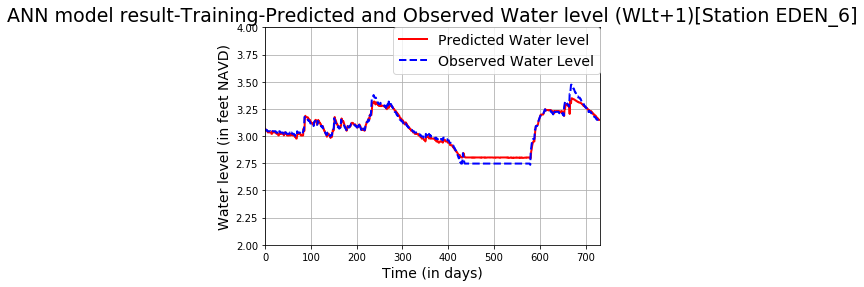

In [34]:
import matplotlib.pyplot as plt
#from matplotlib.font_manager import FontProperties
#def plot_ann_model(y_pred=y_pred,y_true=y_true):
plt.grid(True)
plt.title('ANN model result-Training-Predicted and'+
          ' Observed Water level (WLt+1)[Station '+station+']',
          fontsize=19)
plt.plot(predicted1,
         color='red',
         label='Predicted Water level',
         linestyle='solid',
         linewidth=2)
plt.plot(observed1,
         color='blue',
         label='Observed Water Level',
         linestyle='dashed',
         linewidth=2)
plt.legend(loc=0,borderaxespad=0.,fontsize=14)
plt.xlabel('Time (in days)',fontsize=14)
plt.ylabel('Water level (in feet NAVD)',fontsize=14)
plt.xlim(0,len(observed1))
plt.ylim(int(np.floor(min(observed1))),int(np.ceil(max(observed1))))
#t= ('MSE: '+(str(MSE1[0].round(5)))+'\n'+
#    'RMSE: '+(str(RMSE1[0].round(5)))+'\n'+
#    'PME: '+(str(PME1[0]))+'\n'+
#     'R2: '+(str(COD1))+'\n')
#plt.text(10,10.5,t,wrap=True,fontsize=14)
plt.show()

### ANN Model Validation results ===========================================================================

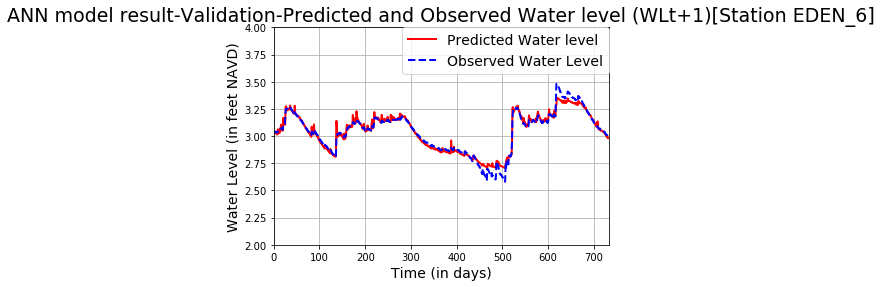

In [36]:
import matplotlib.pyplot as plt
#from matplotlib.font_manager import FontProperties
#def plot_ann_validation(y_pred1=y_pred1,y_true1=y_true1):
plt.grid(True)
plt.title('ANN model result-Validation-Predicted and'+
          ' Observed Water level (WLt+1)[Station '+station+']',
          fontsize=19)
plt.plot(predicted2,
         color='red',
         label='Predicted Water level',
         linestyle='solid',
         linewidth=2)
plt.plot(observed2,
         color='blue',
         label='Observed Water Level',
         linestyle='dashed',
         linewidth=2)
plt.legend(loc=0,borderaxespad=0.,fontsize=14)
plt.xlabel('Time (in days)',fontsize=14)
plt.xlim(0,len(observed2))
plt.ylim(int(np.floor(min(observed2))),int(np.ceil(max(observed2))))
plt.ylabel('Water Level (in feet NAVD)',fontsize=14)
#t= ('MSE: '+(str(MSE2[0].round(5)))+'\n'+
#    'RMSE: '+(str(RMSE2[0].round(5)))+'\n'+
#    'PME: '+(str(PME2[0].round(5)))+'\n'+
#     'R2: '+(str(COD2.round(5)))+'\n')
#plt.text(130,11.3,t,wrap=True,fontsize=14)
plt.show()

In [ ]:
mylist=[]
for i in range(len(inp_prepro)):
    print(str(i)+' : '+str(inp_prepro[i][0]))
    mylist.append(inp_prepro[i][0])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(len(RMSE2_list)), RMSE2_list)
plt.show()